# Amazon Product Review Dataset Analysis

In this notebook, we will perform exploratory data analysis on [amazon product review dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html), which include millions of amazon customer reviews in 2 decades since 1995.

This dataset is a source of rich information for ML, NLP projects. In order to focus on running the analysis locally without using cluster, we will focus on a smaller portion of the entire dataset for this notebook.

## Pre-requisites
You're assumed to be somewhat familiar with
* linux command line
* aq_tool
* aws API
* essentia command

## Environment and Note
This tutorial is run locally on one Ec2 instance, and will be focusing on use of `aq_tools` without udb.



## Data Source

Data is located in a S3 bucket named `wataru-essentia-proto` (CHANGE THIS TO PUBLIC S3 BUCKET LATER), in a zipped tsv format.

In order to scan and fetch the data, and take a look at them, we'll need to
1. set essentia's datastore to the s3 bucket
2. create data category that includes the targetted data
3. look at the summary of the category

**Selecting datastore**<br>
Starting with setting the s3 bucket as the datastore with `ess select` command.

In [3]:
ess select s3://wataru-essentia-proto

**Creating Category**<br>
Our dataset is located under `/tsv/` directory in the bucket, so using `ess ls` command will display the files inside of the directory.

In [6]:
# piping the output to head to get the top 10 lines, for simplicity
ess ls /tsv/ | head -n 10

 230M Aug 01 18:55    /tsv/amazon_reviews_multilingual_DE_v1_00.tsv.gz
  67M Aug 01 18:55    /tsv/amazon_reviews_multilingual_FR_v1_00.tsv.gz
  90M Aug 01 18:55    /tsv/amazon_reviews_multilingual_JP_v1_00.tsv.gz
 333M Aug 01 18:55    /tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz
 1.4G Aug 01 18:55    /tsv/amazon_reviews_multilingual_US_v1_00.tsv.gz
 618M Aug 01 18:55    /tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz
 555M Aug 01 18:55    /tsv/amazon_reviews_us_Automotive_v1_00.tsv.gz
 340M Aug 01 18:55    /tsv/amazon_reviews_us_Baby_v1_00.tsv.gz
 871M Aug 01 18:56    /tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz
 2.6G Aug 01 18:56    /tsv/amazon_reviews_us_Books_v1_00.tsv.gz


In this notebook we'll only use the multilingual dataset (Denmark, France, Japan, UK and US) on the top 5 lines. <br>
Glob pattern to these files in the S3 buckets is 
```/tsv/amazon_reviews_multilingual_*_v1_00.tsv.gz```

With `ess category add` command,

In [7]:
# creating the category with name of amazon_reviews. This will return error if it already exist.
ess category add amazon_reviews "/tsv/amazon_reviews_multilingual_*_v1_00.tsv.gz" 

2019-10-28 18:43:24 ip-10-10-1-118 ess[3471]: Fetching file list from datastore.
2019-10-28 18:43:24 ip-10-10-1-118 ess[3471]: Examining largest matched file to determine compression type: /tsv/amazon_reviews_multilingual_US_v1_00.tsv.gz
2019-10-28 18:43:25 ip-10-10-1-118 ess[3471]: Probing largest matched file to determine data configuration: /tsv/amazon_reviews_multilingual_US_v1_00.tsv.gz


**Taking a look at the detail**<br>
Now we have a category, let's take a look at it's summary including schemas and sample data with `ess summary`

In [8]:
ess summary amazon_reviews

Name:        amazon_reviews
Pattern:     /tsv/amazon_reviews_multilingual_*_v1_00.tsv.gz
Exclude:     None
Date Format: auto
Date Regex:  
Archive:     
Delimiter:   Tab
# of files:  5
Total size:  2.1GB
File range:  1970-01-01 - 1970-01-01
# columns:   15
Column Spec: S:marketplace I:customer_id S:review_id S:product_id I:product_parent S:product_title S:product_category I:star_rating I:helpful_votes I:total_votes S:vine S:verified_purchase S:review_headline S,esc:review_body S:review_date
Pkey: 
Schema: S:marketplace I:customer_id S:review_id S:product_id I:product_parent S:product_title S:product_category I:star_rating I:helpful_votes I:total_votes S:vine S:verified_purchase S:review_headline S,esc:review_body S:review_date
Preprocess:  
usecache:    False
Comment:    

First few lines:
marketplace	customer_id	review_id	product_id	product_parent	product_title	product_category	star_rating	helpful_votes	total_votes	vine	verified_purchase	review_headline	review_body	review_date
US	5309

Essentia was able to extract the data schema automatially along with each column name. According to the meta data file, each column represents the followings.

* **marketplace**: 2 letter country code of the marketplace where the review was written
* **customer_id**: Random identifier that can be used to aggregate reviews written by a single author.
* **review_id**: The unique ID of the review
* **product_id**: The unique Product ID the review pertains to. In the multilingual dataset the reviews
* **product_parent**: Random identifier that can be used to aggregate reviews for the same product.
* **product_title**: title of the product
* **product_category**: Broad product category that can be used to group reviews (also used to group the dataset Countinto coherent parts)
* **star_rating**: The 1–5 star rating of the review.
* **helpful_votes**: Number of helpful votes.
* **total_votes**: Number of total votes the review received.
* **vine**: Review was written as part of the Vine program
* **verified_purchase**: the review is on a verified purchase
* **review_headline**: The title of the review
* **review_body**: the review text
* **review_date**: The date the review was written.

Looks like we can extract some useful information from columns such as `marketplace`, `product_category`, `star_rating`, `review_date`. 

## Exploratory Data Analysis
**Note:**<br>
There are multiple ways of counting unique values in aq_tools, such as 
* Using `aq_cnt`
* set up udb, and use `aq_udb -cnt` option.
On here, we'll be using `aq_cnt` command.

### Occurence Counts on Columns

Now we know what the data looks like, we can get started on analying the data. We'll start with looking at star rating's distribution in the dataset.

**star rating**<br>

We can display distribution of `star_rating` with `aq_cnt`.

* `ess stream amazon_reviews --bulk --master`
    * `--bulk` and `--master` was set in order to process 5 files as 1 and run `aq_cnt` on it one time. By default `ess` command runs given commands serially one time for each file.
* `aq_cnt -f,+1,tsv,eok...`
    * `eok` was added to skip the invalid row, as well as headers between files (4 headers will be present in the stream from files).

In [27]:
ess stream amazon_reviews --bulk --master "*" "*" "aq_cnt -f,+1,tsv,eok - -d %cols -kX - rating star_rating"

"star_rating","count"
2,396197
1,567938
3,766981
4,1772963
5,6330030
2019-10-28 19:44:49 ip-10-10-1-118 ess[4372]: !!!Warning!!! Multiple warnings.  See task.log for more details


The plot for this looks like following.

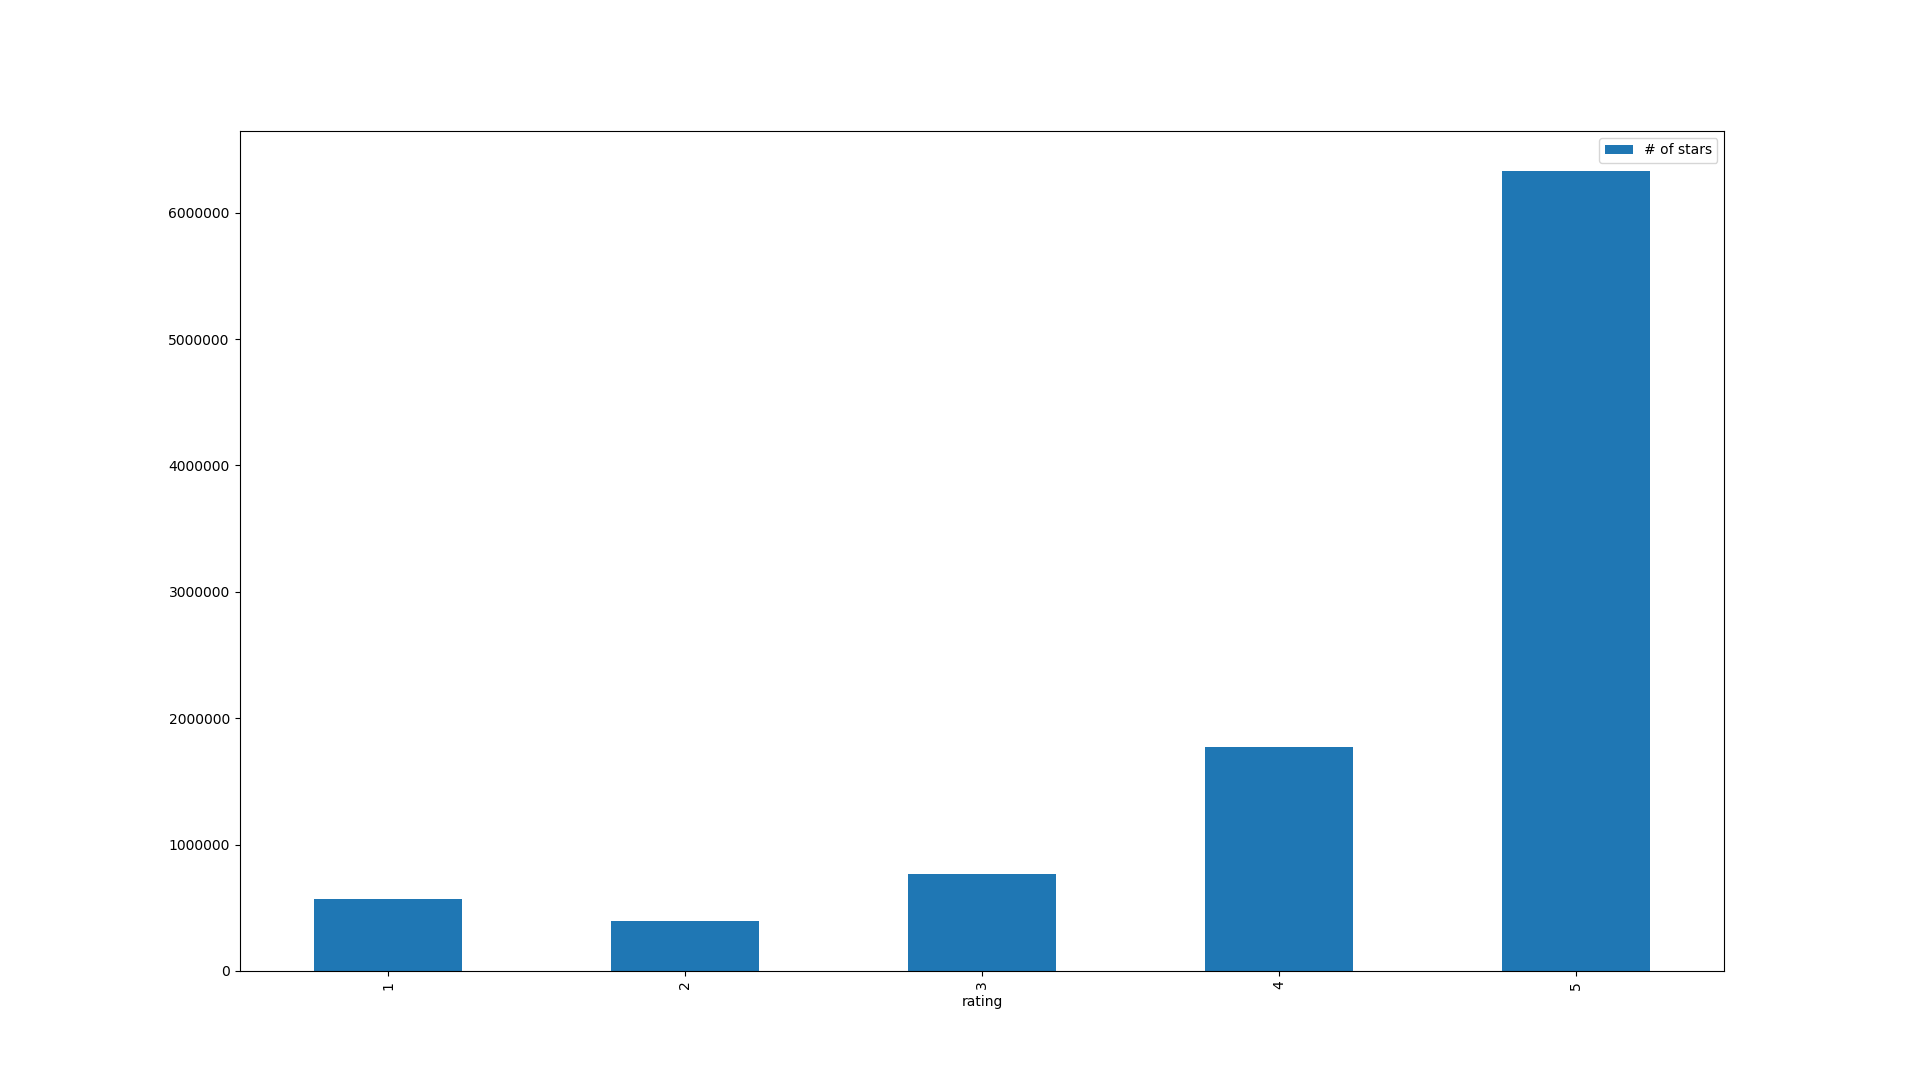

**Marketplace**<br>

You can apply similar command in order to get insights on numbers of total reviews on each marketplace.

In [28]:
ess stream amazon_reviews --bulk --master "*" "*" "aq_cnt -f,+1,tsv,eok - -d %cols -kX - marketplace marketplace"

"marketplace","count"
"US",6931013
"UK",1707480
"JP",262430
"FR",254075
"DE",679111
2019-10-28 19:59:58 ip-10-10-1-118 ess[4451]: !!!Warning!!! Multiple warnings.  See task.log for more details


marketplace counts plot

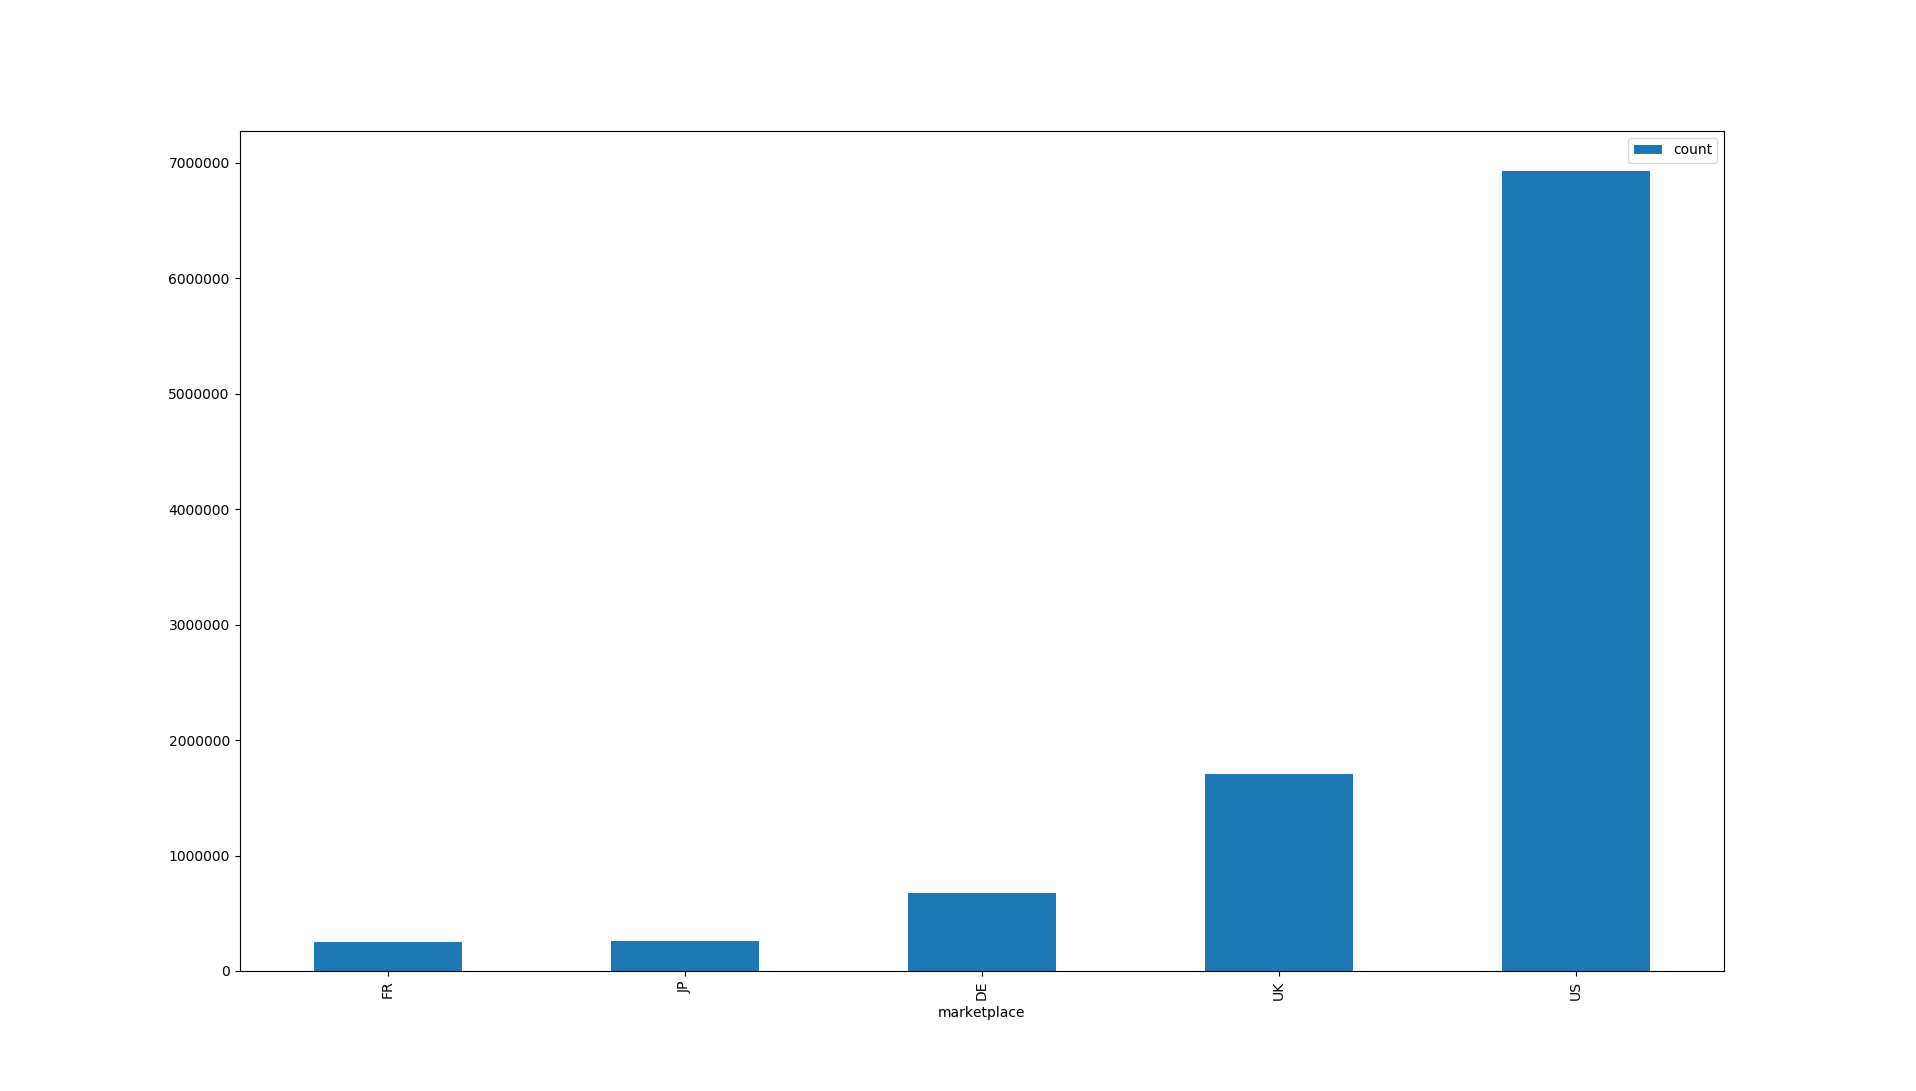

**Product Category**<br>

Counts of each product category across the marketplace and time.

In [29]:
ess stream amazon_reviews --bulk --master "*" "*" "aq_cnt -f,+1,tsv,eok - -d %cols -kX - category product_category"

"product_category","count"
"Mobile_Electronics",184
"Outdoors",3195
"Tools",7510
"Apparel",127
"Grocery",20
"Pet Products",51
"Beauty",55
"Software",204
"Furniture",101
"Lawn and Garden",1973
"Automotive",1534
"Baby",11960
"Kitchen",2365
"Camera",36786
"Video",56804
"Personal_Care_Appliances",705
"Home Entertainment",37807
"Office Products",4057
"Musical Instruments",15963
"Home",7008
"Health & Personal Care",1434
"Shoes",12559
"Luggage",475
"Wireless",36228
"Sports",9694
"Digital_Ebook_Purchase",1558331
"Digital_Music_Purchase",163296
"Toys",117348
"Video Games",22489
"Electronics",27068
"Music",1426187
"PC",95778
"Mobile_Apps",1773737
"Watches",17169
"Digital_Video_Download",1116575
"Video DVD",2066643
"Books",1194816
"Home Improvement",5873
2019-10-28 20:04:36 ip-10-10-1-118 ess[4487]: !!!Warning!!! Multiple warnings.  See task.log for more details


Just like that, you can take a look at any categorical column's occurence counts.

### Time Series

This dataset contains reviews since 1995, which I was not even aware that amazon store existed. 
We'd like to explore characteristics and patterns of reviews changed overtime. 

**Breaking down timestamp into month and year**<br>
Currently timestamp of the review (year, month and date) are stored in one string in `review_date` column. Let's break it down into year and month, so that it can be grouped by this value.

Using aq_pp's `-mapc/f` option to extract and map year and month, and we'll output `review_id`, `reviwew_date`, `year`, `month` columns only for clearity.

In [40]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id review_date year month' | head -n 6

"review_id","review_date","year","month"
"RVOG49N0H1FB6","2014-08-01","2014","08"
"RNCMD6OLTP4HM","2014-12-04","2014","12"
"R4AUOBI8YC0R8","2014-12-04","2014","12"
"R1VSHIJ1RHIBTE","2015-07-16","2015","07"
"R3JBLVALWSLCZD","2014-02-08","2014","02"
2019-10-28 21:12:11 ip-10-10-1-118 ess[4810]: !!!Warning!!! Multiple warnings.  See task.log for more details


Now the data is ready for the time series analysis.

**Numbers of reviews over years**<br>
Using the command from the last cell, we'll have it output `review_id` and `year`, and pipe it into `aq_cnt` command.
Because `review_id` is a unique identifier for each review, we'll count numbers of unique review ids group by year.<br>
Lastly using `aq_ord` command to sort the output by year.

In [51]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id year' | \
aq_cnt -f,+1 - -d S:review_id S:year -g year -k annual_reviews review_id | \
aq_ord -f,+1 - -d S:year I:count I:annual_reviews -sort year

"year","count","annual_reviews"
2019-10-28 21:46:49 ip-10-10-1-118 ess[5045]: ***Error*** Multiple errors.  See task.log for more details
"2004",13,13
"2005",69,69
"2006",44,44
"2007",170,170
"2008",951,951
"2009",1860,1860
"2010",2098,2098
"2011",2590,2590
"2012",6634,6634
"2013",24629,24629
"2014",28438,28438
"2015",18275,18275


**Numbers of Reviews over the years in each month**<br>

We can analyze numbers of reviews over the years, in each month by counting it group by year, and month. <br>
Afterwards, we can use `aq_rst` to organize the result into table with rows of months and columns of years.


In [60]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id year month' | \
aq_cnt -f,+1 - -d S:review_id S:year S:month -g year month -k reviews review_id | \
aq_rst -f,+1 - -d S:month S:year I:reviews -key month -lab year -val reviews

2019-10-28 22:22:50 ip-10-10-1-118 ess[5293]: ***Error*** Multiple errors.  See task.log for more details
"month","01","02","03","04","05","06","07","08","09","10","11","12"
"2004",0,0,0,3,1,0,0,1,2,0,1,5
"2005",5,17,4,7,5,9,3,9,3,0,3,4
"2006",1,3,6,2,3,0,5,4,7,1,3,9
"2007",7,4,8,4,2,6,8,7,8,4,49,63
"2008",109,50,62,57,64,82,66,94,92,84,101,90
"2009",130,174,163,130,140,111,198,134,137,177,161,205
"2010",235,169,130,162,152,129,154,189,188,222,183,185
"2011",220,227,217,196,180,171,225,162,214,218,250,310
"2012",436,335,312,368,389,331,400,397,545,533,962,1626
"2013",2174,1731,2088,1931,1906,1734,1856,1926,2045,2117,2425,2696
"2014",3019,2180,2395,2285,2266,1938,2072,2295,2290,2336,2450,2912
"2015",2913,2188,2238,2396,2246,2137,2110,2047,0,0,0,0


![year_month.png](attachment:year_month.png "Title")
*Heatmap, month vs year*
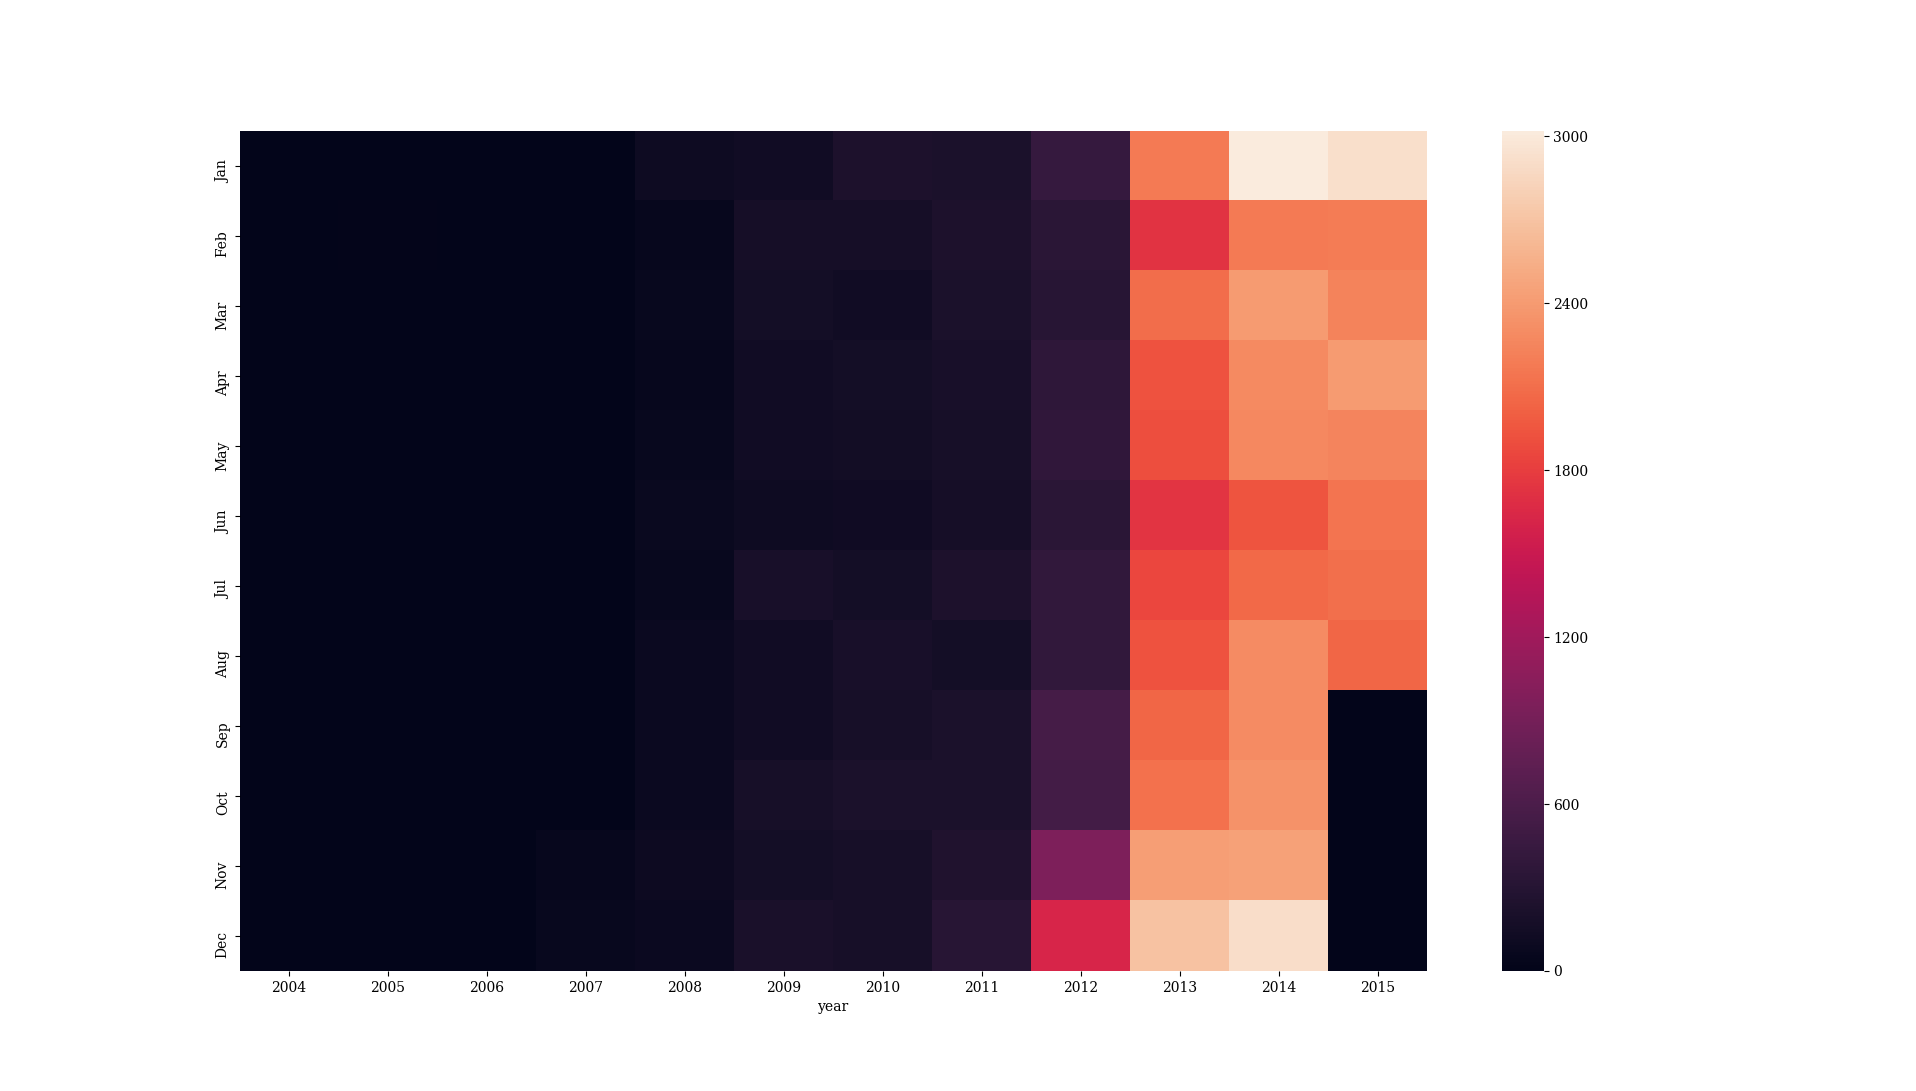

**Numbers of Reviews over months**<br>

This is useful to check if there's monthly / seasonal trends in numbers of reviews.
Let's try to dig little deeper, and gain numbers of each star_rating for each month. We can do this by further grouping record by `star_rating` value on `aq_cnt` command, then uing `aq_rst` to transform into pivot table.

In [57]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id star_rating month' | \
aq_cnt -f,+1 - -d S:review_id I:star_rating S:month -g month star_rating -k monthly review_id | \
aq_rst -f,+1 - -d S:month I:star_rating I:monthly -key star_rating -lab month -val monthly

2019-10-28 22:16:00 ip-10-10-1-118 ess[5236]: ***Error*** Multiple errors.  See task.log for more details
"star_rating","01","02","03","04","05","06","07","08","09","10","11","12"
1,472,394,433,440,419,432,457,478,293,322,465,460
2,294,248,260,246,262,210,253,257,206,197,255,269
3,609,470,538,502,483,447,470,490,380,391,445,505
4,1371,1022,1089,1050,1078,928,1067,1078,895,832,856,1131
5,6503,4944,5303,5303,5112,4631,4850,4962,3757,3950,4567,5740


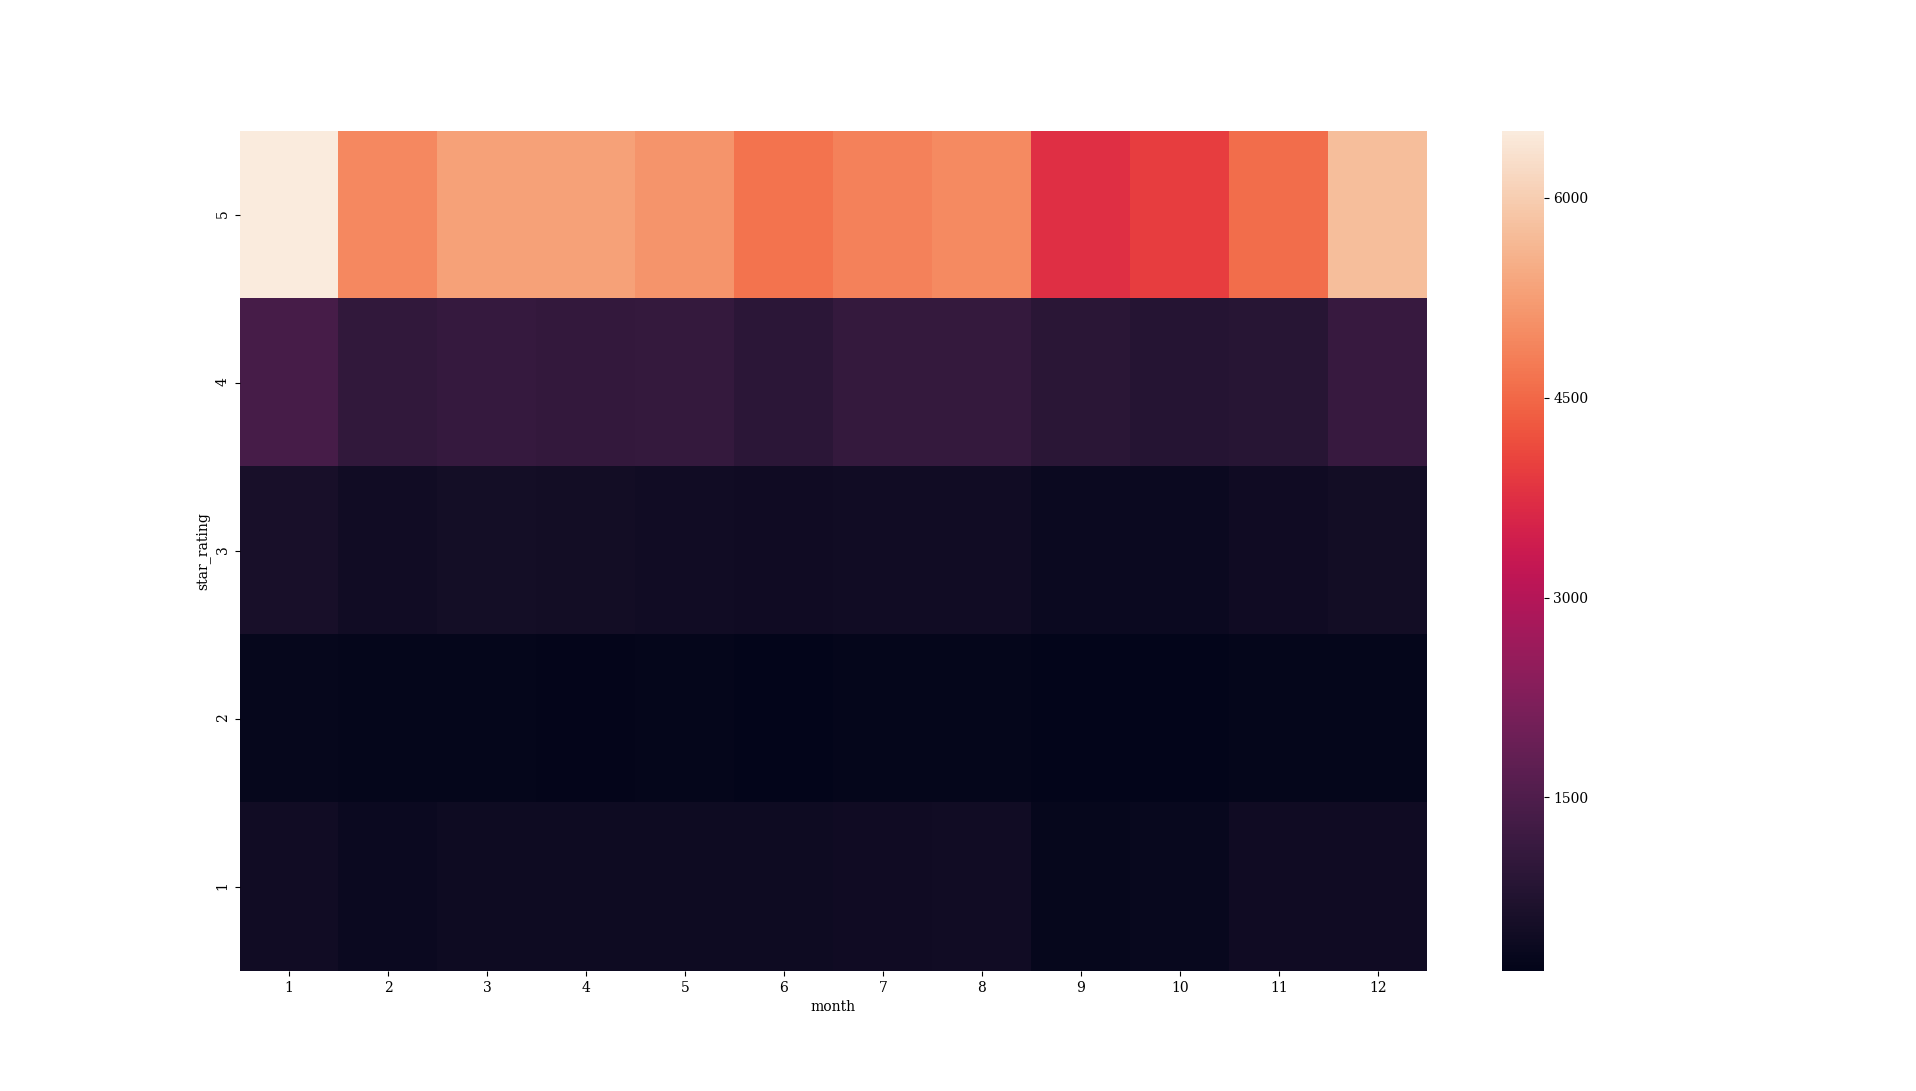
*Heatmap of rating vs month*

### Numbers of Reviews Left per Customer

Let's take a look at how many reviews are left by one customers.<br>
To get this value, we need to take 2 steps,
1. count numbers of reviews left by each customer by grouping by `customer_id`. Let's call this `reviews_per_customer`.
2. count numbers of unique `customer_id` in each `reviews_per_customer`



In [69]:
# step 1
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_cnt -f,+1,eok,tsv - -d %cols -g customer_id -k reviews_per_customer review_id'

"customer_id","row","reviews_per_customer"
146004,2,2
254421,1,1
565563,1,1
52303,1,1
1162122,1,1
108745,1,1
1325068,1,1
515450,1,1
3733178,1,1
5662728,1,1
1117977,3,3
6454258,1,1
1772983,1,1
8556468,1,1
2288113,1,1
4599064,1,1
12461968,1,1
5724518,1,1
13397066,1,1
10015518,1,1
10319957,1,1
10409415,1,1
11100659,1,1
18301354,1,1
11580132,1,1
12601635,1,1
13673100,1,1
20251073,1,1
13721934,1,1
21204901,1,1
22160702,1,1
17967803,1,1
22198707,1,1
19608213,1,1
20044670,1,1
20390744,1,1
22829291,2,2
22964510,1,1
24431226,1,1
23342147,1,1
23903982,1,1
29663373,1,1
25221713,1,1
30478238,1,1
26437581,1,1
32519904,1,1
27074809,1,1
27617649,1,1
35016202,1,1
27777571,1,1
35556393,1,1
28958961,1,1
29456133,1,1
35890584,1,1
30067162,3,3
30755027,1,1
31194855,1,1
34443666,1,1
34510910,1,1
36598839,1,1
40794597,6,6
39142051,1,1
41873966,1,1
40627480,1,1
40761115,1,1
44825806,1,1
41210815,1,1
42034138,1,1
45317707,1,1
42038451,1,1
43070105,1,1
43215800,1,1
43325137,1,1
43407715,1,1
43540573,1,1
474877

16467041,1,1
17525293,1,1
37316956,1,1
38372914,1,1
18050339,2,2
19195405,1,1
40765042,1,1
22151364,5,5
45297979,1,1
22702498,1,1
45387146,1,1
23251801,1,1
45581302,1,1
23369383,1,1
45802658,1,1
25898652,1,1
27627839,1,1
28819601,1,1
45946560,5,5
29938093,1,1
46559443,1,1
30002174,1,1
31179062,1,1
49676890,1,1
49889289,1,1
32497162,1,1
52122559,1,1
36284997,1,1
52529402,1,1
37047630,1,1
38387482,1,1
40086373,1,1
550467,1,1
846131,1,1
41261970,1,1
1092397,1,1
1874427,1,1
3087976,1,1
42246236,1,1
42942153,1,1
4511666,1,1
43311001,1,1
4966133,1,1
5238132,1,1
5524655,1,1
6910476,1,1
8299374,1,1
9519609,1,1
10354225,1,1
11283457,1,1
44597454,8,8
44841456,1,1
45217677,1,1
13310572,1,1
45249417,1,1
13713697,1,1
13916410,1,1
45938242,1,1
15476108,1,1
16183278,1,1
47255747,1,1
16865434,1,1
47858374,1,1
47985753,1,1
20407139,1,1
49453604,1,1
20510827,1,1
49717548,1,1
50499671,1,1
21014789,4,4
51649162,1,1
22188798,1,1
132282,1,1
213002,1,1
727189,1,1
25495764,1,1
733095,1,1
1175791,1,1
26713884,

13052034,1,1
13120448,1,1
40676812,2,2
13337853,1,1
14016961,1,1
44964773,1,1
15116005,1,1
44984621,1,1
46336936,1,1
48488544,1,1
49297173,1,1
52761240,1,1
16978843,1,1
18364661,1,1
18878333,2,2
53068673,1,1
331912,1,1
20401761,1,1
1702149,1,1
23175597,1,1
1989554,4,4
2391908,1,1
3045685,1,1
23226417,4,4
4247498,1,1
23831323,1,1
5765396,1,1
24285913,1,1
6704658,1,1
24807588,1,1
25484132,1,1
25821096,1,1
11409861,1,1
28375886,1,1
11548125,1,1
28766441,1,1
29083845,1,1
13310298,1,1
29794188,1,1
14587876,1,1
30971644,1,1
14677299,1,1
15024555,1,1
31734070,1,1
19035997,1,1
32354653,2,2
19371986,1,1
32998282,1,1
19952022,1,1
33089646,1,1
22233257,1,1
34131564,1,1
22640897,1,1
38507758,1,1
23761420,1,1
41666726,1,1
42894492,1,1
24087906,2,2
43721955,1,1
44142853,1,1
25059573,1,1
25178739,1,1
44300889,1,1
25396527,1,1
27021914,1,1
27324930,2,2
47754074,1,1
27485218,1,1
48091244,1,1
28875042,1,1
48306678,1,1
29098453,1,1
48534207,1,1
48631197,1,1
32034785,1,1
52040880,1,1
727333,1,1
35099978,1

14051959,1,1
35328104,1,1
37958234,1,1
15232990,1,1
38241331,1,1
16067135,1,1
39886974,1,1
40268910,1,1
21824314,1,1
41753567,1,1
41935943,1,1
43604690,1,1
44056142,1,1
24191794,1,1
47049134,1,1
25327972,1,1
47264434,1,1
25582410,1,1
47694046,1,1
25838613,1,1
50927209,1,1
29165605,1,1
124970,1,1
31594370,1,1
215587,1,1
280113,1,1
885728,1,1
38798846,1,1
1339342,1,1
1452487,1,1
2659194,1,1
42935523,1,1
43123866,1,1
6894948,1,1
46412150,1,1
8452526,1,1
9993651,1,1
48336469,1,1
11548670,1,1
49224410,1,1
12033142,1,1
50212894,1,1
12035529,2,2
12485545,1,1
52759437,1,1
323959,1,1
410668,1,1
624980,2,2
1194822,1,1
2560454,1,1
13340211,1,1
4916467,1,1
14675413,2,2
9534302,1,1
10293599,1,1
14774364,1,1
18154351,1,1
12401875,1,1
19879441,1,1
12447147,1,1
13114084,1,1
23931319,1,1
13171968,1,1
13969501,1,1
25049894,1,1
14797805,1,1
16247446,1,1
28803532,1,1
31060221,1,1
31232091,1,1
16572332,1,1
16934378,1,1
17075827,1,1
33193830,1,1
19445241,1,1
34041207,1,1
20112289,1,1
35248827,1,1
23944084,1

22350434,1,1
22409840,1,1
48862525,1,1
50200926,1,1
23599386,4,4
50897241,1,1
24482207,1,1
51717829,1,1
25584472,1,1
107750,1,1
26270489,1,1
109203,1,1
27597408,1,1
27691609,1,1
29964368,1,1
1286467,1,1
1903114,1,1
30624443,1,1
2827599,1,1
31303898,1,1
2931721,1,1
31928793,1,1
2968086,1,1
33356438,1,1
35500193,1,1
4423967,1,1
36194483,2,2
7915364,1,1
37341625,1,1
10016216,1,1
37607062,1,1
10156344,1,1
39288684,1,1
11422402,1,1
11447843,1,1
41090506,1,1
41349967,1,1
12207196,1,1
12325527,1,1
12654862,1,1
12856788,1,1
43160921,1,1
12994628,1,1
43727980,1,1
14309542,1,1
45033477,2,2
14358416,1,1
46161247,1,1
46368853,1,1
14501037,1,1
46586736,1,1
15423272,1,1
47153700,1,1
47192505,1,1
18737920,1,1
47269195,1,1
49873796,1,1
22203845,1,1
24054987,1,1
25845440,1,1
52432399,1,1
26516950,1,1
127462,1,1
359469,1,1
27656409,1,1
522763,1,1
28316761,1,1
1260182,1,1
32699209,1,1
4704684,1,1
6003995,1,1
6213291,1,1
36506628,1,1
7049684,1,1
7150629,1,1
9601548,1,1
11097852,1,1
11691653,1,1
11880998,1

31917364,1,1
36290808,3,3
32886382,1,1
34172529,1,1
34618598,2,2
35141401,1,1
37250647,1,1
40991911,1,1
41068363,1,1
41273510,1,1
42189628,1,1
42847165,1,1
44777701,1,1
44002053,1,1
44972251,1,1
45469242,1,1
45548622,1,1
46910224,1,1
45758701,1,1
48429745,1,1
46318713,1,1
49075159,1,1
50937754,1,1
51161147,1,1
52226112,1,1
116569,1,1
160984,1,1
162995,1,1
51460193,3,3
198519,1,1
51998465,1,1
1134633,1,1
1590995,1,1
114218,1,1
673540,1,1
1849863,2,2
798075,1,1
2963270,1,1
901721,1,1
3486952,1,1
6596878,1,1
2923679,1,1
3077320,1,1
8105958,1,1
9622204,1,1
5094204,1,1
10501434,1,1
10723917,1,1
6954430,1,1
7215520,1,1
7445962,1,1
11572190,1,1
10074756,1,1
12249363,1,1
10845815,1,1
12648079,1,1
12859011,1,1
14067733,1,1
11618413,1,1
14544162,1,1
16085129,1,1
16205221,1,1
16967303,1,1
13106017,8,8
14616455,1,1
19757860,1,1
14995078,1,1
15417222,1,1
21262235,1,1
23162981,1,1
18972381,1,1
23426278,1,1
20171845,1,1
24052060,1,1
25252725,1,1
21369146,2,2
21562362,1,1
22279931,1,1
27475204,2,2
225

16540744,1,1
44416436,1,1
44458288,1,1
44546032,1,1
19274712,1,1
44716773,1,1
45753032,1,1
20326920,1,1
23298397,1,1
50255441,1,1
50957371,1,1
24385649,1,1
52220985,1,1
24568849,1,1
24994349,1,1
52567848,1,1
25402387,1,1
122027,1,1
25642985,1,1
25682663,1,1
1634627,1,1
27106036,1,1
2139181,1,1
27455783,1,1
7458871,1,1
28343127,1,1
29424516,1,1
9051557,1,1
30244212,1,1
10844542,1,1
11137427,1,1
33972742,1,1
11881532,1,1
34408140,1,1
36557748,1,1
12127379,1,1
40422379,1,1
41527903,1,1
14500176,1,1
14867579,1,1
17344925,1,1
52591807,1,1
19335758,1,1
20373581,1,1
106597,1,1
20487036,1,1
113592,1,1
20726600,1,1
21411657,1,1
463146,1,1
1878016,1,1
22300836,1,1
22375647,1,1
5545308,1,1
22434477,1,1
22493498,1,1
7213039,1,1
22816099,1,1
23097188,1,1
10145577,1,1
23606111,1,1
11179333,1,1
24067976,1,1
11525947,1,1
26337293,2,2
30839922,1,1
31073530,1,1
15448206,1,1
32559808,1,1
15819502,1,1
36088039,1,1
36424512,1,1
17527915,1,1
18272183,1,1
38147151,1,1
38162481,1,1
21455583,1,1
38305173,1,1
4

2011325,2,2
15176549,1,1
20115932,1,1
5252963,1,1
5489387,1,1
23285341,1,1
6312696,1,1
23383455,1,1
6806869,1,1
23404283,1,1
10284740,1,1
23779616,1,1
12666684,1,1
12751639,1,1
26652623,1,1
13950546,1,1
27254934,1,1
14048988,1,1
27347044,1,1
14239730,1,1
29391473,1,1
29820380,1,1
21216848,1,1
22261432,1,1
33274152,1,1
34634618,1,1
36655613,1,1
25187889,1,1
26628302,1,1
27215351,1,1
40676223,1,1
27510043,1,1
27951545,1,1
42287230,1,1
44965719,1,1
30635471,1,1
45250234,1,1
45661888,1,1
32776684,1,1
47455164,1,1
33826001,1,1
47932022,1,1
49548692,1,1
35691618,1,1
36958836,1,1
50760476,1,1
50761144,1,1
38251986,1,1
51003352,1,1
180121,1,1
335700,3,3
48926477,1,1
774902,1,1
49467799,1,1
917152,1,1
49778843,1,1
2222168,1,1
50264251,1,1
3189401,1,1
3632235,1,1
3901142,1,1
4878901,1,1
5316183,1,1
52568009,2,2
6285253,1,1
109404,1,1
6751945,1,1
358543,1,1
8125227,1,1
717837,1,1
1384355,1,1
10576711,1,1
2168630,1,1
2367508,1,1
3021223,1,1
3803536,1,1
11996950,3,3
5004009,1,1
6709328,1,1
15050877

43973242,1,1
45522676,1,1
44946930,1,1
45824753,1,1
36905522,1,1
45946645,1,1
37815512,1,1
40856152,1,1
47277147,2,2
48426958,1,1
41717119,2,2
48501341,1,1
49758497,1,1
42563175,1,1
43335388,1,1
49513905,1,1
123009,1,1
6304977,15,15
51619720,1,1
44967321,1,1
736892,1,1
49043100,1,1
850408,1,1
9201581,1,1
50450704,1,1
10529287,1,1
127849,2,2
49913733,1,1
1200129,2,2
12221852,1,1
130262,1,1
51354125,1,1
2046626,1,1
12500262,1,1
166968,1,1
2573609,1,1
12871043,1,1
199316,1,1
52528956,1,1
2913107,1,1
13133909,1,1
456935,1,1
52594287,1,1
470657,1,1
5006445,1,1
14326471,1,1
5846306,1,1
1084059,2,2
110572,1,1
5985700,1,1
884669,1,1
339362,1,1
6147186,1,1
15258331,2,2
1791422,1,1
1011196,1,1
16736085,1,1
1537663,1,1
2809640,1,1
7662015,1,1
1758617,1,1
3976816,1,1
8584642,1,1
5182428,1,1
8793329,1,1
355260,1,1
2075553,1,1
7276847,1,1
2392965,1,1
20549347,1,1
3024719,1,1
10839246,1,1
1293105,5,5
9174333,1,1
3768681,1,1
3964261,1,1
11250241,1,1
11824779,1,1
23294270,1,1
4889741,1,1
11269207,1,1
1

19991832,2,2
20060920,1,1
20114263,1,1
20869320,1,1
31722944,1,1
32257073,1,1
34988734,1,1
21954919,1,1
24275869,1,1
37297602,1,1
24973053,1,1
37949315,1,1
25142469,1,1
40052154,1,1
25460180,1,1
40905500,1,1
26142686,1,1
42083847,1,1
26822236,1,1
42938279,1,1
44670341,1,1
45009808,1,1
30155869,1,1
30228916,1,1
46467790,1,1
31042168,1,1
31351393,1,1
32962159,1,1
34956315,1,1
38624913,1,1
49139212,1,1
50001311,1,1
44975884,1,1
50751701,1,1
45402499,1,1
53088578,1,1
46415710,1,1
107746,1,1
110895,1,1
48570315,1,1
2229907,1,1
51046269,1,1
3074580,1,1
3777917,1,1
5103428,1,1
52894514,1,1
5561662,1,1
534184,1,1
7437665,1,1
2151422,1,1
8748426,1,1
2505238,1,1
9041941,1,1
3461627,1,1
10094441,1,1
4459659,1,1
10621050,1,1
5107356,1,1
10684831,1,1
5362356,1,1
10716506,1,1
6854336,1,1
10841600,1,1
9567125,1,1
10385788,1,1
10656624,1,1
11373365,5,5
11677909,1,1
11004769,1,1
12772756,1,1
13454190,1,1
11254343,1,1
15953711,1,1
16305398,1,1
13142773,1,1
17744017,1,1
13265188,1,1
13794876,1,1
19076722

20535327,1,1
45737795,1,1
21441334,1,1
46306582,1,1
50645393,1,1
21488305,3,3
26711252,1,1
128097,1,1
28235822,1,1
28423122,1,1
32807892,1,1
2359738,1,1
4547535,1,1
34762014,1,1
5131013,1,1
6882182,1,1
37295904,1,1
38750009,1,1
10876876,1,1
43435803,1,1
13483791,1,1
14307339,1,1
44077125,2,2
14981670,1,1
44799550,1,1
44929357,1,1
45399129,1,1
19389890,1,1
45997698,1,1
20518815,1,1
46654141,1,1
20634320,1,1
20966864,1,1
23022491,1,1
23462845,1,1
23886957,1,1
52081222,1,1
25579872,1,1
1658134,1,1
29310560,1,1
2538064,1,1
30386478,1,1
31514485,1,1
2724493,1,1
31585132,1,1
34662749,1,1
3610360,1,1
3998593,1,1
6864073,1,1
36379986,1,1
37307051,1,1
7206286,2,2
38240163,1,1
8147901,1,1
39194784,1,1
11124823,1,1
41534761,1,1
11284869,1,1
41621351,1,1
15482237,1,1
45032488,2,2
16347930,1,1
17122212,1,1
46418248,1,1
17329367,1,1
50046383,1,1
50328529,1,1
18865854,1,1
50531744,1,1
19781244,1,1
20530920,1,1
51745733,2,2
20866420,1,1
22063222,1,1
52835667,1,1
22687756,1,1
968106,1,1
23050199,1,1
26

11502985,1,1
12041770,1,1
52006508,1,1
107367,1,1
13342452,1,1
132216,1,1
13349572,1,1
151770,1,1
342237,1,1
1021522,1,1
13997629,3,3
1218177,1,1
2222223,1,1
3668095,1,1
3687094,1,1
14875016,1,1
4370566,1,1
14913414,1,1
5420847,1,1
14990607,1,1
15478866,1,1
8923212,1,1
15937550,1,1
10595304,1,1
16201211,1,1
11336584,1,1
16771254,1,1
12113886,1,1
12126416,1,1
17036157,1,1
17502332,1,1
18369376,1,1
14677184,1,1
20965392,1,1
22154913,1,1
22573724,1,1
16387046,1,1
16932883,1,1
23245999,1,1
18427583,1,1
29995949,1,1
19737005,1,1
30156075,1,1
20514648,1,1
31484442,1,1
32308375,1,1
27853675,1,1
37082503,1,1
28728996,1,1
38587239,1,1
40066945,1,1
41249161,1,1
41474347,1,1
42986238,1,1
43997753,1,1
37590643,3,3
44515709,1,1
39945609,1,1
44713116,1,1
40916785,1,1
44737089,1,1
43095360,1,1
48186900,1,1
48408897,1,1
44112603,1,1
44973421,1,1
107026,1,1
45347566,1,1
109682,1,1
45916219,1,1
141393,1,1
46888191,1,1
217164,1,1
52945673,1,1
988499,1,1
130707,1,1
1624203,1,1
178328,1,1
2781103,1,1
22378

23440519,1,1
46182718,1,1
23723341,1,1
47132017,1,1
13971481,1,1
31540199,1,1
15180501,1,1
26939765,1,1
35317225,1,1
27324229,1,1
17115771,1,1
51603042,1,1
17238744,1,1
28716941,3,3
52280475,1,1
44622499,1,1
661812,1,1
18656461,3,3
1684032,1,1
45935009,1,1
30437111,1,1
19391308,1,1
1695068,1,1
20529123,1,1
3148989,1,1
22046993,1,1
46858839,1,1
4208296,1,1
47158509,1,1
27852569,1,1
6934130,1,1
28757214,1,1
9344873,1,1
48338649,1,1
29539556,1,1
9981005,1,1
39619756,1,1
30848007,1,1
11377084,1,1
48939502,1,1
39762993,1,1
49393434,1,1
12677794,1,1
42664791,1,1
37535505,2,2
51294820,1,1
44730773,1,1
38876360,1,1
13826605,1,1
45191896,1,1
145783,1,1
46725489,1,1
47075576,1,1
14330572,1,1
914722,1,1
14892867,1,1
979072,1,1
50627819,1,1
52091497,1,1
15314874,1,1
2756320,1,1
52431566,2,2
17508999,1,1
5653090,1,1
318191,1,1
7934663,1,1
52769495,1,1
1592778,1,1
21651936,1,1
11504319,1,1
187129,1,1
4149408,1,1
12202249,1,1
723609,1,1
5606036,1,1
12754362,1,1
6451253,1,1
13732667,1,1
3669031,1,1
85

1249839,1,1
6290905,1,1
6469608,1,1
3714478,2,2
8098190,1,1
9889141,2,2
7775696,1,1
10293720,1,1
8513974,1,1
10414235,1,1
10571540,1,1
10271067,1,1
11518672,1,1
10527325,1,1
11706798,1,1
15907395,1,1
22885476,1,1
23426518,1,1
12655591,1,1
13699431,1,1
26283087,1,1
15036312,1,1
15346374,1,1
30267778,1,1
30707621,1,1
22227772,1,1
31442689,1,1
23526903,1,1
32885701,1,1
25096026,1,1
25950867,1,1
38150430,1,1
41177164,1,1
43138997,1,1
45647969,1,1
30552055,1,1
31291472,1,1
31844461,1,1
51405231,1,1
37613252,1,1
40098364,1,1
52818876,3,3
17612,1,1
43201690,1,1
145585,1,1
152074,1,1
44798495,1,1
1521190,1,1
46262563,1,1
2069588,1,1
46718517,1,1
48041430,1,1
2533537,1,1
48077970,1,1
2694950,1,1
49096834,1,1
2797179,1,1
50065653,1,1
3151049,1,1
50589740,1,1
3704551,1,1
52005710,1,1
52762275,1,1
873102,1,1
5929996,1,1
7671358,1,1
1114804,1,1
11911343,2,2
1571320,1,1
2720358,1,1
13572562,1,1
3042747,1,1
3097905,1,1
16802503,1,1
23010419,1,1
26448527,1,1
29798919,1,1
33009345,1,1
34551269,1,1
3742

5084274,1,1
51372262,1,1
5382929,1,1
440654,1,1
10680457,1,1
1128959,1,1
10920903,1,1
1259861,1,1
3657374,1,1
11724635,1,1
9086732,1,1
12627437,1,1
9827984,1,1
12997346,1,1
14209164,1,1
13437741,1,1
15452424,1,1
13974689,1,1
15081170,1,1
19101542,1,1
15882032,1,1
25893348,1,1
23361372,1,1
29954939,1,1
30150567,1,1
27087036,1,1
28020423,1,1
34913407,1,1
38984025,1,1
33348579,1,1
45406314,1,1
38757688,1,1
47501835,1,1
45823787,1,1
51290059,1,1
48901991,1,1
49446937,1,1
51052397,1,1
52570009,1,1
52641378,1,1
114610,1,1
169480,1,1
475237,1,1
1173358,1,1
1989858,1,1
2257242,1,1
4237705,1,1
6069738,1,1
7976038,1,1
8726154,1,1
10484936,1,1
10698076,1,1
11381541,1,1
11568047,1,1
11784471,2,2
12172200,1,1
14580021,1,1
15323162,1,1
18468657,1,1
18675110,1,1
19252078,1,1
146592,1,1
559464,1,1
22891579,1,1
2782722,1,1
22947789,1,1
26044572,1,1
13001715,1,1
13696421,1,1
29358222,1,1
15010103,1,1
29491985,1,1
15690256,1,1
31313793,1,1
16209825,1,1
17005357,1,1
17326650,1,1
18505556,1,1
18663629,1,1


951453,11,11
44316251,1,1
1082847,1,1
44820997,1,1
1179755,1,1
46453731,1,1
1194419,1,1
46642907,1,1
1569696,1,1
46846977,1,1
2682983,1,1
49583023,1,1
5578124,1,1
6132797,1,1
50617572,1,1
6926404,1,1
51141833,1,1
10512226,1,1
51266611,1,1
11863075,1,1
12035286,1,1
266878,1,1
13413697,1,1
883426,1,1
14024369,1,1
909717,1,1
14244762,2,2
1492078,1,1
14298315,1,1
2424651,1,1
14517523,1,1
2880641,1,1
5046742,1,1
5595069,1,1
5627856,1,1
9671347,1,1
15808410,4,4
9954120,1,1
16098847,1,1
18561488,1,1
11231127,3,3
11251457,1,1
11575227,1,1
20735098,1,1
13225237,1,1
21627995,1,1
23561156,1,1
26897077,1,1
16440996,1,1
30772670,1,1
33096902,1,1
34206048,1,1
25135831,1,1
25390444,1,1
37138035,1,1
26164505,1,1
29626973,1,1
40405665,1,1
29939302,1,1
30192812,1,1
45939382,1,1
36739572,1,1
47259117,1,1
36906088,1,1
50116313,1,1
222467,1,1
565378,1,1
41835720,1,1
588670,1,1
43617382,1,1
999026,1,1
43773499,1,1
1669620,1,1
2641194,1,1
3241663,1,1
45608045,1,1
3739379,2,2
49259869,1,1
4820863,1,1
5170111,

10626038,1,1
25135299,1,1
36751171,1,1
11112236,1,1
14400623,1,1
28587731,1,1
12338957,1,1
30273239,1,1
13132957,1,1
14587569,1,1
14401881,1,1
15398010,1,1
30887301,1,1
14431744,1,1
15411696,1,1
31359832,1,1
42362419,1,1
15341815,1,1
20986001,1,1
33255508,1,1
18527960,1,1
45550095,1,1
18740590,1,1
22314671,1,1
34950981,1,1
47209689,2,2
22667645,1,1
35469255,1,1
22102753,1,1
41156678,1,1
49391079,1,1
41220359,1,1
41381875,1,1
52888504,1,1
28790318,2,2
43844457,1,1
680578,1,1
27985963,1,1
1160910,1,1
29770699,1,1
1164841,1,1
2281559,1,1
34180067,1,1
36863601,1,1
2339953,3,3
37980897,1,1
2600824,1,1
39068584,1,1
37329908,1,1
4219614,1,1
39331925,1,1
38436290,1,1
44567348,1,1
8823357,1,1
40153230,2,2
45791455,1,1
42028442,1,1
42251735,1,1
46122995,1,1
10370185,1,1
45385737,1,1
47132286,1,1
10429465,1,1
43950398,1,1
45683121,1,1
47920248,2,2
10752319,1,1
44263442,1,1
46346744,1,1
48732480,1,1
11547566,1,1
45277472,1,1
49770711,1,1
45979044,1,1
47184627,1,1
51550818,1,1
11841701,1,1
48150036

2184237,1,1
14319575,1,1
2445713,1,1
15371888,1,1
15809929,1,1
3678376,1,1
5001849,1,1
18975739,1,1
6309346,1,1
20002136,1,1
6733678,1,1
21148853,1,1
6978758,1,1
21307381,1,1
9156502,1,1
24578956,1,1
26092518,1,1
9723075,1,1
11547583,1,1
26722449,1,1
27954679,1,1
12424979,1,1
28564650,1,1
13129490,3,3
13227629,1,1
30454822,1,1
16220220,1,1
32685848,1,1
19709308,1,1
24376933,1,1
39952585,1,1
27633727,2,2
40413865,2,2
27741841,1,1
42768939,1,1
28365336,4,4
44090590,1,1
28883400,1,1
46189568,1,1
46347411,1,1
32446257,1,1
33741064,1,1
34782330,1,1
48273962,1,1
35744332,1,1
48638945,1,1
49218016,1,1
40302359,1,1
40478048,1,1
50110874,1,1
52286051,1,1
41285113,1,1
41402248,1,1
42269095,1,1
42677171,1,1
43370464,1,1
43954646,2,2
44271490,1,1
107617,1,1
1081763,1,1
47512481,1,1
2434406,1,1
2847206,1,1
3945638,1,1
4736564,1,1
48645397,1,1
6308911,1,1
49012902,1,1
6586041,1,1
49148597,1,1
6853746,1,1
6948162,1,1
49267255,1,1
7649317,1,1
10990238,1,1
51466002,1,1
11541155,1,1
52545839,1,1
157252,

30765490,1,1
27077542,1,1
27683098,1,1
29048881,1,1
31129993,1,1
34825978,1,1
32200382,1,1
38073745,1,1
39964949,1,1
37422440,1,1
37772687,1,1
40296465,1,1
40701135,1,1
40603274,1,1
41220522,1,1
40638682,1,1
43173913,1,1
43487835,1,1
41193112,1,1
46248211,1,1
46510260,1,1
46864727,1,1
49816149,1,1
46990348,1,1
47365315,1,1
47881093,1,1
53036862,1,1
47913056,1,1
53042325,2,2
111112,1,1
357129,1,1
1119224,1,1
52953839,1,1
2104993,1,1
1173792,1,1
2184528,1,1
1333931,1,1
2718245,1,1
1851213,1,1
2963681,1,1
3495298,1,1
3707126,1,1
4171331,1,1
5816621,1,1
6100103,1,1
8880127,1,1
7256915,1,1
10061749,1,1
10163923,1,1
10451643,1,1
10925773,1,1
10705330,1,1
11718102,1,1
12320708,1,1
11692885,1,1
13999857,1,1
14238962,1,1
12267077,1,1
15552608,1,1
15990301,1,1
12958911,1,1
16337816,1,1
16695523,1,1
16956680,1,1
18351607,1,1
15942212,1,1
18556864,1,1
18757468,1,1
18879447,2,2
20047308,1,1
23232034,1,1
23232813,1,1
21614520,1,1
23849125,1,1
22167988,1,1
23013376,1,1
25799124,1,1
28534905,1,1
32133

8349459,1,1
9175771,1,1
6218856,1,1
9530406,1,1
10379823,1,1
10956715,1,1
11268261,1,1
11727729,1,1
11346383,1,1
12614686,1,1
12919893,1,1
12689013,1,1
13970422,1,1
12846522,1,1
14049654,1,1
13164442,1,1
14107175,1,1
15270705,1,1
14245633,1,1
15776164,1,1
14512968,2,2
15193184,1,1
15308202,1,1
18139061,1,1
20688026,1,1
22144994,1,1
23103042,1,1
23883118,1,1
18378607,1,1
26634542,1,1
19334999,1,1
27308964,1,1
19893670,1,1
27427170,1,1
27492047,1,1
21477478,1,1
29202249,1,1
23157343,1,1
31159890,1,1
23420501,1,1
31550805,1,1
23747094,1,1
32972514,1,1
34870001,1,1
23936403,1,1
35079495,1,1
24345017,1,1
35109366,1,1
28704811,1,1
35446832,1,1
30139363,1,1
30647044,1,1
37014378,1,1
38180704,1,1
40358878,1,1
32764252,1,1
40419776,1,1
33115984,1,1
33494193,1,1
41757724,1,1
42550195,2,2
35272284,1,1
43694360,1,1
45468385,1,1
45715552,1,1
45774494,1,1
45983470,1,1
36358408,6,6
46513243,1,1
46931910,1,1
48639519,1,1
40528716,1,1
49672175,1,1
41340039,1,1
50388986,1,1
44655697,1,1
51852867,1,1
451

46084434,1,1
51920849,1,1
49102877,1,1
52075715,1,1
52836752,1,1
25135,1,1
51522475,1,1
122476,1,1
1295478,1,1
52003308,1,1
1556131,1,1
1873812,1,1
52854274,1,1
52952194,2,2
2423328,2,2
53092257,1,1
2972027,1,1
118408,1,1
186863,1,1
4165112,1,1
289008,1,1
540990,1,1
5444663,1,1
7377220,1,1
7507555,1,1
1640958,1,1
8376954,1,1
1742698,1,1
10526356,1,1
4029219,1,1
10528019,1,1
4847466,1,1
7649600,1,1
7888037,1,1
10567789,1,1
10805367,1,1
12786503,1,1
11756067,1,1
13246534,1,1
13883215,1,1
14002000,1,1
14128534,1,1
14833008,1,1
14405511,1,1
14559563,1,1
15110250,1,1
15590505,1,1
17674597,1,1
17841393,1,1
17809864,1,1
18274697,1,1
18666541,1,1
18449809,1,1
20152253,1,1
21808855,1,1
22104284,1,1
26074489,1,1
18587872,9,9
27298533,1,1
18611075,1,1
27419806,1,1
18633026,1,1
29213784,1,1
32883809,1,1
34011471,1,1
21329258,1,1
34832802,1,1
22045667,1,1
36165875,1,1
22655422,2,2
36414451,1,1
22961201,1,1
36560016,2,2
25538151,1,1
36578418,1,1
25910791,1,1
26152976,1,1
37234981,1,1
26753302,1,1
38

40407442,1,1
48628504,1,1
41108162,1,1
49723991,1,1
49728615,1,1
41712259,2,2
52159324,1,1
42268849,1,1
52762954,1,1
222275,1,1
467296,1,1
43065207,1,1
631720,2,2
662740,1,1
43215690,1,1
1085086,1,1
43422426,1,1
44392216,1,1
1674154,1,1
46213393,1,1
46497540,1,1
47276847,2,2
1895631,3,3
48224439,1,1
2575253,1,1
2727323,1,1
48540377,3,3
48921181,1,1
3219989,2,2
3286265,1,1
50345618,1,1
4864871,1,1
50833734,1,1
51719147,1,1
52277411,1,1
52640791,1,1
53045126,1,1
133255,2,2
376689,1,1
6349259,3,3
472669,1,1
785242,1,1
1174079,1,1
4125521,1,1
10053717,1,1
5027694,1,1
10690892,1,1
6258603,1,1
11869241,1,1
8398407,1,1
11949098,1,1
8398791,1,1
12772153,1,1
8959829,1,1
13916276,1,1
15147142,1,1
10831438,1,1
11027621,1,1
15959472,1,1
16022034,1,1
12650451,1,1
16348762,1,1
19862912,1,1
13605341,1,1
13767260,1,1
20861796,1,1
22101873,1,1
14530772,1,1
23367426,1,1
15010640,2,2
23432089,1,1
15117991,1,1
23720682,1,1
15466150,1,1
15492947,1,1
24184420,1,1
17738386,1,1
27419602,1,1
18654594,1,1
18983

34807135,1,1
25850008,1,1
44646519,1,1
20892501,5,5
28918053,1,1
44872540,1,1
21030061,1,1
28970175,1,1
37262730,1,1
21435483,1,1
30580968,1,1
45340308,1,1
21597340,1,1
37830832,1,1
21951253,1,1
22287635,1,1
37258092,1,1
47221702,2,2
23030646,1,1
37778559,1,1
40353805,1,1
23082249,1,1
39409001,1,1
48341034,1,1
23781708,1,1
40614819,1,1
24252654,1,1
42578102,1,1
48895945,1,1
43581032,1,1
49232904,1,1
43228914,1,1
28317344,1,1
44731845,1,1
50059013,1,1
28902247,1,1
45053111,1,1
43810271,1,1
45944858,1,1
52103,1,1
44930818,1,1
29897577,1,1
46380339,1,1
270632,1,1
45281288,1,1
30303426,1,1
46426453,2,2
1679051,1,1
47170677,1,1
151818,1,1
31703337,2,2
47716345,1,1
187472,1,1
32694572,1,1
3986138,2,2
188279,1,1
48107980,1,1
4496661,1,1
723585,1,1
32700063,2,2
4661654,1,1
875351,1,1
114533,1,1
32932709,1,1
1176826,1,1
468590,1,1
34347056,1,1
48727336,1,1
7046695,1,1
1540910,1,1
529019,1,1
36329806,1,1
7167220,1,1
1870020,1,1
952695,1,1
7449391,1,1
2548652,1,1
1129795,1,1
41904044,1,1
7842201,

27697244,1,1
1050583,2,2
27949156,1,1
1380837,1,1
28049059,1,1
30104075,1,1
1813355,1,1
30983803,1,1
2188363,1,1
2194846,1,1
32870769,1,1
3773106,1,1
6496548,1,1
6609856,1,1
36849467,1,1
37863620,1,1
38778618,1,1
39498025,1,1
41437798,1,1
9296570,1,1
41840270,1,1
42880567,1,1
10477254,1,1
10795055,1,1
11567109,1,1
11840956,1,1
46180272,4,4
46858341,1,1
13506376,1,1
13989166,1,1
13993534,1,1
48633290,2,2
14117500,1,1
48958103,1,1
14472206,1,1
50159751,1,1
51014880,1,1
15110163,1,1
15271955,1,1
51683856,1,1
51802071,1,1
18174676,1,1
52108699,1,1
19159190,1,1
19908602,1,1
21577761,1,1
127273,1,1
21736480,1,1
1249664,1,1
22281318,1,1
2036416,1,1
23519204,1,1
8456627,1,1
23715222,1,1
8619834,1,1
24119709,1,1
9702081,1,1
24603700,1,1
9882155,1,1
26884688,1,1
9955562,1,1
27156401,1,1
28250982,1,1
28614365,1,1
28730396,1,1
10997164,1,1
30316670,1,1
11292285,1,1
11342811,1,1
35311558,1,1
11638413,1,1
37085861,1,1
11940708,1,1
38015833,1,1
12217801,1,1
41305342,1,1
13010546,2,2
42595814,1,1
1388

37528232,1,1
42224034,3,3
38782047,1,1
43737484,1,1
39496894,1,1
43886825,1,1
40848951,1,1
44143658,1,1
42709757,1,1
43462755,1,1
44961233,1,1
43933839,2,2
46641794,1,1
47844675,1,1
44965223,1,1
48716478,1,1
45433404,1,1
49085117,2,2
45845636,1,1
46578316,1,1
52206796,1,1
655269,1,1
51772470,1,1
1444615,1,1
111410,1,1
2174622,1,1
189785,1,1
2567893,1,1
302686,1,1
3192248,1,1
405240,1,1
3895629,1,1
567789,1,1
657229,1,1
4712670,1,1
716991,1,1
8233527,1,1
1243495,1,1
2130673,1,1
9910211,1,1
10913320,1,1
5735931,1,1
11209701,1,1
6350877,1,1
12420190,1,1
9243636,1,1
12521556,1,1
9989863,1,1
13155400,1,1
13680322,1,1
11279406,1,1
14327379,1,1
14851091,1,1
11796208,1,1
15299106,1,1
15312865,1,1
14411263,1,1
18134089,1,1
15020556,1,1
19080690,1,1
19476729,1,1
19693560,1,1
15522029,1,1
21837886,1,1
18340134,1,1
22301280,1,1
22652613,1,1
22755633,1,1
23936971,1,1
24446686,1,1
24841611,1,1
25155944,1,1
25454889,1,1
26946029,1,1
25664985,1,1
27366067,1,1
26657833,1,1
28907327,1,1
27053455,1,1
271

44256082,1,1
44313153,1,1
44579299,1,1
44602642,1,1
45302933,1,1
46447992,1,1
45590443,1,1
46265187,1,1
47570921,1,1
46688332,1,1
46737040,1,1
48674015,1,1
48022362,1,1
49255949,1,1
49927872,1,1
51429287,2,2
49438345,1,1
52040724,1,1
50317679,1,1
52115591,1,1
50330585,1,1
52229138,1,1
52368517,1,1
52642576,1,1
51076948,1,1
149621,1,1
51969209,1,1
536785,1,1
626945,1,1
874665,1,1
1173062,1,1
1507353,1,1
453007,1,1
2171563,1,1
557994,1,1
2214164,1,1
2836950,1,1
3842130,1,1
2645123,1,1
5523384,1,1
5615828,1,1
4894191,1,1
5659158,1,1
5965781,1,1
8547439,1,1
8642644,1,1
7267203,1,1
10387670,2,2
8577890,1,1
10280064,1,1
10470594,2,2
10954564,1,1
10419961,1,1
10460291,1,1
10947679,1,1
11312365,1,1
12181794,1,1
12044810,1,1
14384891,1,1
14924963,1,1
12777545,1,1
12831797,1,1
15782507,2,2
12959410,2,2
12983035,1,1
16116631,1,1
13504211,1,1
17050766,1,1
14352092,1,1
16456206,1,1
18370475,1,1
17195512,1,1
18690205,1,1
19327424,1,1
17797141,2,2
17822195,1,1
21293573,1,1
18116143,1,1
21361046,1,1
2

21911303,1,1
42735983,1,1
22768687,1,1
43235497,1,1
24119505,1,1
44359885,1,1
45109206,1,1
48878702,1,1
27170311,3,3
29465344,1,1
52728352,1,1
135410,1,1
35696390,1,1
234286,1,1
376157,1,1
38465538,1,1
549220,2,2
1709826,1,1
45113812,3,3
45707673,1,1
2036304,2,2
45789621,1,1
2038647,1,1
46856524,1,1
5378346,1,1
49841517,1,1
6251668,1,1
49974978,1,1
12328219,1,1
51101627,1,1
13945739,1,1
135578,1,1
15183135,1,1
365104,1,1
455804,1,1
17004496,1,1
464845,1,1
20349178,1,1
746011,1,1
20919088,1,1
3081937,1,1
22521990,2,2
9134077,1,1
23912025,1,1
13097639,1,1
13818119,1,1
26768038,1,1
28210260,1,1
24782610,1,1
31001637,2,2
32645248,1,1
30193914,1,1
31593910,1,1
34653283,1,1
31714725,1,1
38036604,1,1
40721912,2,2
40808834,2,2
42202565,1,1
44016259,1,1
43779123,1,1
44946877,1,1
44892321,1,1
45411622,1,1
45136153,1,1
46403869,1,1
46789983,1,1
48306577,1,1
48762366,1,1
48769279,1,1
50363836,1,1
2125372,1,1
2441649,1,1
539576,1,1
1787945,1,1
5959827,6,6
2259860,1,1
10190990,1,1
11036997,1,1
39028

25504862,1,1
1521971,1,1
27979576,1,1
10105345,1,1
30968035,1,1
13801497,1,1
16349000,1,1
34451741,1,1
35703047,1,1
17093168,3,3
38573464,1,1
19048223,1,1
20584444,1,1
39790506,1,1
29496244,1,1
43416505,1,1
31480303,1,1
44023207,1,1
34490140,1,1
44461576,1,1
37869706,1,1
46439264,1,1
42886278,4,4
51142164,2,2
44401355,1,1
51917467,1,1
44830839,1,1
52661528,1,1
45173845,1,1
53020793,1,1
46264188,1,1
334659,1,1
52603554,1,1
882979,1,1
3311296,1,1
5945155,1,1
6515491,1,1
6202245,1,1
7674687,3,3
13579265,1,1
14861159,1,1
9283322,6,6
16383780,1,1
17117523,1,1
10426480,2,2
10613212,1,1
10623783,1,1
22665555,1,1
12804708,1,1
15297572,1,1
16370186,1,1
23885197,1,1
28001286,1,1
31227564,1,1
31762936,1,1
33251501,1,1
25884644,2,2
43591050,1,1
43944142,1,1
44605372,1,1
34723561,1,1
45565621,1,1
39537314,1,1
47746236,1,1
40997179,1,1
42387439,1,1
52750422,1,1
42843664,1,1
43736433,1,1
135299,1,1
47702525,1,1
138002,1,1
643905,1,1
49706920,1,1
50370299,1,1
3030364,1,1
51655611,1,1
1733789,1,1
23674

10450742,1,1
12423447,2,2
14332244,1,1
14185366,1,1
14724905,1,1
14471911,1,1
15314848,1,1
19789186,1,1
22647026,1,1
22945127,1,1
23590067,1,1
26081159,1,1
24702910,1,1
27328234,1,1
31499322,1,1
35616782,1,1
37006553,3,3
29586501,1,1
38093169,1,1
30381250,1,1
38329792,1,1
30482545,1,1
31433068,1,1
45705255,1,1
40769623,1,1
49454969,1,1
50695930,1,1
44965570,1,1
48106729,1,1
48961004,1,1
114362,1,1
50517278,1,1
50615814,1,1
518007,1,1
2400398,1,1
3130250,1,1
142452,1,1
6863297,1,1
283536,1,1
9064589,1,1
10951620,1,1
5956727,1,1
11046348,1,1
6973987,1,1
10690104,1,1
12690152,2,2
10877800,1,1
12713869,2,2
12420556,1,1
14374777,1,1
18600392,1,1
18825681,1,1
16098389,1,1
18253111,1,1
21838329,1,1
23723976,1,1
25683034,2,2
26176070,1,1
26262867,1,1
29722104,1,1
27140953,1,1
33271845,1,1
27355149,1,1
34353616,1,1
29557900,1,1
38143282,1,1
41336474,1,1
38745425,1,1
39583365,1,1
43682666,1,1
43697920,1,1
42274101,5,5
46099638,1,1
50119759,1,1
51610193,2,2
51677424,1,1
123871,1,1
1155163,1,1
117

1171979,1,1
2497803,1,1
28408679,2,2
29411567,1,1
4254348,1,1
4801232,2,2
34893282,1,1
4961188,1,1
6142289,1,1
6400021,1,1
44065614,1,1
44363151,1,1
9511406,1,1
44824880,1,1
10199922,1,1
45095089,1,1
11499743,1,1
46866761,1,1
48253975,1,1
12255247,1,1
48493451,1,1
50229704,1,1
50701014,1,1
13827821,1,1
50985437,1,1
51924140,1,1
466776,1,1
21117993,1,1
23173163,1,1
1741566,1,1
25592779,1,1
1952249,2,2
29673776,1,1
2739898,1,1
2885640,1,1
4517281,1,1
4793727,1,1
36284205,1,1
6387301,2,2
12284547,2,2
12624839,1,1
13644240,1,1
17521735,1,1
18217830,1,1
18645530,1,1
21851315,2,2
21996379,1,1
24636672,1,1
25742202,1,1
28770551,1,1
32088100,1,1
36605807,22,22
32174886,1,1
38219184,1,1
37558790,1,1
42210651,1,1
42240550,1,1
44790143,1,1
49446167,1,1
50368880,1,1
51352373,1,1
47231042,1,1
51417295,1,1
48622944,1,1
48654989,1,1
52535194,1,1
116203,1,1
51427400,1,1
449181,2,2
575745,1,1
1006089,1,1
425826,2,2
516979,1,1
659977,1,1
3373071,1,1
2873915,1,1
3498557,1,1
3485414,1,1
7208555,1,1
371129

50713971,1,1
13125512,1,1
24398071,1,1
2277412,1,1
13766844,1,1
11643932,1,1
25142514,1,1
14016317,1,1
12122900,1,1
114295,1,1
14332089,1,1
28581570,1,1
3541575,1,1
15412371,1,1
13079692,1,1
976589,1,1
14389804,1,1
13393546,1,1
1594997,1,1
15086288,1,1
29448911,2,2
19488692,1,1
2931487,1,1
15452922,1,1
22007454,1,1
16994533,2,2
5918008,1,1
11605715,1,1
17232813,1,1
6463664,1,1
16237981,1,1
13960567,1,1
14057133,1,1
16547858,1,1
14396451,1,1
18691505,1,1
18125516,1,1
15320178,1,1
22120654,5,5
15438410,1,1
22526384,1,1
20639494,1,1
16649518,1,1
26353663,1,1
17223655,1,1
27901329,1,1
21023302,3,3
10905739,1,1
28063678,1,1
11785724,1,1
24866509,1,1
20525855,1,1
25449614,2,2
31969501,1,1
31506653,1,1
22718411,1,1
35751956,1,1
26521150,2,2
32326811,1,1
22996496,1,1
36320198,1,1
28281431,1,1
34943957,1,1
25956530,1,1
29176234,1,1
28247662,1,1
30194034,1,1
35424386,1,1
33703739,1,1
28958539,1,1
35985827,1,1
38214244,1,1
29138617,1,1
37068327,1,1
41918340,2,2
39560457,1,1
40066526,2,2
31207982,

16863260,1,1
34400762,1,1
21331420,2,2
36454211,2,2
36515469,1,1
21350889,2,2
23764915,1,1
39253184,1,1
24386163,1,1
26083080,1,1
26096587,1,1
41250825,1,1
29969164,1,1
44014332,1,1
30982027,1,1
44350088,1,1
31605132,1,1
48383244,1,1
48937221,1,1
49073509,1,1
33496570,1,1
36781528,1,1
51757320,1,1
40154213,1,1
40303460,1,1
41391660,1,1
44731477,1,1
202805,1,1
45171793,1,1
1163702,1,1
47102326,1,1
1349617,1,1
48634930,1,1
2670221,1,1
49036057,1,1
4209503,1,1
5050641,1,1
50554083,1,1
52810329,1,1
6229249,1,1
131076,1,1
11187561,1,1
12164442,1,1
1318845,1,1
2631061,2,2
4863240,1,1
14403766,2,2
5758003,3,3
6885697,1,1
19431554,1,1
7025338,1,1
19544491,1,1
10386644,1,1
19716681,1,1
12125085,1,1
12180223,1,1
12233679,1,1
23405485,3,3
13074266,1,1
24056176,1,1
25126500,1,1
28623484,1,1
14441738,1,1
31111956,1,1
17049192,1,1
32926199,1,1
32936174,1,1
18515611,1,1
34340410,1,1
18564804,1,1
18992717,1,1
36258035,1,1
20213591,1,1
20790391,1,1
37573619,1,1
22883361,1,1
38710721,1,1
22910225,1,1
23

20227566,1,1
47594843,1,1
22188965,1,1
47965260,1,1
22222814,1,1
49577708,1,1
24109727,1,1
52628341,1,1
24602383,1,1
25185183,1,1
53096250,1,1
169297,1,1
425770,1,1
30215859,1,1
951948,1,1
33300675,1,1
1352805,1,1
35343514,1,1
35856414,1,1
35901333,1,1
2455492,1,1
39001197,1,1
2654226,1,1
41898820,1,1
3111072,1,1
3806507,1,1
4454237,1,1
46542724,1,1
4472954,1,1
4520138,2,2
10163734,1,1
11533737,1,1
11889358,1,1
12302655,1,1
13237771,1,1
14951823,1,1
16097596,1,1
17149379,1,1
881112,1,1
929347,1,1
1714108,1,1
18084096,1,1
1878435,1,1
3525833,1,1
3978912,1,1
23833970,1,1
26370434,1,1
28345450,1,1
6607878,3,3
30605116,1,1
7659982,1,1
31276489,1,1
32641968,1,1
8844624,1,1
35947907,1,1
37134598,1,1
11355262,1,1
37764095,1,1
40164958,1,1
12526450,1,1
13815153,1,1
41960665,1,1
14492160,1,1
42135434,1,1
42463332,1,1
17819393,1,1
43129991,1,1
18482216,1,1
43775038,1,1
19962474,1,1
44021632,1,1
20065082,1,1
44229966,1,1
22438245,1,1
45759992,1,1
26722420,1,1
46064911,1,1
27196752,1,1
46124523,1,

10461970,1,1
11269502,1,1
36839141,1,1
11713477,1,1
37189117,1,1
12142579,1,1
14054842,1,1
14602075,1,1
38278509,1,1
42452177,1,1
42921522,1,1
15855939,1,1
45271851,1,1
17735815,1,1
17841983,1,1
46794692,1,1
19329552,1,1
49227689,1,1
24491833,1,1
50056815,2,2
24551966,2,2
51675952,1,1
52066270,1,1
26764017,1,1
52248429,2,2
30465442,1,1
31351195,1,1
175029,1,1
493084,1,1
33854946,1,1
34923235,1,1
1823755,1,1
35138892,1,1
35265285,1,1
3224688,1,1
36986313,1,1
3855150,1,1
39408646,1,1
4320321,1,1
5751528,1,1
7685605,1,1
42034475,1,1
11980549,1,1
43763737,1,1
44112635,1,1
13419779,1,1
14155219,1,1
46187583,1,1
16130313,1,1
47269171,1,1
48201600,1,1
16867232,2,2
49146506,1,1
20815500,1,1
21113656,1,1
50564402,1,1
24298528,1,1
25289219,1,1
27788946,1,1
703349,1,1
28890722,1,1
30431451,1,1
2362733,1,1
30471910,1,1
2372587,1,1
31289200,1,1
3201322,1,1
31657486,1,1
3734543,1,1
6111948,1,1
32899491,1,1
32919560,1,1
6749998,2,2
7924161,10,10
41425806,1,1
8591695,1,1
41995177,1,1
8773252,1,1
42556

3680694,1,1
21588145,1,1
46775684,1,1
12459402,1,1
3762141,1,1
12513128,1,1
3948825,1,1
12792632,1,1
3994523,1,1
5548078,1,1
25697913,1,1
14176471,1,1
5781125,1,1
25861911,1,1
52127874,1,1
15150569,1,1
6598431,1,1
7323821,1,1
27827946,1,1
16173365,1,1
9251796,1,1
28166048,1,1
138906,1,1
16397935,1,1
9740490,1,1
143271,1,1
10936387,1,1
534479,1,1
575423,1,1
16577285,2,2
800554,1,1
17154806,1,1
30801907,4,4
1514344,1,1
30914742,1,1
1573998,1,1
17836630,1,1
13311200,1,1
32091325,1,1
3208778,1,1
18566908,1,1
13344056,1,1
32386548,1,1
4992421,1,1
18896732,1,1
13987852,1,1
5203442,1,1
8266195,1,1
14698105,1,1
10039580,1,1
20294145,1,1
15212575,1,1
11709848,1,1
20673600,1,1
15718474,1,1
40998592,1,1
12556764,1,1
21140324,1,1
22068629,1,1
22238820,1,1
14413043,1,1
22287634,1,1
16376952,1,1
44192876,1,1
14550930,1,1
22337266,1,1
16890175,1,1
17543019,1,1
22910951,1,1
18346428,1,1
16929690,2,2
22011669,1,1
22523404,1,1
24389953,1,1
46667599,1,1
25964332,1,1
20331996,1,1
26645969,1,1
47280334,1,1

47683941,1,1
48836798,2,2
16350409,1,1
49535309,1,1
49542808,1,1
18614952,1,1
49668197,1,1
19314952,2,2
50755667,1,1
19378902,2,2
51034283,1,1
51740439,1,1
21802623,1,1
52460406,1,1
22435222,1,1
21035,1,1
111434,1,1
216514,1,1
3735092,1,1
5721643,1,1
6025840,1,1
23043003,5,5
23349868,1,1
24079319,1,1
24295520,1,1
9904032,2,2
25310857,1,1
25365946,1,1
26051974,1,1
26243599,1,1
10878882,3,3
26647706,2,2
11246942,1,1
27078944,2,2
28170020,1,1
12749448,1,1
12754836,1,1
13015253,1,1
13388645,1,1
13546348,1,1
33661737,1,1
14013383,1,1
33726064,1,1
14328779,1,1
35310613,1,1
35749908,1,1
17063657,1,1
35983863,1,1
17598277,1,1
18397185,1,1
39127375,1,1
18451127,1,1
40155829,1,1
18847072,1,1
41559475,1,1
18975655,1,1
41971359,1,1
21273403,1,1
21740823,1,1
42919066,1,1
21929651,1,1
44403305,1,1
23999024,1,1
45309838,1,1
24985332,1,1
45924235,1,1
46303350,1,1
26530273,1,1
46925144,1,1
26688439,1,1
47096301,1,1
26840516,1,1
47719816,2,2
27625699,1,1
27737131,1,1
50550962,2,2
29578074,1,1
50838937,1

18948368,1,1
19985378,1,1
22485268,1,1
30750669,1,1
23177618,1,1
30927152,1,1
25103103,1,1
31139349,1,1
27262637,1,1
1205744,1,1
1457807,1,1
4926835,1,1
5716636,1,1
6707109,1,1
43872514,3,3
10213531,1,1
45173952,1,1
11232826,2,2
46379920,2,2
46463728,1,1
11971555,1,1
881842,1,1
14315065,1,1
1926827,1,1
14766845,1,1
3073241,1,1
14888856,1,1
3087519,1,1
5087733,1,1
10307950,1,1
11997760,2,2
15657623,1,1
15710783,1,1
16111324,4,4
17120705,1,1
20359596,1,1
21478342,1,1
12337928,17,17
13549418,1,1
21632622,5,5
15192505,1,1
22087164,1,1
22820953,1,1
16040798,2,2
24824135,1,1
26361717,1,1
18399805,1,1
27535258,1,1
28302247,1,1
30745241,1,1
28857991,1,1
29216210,1,1
32793815,2,2
30400692,1,1
30567257,1,1
36591599,1,1
31101386,1,1
35504041,1,1
36040692,1,1
41403279,1,1
43330152,1,1
37392238,9,9
38466119,2,2
48059801,1,1
40047988,1,1
48281361,1,1
41371686,2,2
48679825,1,1
46523707,2,2
48403670,1,1
50622414,1,1
136558,4,4
166746,1,1
110517,1,1
111749,1,1
695366,1,1
945266,1,1
750938,1,1
1168618,1

4702395,1,1
133199,1,1
10617875,1,1
5292377,1,1
1632905,2,2
152081,1,1
1727881,2,2
172925,1,1
51889332,2,2
9313659,1,1
3923342,1,1
12506282,1,1
10170513,1,1
4350831,1,1
1867684,1,1
52656736,1,1
12615837,1,1
10318479,1,1
4690683,1,1
2610247,1,1
52678253,27,27
13598041,1,1
10368653,1,1
5115188,1,1
2671466,2,2
13855597,1,1
6216219,1,1
158909,1,1
2754348,1,1
10618419,1,1
164384,1,1
2854523,1,1
14711434,1,1
10702793,1,1
10431959,1,1
203485,1,1
6038044,1,1
15765523,2,2
11289164,1,1
10507421,1,1
255586,1,1
6503628,1,1
52898392,1,1
340962,1,1
8380587,1,1
154439,1,1
11584487,1,1
11541129,1,1
416165,1,1
10125679,1,1
482983,1,1
12944773,1,1
11801897,1,1
584321,1,1
10697390,2,2
490107,1,1
17656439,1,1
12143948,1,1
1409921,1,1
18645425,1,1
13611081,1,1
12587149,1,1
1407310,1,1
19354699,1,1
13877497,1,1
13838907,1,1
1603992,1,1
1729101,1,1
15049401,1,1
14368911,1,1
2165194,1,1
14691970,1,1
2732596,1,1
21318143,1,1
15214103,1,1
14917443,1,1
21424059,1,1
14727218,1,1
3987794,1,1
15041683,1,1
3502832,1

30784404,1,1
33381053,1,1
13261221,1,1
33812127,1,1
13523346,1,1
13632645,1,1
38208074,1,1
41269357,1,1
13974560,1,1
44567268,1,1
15047608,2,2
45192171,1,1
15208228,1,1
46252248,2,2
15243015,1,1
46785762,1,1
52172947,1,1
16565705,1,1
114265,1,1
20681671,1,1
124611,1,1
20849002,1,1
129490,1,1
137923,1,1
22517297,1,1
159434,1,1
23120495,1,1
648576,1,1
23835984,1,1
654824,1,1
1169702,1,1
24602015,1,1
1901506,1,1
2030989,1,1
24647249,2,2
2672001,1,1
25283049,1,1
2947640,1,1
3265961,1,1
28364764,1,1
5519092,1,1
28630378,1,1
7772782,1,1
29142780,1,1
8375950,1,1
29408410,1,1
9891669,1,1
30619805,1,1
31307269,1,1
10230148,1,1
10611328,1,1
33705594,1,1
34818095,1,1
34874806,1,1
11752702,3,3
11881555,1,1
12692124,1,1
12916265,1,1
38790734,1,1
12919936,1,1
40203298,1,1
14286411,1,1
40643365,1,1
16051821,1,1
16059881,1,1
42250231,1,1
44703938,1,1
16196202,1,1
46152915,1,1
16401532,1,1
18359371,1,1
47391073,1,1
19830134,2,2
49132393,1,1
21990127,1,1
49764872,1,1
22409558,1,1
50168880,1,1
51597031,1

48875401,1,1
7895089,1,1
11689048,1,1
8486765,1,1
11820717,1,1
9947674,1,1
14089249,1,1
52566642,1,1
10787683,1,1
14491702,1,1
10862072,1,1
15978878,1,1
14972479,1,1
11215462,1,1
15198919,1,1
13681844,1,1
17726341,1,1
15453654,1,1
344683,3,3
18188554,1,1
15672802,1,1
868095,1,1
14582565,1,1
18672266,1,1
15975664,1,1
1226226,1,1
15941480,1,1
19441942,1,1
16207660,1,1
1364197,1,1
19498791,1,1
17975213,1,1
19649121,1,1
18320422,1,1
2172370,2,2
22013245,4,4
18672195,1,1
2915974,1,1
22058358,1,1
3137566,1,1
20056831,1,1
22965058,1,1
20712640,1,1
22480445,4,4
21124923,1,1
5463224,1,1
23068677,1,1
5535459,1,1
24083899,2,2
22429448,1,1
12731664,1,1
23331149,1,1
23973867,1,1
24230639,1,1
12957601,1,1
28254206,1,1
13442726,1,1
29927999,1,1
30345798,1,1
25468729,1,1
14209623,1,1
30608726,1,1
29091209,1,1
26156686,1,1
18258337,1,1
31187300,1,1
29856979,1,1
26424394,1,1
18726507,1,1
31160761,1,1
20371420,1,1
34924894,1,1
31210432,1,1
159874,1,1
398063,1,1
14129222,1,1
1970254,1,1
14714890,1,1
14973

34137899,1,1
34821229,1,1
35716838,1,1
15825730,2,2
36978838,1,1
38941699,1,1
17086838,1,1
41236657,1,1
17900309,1,1
42698070,1,1
42716846,1,1
19507108,1,1
20589481,1,1
44111782,2,2
44643281,1,1
21188380,1,1
45399238,1,1
46092773,1,1
47106072,1,1
24634855,2,2
49198026,1,1
26654715,1,1
112066,1,1
30573484,1,1
126528,1,1
180683,1,1
654349,1,1
31464762,1,1
737784,1,1
1335846,1,1
2886109,1,1
36309251,1,1
3496608,1,1
3769588,1,1
4370202,1,1
38450705,1,1
4970832,1,1
6379654,1,1
41105773,1,1
6520189,2,2
42618133,1,1
43206009,1,1
9798677,1,1
46172357,1,1
48209750,1,1
48248374,1,1
11376889,1,1
48549598,1,1
49919446,1,1
12246474,1,1
50684639,1,1
14377565,1,1
50775813,1,1
14717061,4,4
261185,1,1
14858573,2,2
1134849,1,1
15696132,1,1
1168219,2,2
17145276,1,1
17255524,1,1
17829865,1,1
1290471,1,1
1493385,2,2
1736255,1,1
1771364,1,1
18927169,1,1
21175658,1,1
2698311,1,1
23150737,1,1
3723468,2,2
24655174,1,1
4772667,1,1
24818594,1,1
5450562,1,1
24854630,2,2
26377143,1,1
9198254,1,1
27811448,1,1
10242

14990316,1,1
29420719,1,1
31139680,1,1
15557663,1,1
16508116,1,1
33613611,1,1
33653041,1,1
17366886,1,1
17481240,1,1
35792393,1,1
17579131,1,1
36384655,1,1
18309905,1,1
20725294,1,1
38037175,1,1
20866875,1,1
38316593,1,1
20896125,1,1
38924164,1,1
21161874,1,1
41131432,1,1
41489013,1,1
42555396,1,1
23597686,1,1
23905293,1,1
43123912,1,1
23930599,1,1
24122436,1,1
25660154,1,1
25898422,1,1
44892699,1,1
45674317,1,1
27498624,2,2
45689033,2,2
27674590,2,2
30748536,1,1
31927102,1,1
48541129,1,1
48784788,1,1
49456212,1,1
36733766,2,2
50522426,1,1
41220195,1,1
52092594,1,1
52321123,1,1
1173732,1,1
44497034,1,1
45994894,1,1
2551581,1,1
46536048,1,1
5489975,2,2
6826500,1,1
47685646,1,1
47700789,1,1
8624722,1,1
48568660,1,1
49216146,1,1
10994596,1,1
49271882,1,1
11909006,1,1
49337892,1,1
14818679,1,1
14992460,1,1
51453492,1,1
15199024,1,1
52027428,1,1
16728148,1,1
52564699,1,1
52821577,1,1
53045138,1,1
114262,1,1
373585,1,1
19698851,1,1
20185830,1,1
1158965,1,1
20360556,1,1
1957210,1,1
21157423,1

27668232,1,1
30662680,1,1
28644894,2,2
31703557,1,1
30998768,1,1
31855107,1,1
31978075,1,1
32343693,1,1
33240458,1,1
33666573,1,1
35571252,1,1
35610449,1,1
34901275,1,1
37013936,1,1
37663680,1,1
43255594,1,1
44775096,1,1
45777826,1,1
45862021,1,1
38633544,1,1
46957156,1,1
48420420,1,1
40546002,2,2
48843930,1,1
40948267,1,1
41218761,1,1
42358516,1,1
42386100,1,1
42853498,1,1
43653209,1,1
934786,1,1
43858373,1,1
1405129,1,1
44104743,1,1
2603569,1,1
44991697,1,1
4579534,1,1
46910142,1,1
4690727,1,1
47645298,1,1
49788637,1,1
5566892,1,1
6027763,1,1
49909417,1,1
6383752,1,1
50434706,1,1
7257650,1,1
7292662,1,1
50615725,1,1
8510368,1,1
50837073,1,1
53071258,1,1
11248430,1,1
11319496,1,1
11319521,1,1
540780,1,1
13433551,1,1
3484365,1,1
13579694,1,1
14417126,1,1
5746955,1,1
6784573,1,1
14929534,1,1
6930649,1,1
8234165,1,1
9096761,1,1
9557018,1,1
10481493,1,1
24911844,1,1
10795942,1,1
11048763,1,1
28963203,1,1
11425547,1,1
30914567,1,1
11743764,1,1
32265868,1,1
33331995,1,1
13771863,1,1
3679749

14689912,1,1
43477058,1,1
45519428,1,1
45875262,1,1
17088758,2,2
118174,1,1
135037,1,1
22312691,1,1
861565,1,1
24578199,1,1
27895050,1,1
48830193,1,1
1967183,1,1
28084461,1,1
49856096,1,1
1986366,1,1
31384253,1,1
117239,1,1
2726908,1,1
51671933,1,1
240755,1,1
33948816,1,1
2794507,1,1
3445377,1,1
35671555,1,1
233475,1,1
6460814,1,1
803899,1,1
7548218,1,1
4276993,2,2
1945986,1,1
10825226,1,1
7067432,1,1
40032494,2,2
11440344,1,1
7841644,1,1
4126405,1,1
11525710,1,1
8160799,1,1
41840598,1,1
12366238,1,1
10457949,1,1
42240992,1,1
10870454,1,1
43905861,1,1
8896335,1,1
14100803,1,1
11632033,1,1
11124580,1,1
14158907,1,1
11365242,1,1
12682611,1,1
13013265,1,1
11487049,2,2
14640017,1,1
46855767,1,1
12569314,1,1
13592113,1,1
12925786,1,1
13739561,1,1
15969008,1,1
1531087,1,1
13803504,1,1
18152590,1,1
8900784,1,1
14708749,1,1
18974395,1,1
15023803,1,1
12055264,1,1
20840472,1,1
15243109,1,1
12247235,1,1
21398894,2,2
21458069,1,1
15938690,1,1
18077253,1,1
23750886,1,1
18993066,1,1
16933222,1,1
240

22313101,1,1
21429886,1,1
21556860,1,1
25151666,1,1
25492117,1,1
29973167,1,1
30474465,1,1
25649339,1,1
31101019,1,1
28601280,1,1
31802360,1,1
34086003,1,1
30904992,1,1
37187089,1,1
32403590,1,1
38224667,1,1
33457785,8,8
45678346,1,1
34013813,1,1
45721977,1,1
34359908,1,1
46250571,1,1
39797166,1,1
46999996,1,1
40224346,1,1
49029072,1,1
40655790,1,1
49337213,1,1
41671172,1,1
49502507,1,1
52841745,1,1
53016582,1,1
44516501,1,1
267698,1,1
45583212,1,1
309816,1,1
46901213,2,2
880601,1,1
51247476,1,1
1390551,1,1
1847189,1,1
193386,1,1
2443562,1,1
322087,1,1
3095370,1,1
986369,1,1
4524109,1,1
2192500,1,1
6006530,1,1
3534889,1,1
4418961,2,2
6852524,1,1
10949032,1,1
9017266,1,1
12167894,1,1
12219358,1,1
12352531,1,1
13054555,1,1
13161956,1,1
14178416,1,1
14191785,1,1
22803384,1,1
23632253,1,1
18494021,1,1
23664784,1,1
24482939,1,1
24545882,1,1
22925945,1,1
23598665,1,1
28594868,1,1
24164266,1,1
33524531,1,1
36964701,1,1
30543500,1,1
37982491,1,1
30802562,1,1
39335647,1,1
32685975,1,1
33386528,

17794144,1,1
30075178,5,5
31595374,1,1
32366426,1,1
35863317,1,1
21478727,1,1
38719076,1,1
22120637,1,1
39725207,1,1
23655359,1,1
40863105,1,1
24039494,1,1
44172052,1,1
26975641,1,1
27293131,1,1
46437512,1,1
49290507,1,1
30873729,2,2
32430867,1,1
36883152,1,1
38214904,1,1
39622356,2,2
141238,1,1
187660,1,1
41342932,1,1
222823,2,2
42672380,1,1
1364537,1,1
5075990,1,1
48438885,1,1
5235997,1,1
7359576,1,1
49271862,1,1
119298,1,1
9973617,1,1
130837,1,1
14023414,1,1
253012,5,5
14029400,1,1
964367,1,1
1095284,1,1
15082627,1,1
1962197,1,1
16808828,1,1
2320073,1,1
5484706,1,1
11491561,1,1
18714732,1,1
18865807,1,1
12933491,1,1
19665586,1,1
23933184,1,1
14394552,1,1
24561350,1,1
26042717,1,1
15157585,1,1
18055652,1,1
20112211,1,1
22281030,1,1
29825007,1,1
26163745,1,1
30485876,1,1
27877625,1,1
30709862,1,1
29043500,1,1
30863704,1,1
32603865,1,1
32026146,1,1
34407226,1,1
35903414,1,1
38154668,1,1
39810400,1,1
36868646,1,1
39050624,1,1
39590483,1,1
39819447,1,1
42148720,1,1
47657920,1,1
48254871,

52839270,1,1
46749977,1,1
52861622,1,1
127742,1,1
48717972,2,2
884589,1,1
49148058,1,1
1403223,1,1
2030336,1,1
50265706,1,1
2213052,1,1
2348776,1,1
52069891,1,1
4495625,1,1
52091460,1,1
5110465,1,1
245440,1,1
5776482,1,1
381187,1,1
2685861,1,1
8365314,4,4
5643260,1,1
9071792,1,1
6975529,1,1
7220919,1,1
11324453,1,1
13192580,4,4
13542620,1,1
9644441,2,2
14014956,1,1
9729984,1,1
14405591,1,1
10392966,1,1
14422891,1,1
12149261,1,1
17499970,1,1
20238836,1,1
13424162,1,1
14788752,1,1
22985928,1,1
14799740,1,1
24159343,1,1
15495184,1,1
15883537,1,1
16481559,1,1
19019448,1,1
28302067,1,1
19859868,1,1
30048453,1,1
31002721,1,1
26199505,1,1
28612355,1,1
32117559,1,1
30349865,1,1
31777293,2,2
33414670,1,1
31983780,1,1
38874050,1,1
36518652,1,1
40718364,1,1
37180098,1,1
42947896,1,1
38061034,1,1
43470507,1,1
44654683,1,1
46686788,1,1
45474469,1,1
48785649,1,1
50118547,1,1
51228019,1,1
246071,1,1
48426828,1,1
375405,1,1
3700091,1,1
4791343,1,1
50796918,5,5
4924186,1,1
51392093,1,1
52105684,1,1
129

16713096,1,1
15654361,1,1
17527877,1,1
15991400,1,1
19035776,1,1
20618789,1,1
23725514,1,1
19147401,1,1
24232206,1,1
21048992,1,1
24226259,1,1
24592707,1,1
27759131,1,1
25963186,3,3
28149587,1,1
32023835,1,1
28864946,1,1
32573378,1,1
28964546,1,1
29553259,1,1
30800624,1,1
33157210,1,1
40495552,1,1
42697958,1,1
45875250,1,1
46640635,1,1
47931793,1,1
40813677,12,12
49711782,1,1
41453789,1,1
50119341,1,1
50333466,1,1
51422364,1,1
41737452,3,3
42432500,1,1
52754644,1,1
625045,1,1
43305150,1,1
874354,1,1
2022175,1,1
43697446,1,1
2109229,1,1
43840193,1,1
2708210,1,1
45975247,1,1
4598694,1,1
46856896,1,1
5296815,1,1
48156380,1,1
6957400,1,1
48250772,1,1
7983777,1,1
10176805,1,1
51924786,4,4
10628200,1,1
123906,1,1
11085071,1,1
324618,1,1
12292335,1,1
12962531,1,1
1182907,1,1
12985372,1,1
1706136,1,1
13810902,1,1
14267594,1,1
3485190,1,1
3756752,1,1
4099283,1,1
8776032,1,1
15413402,1,1
9300247,1,1
16285447,1,1
9510764,1,1
10596886,1,1
17889495,1,1
10900721,1,1
11617011,1,1
21585769,2,2
1162395

51555406,1,1
50310513,1,1
51256786,1,1
26607190,1,1
51987770,1,1
52275687,1,1
52508975,1,1
51599436,1,1
28034431,1,1
52360508,1,1
52856846,1,1
51981320,1,1
48149155,4,4
1224536,1,1
32685261,1,1
1702014,1,1
33062821,1,1
7479984,1,1
33811929,1,1
8334331,1,1
34559152,1,1
8532752,1,1
9880991,1,1
37128509,2,2
10211617,1,1
10865152,1,1
40926948,1,1
42374905,1,1
13374491,1,1
44387021,1,1
14503290,1,1
16192737,1,1
45281192,1,1
23886412,1,1
27816973,1,1
48973716,1,1
49447694,1,1
32925234,1,1
33594820,1,1
50610669,1,1
50787582,1,1
52670414,1,1
123230,1,1
42354591,1,1
42697412,1,1
43822264,1,1
44354949,1,1
508047,1,1
693631,1,1
978397,1,1
46045771,1,1
1017665,1,1
1385615,1,1
48790107,1,1
1720039,1,1
2759977,1,1
3025546,1,1
3266831,1,1
53001097,1,1
122784,1,1
135337,1,1
15183959,1,1
168097,1,1
192810,1,1
18941848,1,1
880289,1,1
2329565,1,1
21926311,1,1
3050685,1,1
25972893,1,1
26960850,1,1
29183826,1,1
30205254,1,1
5103938,2,2
30667192,1,1
5539421,2,2
5996101,1,1
7053500,1,1
8452790,2,2
9166502,1,

150919,1,1
285761,1,1
39355896,1,1
3944784,1,1
4373117,1,1
5479281,1,1
41722213,1,1
6359897,1,1
6986205,1,1
10151298,1,1
42172609,2,2
45323617,1,1
45442773,1,1
45725711,1,1
15450317,1,1
48147907,1,1
15872605,1,1
15879766,1,1
48868051,1,1
16950996,1,1
50124312,1,1
51660686,1,1
25999149,1,1
132067,1,1
133088,1,1
28789429,1,1
2254404,1,1
33573801,1,1
2778865,2,2
37521637,1,1
5086027,1,1
8272051,1,1
9889136,1,1
10435565,1,1
38313361,1,1
10782895,1,1
39514380,1,1
41239968,1,1
10930398,2,2
43166039,1,1
11952768,1,1
43655819,1,1
12412714,1,1
43791797,1,1
13095672,1,1
13856679,1,1
14046000,1,1
45895858,1,1
46974072,1,1
14470100,1,1
48122980,2,2
15145544,1,1
48487591,1,1
48569065,1,1
15166589,2,2
49159968,1,1
49788828,1,1
15186887,2,2
15524897,1,1
52227135,1,1
15902944,1,1
16037697,1,1
16621203,4,4
52884960,1,1
16901530,1,1
267403,1,1
18672475,1,1
697394,1,1
1167682,1,1
20488831,1,1
2344238,1,1
2365770,1,1
22479837,1,1
2718580,1,1
24094691,1,1
26457519,1,1
3966237,1,1
26874350,1,1
5994200,1,1
2

22668686,1,1
50365549,1,1
27297974,1,1
30535707,1,1
37183761,1,1
50507356,1,1
24089940,1,1
50849157,1,1
31527045,1,1
38145857,1,1
24932882,1,1
38224225,1,1
25286131,1,1
34897343,1,1
149371,1,1
35182427,1,1
39543858,1,1
25541247,1,1
820310,1,1
40194443,1,1
1525725,1,1
40826863,1,1
27215014,1,1
42163755,1,1
27473057,1,1
1979775,1,1
43958056,1,1
28209875,1,1
2970595,1,1
44289541,1,1
44319577,1,1
42274816,1,1
5261823,1,1
45076618,1,1
43476340,1,1
46302838,1,1
30981314,1,1
43608303,1,1
7049386,1,1
44613723,1,1
7362076,1,1
46898483,1,1
34712876,1,1
7617536,1,1
36218059,1,1
9315072,1,1
47753492,1,1
36473821,1,1
36491355,1,1
11492009,1,1
48609579,1,1
37098638,1,1
49940694,1,1
38348114,1,1
12273045,1,1
50555660,1,1
40038293,1,1
52009904,1,1
41169466,1,1
12703272,2,2
51822996,1,1
13132923,1,1
119453,1,1
52158444,1,1
42298546,1,1
13486989,1,1
215064,1,1
43701487,1,1
14627708,1,1
150024,1,1
15139015,1,1
1166712,1,1
197332,1,1
44078720,1,1
15492709,1,1
17507819,1,1
6761548,1,1
259347,2,2
17595410,1

14380559,1,1
14469668,1,1
46893045,4,4
14570010,1,1
48166133,1,1
14988037,1,1
15066969,1,1
15818358,1,1
49355846,1,1
16817098,1,1
49558445,1,1
49862799,1,1
19707346,1,1
51672147,1,1
20313006,1,1
52001357,1,1
23343249,1,1
23426720,1,1
24006669,1,1
25181714,1,1
363641,1,1
27528586,1,1
500906,1,1
1794676,1,1
31026216,1,1
1949740,1,1
31155102,1,1
2112786,1,1
2607413,1,1
33898162,1,1
2926976,1,1
3298824,1,1
36198319,1,1
3575317,1,1
39939998,1,1
5081377,1,1
5111584,1,1
41587823,1,1
5958882,1,1
42623596,1,1
7269674,2,2
43314950,2,2
45101951,1,1
45966139,1,1
7506557,1,1
46248775,1,1
10462074,1,1
48515320,1,1
11046525,1,1
11124774,1,1
49211015,2,2
11313754,1,1
14131218,1,1
15455198,1,1
185514,1,1
16080850,1,1
2055754,1,1
16958102,1,1
2611792,1,1
17864506,1,1
18258618,1,1
4363203,1,1
18350667,1,1
7743076,1,1
11165936,1,1
11561181,1,1
20410033,3,3
12362642,1,1
20935302,1,1
12480746,1,1
13255980,1,1
13978026,1,1
15098745,1,1
15121606,1,1
16016441,1,1
16136054,1,1
16466806,1,1
17448810,1,1
19514943

44167807,1,1
5323166,1,1
5745992,1,1
46571069,1,1
8091154,2,2
48083239,1,1
8127804,2,2
10241775,1,1
48672086,1,1
48734750,1,1
10518893,1,1
11549770,1,1
51863754,1,1
11888700,1,1
123132,1,1
12277268,1,1
156103,1,1
12416796,1,1
176790,1,1
12573872,1,1
221873,2,2
225208,1,1
14017498,1,1
234668,1,1
550880,1,1
15609254,1,1
897044,1,1
16734934,1,1
1226910,1,1
17564914,1,1
17781115,1,1
1748487,1,1
1782228,2,2
18317663,1,1
1903619,1,1
18418819,1,1
18833429,1,1
4606485,1,1
4938463,1,1
19786995,1,1
5505249,1,1
20705936,1,1
5815877,1,1
6098021,1,1
21889953,1,1
6764738,1,1
22540761,1,1
9005026,1,1
23408875,1,1
10109093,1,1
23732917,1,1
10390932,1,1
10538008,1,1
10941725,1,1
29024658,1,1
10998966,1,1
30835496,1,1
11988651,1,1
31440237,1,1
12247835,1,1
12544298,1,1
32186266,1,1
32784477,1,1
12737679,1,1
34384776,1,1
13044368,1,1
35006785,1,1
13163873,1,1
35531512,2,2
13802345,1,1
35987052,2,2
14607562,1,1
36139970,2,2
36607257,1,1
15109520,1,1
15300627,1,1
37703498,1,1
15466543,1,1
38677963,1,1
3895

52451463,1,1
49646874,1,1
43686621,1,1
62314,1,1
124373,1,1
121643,1,1
44847161,1,1
358630,1,1
45382195,1,1
433661,1,1
46949339,1,1
837510,1,1
855569,1,1
47078750,1,1
1249520,1,1
53001578,1,1
47751664,1,1
1423444,1,1
170554,1,1
48512540,1,1
1682051,1,1
184085,1,1
1798299,1,1
2138641,1,1
189379,1,1
2068384,1,1
2855088,1,1
709580,1,1
2147121,1,1
2872101,1,1
760978,1,1
50563106,1,1
846336,1,1
51609174,1,1
12812829,1,1
3496885,1,1
13710158,1,1
4210597,1,1
5243191,1,1
5453021,1,1
6643988,1,1
15231262,1,1
7633091,1,1
15334119,1,1
9877784,1,1
15700309,1,1
9878286,1,1
9978399,1,1
10805777,1,1
15815447,1,1
15853823,1,1
16201940,1,1
12967193,1,1
13113153,1,1
16419062,1,1
16656867,1,1
16854665,1,1
14254653,1,1
17236877,2,2
14544998,1,1
18121480,3,3
15073151,1,1
15206739,1,1
18382805,1,1
15514764,1,1
18843837,1,1
15909323,1,1
19049747,1,1
19663514,1,1
16474120,1,1
19915053,1,1
17533977,1,1
17664037,1,1
22317510,1,1
18094252,1,1
22457411,1,1
18799923,1,1
19155533,1,1
23852521,1,1
19246948,1,1
24344

30980791,1,1
31145297,1,1
31442202,1,1
31863239,1,1
33897409,1,1
28972280,1,1
35983991,1,1
30800605,1,1
36001154,1,1
32389192,1,1
37778800,1,1
32890479,3,3
33336079,1,1
38389240,5,5
38744924,1,1
34775562,1,1
41227463,1,1
42261315,2,2
36729818,2,2
42524154,1,1
37071197,1,1
43327467,1,1
37307712,1,1
43433624,1,1
43740478,1,1
45095229,1,1
45401449,1,1
45687290,1,1
47768276,1,1
48758428,1,1
49842917,1,1
39884597,1,1
49869768,1,1
50781470,1,1
50787252,1,1
51136817,1,1
40995541,1,1
51340148,1,1
42171895,1,1
42504254,1,1
43306466,1,1
223408,1,1
44329012,1,1
396951,1,1
44408228,1,1
458686,1,1
536764,3,3
46487831,1,1
958542,1,1
1030672,1,1
46881530,2,2
1524660,1,1
47932933,1,1
1890303,1,1
2103277,1,1
49236956,1,1
50866084,1,1
4259191,1,1
50977575,1,1
52225950,1,1
52755713,1,1
10629525,4,4
52849674,1,1
10792862,1,1
123281,1,1
11590297,1,1
398704,1,1
11679962,1,1
12077332,1,1
799035,1,1
1058948,1,1
13101107,1,1
1540885,1,1
1965506,1,1
3060857,1,1
14827753,1,1
3451690,1,1
15142403,1,1
15215177,1,1

191914,1,1
41788392,1,1
42362017,1,1
507196,1,1
43109285,1,1
43978977,1,1
1716767,2,2
45272165,1,1
1765874,1,1
51895510,1,1
3731355,1,1
52431017,1,1
3870100,1,1
154681,1,1
4076806,1,1
1250207,1,1
1343878,1,1
2148652,1,1
3393164,2,2
15648568,1,1
17302283,1,1
5510468,1,1
19564334,1,1
7089140,1,1
7533107,1,1
22943142,1,1
10658462,1,1
23408650,1,1
11706805,1,1
24946392,1,1
11975572,1,1
25123937,1,1
14406456,1,1
28869641,1,1
14781049,1,1
29984927,1,1
15356376,1,1
16105526,1,1
30661957,3,3
36205432,1,1
17939625,1,1
36367247,1,1
36386829,1,1
22200878,1,1
23394015,1,1
38555586,1,1
38587195,1,1
25266623,1,1
26246826,1,1
28162495,1,1
41563475,1,1
42398868,1,1
44122127,1,1
44786628,1,1
45749863,1,1
39946165,1,1
43064630,1,1
46004259,2,2
43364115,1,1
46396703,1,1
49881000,1,1
43767960,3,3
52128833,1,1
159787,1,1
163432,1,1
2542210,1,1
4374614,1,1
45030861,2,2
4659653,1,1
45427352,1,1
46339340,2,2
8719521,3,3
9915645,1,1
47704095,2,2
10269301,1,1
49120529,1,1
11518141,1,1
51706074,1,1
12339569,1,1


43862691,1,1
1390032,2,2
46464897,1,1
2017647,1,1
3203854,1,1
49205009,1,1
49817205,1,1
587470,1,1
2583362,1,1
3381923,1,1
7012409,1,1
10686621,1,1
11228445,1,1
13359085,1,1
15842238,1,1
5264456,1,1
17283561,1,1
6897899,1,1
6925453,1,1
19582632,1,1
6991722,1,1
7124699,1,1
9753223,1,1
11565381,1,1
12126520,1,1
13675957,1,1
14253450,1,1
15024896,1,1
21104143,1,1
15459707,1,1
15490928,1,1
23591321,1,1
15585300,1,1
25953891,2,2
133872,2,2
184879,1,1
329620,2,2
24262565,1,1
224648,1,1
1334475,1,1
24313135,1,1
606726,1,1
41773545,3,3
24599086,1,1
1142213,1,1
10920928,1,1
42767099,1,1
1171591,1,1
43718475,1,1
1679341,1,1
13177485,1,1
25260192,1,1
1916912,1,1
50036637,1,1
27651820,1,1
14342597,1,1
4037265,1,1
15935429,1,1
36504785,1,1
5907156,1,1
668362,1,1
38125938,1,1
6336833,1,1
20647854,1,1
41525068,1,1
20834960,1,1
10031971,1,1
20873490,1,1
682258,3,3
22933566,1,1
2793599,1,1
11115952,2,2
4352613,1,1
12904188,1,1
48952765,1,1
13365419,1,1
7465031,1,1
50823204,1,1
17202390,1,1
24769135,1,1

50542707,1,1
51858879,1,1
22224032,1,1
52624117,1,1
23121583,1,1
166910,1,1
27177829,1,1
27993993,1,1
29816653,1,1
30368345,1,1
2186683,1,1
32054412,2,2
2533144,1,1
32380186,1,1
32794132,1,1
5453451,1,1
7381100,1,1
7776813,8,8
34216058,1,1
36350486,1,1
13344289,1,1
14558248,1,1
15425841,1,1
15434688,1,1
38615892,2,2
17064301,2,2
39107139,2,2
39918119,1,1
19508507,1,1
46574551,1,1
47564476,1,1
52827435,1,1
22985297,2,2
146689,1,1
189577,1,1
26919430,1,1
702145,1,1
27184104,1,1
27649742,1,1
2685538,1,1
27667760,1,1
8514529,1,1
31582489,1,1
14288786,1,1
38282242,1,1
40097343,1,1
16010280,1,1
18320416,1,1
45512476,1,1
45627492,1,1
20974379,1,1
46509307,1,1
47028354,1,1
23011269,1,1
187701,1,1
246567,1,1
23701583,2,2
633614,1,1
28845774,1,1
2100808,1,1
2278442,1,1
3009912,1,1
31150037,1,1
3225192,1,1
35487045,2,2
3951131,1,1
4356366,1,1
36563863,1,1
5754381,1,1
6808365,1,1
39425614,1,1
14320395,1,1
39919724,1,1
18774316,1,1
47592081,2,2
20884590,1,1
49261192,2,2
51601746,1,1
21864723,3,3
10

1473797,1,1
1780291,1,1
1821189,2,2
24985782,10,10
4713038,1,1
8462299,1,1
30283481,2,2
12837993,4,4
36302517,1,1
36352610,1,1
13665864,1,1
41946388,1,1
18427585,1,1
42441701,1,1
19574304,1,1
44887866,1,1
19937143,1,1
45132666,1,1
45391531,1,1
20611071,1,1
46913285,1,1
21145786,1,1
50328636,1,1
29337481,1,1
51664394,1,1
31022090,1,1
33806805,1,1
710775,1,1
34094994,1,1
34329584,1,1
2108661,1,1
2797734,1,1
42448837,1,1
5192490,1,1
44828453,1,1
6735918,1,1
10101919,1,1
10620561,1,1
45787024,2,2
10654466,1,1
47761646,2,2
50212727,1,1
50247109,1,1
15397261,1,1
15565788,1,1
126611,1,1
15713694,1,1
273715,1,1
15855122,2,2
16385099,1,1
742601,2,2
16918529,1,1
1112209,1,1
22726078,1,1
28271428,1,1
2757127,1,1
28881859,1,1
4959481,1,1
6980196,1,1
30214901,2,2
32234459,1,1
10040890,2,2
33149272,2,2
34646823,1,1
11795792,1,1
35187338,1,1
12132399,1,1
36801448,1,1
40727615,1,1
14197356,1,1
14701709,1,1
42139815,2,2
14984206,1,1
42883443,1,1
16679498,1,1
43518613,1,1
19350388,1,1
20746701,1,1
21604

42272656,1,1
15271506,3,3
17880959,1,1
44919612,1,1
19729901,1,1
45567733,2,2
22579528,1,1
23890413,1,1
45678392,2,2
46091572,1,1
47825311,1,1
31593678,3,3
48431895,1,1
50503430,1,1
34601775,1,1
35268753,1,1
35489390,1,1
419062,1,1
669105,1,1
36677978,2,2
854189,1,1
878793,1,1
2243976,1,1
38742231,3,3
6563139,1,1
41215581,1,1
7078646,1,1
41903036,1,1
10282981,1,1
46061282,1,1
10417841,1,1
48418051,2,2
10914875,2,2
11175138,1,1
11456997,1,1
11637745,1,1
11754536,1,1
13287877,1,1
52810082,1,1
13983468,1,1
353674,1,1
14174943,1,1
790493,1,1
14973195,1,1
16070869,1,1
1914164,2,2
2831246,1,1
16656385,2,2
3669409,1,1
18147618,1,1
4991843,1,1
19353272,1,1
20245567,1,1
21372730,1,1
10554002,2,2
21684424,1,1
12443428,1,1
23453482,1,1
24038123,1,1
26234628,1,1
31247986,1,1
19423252,1,1
34729132,1,1
37507705,4,4
21962159,3,3
26150286,1,1
28021453,1,1
38106000,4,4
30645262,1,1
32700106,1,1
33080812,1,1
37071525,1,1
46974675,1,1
37853953,1,1
42194206,1,1
52277753,1,1
43335601,1,1
43505212,1,1
14669

14370383,1,1
15840788,1,1
16109752,1,1
45206633,1,1
12072308,1,1
15060712,1,1
16265789,1,1
45451365,1,1
12469687,1,1
45795407,1,1
46516208,1,1
14182327,1,1
17753219,1,1
29969251,1,1
30257276,1,1
19779558,1,1
30683323,1,1
20056234,1,1
20454151,1,1
31371800,2,2
20465068,1,1
32209741,1,1
33982549,1,1
34263241,1,1
35654351,1,1
21651867,1,1
23031955,1,1
23803390,1,1
37074623,1,1
24567388,1,1
25414258,1,1
25523033,1,1
41312656,2,2
26320666,1,1
41719256,1,1
26462646,1,1
42821021,1,1
43910172,2,2
44688212,1,1
26541950,8,8
46182603,1,1
46418552,1,1
47235067,1,1
28816466,1,1
29221842,1,1
48031428,1,1
29647190,1,1
48587576,4,4
49293150,1,1
31385843,1,1
50480176,1,1
36077034,1,1
50989997,1,1
37689745,1,1
51990205,1,1
52642508,2,2
38797724,1,1
52713924,1,1
41134774,1,1
52867569,1,1
52916776,1,1
41519664,1,1
161808,1,1
43216768,1,1
1400767,1,1
43635945,1,1
44260757,1,1
1531978,1,1
45197248,1,1
2120253,1,1
46231076,1,1
46313215,1,1
46721043,1,1
5766420,1,1
5970466,1,1
48016550,2,2
6269131,1,1
6635572

4891029,1,1
9962470,1,1
11909033,1,1
42277796,1,1
12698386,1,1
13420355,1,1
13556308,1,1
44897633,1,1
14482349,1,1
46339023,1,1
14636081,1,1
47038026,2,2
48743843,1,1
49296690,1,1
53071823,1,1
178514,1,1
19046884,1,1
233533,1,1
535412,1,1
25495099,1,1
1549653,1,1
29907170,1,1
2513766,1,1
34841781,1,1
2937590,2,2
7399013,1,1
41350792,1,1
7567626,1,1
8048394,1,1
47008412,1,1
47012857,1,1
10068621,1,1
50813898,1,1
10430241,1,1
50852610,1,1
11667210,1,1
51053410,1,1
12887066,1,1
51629850,1,1
12961764,1,1
13370494,1,1
275966,1,1
301144,1,1
14756485,1,1
3813763,1,1
17459145,1,1
18238076,1,1
18812126,1,1
20997574,1,1
8933575,1,1
21015376,1,1
11179679,1,1
21237419,1,1
21505447,1,1
13692729,1,1
24474069,1,1
13707123,1,1
24681066,1,1
14383253,1,1
14418699,1,1
15341092,1,1
18636628,1,1
19151841,1,1
20777460,1,1
23281424,1,1
29158470,1,1
23446985,1,1
30425608,2,2
37899008,1,1
25431176,1,1
26718671,1,1
41443617,2,2
31343849,1,1
45451702,1,1
45705147,1,1
34925522,1,1
35317232,1,1
541311,1,1
1482822,

49822011,1,1
16272493,1,1
500277,1,1
51285501,1,1
16307253,1,1
653605,1,1
45178637,1,1
885618,1,1
16406351,2,2
1451152,1,1
47050528,1,1
1320944,1,1
17881002,1,1
1774450,1,1
1395305,1,1
2111681,1,1
50922438,1,1
1776305,2,2
19534155,1,1
51368414,1,1
2564738,1,1
20582293,1,1
6952232,1,1
52618069,1,1
824459,1,1
4033304,1,1
11691566,2,2
828856,2,2
7248366,1,1
3576834,1,1
8884343,1,1
10344303,1,1
12663717,1,1
24029429,1,1
12841447,1,1
12171461,1,1
30243381,1,1
12343981,1,1
31336430,1,1
13162272,1,1
12354273,1,1
14039996,1,1
19765482,1,1
15312059,1,1
13839165,1,1
21839530,1,1
15787860,1,1
23516112,1,1
17778919,1,1
14918265,1,1
38069534,1,1
25985448,1,1
26129751,1,1
30373038,1,1
39718847,1,1
21297430,1,1
41262635,1,1
41805034,1,1
41961869,1,1
18629180,1,1
36419534,1,1
45338128,1,1
26468099,2,2
37189675,1,1
46651019,1,1
20155579,1,1
40352834,1,1
30688025,1,1
20592702,1,1
41741820,1,1
47484582,1,1
41979320,1,1
28692793,1,1
35417875,1,1
32809712,1,1
48750074,3,3
35906340,1,1
36165649,1,1
42528250

15392599,1,1
18939301,1,1
18956848,1,1
36688279,1,1
40109606,1,1
40284827,1,1
41665889,1,1
23372119,2,2
26199059,1,1
45502864,2,2
28723794,2,2
46373372,1,1
49169643,1,1
51598746,1,1
52416441,1,1
46123941,1,1
742208,1,1
46695986,1,1
1150411,1,1
1181703,1,1
3267791,1,1
3295082,1,1
4286579,1,1
6342248,1,1
7409259,1,1
12616152,1,1
13053307,1,1
13553195,1,1
47734523,1,1
14920754,1,1
15122071,1,1
51281726,1,1
15441966,1,1
51652642,1,1
15573916,1,1
52148235,1,1
17372985,1,1
147899,1,1
19059872,2,2
21132518,1,1
1423836,1,1
21774996,1,1
1522731,3,3
27390001,1,1
9250831,2,2
31629284,1,1
12324610,1,1
32105452,2,2
13303523,1,1
33278615,1,1
35588117,1,1
25460891,1,1
36575582,1,1
27606357,1,1
30090480,1,1
41305573,1,1
32500662,1,1
42406087,1,1
36542029,1,1
44676425,1,1
40533283,1,1
46728387,1,1
41229580,1,1
47612693,1,1
42590543,1,1
47908470,1,1
44480017,1,1
48551085,1,1
51699089,1,1
46661363,1,1
490672,1,1
47936809,1,1
551753,1,1
1531711,1,1
2115024,1,1
52700881,1,1
155978,1,1
6555174,1,1
1196321,1

6699578,1,1
14093044,1,1
12254797,1,1
15461275,1,1
16129611,1,1
13967368,1,1
16625823,1,1
14505435,1,1
14952662,1,1
19570326,1,1
16167987,1,1
23595787,1,1
16337156,1,1
17313628,1,1
26231871,1,1
27987789,1,1
28169751,1,1
28343406,1,1
40424345,3,3
40502728,1,1
34035380,1,1
47493619,1,1
47845394,1,1
48077741,1,1
35607036,1,1
48714702,1,1
49341865,1,1
38359503,1,1
49875564,1,1
43948354,1,1
44756836,1,1
475494,1,1
51009089,2,2
1486321,1,1
1916348,1,1
2423493,1,1
2833871,2,2
3876406,1,1
6288289,1,1
10803393,1,1
12813045,1,1
52807293,2,2
15163868,1,1
596304,1,1
18847341,3,3
21514359,1,1
22115106,1,1
2455292,1,1
3536396,1,1
24437153,1,1
26452469,1,1
9993555,1,1
35027584,1,1
36593571,1,1
13257049,1,1
37177316,1,1
14294240,1,1
14479961,1,1
19736051,1,1
40463369,1,1
22525604,1,1
40718094,1,1
40795718,1,1
41166332,2,2
43442319,1,1
43610882,1,1
47184076,1,1
29768304,1,1
50268781,1,1
31355399,1,1
162349,1,1
32599019,1,1
1392364,1,1
33915400,1,1
3780161,2,2
34809136,1,1
4129500,1,1
37544617,1,1
39434

4254485,1,1
38360924,1,1
4355904,1,1
39427278,1,1
8114393,1,1
12200791,1,1
41016518,1,1
11125693,1,1
42878116,1,1
12018922,1,1
44987652,1,1
18161818,1,1
45090076,1,1
46570979,1,1
18373266,1,1
52520892,1,1
19041368,2,2
13591720,1,1
19908406,2,2
772031,1,1
50084073,1,1
1283208,1,1
50817262,1,1
15743819,1,1
52908906,2,2
3761234,1,1
15823502,1,1
20485256,1,1
4297381,1,1
53016623,2,2
17131314,1,1
20535085,1,1
1177123,1,1
9885597,2,2
1118807,1,1
21148822,1,1
1501058,1,1
10209671,1,1
2036152,1,1
21348331,1,1
1538327,1,1
4193374,1,1
1865120,2,2
35203987,1,1
3729905,1,1
35223373,1,1
5479733,1,1
4246070,1,1
36473292,1,1
11235397,1,1
7519716,2,2
26935040,1,1
37817089,1,1
7724828,1,1
27148072,1,1
38980157,1,1
12530027,1,1
8315942,1,1
29154408,1,1
13442038,1,1
32102062,1,1
44216592,1,1
13616941,2,2
7071833,2,2
44804218,1,1
13634475,1,1
10758120,1,1
37762153,1,1
11969054,1,1
48824399,1,1
49767446,1,1
11779519,5,5
40653984,1,1
50481421,1,1
15557321,4,4
12662501,3,3
17773331,1,1
44312851,1,1
14835624,

12926327,1,1
13325668,1,1
31273468,1,1
33310069,1,1
38497802,1,1
39527724,1,1
41149956,1,1
44592565,1,1
45023449,1,1
51761279,1,1
147819,2,2
18388004,1,1
210796,1,1
283175,1,1
19079750,1,1
2427014,1,1
2869678,1,1
20802712,1,1
6162807,1,1
7517397,1,1
8127969,1,1
23638803,1,1
24331899,1,1
11361055,1,1
30890638,1,1
14615073,1,1
15661496,1,1
24215421,1,1
24741835,1,1
27622244,1,1
28033352,1,1
46083798,1,1
37420873,1,1
37949355,1,1
49722311,1,1
50957110,1,1
51902499,1,1
51674581,1,1
965791,1,1
51881206,1,1
1187256,1,1
52470075,2,2
1794839,1,1
2454579,1,1
1171633,1,1
4102844,2,2
4529813,1,1
6091594,1,1
6361844,1,1
7958370,1,1
10056904,1,1
10414367,1,1
11831598,6,6
13830887,1,1
15295852,1,1
15333679,1,1
14249333,1,1
15477793,1,1
14277996,1,1
16257306,1,1
15188571,1,1
18555317,2,2
19662890,1,1
17820720,1,1
20768267,1,1
23749591,1,1
28149167,1,1
22576674,1,1
28407703,1,1
22616460,1,1
24788554,1,1
37113861,1,1
43836737,1,1
32075575,1,1
35886162,1,1
52693204,1,1
46740089,1,1
779860,1,1
46748406,1

51395630,1,1
16510400,1,1
52174774,1,1
20310548,1,1
52659453,1,1
25502806,1,1
26124037,1,1
211265,1,1
29284550,1,1
216526,1,1
30957886,1,1
836297,1,1
33843305,1,1
1622389,1,1
35795109,1,1
11788180,1,1
11846036,2,2
12272249,1,1
12445249,1,1
13079947,2,2
14932480,1,1
18323991,1,1
18707696,1,1
42433401,1,1
43722537,1,1
45589083,1,1
46567195,1,1
49556148,1,1
32026871,1,1
50327088,1,1
32035586,1,1
50400115,1,1
32103272,1,1
51041027,3,3
51304013,1,1
35951530,1,1
51392625,1,1
52001948,1,1
39235030,1,1
40460848,1,1
426253,1,1
42688386,1,1
2602652,1,1
45157755,1,1
9427095,1,1
9758876,1,1
47516468,1,1
10487261,1,1
50338940,1,1
52124383,1,1
11544350,3,3
53074994,1,1
12220439,1,1
383284,1,1
602360,1,1
15499798,1,1
2198984,1,1
2898470,2,2
3293563,1,1
6762217,1,1
6862331,1,1
7582880,2,2
10179800,1,1
37273607,1,1
11341764,1,1
40058481,1,1
12025763,1,1
13836817,1,1
43215031,1,1
15198957,1,1
15669382,1,1
16708686,2,2
44913786,1,1
46117095,1,1
48875928,1,1
49356194,1,1
50930411,1,1
50998695,1,1
21002125

45067277,1,1
17675413,1,1
18126214,1,1
47277985,1,1
18238978,1,1
19999034,1,1
48515779,1,1
20968737,1,1
50154661,1,1
21128448,6,6
25992545,1,1
27800768,1,1
27840545,1,1
28091257,1,1
52513804,1,1
30330443,1,1
189594,1,1
30738277,1,1
199698,1,1
480821,1,1
560634,2,2
34246671,1,1
643842,1,1
34754463,3,3
1498485,1,1
36810927,1,1
39391473,1,1
2415046,1,1
5293296,1,1
8721653,1,1
9332546,1,1
41752286,1,1
11038349,1,1
42097841,1,1
42149191,1,1
42307853,1,1
12376544,1,1
42469326,1,1
12432934,1,1
42807418,1,1
13530707,1,1
13546938,1,1
14161404,1,1
43380682,1,1
44402359,1,1
15284474,1,1
45569445,1,1
47827862,1,1
48096481,2,2
16489785,2,2
50389734,1,1
51795550,1,1
20101461,2,2
20740421,1,1
52518629,1,1
21037471,1,1
53085887,1,1
214460,1,1
22637553,1,1
228437,1,1
299466,1,1
1248510,1,1
25737540,1,1
1404365,1,1
26603609,1,1
1610458,1,1
26916722,1,1
1949066,1,1
27302790,1,1
2718614,1,1
27528686,1,1
3188583,1,1
28700968,1,1
4352723,1,1
31135626,1,1
8974987,1,1
10074944,1,1
10116686,1,1
32867571,1,1
10

47000779,1,1
48794677,1,1
48221611,1,1
48500782,1,1
50997096,1,1
51017477,1,1
51718616,2,2
51250880,1,1
52139590,1,1
51564875,1,1
52799957,1,1
343756,1,1
177328,1,1
401018,1,1
1187774,1,1
1044405,1,1
1755892,1,1
2576576,1,1
1514897,1,1
1688889,1,1
6593387,1,1
6616241,1,1
6828669,1,1
2135242,1,1
3125192,1,1
7621787,1,1
8297865,1,1
4476702,1,1
10051867,1,1
4533367,1,1
4537816,1,1
11662323,2,2
4661832,1,1
12042509,1,1
5902106,1,1
6139795,1,1
7550089,2,2
13901521,1,1
9750170,1,1
12192414,1,1
12397883,1,1
12992618,1,1
15748945,1,1
16351172,1,1
18183162,7,7
19000152,2,2
20045183,1,1
20917447,1,1
20964890,1,1
21451841,1,1
21657852,2,2
12993539,12,12
13686127,1,1
14529271,1,1
15089070,1,1
25913799,1,1
16759506,1,1
26003552,1,1
17116165,1,1
17282490,1,1
26687288,1,1
27154703,1,1
18012556,1,1
29046363,1,1
18152363,1,1
20032485,1,1
21680366,1,1
30352377,1,1
22251802,1,1
30465415,1,1
23662364,1,1
31419466,1,1
34517742,1,1
25338276,1,1
35382275,1,1
26740018,1,1
35803414,2,2
26850271,1,1
36210413,1,

51255750,1,1
10997352,1,1
52673986,1,1
11441764,3,3
40592,1,1
12815740,1,1
271955,1,1
1184880,1,1
1185725,3,3
1531134,1,1
15088058,1,1
2522051,2,2
3164057,1,1
3431134,1,1
17084087,3,3
18109399,1,1
4441719,1,1
18417095,1,1
7013253,1,1
8723764,1,1
24741479,1,1
10138244,1,1
12203838,1,1
31300935,1,1
12745208,1,1
32549833,1,1
13846257,1,1
32937626,1,1
14852843,1,1
33091173,1,1
33231560,1,1
34626084,1,1
16234738,1,1
35991861,1,1
36095984,1,1
18177912,1,1
38741381,1,1
18611260,1,1
39234328,1,1
18764859,1,1
42077745,1,1
19539722,1,1
42816141,1,1
42999799,1,1
44379894,1,1
20476916,1,1
45023790,1,1
20701020,1,1
45278378,1,1
23760477,1,1
22616506,1,1
11457131,1,1
24105646,1,1
11957568,2,2
26628399,1,1
13777695,1,1
26962268,1,1
29134558,1,1
14229774,1,1
16572293,1,1
30363137,1,1
16608397,1,1
30837461,1,1
30860691,1,1
32671985,1,1
20356765,2,2
20926163,1,1
23533424,1,1
24328944,1,1
37154270,1,1
25542527,1,1
39122905,1,1
29407433,1,1
42508578,1,1
31906157,1,1
43412983,1,1
36500431,1,1
43953538,1,1


15747788,1,1
43854794,1,1
16633407,1,1
45376356,2,2
45733094,1,1
46154444,1,1
19032838,2,2
46172871,1,1
19036253,1,1
21617004,1,1
47823498,1,1
49037444,1,1
24878293,1,1
50069830,1,1
50128740,1,1
51040785,1,1
52676296,1,1
25803330,6,6
26215028,1,1
26684014,1,1
533155,1,1
27750605,1,1
549210,1,1
28469688,1,1
584632,1,1
947575,1,1
1589851,1,1
29174325,1,1
29377120,1,1
1923290,2,2
30410877,1,1
2242243,1,1
2503073,1,1
2683191,1,1
32308778,1,1
34261315,1,1
3877992,1,1
5117062,1,1
34597793,1,1
5495421,1,1
36097667,1,1
36732530,1,1
36995395,1,1
6519057,1,1
7884033,1,1
39581289,1,1
8027345,2,2
42035935,2,2
12209322,1,1
43380291,1,1
43947318,1,1
44885177,1,1
14819886,2,2
16194572,1,1
45599146,1,1
20895306,1,1
46975172,2,2
21794702,2,2
48168475,1,1
22882628,1,1
51120342,1,1
23846240,1,1
51480333,1,1
24182676,1,1
25406800,1,1
25663542,1,1
27976046,1,1
30669444,1,1
31514081,1,1
53048028,1,1
32196963,1,1
224959,1,1
33926324,1,1
1118869,1,1
34841063,1,1
1196439,1,1
34920625,1,1
35044169,1,1
35683935,

23580085,1,1
1857741,1,1
2009825,1,1
25294907,1,1
4168814,1,1
26195473,1,1
26296742,1,1
26317515,1,1
6707391,4,4
6843462,1,1
7460897,1,1
9933879,1,1
10110768,1,1
33903607,1,1
34491391,1,1
10385035,1,1
11116817,1,1
36846723,1,1
11316918,1,1
36856380,1,1
11474964,1,1
37060129,1,1
11576045,1,1
38630547,1,1
11997676,1,1
38821878,1,1
12157686,1,1
40190511,1,1
12506472,1,1
40858187,1,1
12703523,1,1
42161363,1,1
12878000,1,1
42653155,1,1
13017187,1,1
43076550,1,1
13018008,1,1
43476213,1,1
43752469,1,1
13657437,1,1
44680751,1,1
13891045,1,1
14368353,1,1
15136024,1,1
45653742,1,1
45843000,1,1
45853671,1,1
47868129,1,1
15398656,1,1
48296774,1,1
49510621,1,1
16379113,1,1
50951688,1,1
468459,1,1
960503,1,1
1212881,1,1
1335641,1,1
3104704,5,5
6748741,1,1
7418752,1,1
8170019,1,1
10343828,1,1
16781072,20,20
11053267,2,2
11767779,1,1
11903724,2,2
12013142,1,1
12181165,1,1
12509032,1,1
13429476,1,1
14890673,1,1
20619990,2,2
16644620,1,1
17044945,1,1
22000148,1,1
23578229,2,2
17463538,2,2
26291406,1,1
1

20462700,1,1
18669733,1,1
21318669,1,1
19539536,1,1
21869288,2,2
19542176,1,1
21989837,1,1
22876298,1,1
23308852,1,1
20633184,1,1
23338726,1,1
23991859,1,1
20850059,4,4
21348128,1,1
21452576,1,1
24261326,1,1
21835347,1,1
23425674,1,1
23758352,1,1
25288906,1,1
24038509,1,1
25377315,1,1
27837010,1,1
32335194,1,1
28735790,1,1
32514554,1,1
31160401,1,1
33541179,2,2
32785657,1,1
35244780,1,1
34917671,1,1
35461695,1,1
35556428,1,1
35651565,1,1
39335565,1,1
36378523,1,1
36791086,1,1
43180738,1,1
38668358,1,1
47683537,1,1
38921186,1,1
42107513,1,1
42206711,2,2
48249053,2,2
43330858,1,1
44713998,1,1
51095176,1,1
45123742,1,1
46598924,1,1
52763101,1,1
46763501,1,1
47200004,1,1
214291,1,1
47376438,1,1
226303,1,1
227029,1,1
333781,1,1
49538398,1,1
370952,1,1
50772136,1,1
472064,1,1
51448916,1,1
51618316,1,1
1303199,1,1
51630182,1,1
2779584,1,1
52271495,1,1
7012258,1,1
52805717,1,1
352524,1,1
7486310,2,2
368089,1,1
693780,1,1
9695613,2,2
9827963,2,2
1554303,1,1
1702763,1,1
2379688,1,1
10915023,1,1


29396515,1,1
38113429,1,1
38246806,1,1
33886394,1,1
38613095,1,1
30700091,1,1
38898893,1,1
39146529,1,1
40237164,2,2
40882197,1,1
41480653,1,1
32142603,1,1
33924756,5,5
42231886,1,1
32642975,1,1
37641234,1,1
33077205,1,1
40925908,2,2
38059234,1,1
42369805,1,1
41474601,1,1
38430725,1,1
42585639,1,1
34650250,1,1
41801896,1,1
42609324,1,1
35737798,1,1
41848439,1,1
42619140,1,1
42677850,1,1
37813640,1,1
45499231,1,1
44206297,1,1
38948927,1,1
44224205,1,1
44601989,1,1
40121971,1,1
40208751,1,1
48522190,1,1
45446617,1,1
41978199,1,1
41408562,1,1
45631266,1,1
42384128,1,1
45797750,1,1
46304417,1,1
41868672,1,1
46320876,1,1
43286097,6,6
43716246,1,1
43347748,2,2
49475636,1,1
44712618,1,1
52719680,2,2
44856501,1,1
44228757,1,1
45404255,1,1
155359,1,1
50723717,1,1
45765692,1,1
394395,1,1
45110823,1,1
655147,1,1
45401247,1,1
51039897,1,1
45636884,1,1
47914171,1,1
795544,2,2
45919984,1,1
48139376,2,2
1219185,1,1
46140232,1,1
183156,1,1
47437937,1,1
210103,1,1
1777756,1,1
47596704,1,1
400801,1,1
50

48285256,1,1
49230310,2,2
50385421,1,1
48969976,1,1
49967686,1,1
42179857,1,1
50612773,1,1
42242530,1,1
50696590,1,1
49094602,1,1
50481154,1,1
42245499,1,1
48391782,1,1
51643593,1,1
50003865,2,2
51197267,1,1
43733811,1,1
51103754,1,1
51958279,1,1
50063819,1,1
50851797,1,1
51542879,1,1
52630844,1,1
51657426,1,1
51324440,1,1
45424497,1,1
52665643,1,1
51945545,1,1
52067229,1,1
52724224,1,1
52856075,1,1
46056932,2,2
46097283,1,1
287525,1,1
47230314,1,1
314168,1,1
526929,1,1
48296002,1,1
1057323,1,1
1151524,1,1
1585465,1,1
49205156,1,1
50742621,1,1
1670198,2,2
2106703,1,1
3783331,1,1
52918310,1,1
4046589,1,1
4758510,1,1
226715,1,1
226978,1,1
362939,1,1
4760210,4,4
444755,1,1
6703156,2,2
558532,1,1
6993240,1,1
599033,1,1
7453989,1,1
688685,1,1
8100158,1,1
896679,1,1
8874301,1,1
899979,1,1
9998327,1,1
1028334,1,1
10200587,1,1
1679941,1,1
10339003,1,1
3598609,2,2
10748182,1,1
4481430,1,1
10858591,1,1
5172368,1,1
6161200,1,1
6646328,1,1
6713472,1,1
7787156,1,1
15850528,1,1
10230289,1,1
16659285

15937918,1,1
45535570,1,1
16316662,1,1
46789404,1,1
16970452,1,1
48555494,1,1
18306096,1,1
19506217,1,1
19689865,1,1
52755751,1,1
400094,1,1
461220,1,1
21988366,1,1
482129,1,1
25134407,1,1
1642240,1,1
2564645,1,1
26750360,1,1
2684070,1,1
26762169,1,1
3045057,1,1
27108967,1,1
27469400,1,1
28916867,1,1
29015433,1,1
30337236,1,1
30654086,1,1
4346500,1,1
31680792,1,1
33019422,1,1
33486049,1,1
9018828,1,1
34063962,2,2
36610405,1,1
10653510,1,1
10966172,1,1
37503259,1,1
11908865,3,3
40846226,1,1
42964745,1,1
12559194,1,1
12805519,1,1
43547270,1,1
12875245,3,3
14352636,1,1
44537761,1,1
15545050,1,1
16227564,1,1
45677744,1,1
45742203,1,1
16745163,1,1
17137142,1,1
46243987,1,1
17303242,1,1
18234239,1,1
47721036,1,1
49577294,1,1
20051374,1,1
50543387,1,1
50593065,1,1
23525700,1,1
50928466,1,1
24569593,1,1
51910247,1,1
25164682,1,1
27702338,1,1
52942367,2,2
29406507,1,1
200554,1,1
331888,1,1
586552,1,1
31412548,1,1
31662153,1,1
1172816,1,1
32613343,1,1
2697867,1,1
33202111,1,1
3008892,1,1
3121735

17903916,1,1
39919008,1,1
18301415,1,1
41994424,1,1
42435645,2,2
42955250,1,1
43343570,1,1
20899952,2,2
21030615,1,1
21921481,1,1
44386444,1,1
45445516,1,1
45832376,1,1
23803288,1,1
46194721,2,2
24484149,1,1
46295952,1,1
25926888,1,1
46699522,1,1
27284558,1,1
47166881,1,1
47404744,1,1
27689263,3,3
27994133,1,1
48369492,2,2
29971098,1,1
50810332,1,1
51144184,1,1
31716936,1,1
51978119,1,1
31946695,1,1
36478174,1,1
36979972,1,1
400117,1,1
37130128,1,1
37193641,1,1
608070,1,1
1383593,1,1
39768562,1,1
2305092,1,1
14629183,1,1
50405944,3,3
50682298,1,1
15291754,3,3
51282098,1,1
15772147,1,1
15858793,1,1
51813860,1,1
16292703,1,1
16417237,1,1
52756212,1,1
16993781,2,2
17218817,1,1
17537573,1,1
323209,2,2
17716699,1,1
614135,1,1
17847308,1,1
752693,1,1
1083763,1,1
18097884,1,1
1208041,1,1
1215711,1,1
19198521,1,1
1608747,1,1
19235964,1,1
1834842,1,1
19340613,1,1
2022968,1,1
2672605,1,1
21072142,1,1
21086043,1,1
3022785,2,2
4996813,1,1
23334287,1,1
5418754,1,1
23822490,1,1
24549234,1,1
6581161,

461383,1,1
16450244,1,1
466238,1,1
17064448,1,1
1492894,1,1
17310927,1,1
3237584,1,1
19203873,1,1
3772554,1,1
19933754,1,1
5180982,1,1
23066065,1,1
25943473,1,1
27347447,1,1
27538503,1,1
28069068,1,1
13675692,1,1
32612807,1,1
32704224,1,1
16512579,1,1
38771825,2,2
18248181,1,1
43369285,1,1
19925701,1,1
45742974,1,1
20309482,1,1
20993116,2,2
52955894,2,2
24730490,1,1
1407627,1,1
24906404,1,1
25165304,1,1
2813896,1,1
2882371,1,1
36973754,1,1
4125124,1,1
6209393,1,1
45827793,1,1
6248124,1,1
46577833,1,1
6837164,1,1
47814411,1,1
9783729,1,1
50986212,1,1
10711274,1,1
241666,1,1
519671,1,1
14495591,1,1
1156619,1,1
1286574,1,1
1629634,1,1
14665339,1,1
3376988,1,1
4844471,1,1
15855666,1,1
9341305,2,2
16603708,1,1
11285926,1,1
19808883,1,1
11625208,1,1
27279673,1,1
32102610,1,1
32180394,1,1
13906515,1,1
33120038,1,1
17322861,1,1
33890726,1,1
34282982,1,1
18826850,2,2
37468335,1,1
23854718,1,1
37725991,1,1
23896087,1,1
40433916,1,1
24330046,1,1
40541580,1,1
43032091,1,1
31128124,1,1
46627449,1,1

16400713,1,1
11704177,1,1
18695526,3,3
12503772,1,1
19414147,1,1
24132773,1,1
460697,1,1
12531841,5,5
24166668,1,1
25452688,1,1
14016359,1,1
27145810,1,1
2123859,7,7
14323671,1,1
30215277,1,1
3746172,1,1
31415908,1,1
17909013,1,1
31615099,1,1
11372278,1,1
33807915,1,1
12267556,1,1
18894165,1,1
34446848,1,1
12531516,1,1
20955848,1,1
35301669,1,1
12957701,1,1
35435241,1,1
21920575,1,1
37856063,1,1
38402565,1,1
30107629,1,1
39502523,1,1
14352423,1,1
30723985,1,1
30731121,1,1
32525930,1,1
41015566,1,1
33319138,1,1
17373780,1,1
35216555,1,1
41959408,1,1
17884905,1,1
19622819,1,1
42959255,3,3
43023421,1,1
24194769,1,1
43283394,1,1
24462474,1,1
44258886,1,1
28033121,1,1
44279228,1,1
44685324,1,1
45245654,1,1
45852687,2,2
46442689,1,1
49889244,1,1
43061693,1,1
246316,1,1
43937215,1,1
402760,1,1
51617287,3,3
459918,1,1
51696631,1,1
650393,1,1
47074096,1,1
1010584,1,1
52708130,1,1
47942816,1,1
1287617,1,1
1141621,1,1
1653992,1,1
49569071,2,2
1894027,1,1
1723629,1,1
50233683,1,1
51957646,1,1
6878

6554671,1,1
7123166,1,1
53055784,1,1
7566184,1,1
353511,1,1
7847883,1,1
457216,1,1
10133867,1,1
897865,1,1
1073658,1,1
1692873,1,1
10320453,3,3
1698741,2,2
10843539,1,1
11221267,1,1
13786406,1,1
5090906,2,2
13885183,2,2
5283611,1,1
5844533,1,1
14155348,1,1
6425558,1,1
14956984,1,1
6444601,1,1
15407679,1,1
8357466,1,1
16108540,1,1
8380118,1,1
17467651,1,1
8587733,1,1
19145676,1,1
19290312,1,1
20544105,1,1
20683607,1,1
20690567,1,1
20802920,1,1
13354082,1,1
22752429,1,1
13385974,1,1
23482455,1,1
14249388,1,1
23581973,1,1
14268806,1,1
24961710,1,1
14541003,1,1
25814920,1,1
14556215,1,1
26312019,2,2
15182655,1,1
26528067,1,1
15356709,1,1
27038000,1,1
15540721,1,1
28043775,2,2
15935096,1,1
16448918,1,1
17220793,1,1
30333146,5,5
17691818,2,2
30839534,1,1
18724285,1,1
33637721,1,1
19997003,1,1
33676405,1,1
34788582,1,1
21853187,3,3
22054820,1,1
37329296,1,1
22931421,1,1
38244049,1,1
23780902,1,1
39317585,1,1
24385953,2,2
41946216,1,1
24407848,1,1
43180872,1,1
24553062,1,1
43287222,1,1
2528246

44561481,1,1
44778508,1,1
24851034,1,1
45178414,1,1
25042121,1,1
45567509,1,1
25374608,1,1
45692899,1,1
25456409,2,2
25588845,1,1
25815475,1,1
46399456,1,1
27069805,1,1
27668539,1,1
46835547,1,1
27931142,2,2
30650798,1,1
47332149,2,2
47378432,1,1
47993220,1,1
31036467,2,2
48209913,1,1
48443486,1,1
48804078,1,1
49138247,1,1
49683216,1,1
49952411,1,1
32822494,1,1
50792674,1,1
32846803,1,1
50914104,1,1
50984197,1,1
33294744,1,1
51116563,1,1
35553653,1,1
36117037,1,1
52593289,1,1
38409308,1,1
52720015,1,1
38787128,1,1
52897009,1,1
39275136,1,1
53070759,1,1
39837373,1,1
39977641,1,1
40022791,1,1
198491,2,2
203357,1,1
41301945,1,1
274825,1,1
280655,1,1
297034,1,1
42514350,1,1
413402,1,1
42800570,1,1
464630,1,1
44094571,1,1
722160,1,1
1215204,1,1
1307136,1,1
44665936,1,1
44937664,1,1
1649814,1,1
1935787,1,1
2034653,1,1
45376762,1,1
2081080,1,1
45746988,1,1
45753272,1,1
2126454,2,2
46166738,1,1
2484806,1,1
46346639,1,1
2485328,1,1
2504874,1,1
2575964,1,1
46639529,2,2
3339011,1,1
3666733,1,1
48

28505678,1,1
20861536,1,1
28805996,1,1
21036003,1,1
29383593,1,1
21216758,1,1
29773598,1,1
30545254,1,1
30919368,1,1
22637389,1,1
31355672,2,2
23146549,1,1
31728325,1,1
23344042,1,1
31789603,2,2
23764693,1,1
24117406,1,1
32678572,1,1
24303081,1,1
33685078,1,1
33749381,1,1
25903044,1,1
25962227,1,1
37017453,1,1
26178389,1,1
37020646,1,1
26719147,1,1
27580844,1,1
38947964,1,1
39198240,1,1
27683464,1,1
39270395,1,1
40987634,1,1
28944245,1,1
29402436,1,1
41923502,1,1
29508551,1,1
42068122,1,1
29661681,1,1
30012813,1,1
30321487,1,1
30691308,1,1
30778249,1,1
32607409,1,1
42436149,1,1
34989324,1,1
42858629,1,1
35471569,1,1
43239058,1,1
35918238,1,1
43539072,1,1
43601877,1,1
44608910,1,1
36479841,1,1
44706713,1,1
36766698,1,1
44895075,1,1
37235190,1,1
37337212,1,1
45219149,1,1
45525205,1,1
45538553,1,1
37849443,2,2
38044845,1,1
45631783,1,1
38047647,1,1
38425622,1,1
45742285,1,1
38968713,1,1
39625947,1,1
39730647,1,1
39741746,1,1
39972783,1,1
46566837,3,3
40386094,1,1
48708826,1,1
41785741,1,1

26040049,1,1
3986761,1,1
4855743,1,1
27172134,1,1
5067223,1,1
27348336,1,1
5295251,1,1
27918944,1,1
28029434,1,1
7542697,1,1
28665542,1,1
7651593,1,1
28704746,1,1
8803067,1,1
9140408,1,1
9899150,1,1
29881112,1,1
10102655,1,1
30641776,1,1
10484002,1,1
30891753,1,1
10623832,1,1
31498468,1,1
11735232,1,1
31588731,1,1
11920472,2,2
31945374,1,1
12136318,1,1
32242673,1,1
32329816,1,1
12331260,1,1
13296483,1,1
33230350,1,1
13430459,1,1
33322925,1,1
13478627,1,1
13632093,1,1
33954052,2,2
13787309,1,1
34854813,1,1
14010410,1,1
14098849,1,1
35016050,1,1
14113031,2,2
35371283,1,1
14312077,2,2
35476211,1,1
14666547,1,1
36613962,1,1
36777975,1,1
14971225,1,1
36882288,2,2
15138257,1,1
15182173,1,1
15401681,1,1
37306706,1,1
15574508,2,2
15767204,1,1
15776064,1,1
38689061,1,1
15879307,1,1
16167082,1,1
39944998,1,1
16260476,1,1
41861735,1,1
16310934,1,1
42149067,1,1
42760713,1,1
17052221,1,1
17057482,1,1
17500055,1,1
17673762,1,1
18003651,1,1
43965070,2,2
18654533,1,1
18727981,1,1
45158375,1,1
18768205

13283112,1,1
13630160,1,1
37743614,1,1
37748878,1,1
38651923,1,1
38653905,1,1
14050985,1,1
38696335,1,1
14308510,1,1
39144118,1,1
14329589,1,1
39538431,1,1
14343582,1,1
39663462,1,1
40311317,1,1
14745375,1,1
41174663,1,1
14967251,1,1
15252616,1,1
15600072,1,1
42813842,1,1
15728436,1,1
42949767,1,1
15938158,1,1
43055417,1,1
15980023,1,1
43103643,1,1
43503821,1,1
43775853,1,1
43821515,1,1
44449665,1,1
16401657,1,1
44596621,1,1
44781073,1,1
16603809,1,1
45472806,1,1
16944947,1,1
45609646,1,1
45895544,3,3
17044228,1,1
17366738,1,1
17537727,1,1
46899139,1,1
47233155,1,1
17874537,2,2
47723234,1,1
18091868,1,1
47841607,1,1
47918622,1,1
18772378,1,1
48008118,1,1
48173354,1,1
19269773,1,1
19596468,1,1
50176515,1,1
19713584,1,1
21028842,1,1
21378500,1,1
52014094,1,1
22263566,1,1
52465984,1,1
52593485,1,1
22946795,1,1
52990058,1,1
23163653,1,1
101610,1,1
187035,1,1
26193677,1,1
204685,1,1
26380123,1,1
224312,1,1
26498060,1,1
26914701,1,1
27620485,1,1
973787,1,1
28717777,1,1
1015998,2,2
29163907,1

28802771,1,1
583919,1,1
593323,1,1
30563365,1,1
710784,1,1
1127566,1,1
1190145,1,1
31284808,1,1
1256010,1,1
2071311,1,1
34545564,1,1
2276575,1,1
35792402,2,2
3727742,1,1
35988461,1,1
3994967,1,1
5602936,1,1
37073385,1,1
5825976,1,1
37612601,1,1
37671004,1,1
6864185,1,1
6904323,1,1
38120192,1,1
7977574,1,1
8719687,1,1
9171467,1,1
39472227,1,1
9612294,1,1
39507789,1,1
40222632,1,1
10038084,1,1
10259533,1,1
41554569,1,1
41567424,1,1
42046571,1,1
10753475,1,1
42995474,1,1
10799253,1,1
43509562,1,1
10828863,1,1
43665974,2,2
43681272,1,1
43706867,1,1
11681972,1,1
43906481,2,2
12826007,1,1
45247218,1,1
45403528,1,1
13920094,1,1
45667548,1,1
45868684,1,1
45910208,1,1
46282533,1,1
46750532,1,1
14072293,6,6
14221463,1,1
14429069,1,1
14501105,1,1
47627252,1,1
14860188,3,3
47637118,1,1
14889365,1,1
14894969,1,1
47984829,1,1
14985921,1,1
48207632,1,1
48420517,1,1
48651729,1,1
15451216,1,1
48691967,1,1
16243591,1,1
48870547,2,2
16710414,1,1
50309536,1,1
17025930,1,1
50496217,1,1
50506624,1,1
1752316

17074060,1,1
17088627,1,1
10505853,1,1
10736625,1,1
17754757,1,1
18430900,1,1
11183616,1,1
11247673,1,1
11588495,1,1
19338901,1,1
11925191,1,1
12106011,1,1
19894400,1,1
12405148,1,1
12497306,1,1
20672743,2,2
20802156,1,1
13193387,1,1
20846447,1,1
13403102,1,1
20988075,1,1
13538653,1,1
21223744,1,1
21704303,1,1
21893934,2,2
13875864,1,1
22911777,1,1
14111767,1,1
23638874,1,1
14123804,1,1
14165968,1,1
14727807,1,1
23901464,1,1
24058291,1,1
15025602,1,1
24380661,1,1
15458764,2,2
25438243,1,1
15474481,1,1
25732268,1,1
15960958,1,1
25856533,1,1
25979973,1,1
17089186,1,1
27704485,1,1
17912495,1,1
27836299,1,1
18239453,1,1
30482122,1,1
30622443,1,1
19953797,1,1
31481022,1,1
20042993,1,1
20411212,1,1
32250953,1,1
20665001,1,1
20730287,2,2
34153796,1,1
34357938,1,1
21403331,1,1
34498640,1,1
21663713,1,1
35127252,1,1
22796351,1,1
35187972,1,1
23072253,1,1
36093107,1,1
36813013,1,1
23382704,2,2
37268363,1,1
37476796,1,1
24998494,1,1
25027500,1,1
37923537,1,1
25236870,1,1
39356154,1,1
39425270,2,2

1677770,1,1
52404277,1,1
1847696,1,1
52442848,1,1
2030735,1,1
2106919,1,1
52586126,1,1
52690953,1,1
2339190,1,1
2356924,1,1
52895732,1,1
2504057,1,1
2747166,1,1
2756805,1,1
53036887,1,1
2783887,1,1
53084224,1,1
3013836,1,1
198113,3,3
3189303,1,1
3192504,1,1
277231,3,3
3209138,1,1
693605,2,2
715188,1,1
731373,1,1
4426379,1,1
732851,1,1
804995,3,3
848301,1,1
6008381,1,1
897013,1,1
1066585,1,1
6672712,3,3
1307961,1,1
6753388,1,1
1631835,1,1
7276713,1,1
1692928,1,1
7899043,1,1
1861369,1,1
9724649,2,2
1864575,1,1
2352427,1,1
10174828,1,1
2467900,1,1
10433953,1,1
2862072,1,1
2929903,1,1
10695697,1,1
10847527,1,1
3891326,1,1
10856335,1,1
5720104,1,1
5767474,1,1
12223510,1,1
6139703,1,1
6420983,1,1
12416709,1,1
7128834,1,1
12925381,1,1
7482275,1,1
13276882,1,1
8792210,1,1
14197265,1,1
9010283,1,1
9949028,1,1
14502131,2,2
10173401,1,1
14647262,1,1
10201754,1,1
14732850,1,1
10227402,1,1
14747548,1,1
10372324,1,1
14789904,1,1
10376237,1,1
15146767,1,1
10521784,1,1
10543192,1,1
16262929,1,1
105947

15461134,1,1
13213900,1,1
13408860,1,1
13463590,1,1
16408436,1,1
13830852,1,1
14479891,1,1
17976476,1,1
18027719,1,1
19407225,1,1
15687175,1,1
21001261,1,1
16017551,2,2
21806181,1,1
16135813,1,1
21868271,1,1
19499636,1,1
19954436,1,1
22086329,1,1
20096651,1,1
22874210,1,1
21141820,1,1
23221954,1,1
22937982,1,1
23296493,1,1
23358632,1,1
23736276,1,1
24655990,1,1
23601632,1,1
25220903,1,1
23637831,1,1
25649472,3,3
23780117,1,1
24442662,1,1
27418156,1,1
24719221,1,1
26605856,1,1
31065007,1,1
32117129,1,1
27761049,1,1
32650211,1,1
28883705,1,1
33928504,1,1
29590158,1,1
34914679,1,1
31139378,2,2
37843294,1,1
31633555,3,3
38321340,1,1
32774473,2,2
40884190,1,1
35782297,1,1
43146474,1,1
36955018,1,1
43939777,1,1
37348864,1,1
37592015,1,1
44834396,1,1
37614539,1,1
44908735,1,1
37971856,1,1
44943558,1,1
45776788,1,1
41239657,1,1
46786240,1,1
47168785,1,1
49011441,1,1
43754480,1,1
49620393,1,1
43886964,1,1
44083592,1,1
50600700,3,3
45113963,1,1
51378541,1,1
45290159,1,1
52587789,1,1
76430,1,1
99

1623813,1,1
9905960,1,1
1947380,1,1
11410248,1,1
2224338,2,2
12580139,1,1
2411523,1,1
14677269,1,1
11323804,1,1
14721320,1,1
13156193,1,1
14722434,2,2
15050497,1,1
13642525,2,2
15134680,1,1
18704261,1,1
14036915,1,1
15228612,1,1
20912861,1,1
15950557,1,1
21204080,1,1
20798561,1,1
22267482,1,1
24226299,1,1
25467989,1,1
26081204,1,1
27514766,1,1
29815832,1,1
28253799,1,1
36588131,1,1
30359008,1,1
38293279,1,1
33799441,1,1
37335159,1,1
39174764,1,1
37759040,1,1
42911805,1,1
38433548,1,1
43871215,1,1
39111402,1,1
44264680,1,1
39234638,1,1
45023720,1,1
39984959,1,1
40393357,1,1
45729697,2,2
40958418,1,1
41447207,1,1
47820189,1,1
41513417,2,2
43940770,1,1
45099963,1,1
205505,1,1
48914316,1,1
224595,2,2
49859299,1,1
484269,1,1
50392314,1,1
491119,1,1
987330,1,1
1431180,1,1
1533777,1,1
3143171,1,1
3474977,1,1
1332119,5,5
4598261,1,1
1646561,1,1
2585743,1,1
14796301,1,1
6790961,1,1
14801571,1,1
11151068,1,1
16137570,1,1
19043718,1,1
17603828,1,1
23391618,1,1
41710450,2,2
41736677,1,1
44660339,1

18765774,1,1
20475641,1,1
22294917,1,1
47264643,1,1
22659716,1,1
47448140,1,1
47961671,1,1
48031325,1,1
50856716,1,1
50865262,1,1
51113796,1,1
39876917,1,1
42957858,1,1
50338884,1,1
52036269,1,1
8967586,5,5
10489586,1,1
11257842,1,1
1053554,1,1
12601628,1,1
2623087,2,2
13429952,1,1
3682666,1,1
14571985,1,1
4303930,3,3
10248699,1,1
12187619,1,1
13862246,1,1
20516986,2,2
20906571,1,1
15360923,1,1
16066814,1,1
26131897,1,1
20544642,1,1
20916855,1,1
28232726,1,1
22675032,1,1
23117713,1,1
29259433,2,2
26951129,1,1
31383978,1,1
39085107,1,1
29976908,2,2
42226164,1,1
30939609,1,1
44370191,1,1
44753205,1,1
45665483,1,1
46527162,1,1
47034447,1,1
30956283,8,8
48122481,1,1
49346581,1,1
38825431,1,1
44707182,1,1
521498,3,3
44711870,1,1
1908559,1,1
45064485,1,1
1943022,1,1
46441282,1,1
2183136,1,1
2308067,1,1
5543068,1,1
6659007,1,1
48418944,1,1
9043527,1,1
13995659,1,1
14341749,1,1
2507410,1,1
2625047,1,1
14434996,1,1
2766954,1,1
3544462,1,1
15410781,1,1
3758381,1,1
15822626,1,1
15867826,1,1
18220

45142396,1,1
32165078,1,1
32418250,2,2
48454258,1,1
48952928,1,1
36782051,1,1
50060327,1,1
37072730,1,1
50913899,1,1
38185770,1,1
38259866,1,1
3122355,1,1
46473387,1,1
3207207,1,1
4203824,1,1
47488508,1,1
48242338,3,3
7529054,2,2
7746367,1,1
49935006,1,1
12661457,1,1
480301,1,1
645358,1,1
14316603,1,1
14604675,1,1
14639079,1,1
3329297,1,1
14876482,1,1
4908980,2,2
15163310,1,1
19546767,1,1
19643327,1,1
19786783,1,1
7851811,1,1
20571597,1,1
8480451,1,1
24554212,1,1
27603363,1,1
27903245,1,1
12394583,1,1
27935047,1,1
13529817,2,2
15263903,1,1
33799210,1,1
36039597,1,1
36055115,1,1
39188474,1,1
17269384,1,1
17358646,1,1
41801561,2,2
41955557,4,4
24068641,1,1
24870947,1,1
47772001,1,1
48874328,1,1
49877328,1,1
25831030,1,1
26010975,1,1
50955449,1,1
51402382,1,1
29592696,2,2
502712,1,1
30599804,1,1
557739,2,2
1274020,1,1
32426608,1,1
1568973,1,1
32552776,1,1
1984593,1,1
6761017,1,1
7330245,1,1
36526876,1,1
10589647,1,1
39920440,1,1
13294777,1,1
14672699,1,1
42698639,1,1
15158718,1,1
42897323

12975191,2,2
48753045,1,1
15838989,1,1
52639941,1,1
15843932,1,1
212674,1,1
340359,1,1
18749071,1,1
421445,1,1
585054,1,1
20409334,1,1
2414901,1,1
4275324,1,1
4579094,2,2
21274068,1,1
22372685,1,1
8206412,1,1
22739903,1,1
24942931,2,2
12057346,1,1
27503074,1,1
29917206,1,1
13057096,3,3
30208101,1,1
30220788,1,1
30762847,1,1
31033398,1,1
13466710,5,5
13647390,2,2
13664878,2,2
34489864,1,1
13714468,1,1
14724647,1,1
16015973,1,1
35562104,1,1
16770294,1,1
17222262,1,1
17736418,1,1
41090992,2,2
42362952,2,2
42957394,1,1
22346482,2,2
43107511,1,1
22423237,1,1
43461793,3,3
23137798,1,1
23298465,1,1
44935610,1,1
44989824,1,1
45800344,1,1
26455046,1,1
48013795,1,1
48357134,1,1
38551391,1,1
40390078,1,1
40463137,1,1
237022,1,1
919632,1,1
41387865,1,1
1443998,1,1
1522256,2,2
46881407,1,1
1945303,1,1
2009080,1,1
2213808,1,1
2570380,1,1
50109066,1,1
50817367,1,1
4792829,1,1
4924831,1,1
4943914,2,2
665476,1,1
10342267,1,1
2231229,1,1
11275781,1,1
7503981,1,1
9880175,1,1
11491826,3,3
12087832,1,1
109

50668988,1,1
25117405,1,1
25689976,1,1
51828579,1,1
52183921,1,1
27242613,1,1
52687721,1,1
31492793,1,1
386049,1,1
1064461,1,1
34322117,1,1
1184570,1,1
34701837,1,1
1203456,1,1
36048651,1,1
1224987,1,1
36922585,1,1
1435041,2,2
1735767,1,1
37074752,2,2
2134271,1,1
37231650,1,1
2485979,1,1
37772961,1,1
3992642,1,1
5754555,1,1
39711965,1,1
6374544,1,1
39921294,1,1
6574718,1,1
7836520,1,1
44259813,1,1
9938772,1,1
45861216,1,1
10082440,1,1
11023942,1,1
11170520,1,1
11513262,1,1
11587195,1,1
12590339,1,1
50040809,1,1
50226921,1,1
12599374,2,2
12924275,1,1
50810584,2,2
13141268,1,1
51404895,1,1
13722677,1,1
52959446,1,1
14964222,1,1
3302309,1,1
15571786,1,1
16296911,1,1
5402830,1,1
19846131,1,1
7124627,2,2
21826714,1,1
22489250,1,1
22640035,1,1
23750458,1,1
9999222,2,2
24667763,1,1
11012878,2,2
11923155,2,2
25724825,2,2
12024787,3,3
26698489,1,1
12162214,1,1
27304884,1,1
29223107,1,1
12860073,1,1
29722398,1,1
30609244,2,2
14002651,2,2
32991606,1,1
14283306,1,1
33611438,1,1
15352333,1,1
362445

24354573,1,1
25594438,1,1
21805679,1,1
22339883,1,1
28656245,1,1
24335893,1,1
28744027,2,2
24557457,2,2
27828228,1,1
29716454,1,1
29282616,3,3
30228125,1,1
30462641,1,1
32203840,1,1
30502189,1,1
32881575,1,1
33964791,1,1
31369688,1,1
38035618,1,1
36589960,1,1
41244099,1,1
38642560,1,1
41815246,1,1
40426588,1,1
42112885,1,1
40610959,1,1
43198435,1,1
40706447,2,2
41894684,1,1
42255498,1,1
42308440,1,1
42426516,1,1
44093671,1,1
45011065,1,1
43240144,1,1
46868434,1,1
48768804,1,1
48294363,1,1
49891491,1,1
50430040,1,1
49800721,1,1
50536023,1,1
51142066,1,1
51773955,1,1
51756314,1,1
52174787,1,1
52368343,1,1
52678436,1,1
52835377,1,1
960169,1,1
663668,4,4
1497313,1,1
1093047,1,1
1628063,2,2
2669305,1,1
2547013,1,1
2692796,2,2
2648101,1,1
3738435,1,1
3556797,1,1
3985876,1,1
6700969,1,1
11252034,1,1
6758305,1,1
11320923,1,1
10299550,1,1
11367311,1,1
10538036,1,1
11918960,1,1
10635068,1,1
10809890,1,1
11169832,1,1
12950322,1,1
11568268,1,1
12551690,1,1
13168084,1,1
13315355,1,1
13905425,1,1
13

31982231,1,1
50450160,1,1
33283646,1,1
50800472,1,1
33886676,1,1
51207101,1,1
33995875,2,2
34391959,1,1
51502683,1,1
34764592,1,1
51662960,1,1
35640368,1,1
52672308,1,1
36254252,1,1
467312,1,1
959073,1,1
1923174,1,1
2289801,1,1
2476932,1,1
37597002,2,2
38160219,1,1
38568351,1,1
39683511,2,2
40152534,1,1
4210755,1,1
40436690,1,1
41745406,1,1
6759220,1,1
6951689,2,2
9952081,1,1
43939196,1,1
10715554,1,1
44228981,2,2
10760535,1,1
44668158,1,1
11132057,1,1
45241194,1,1
11272429,1,1
46249980,2,2
12392863,1,1
46550641,1,1
12511823,1,1
46668587,1,1
12746608,1,1
46828402,1,1
13159052,1,1
47704146,1,1
14324237,1,1
14715372,1,1
16367353,1,1
50359381,1,1
17359276,2,2
52490059,1,1
18805500,1,1
483012,1,1
19504362,1,1
613436,1,1
19958494,1,1
902177,1,1
1064003,1,1
21885680,1,1
23390734,1,1
23787823,1,1
1439547,3,3
23986656,1,1
1682374,1,1
24242224,1,1
2458280,1,1
26484536,1,1
2705138,1,1
3087685,1,1
3183245,1,1
28068438,1,1
3749905,1,1
3931472,1,1
4494061,1,1
29952205,1,1
5400405,1,1
5986043,1,1
32

17841031,1,1
11704370,1,1
11820022,1,1
19544064,2,2
12172918,1,1
20874125,1,1
12343974,2,2
22524674,1,1
23181269,1,1
12600350,1,1
23506074,1,1
12790434,1,1
24728179,1,1
24762491,1,1
25056136,1,1
13340048,1,1
13442495,1,1
27336359,2,2
14739110,1,1
14864091,1,1
28069665,1,1
29292518,1,1
29295154,1,1
15246855,1,1
29746937,1,1
29951541,1,1
17052855,1,1
17322031,1,1
32805631,1,1
17345048,1,1
33489205,1,1
17520217,1,1
35610533,1,1
35675992,1,1
18604198,1,1
36556610,1,1
36640927,1,1
19295691,1,1
37512387,1,1
19681324,1,1
19941948,1,1
20259352,1,1
38450779,2,2
23584044,1,1
24079932,1,1
24501995,1,1
40179867,1,1
40584389,1,1
40782242,1,1
42179545,1,1
42524843,2,2
27999108,1,1
28316542,1,1
29565713,1,1
29593881,1,1
43733495,1,1
43894670,1,1
32694219,1,1
44233689,1,1
33207632,2,2
44761511,1,1
45403749,1,1
46632507,1,1
38955462,1,1
46702288,1,1
40122376,1,1
41505114,1,1
47888233,2,2
41838332,1,1
48324273,1,1
48551119,1,1
45265374,1,1
50691769,1,1
45705426,1,1
47886600,1,1
50880017,1,1
49232152,1,1

15047081,1,1
27788920,1,1
15208686,1,1
30897039,1,1
16899506,3,3
31456071,1,1
33092879,1,1
33775825,1,1
35241828,1,1
21653095,1,1
35474821,1,1
24297560,1,1
24702003,1,1
35988177,1,1
26257080,1,1
28492947,1,1
28950034,1,1
29303641,1,1
37365700,1,1
37967319,1,1
29751402,1,1
38082997,1,1
29900526,1,1
38717971,1,1
31279356,1,1
38786021,3,3
32414219,2,2
38796720,2,2
39140010,1,1
36077622,1,1
41454304,1,1
41509238,1,1
37199082,1,1
41798667,1,1
37996210,1,1
42408383,1,1
38054801,1,1
42618067,1,1
43223533,1,1
43257828,1,1
44103535,1,1
44476661,2,2
45623070,1,1
44921507,1,1
47221905,1,1
45192761,1,1
47776361,1,1
48194289,1,1
45390951,1,1
48201274,1,1
45478153,1,1
46667564,1,1
49226461,1,1
49909524,1,1
49994000,1,1
51108993,3,3
52155424,1,1
50351629,1,1
52188169,1,1
50352777,1,1
52641988,1,1
50773234,10,10
52809243,1,1
50993130,2,2
52877572,1,1
50999814,1,1
51735476,1,1
237143,1,1
52663167,1,1
257539,1,1
234024,1,1
281643,1,1
490341,1,1
830896,1,1
715140,1,1
1461602,1,1
1979798,2,2
901000,1,1
10

458563,1,1
43290282,1,1
43843165,1,1
25067534,1,1
460901,1,1
25118242,1,1
589902,1,1
44880862,1,1
25747094,1,1
732715,1,1
45030663,1,1
27742682,1,1
756134,1,1
45486851,1,1
47255547,1,1
1076392,1,1
48603609,1,1
45631842,2,2
1083884,1,1
49021504,1,1
46141941,1,1
29911692,1,1
1165221,1,1
49729984,1,1
30312745,1,1
1168290,1,1
50099418,1,1
46496851,1,1
30814163,1,1
1449908,1,1
31450451,1,1
51298556,1,1
32495831,1,1
2122713,1,1
47501731,1,1
33102838,1,1
2291422,1,1
48135865,1,1
33979441,1,1
2452531,1,1
51881077,1,1
48351308,2,2
34555489,1,1
2874982,1,1
37077429,1,1
4158375,1,1
49064844,1,1
37344121,1,1
5100695,1,1
52916291,1,1
50735192,1,1
5366022,1,1
6396699,1,1
451768,2,2
51661925,1,1
38893069,1,1
7118133,1,1
522746,1,1
39446491,1,1
7291222,1,1
560148,1,1
52859142,1,1
8685436,1,1
53059504,1,1
39819060,1,1
9850453,1,1
378609,1,1
10495375,1,1
607955,4,4
40329185,1,1
10562868,1,1
672158,1,1
1354548,1,1
40533468,1,1
10873209,1,1
855252,1,1
41009875,1,1
988890,1,1
1665727,4,4
42685206,1,1
26061

7005754,1,1
10613128,1,1
6399701,1,1
2475734,2,2
8901695,1,1
7176632,1,1
2742149,1,1
9209541,1,1
11022307,1,1
3628462,1,1
10059896,1,1
8638006,1,1
3745410,1,1
10085544,1,1
8668738,1,1
4165202,1,1
10153532,1,1
12592319,1,1
46021580,1,1
10384559,1,1
12644487,1,1
47051836,1,1
10591389,1,1
11094620,1,1
10621588,1,1
9556035,1,1
48083301,1,1
10965483,1,1
13290676,1,1
48994614,1,1
10202903,1,1
11406516,1,1
13983041,1,1
49404434,1,1
11532800,1,1
10294800,1,1
12574155,1,1
49423139,1,1
12601170,1,1
10716380,1,1
49654550,1,1
12696989,1,1
11084637,1,1
14422917,1,1
12899340,1,1
11226571,1,1
50830965,2,2
12956493,1,1
11407375,1,1
14178012,1,1
13246455,1,1
11891662,1,1
233580,1,1
12241273,2,2
13555040,1,1
14858325,1,1
692139,1,1
14258489,1,1
12425268,1,1
14863540,1,1
15043125,1,1
910278,1,1
14274590,1,1
12695357,1,1
15088984,2,2
1096585,2,2
14449606,1,1
16059484,1,1
15157369,1,1
1097538,1,1
13594569,1,1
10169489,1,1
15447012,1,1
1185070,1,1
11045511,1,1
16426617,1,1
15575878,1,1
1567717,1,1
16176701,

9897267,1,1
41683957,1,1
43016692,1,1
12201560,1,1
12206945,1,1
43574644,1,1
43754403,1,1
44892498,1,1
14506226,1,1
15245644,1,1
45414269,2,2
47778555,1,1
17043037,1,1
48254328,3,3
17352014,1,1
50637250,1,1
19173394,1,1
19447784,1,1
19542496,1,1
19772322,1,1
52258466,1,1
20058815,1,1
52390297,1,1
20430421,1,1
21254714,1,1
881167,1,1
1200121,1,1
22375485,1,1
1320420,1,1
22658867,1,1
22855983,1,1
2068078,1,1
2280494,3,3
23273090,2,2
2583783,1,1
23548321,1,1
24872320,1,1
2750973,5,5
25859633,1,1
25880902,1,1
2925158,1,1
3360312,2,2
3379622,1,1
3549367,1,1
3643359,1,1
3717055,2,2
5876836,1,1
6524872,1,1
6564604,1,1
7194842,1,1
9465445,1,1
26102186,14,14
9968996,1,1
26351099,1,1
10651118,1,1
27111962,3,3
11077608,1,1
12535901,1,1
30029864,1,1
30993077,1,1
13807436,1,1
32135056,1,1
14202703,1,1
32390973,1,1
14433817,1,1
33636185,2,2
14502153,1,1
14532273,1,1
14598957,1,1
34666676,1,1
14758844,1,1
34998351,1,1
35060405,1,1
14896747,1,1
14948054,1,1
15867883,1,1
16342356,1,1
16477672,1,1
40048

45896388,1,1
19120188,1,1
20120556,1,1
51194607,1,1
22726169,1,1
51434455,1,1
51682519,1,1
23500027,1,1
51798490,1,1
53055136,1,1
24590575,1,1
25490938,1,1
26467317,1,1
3208722,5,5
6787724,1,1
29060269,1,1
7420592,1,1
8136560,1,1
30825984,1,1
8697253,1,1
30976804,1,1
33205670,1,1
9825638,1,1
34288562,2,2
34953191,1,1
10327390,1,1
35379121,1,1
11537971,1,1
35404159,1,1
35581775,2,2
11599720,1,1
36403263,1,1
37769786,2,2
11952323,1,1
40151307,3,3
41267860,1,1
12396923,1,1
14360297,2,2
14573893,1,1
41784041,1,1
16587522,1,1
43775117,1,1
44068434,3,3
44814894,1,1
17607837,1,1
17806409,1,1
47212375,1,1
19602933,1,1
48184955,1,1
22721575,1,1
23136879,1,1
23240268,1,1
50453073,1,1
52029435,1,1
25027963,1,1
52102009,1,1
25449970,1,1
1992401,1,1
3505297,1,1
5734612,1,1
28433487,1,1
7203468,1,1
10042728,1,1
29062219,1,1
10138116,2,2
29381816,2,2
10271244,1,1
10675888,1,1
39940296,1,1
41201556,1,1
41952479,1,1
42851439,1,1
43256067,1,1
11127607,5,5
43608385,1,1
11319299,1,1
44567849,1,1
5720186,2

16014898,2,2
16326796,1,1
16378109,1,1
16636683,1,1
19225779,1,1
23615424,1,1
21408128,1,1
21501062,1,1
24290322,1,1
24441826,1,1
24977080,3,3
29631845,1,1
25184695,1,1
25539953,1,1
32939509,1,1
33038280,1,1
27860267,3,3
31448600,1,1
32239277,1,1
41028823,2,2
36449810,20,20
41621192,1,1
37307647,1,1
41759449,1,1
37441066,1,1
44649585,1,1
45107264,1,1
38461306,1,1
46241359,1,1
39031735,1,1
46397507,1,1
46909506,1,1
41370775,1,1
47780666,1,1
41510749,2,2
48550353,1,1
42246662,1,1
49452457,1,1
43365454,1,1
43466708,1,1
49888708,1,1
44962560,1,1
50783786,1,1
46528551,1,1
51015513,2,2
47393894,1,1
51081684,1,1
49810569,1,1
51929497,1,1
52027968,1,1
52381092,1,1
52865123,1,1
226665,1,1
848751,1,1
660167,1,1
2416716,1,1
2544361,1,1
1179848,2,2
2947463,2,2
3710534,1,1
1499687,1,1
3891910,1,1
1527029,1,1
2167220,1,1
2242951,1,1
8009966,1,1
4776360,1,1
9584775,1,1
10576313,1,1
5953582,1,1
11438548,1,1
11541732,1,1
11789930,1,1
12110308,1,1
14293591,1,1
10591218,1,1
15680172,1,1
11103565,1,1
1125

34178555,1,1
38067683,1,1
39831700,1,1
36471054,1,1
41241187,1,1
40905622,1,1
43228621,1,1
44025576,1,1
44590127,1,1
46341375,1,1
44890037,3,3
47006501,1,1
49076102,1,1
47376775,1,1
49550728,1,1
49912344,2,2
800712,1,1
3048385,1,1
52752631,4,4
3716821,1,1
3744533,1,1
13757,1,1
4059294,1,1
299672,1,1
564141,1,1
5255762,3,3
6665418,1,1
10733401,1,1
13055572,1,1
13399336,1,1
13508349,1,1
668237,1,1
13641963,1,1
1164539,2,2
1833269,1,1
2008214,1,1
14630464,1,1
15285543,2,2
2535102,3,3
2797972,2,2
3015093,2,2
17678721,1,1
4429868,1,1
17746817,2,2
4769724,1,1
5945044,1,1
22679033,1,1
9657836,1,1
26101954,1,1
9959171,1,1
27838484,1,1
10061646,1,1
10116036,3,3
10820178,1,1
31378109,1,1
32635137,1,1
11551877,2,2
12322313,1,1
12667260,1,1
35762079,1,1
35972873,1,1
13228036,1,1
37446879,1,1
41215775,1,1
14725102,1,1
42172829,1,1
15118369,1,1
16981158,1,1
44044724,1,1
17392739,1,1
44113342,1,1
18808429,1,1
44925558,1,1
46717214,1,1
19345818,1,1
47868925,1,1
48306092,3,3
24342594,2,2
48864877,1,1
5

10018195,1,1
2232202,1,1
50839233,1,1
3050796,1,1
3509459,1,1
51275551,2,2
5700546,1,1
13009120,3,3
5819541,1,1
13238285,1,1
33724774,1,1
6688898,1,1
52595153,1,1
13809507,11,11
9189229,2,2
500130,1,1
10034813,2,2
2076612,1,1
10404328,1,1
2657996,1,1
40049342,2,2
4696669,1,1
14466181,1,1
5034847,1,1
41826200,1,1
13314535,1,1
14131398,1,1
8823701,1,1
16433875,1,1
15361704,1,1
10366783,1,1
17248065,1,1
43436041,1,1
10973038,2,2
18388075,1,1
20642659,1,1
45700138,1,1
18289454,1,1
12717615,1,1
18314457,1,1
12721407,1,1
46355885,1,1
46968973,1,1
13110463,1,1
22620418,2,2
47240698,1,1
22690899,1,1
13390197,1,1
22949073,1,1
47376699,1,1
23990445,1,1
26976113,1,1
17409732,1,1
25743280,1,1
17951245,1,1
27842363,1,1
30385362,1,1
27964593,1,1
30590133,1,1
49482623,2,2
20936370,1,1
31272398,1,1
49828361,1,1
28582626,1,1
21055877,1,1
32239519,1,1
50585769,1,1
31533334,1,1
32331254,1,1
21723930,2,2
22270098,1,1
38784242,1,1
37292280,1,1
40522236,1,1
23144581,1,1
37963162,1,1
41382682,3,3
24622297,1,

34719631,2,2
35619768,1,1
44618272,1,1
37798542,1,1
45601481,1,1
39509146,1,1
40927854,1,1
41361449,1,1
46110145,3,3
42588111,1,1
43252198,3,3
51954415,1,1
43407907,1,1
52449841,1,1
369251,1,1
46197313,3,3
4705009,1,1
51213228,2,2
4785432,1,1
4815626,1,1
873452,1,1
7128091,1,1
2052447,2,2
9482031,2,2
10256081,2,2
2667122,3,3
2898981,1,1
12411748,1,1
6390257,1,1
13114780,1,1
13252159,1,1
6980290,1,1
7550340,2,2
14419625,1,1
16129005,1,1
16893079,1,1
10311436,1,1
17819418,1,1
10350142,1,1
18217418,1,1
19182199,1,1
11647248,1,1
20082821,1,1
20173399,1,1
21494959,1,1
22698267,1,1
23988660,1,1
24167704,1,1
25763403,1,1
12658569,1,1
27187603,2,2
14179459,1,1
27799256,1,1
16944841,1,1
29593541,1,1
16978415,1,1
17261622,2,2
32914261,1,1
33506984,1,1
35400499,1,1
20564567,1,1
35811410,1,1
20598441,1,1
36133834,1,1
22109220,1,1
36683954,1,1
23273385,1,1
38332978,1,1
42779030,1,1
25820138,1,1
26675002,1,1
27120004,1,1
46616687,1,1
27488455,1,1
29622161,1,1
49203524,1,1
31848682,2,2
34085702,1,1
5

22953670,1,1
23927325,1,1
24421313,1,1
27171980,1,1
28082232,1,1
28382024,1,1
28847325,1,1
32206927,1,1
37165620,1,1
38670618,1,1
37807569,11,11
39875293,1,1
38269208,1,1
40428490,1,1
40867845,1,1
43744902,1,1
38280223,5,5
39603216,1,1
39726913,1,1
46872615,1,1
40085376,1,1
47057450,1,1
40501903,1,1
41831058,1,1
41874135,1,1
51882872,1,1
275732,1,1
44176786,1,1
536069,1,1
45289606,1,1
1082137,1,1
46501698,1,1
1674941,1,1
47067346,1,1
2809929,1,1
47386638,1,1
3188968,1,1
50134766,1,1
9335392,1,1
51761058,1,1
10635918,2,2
52887046,1,1
11626952,1,1
11889799,1,1
53043146,1,1
12836170,1,1
983109,2,2
12984411,1,1
2325625,1,1
13197524,2,2
2479806,1,1
13431902,1,1
2579425,1,1
15076210,1,1
3187608,1,1
15734252,1,1
3217044,1,1
17420163,1,1
3839296,1,1
18459049,2,2
4473655,2,2
4922673,2,2
18644494,1,1
19620619,1,1
7193313,1,1
20432828,2,2
8348603,1,1
11398736,1,1
22210861,1,1
12010556,1,1
12148423,1,1
23868820,1,1
13310618,2,2
24523476,1,1
13324823,1,1
25324976,1,1
13431947,1,1
13863557,1,1
14389

33051657,1,1
33554137,2,2
34886562,1,1
34894958,1,1
35602091,2,2
36933829,2,2
39221600,1,1
40554529,1,1
42083933,1,1
42714145,1,1
42774197,1,1
43328199,1,1
43600324,3,3
44486956,1,1
443035,1,1
44679833,1,1
569139,1,1
44742416,1,1
1460040,1,1
45044093,2,2
1927803,1,1
45205802,1,1
2004281,1,1
45723126,1,1
2347006,1,1
46007840,1,1
2517106,1,1
2776860,1,1
47989108,1,1
5977930,1,1
48429328,1,1
7039676,1,1
7293770,1,1
48756702,1,1
10474871,1,1
49812923,1,1
10532307,1,1
10840891,2,2
10887202,1,1
11726072,1,1
13356576,3,3
52651285,1,1
407182,1,1
844583,1,1
15199639,4,4
886168,1,1
1051169,1,1
1111128,1,1
15879283,1,1
1138312,2,2
2598997,1,1
17219587,1,1
3122876,1,1
17513255,1,1
3820124,1,1
17783136,1,1
4876572,1,1
17862830,1,1
5451337,1,1
7077270,1,1
7120083,1,1
19421711,2,2
9255649,1,1
9996087,1,1
19674051,1,1
10339207,1,1
20117143,1,1
11381261,1,1
20901999,1,1
11510927,1,1
21358396,1,1
12800357,4,4
21680033,1,1
12807973,1,1
22785434,1,1
12862211,1,1
23639981,2,2
24388683,1,1
13549577,1,1
2445

11389574,3,3
19772931,1,1
20931936,1,1
13538231,1,1
20972298,1,1
13932954,1,1
22018696,1,1
23677143,1,1
14490273,1,1
14796943,1,1
25470198,1,1
15443310,1,1
18150881,1,1
26160584,1,1
29990806,1,1
30024277,1,1
30633525,1,1
24250393,2,2
30813111,1,1
31451855,1,1
25301638,1,1
33679188,1,1
34752828,1,1
36228708,1,1
26193562,1,1
38149459,1,1
28014752,1,1
29154092,1,1
40754985,1,1
29718090,1,1
41193921,1,1
42584907,1,1
37694015,1,1
42736097,2,2
39498494,1,1
40405536,1,1
44625838,1,1
44658823,1,1
44965113,1,1
47353529,2,2
41391175,1,1
49242533,1,1
52779489,1,1
53085504,1,1
43138798,3,3
540058,2,2
43311510,1,1
1109666,1,1
44205808,1,1
44762267,1,1
2082036,1,1
48486307,1,1
2832017,1,1
48974915,1,1
2950608,1,1
3344757,1,1
50843016,1,1
3539517,2,2
3733353,1,1
6915087,1,1
51325534,1,1
52487101,1,1
446532,1,1
449492,1,1
12866180,1,1
526660,1,1
13012832,2,2
1831541,1,1
13193717,1,1
2255267,1,1
13370613,1,1
13831700,1,1
15175841,1,1
5406186,8,8
6336535,1,1
19989605,1,1
6424477,1,1
20015867,1,1
2089637

47319290,1,1
46612463,1,1
47941602,1,1
51200701,1,1
9710075,1,1
50265691,1,1
52208974,1,1
50487115,1,1
10592989,1,1
50702424,2,2
52884039,1,1
1993636,1,1
483520,1,1
2049367,1,1
575393,1,1
2172768,1,1
791019,1,1
2614610,1,1
15850493,1,1
3266363,1,1
1440839,1,1
3775089,1,1
1611129,1,1
20863567,3,3
2076758,1,1
19831085,1,1
3711790,1,1
7607896,1,1
21147991,1,1
26785286,2,2
3714476,1,1
7852327,1,1
6328428,1,1
8601433,1,1
30047166,1,1
9490870,1,1
22411328,1,1
10847345,1,1
12772602,1,1
27837406,1,1
13262157,1,1
28655153,1,1
10828293,2,2
13381360,1,1
13566842,1,1
14273856,2,2
16056914,1,1
17039475,1,1
34536776,1,1
35787662,1,1
24628963,1,1
36255658,1,1
24812045,1,1
25136119,1,1
26636146,1,1
31824327,1,1
32711536,1,1
12895497,18,18
27252382,1,1
33510016,1,1
28115951,1,1
33559450,2,2
13103811,5,5
37830339,1,1
13628623,1,1
13795175,1,1
28673620,1,1
40552571,2,2
19729318,1,1
40805502,1,1
30368699,2,2
42264479,1,1
38824374,1,1
24564286,1,1
42476993,1,1
41380354,1,1
31883865,2,2
25641529,1,1
3478807

7844101,1,1
31890216,1,1
10800662,1,1
12319103,1,1
13483786,1,1
13759821,2,2
39683646,1,1
15457767,1,1
42073725,1,1
17123561,1,1
42599829,1,1
17402351,1,1
42868361,1,1
17523050,1,1
44270252,2,2
45487403,1,1
47192770,1,1
47213063,1,1
25262327,1,1
32126771,1,1
48869643,1,1
49438023,1,1
36845622,1,1
50455925,1,1
51196599,2,2
52866002,1,1
38670721,1,1
662290,1,1
40225966,1,1
1139011,2,2
40755953,1,1
1824684,1,1
2137476,1,1
2753930,1,1
43942210,2,2
3707552,1,1
44122937,1,1
5635879,1,1
44130868,1,1
10853844,1,1
44270884,1,1
10908753,1,1
12306962,1,1
13218589,1,1
48084938,1,1
13438201,1,1
13807575,1,1
49512646,1,1
1478071,1,1
4704321,1,1
4728436,1,1
14128499,7,7
4768297,2,2
6997168,1,1
17837384,1,1
8107473,1,1
19454201,1,1
11571731,2,2
21572454,1,1
25092407,1,1
13320718,1,1
25468405,1,1
25845985,1,1
28432646,1,1
28930283,1,1
35793628,1,1
37099167,1,1
37536535,1,1
38320561,1,1
20262994,1,1
21370160,1,1
21832810,2,2
22193652,1,1
42925851,1,1
43370981,1,1
23473724,6,6
48116882,1,1
52106870,1,1
5

1534155,1,1
16140632,1,1
1705027,1,1
16416926,1,1
2423460,1,1
5063154,1,1
17338796,1,1
6335281,1,1
6427341,1,1
18008335,4,4
10426715,1,1
18270405,1,1
19236607,2,2
22591411,1,1
11473815,2,2
11545579,1,1
23945649,1,1
12192361,1,1
24598412,1,1
12664991,1,1
25613173,1,1
12824805,1,1
27034508,1,1
14282697,1,1
27569678,1,1
17930342,1,1
29007492,1,1
18057324,1,1
18832939,1,1
19277761,1,1
20523294,1,1
21969995,1,1
22488812,1,1
33671166,7,7
23145843,1,1
35083928,1,1
23912464,1,1
38986536,1,1
25370445,1,1
40927072,1,1
41056833,1,1
29903674,1,1
31187544,1,1
31560039,1,1
42312924,1,1
32294203,1,1
42586196,1,1
33721399,1,1
45762493,1,1
34773334,1,1
46529998,3,3
47647873,1,1
38029068,1,1
41299507,1,1
49085282,1,1
49355869,1,1
50312662,1,1
43994114,3,3
52479185,1,1
44420416,1,1
45609604,1,1
723171,1,1
1132585,1,1
49487931,1,1
2241058,1,1
50059780,1,1
4344658,1,1
5319704,1,1
102473,1,1
8955856,1,1
1165776,1,1
1639367,2,2
10300998,3,3
11564606,1,1
2870250,1,1
11935781,1,1
2937832,1,1
12768916,1,1
12847

2204004,1,1
849880,1,1
3234229,1,1
852737,1,1
935695,2,2
3757040,1,1
1617205,1,1
4721472,1,1
1746658,1,1
2669014,1,1
4997672,1,1
2700302,1,1
5386648,1,1
4682652,1,1
7172120,1,1
5115003,1,1
6791833,1,1
10149401,1,1
10393354,1,1
9879508,1,1
11290505,1,1
12575527,1,1
13072793,1,1
13599625,2,2
13952619,1,1
14741344,1,1
9996884,10,10
17123918,1,1
10130050,1,1
17212596,1,1
10368769,1,1
18341656,1,1
10682551,1,1
11020330,1,1
11157664,1,1
19733186,1,1
20012046,1,1
12577314,1,1
21752800,1,1
22272549,1,1
22392462,1,1
15185105,1,1
22873730,2,2
15808192,3,3
15819945,2,2
16279084,1,1
28853780,1,1
16689494,1,1
30075177,1,1
18071661,1,1
31881880,2,2
18113017,1,1
32017149,1,1
37376964,1,1
37639749,1,1
37669733,2,2
22499933,1,1
38167081,1,1
22603614,1,1
39130254,1,1
23485729,1,1
24862677,1,1
40284885,1,1
32077441,1,1
45131193,1,1
32177958,1,1
45696878,1,1
33057741,1,1
45859869,1,1
47367775,1,1
47514767,1,1
47997067,1,1
39764080,1,1
48867335,1,1
39810685,1,1
49120308,1,1
40197234,1,1
49150300,1,1
502712

18794745,1,1
36294841,1,1
19452490,2,2
19527751,1,1
37227248,1,1
19670520,1,1
37491536,1,1
19946083,1,1
19996347,1,1
20096386,1,1
38204492,1,1
20326380,1,1
20656336,1,1
20938130,1,1
21063534,1,1
39935206,2,2
21296060,1,1
40947679,1,1
41409862,1,1
41593009,1,1
23135837,1,1
44070654,1,1
44501117,2,2
45246046,1,1
23850215,1,1
45431351,1,1
45874608,1,1
46696819,1,1
28740498,1,1
28930175,2,2
29254535,1,1
29404537,1,1
48634155,1,1
30638671,1,1
48779754,1,1
30959240,1,1
49705055,1,1
50471748,1,1
31656996,5,5
32430888,1,1
51424092,1,1
51725270,1,1
32774028,1,1
52627816,1,1
33754622,1,1
52638023,1,1
35066430,2,2
53087472,1,1
428391,1,1
496993,2,2
37646330,2,2
39220683,1,1
683487,1,1
39245094,1,1
821381,1,1
39824475,1,1
1291802,1,1
39941677,1,1
2385337,1,1
40174988,1,1
3101923,1,1
41250202,2,2
3924763,1,1
41400988,1,1
5011294,1,1
6609463,1,1
41720713,2,2
42423976,1,1
6912679,1,1
7254721,1,1
43840854,1,1
7524644,1,1
44744792,1,1
8554099,1,1
45258894,1,1
8988252,1,1
45490359,1,1
9074437,1,1
909152

4460571,1,1
50739470,1,1
5470112,1,1
7476441,1,1
2314423,1,1
3165381,1,1
3548010,1,1
3801251,1,1
11545745,1,1
12287832,1,1
8963941,2,2
14200903,1,1
11724225,1,1
13022570,2,2
15980892,1,1
13705440,2,2
14058108,1,1
17868175,1,1
21905626,1,1
14757350,1,1
14761295,1,1
14869172,1,1
23172112,4,4
15108493,1,1
27362952,1,1
15323226,1,1
15988647,1,1
36241745,1,1
40317988,1,1
17274828,1,1
46304885,1,1
47046002,1,1
24043238,1,1
26605547,1,1
49225217,1,1
26774936,1,1
49233802,1,1
31868372,1,1
32652513,1,1
34182256,1,1
50885708,1,1
51337774,1,1
39947855,2,2
43867325,1,1
694885,1,1
1785722,1,1
44577795,1,1
3748821,1,1
10009617,1,1
13207772,1,1
13263073,1,1
14395170,1,1
47321065,1,1
14588953,2,2
51821737,1,1
20335143,1,1
87086,2,2
22300488,1,1
309523,1,1
22672653,1,1
977658,3,3
1191299,1,1
33058645,1,1
8072664,1,1
14606374,2,2
34220321,1,1
15078888,1,1
34601728,1,1
16980999,1,1
18044237,1,1
36440986,1,1
18312004,1,1
38934009,1,1
19413825,1,1
22204600,1,1
23108630,1,1
25075054,1,1
26908516,1,1
2831217

31336142,1,1
49383011,1,1
50757451,1,1
33388564,1,1
52247825,1,1
33806121,1,1
620042,1,1
34446584,1,1
630138,1,1
34535451,1,1
630322,1,1
5048392,1,1
5952950,1,1
45018294,1,1
6469200,1,1
6793312,1,1
9328591,1,1
10214611,1,1
11039949,1,1
49414585,1,1
11315680,1,1
49499981,1,1
13546269,1,1
14119605,1,1
14606753,1,1
490643,1,1
689750,1,1
2440770,1,1
19804822,1,1
2823064,1,1
21128856,1,1
24193305,1,1
3414532,3,3
25380103,2,2
4938222,1,1
29706592,1,1
8160654,2,2
29789821,1,1
8170576,1,1
8489911,1,1
32165283,1,1
33016212,2,2
10153653,1,1
10885876,1,1
37175557,1,1
11163669,2,2
37478244,1,1
11226665,1,1
12284354,1,1
12410588,1,1
46874868,1,1
45275366,3,3
47376512,2,2
49789330,1,1
48849099,2,2
52803528,1,1
49078353,1,1
52623217,1,1
52851107,4,4
768178,1,1
1180435,1,1
544647,1,1
1208630,1,1
944540,1,1
985260,1,1
2398306,1,1
1601422,1,1
2604070,2,2
1836252,1,1
3063904,1,1
4558758,1,1
5258790,1,1
8094946,1,1
7984330,2,2
9331032,1,1
9488626,2,2
9904899,1,1
10850574,1,1
10531231,1,1
11700418,1,1
1094

19671378,1,1
24928732,1,1
30195677,1,1
26755279,1,1
27045850,1,1
33845274,1,1
28952846,1,1
31696813,1,1
36577330,1,1
32146865,1,1
37849590,1,1
39001882,1,1
33850399,1,1
40902684,3,3
40990419,1,1
35781259,2,2
41327622,1,1
36301869,1,1
41471719,1,1
38034089,1,1
41644669,1,1
38151035,1,1
40863476,1,1
41753293,1,1
41972095,1,1
43472839,1,1
42578038,1,1
43512646,1,1
46439184,1,1
46777664,1,1
45288270,1,1
48026361,1,1
48158290,1,1
45995055,1,1
49152165,1,1
46563369,1,1
49485798,1,1
46938536,2,2
50206901,1,1
50609355,1,1
49194074,1,1
49432932,1,1
51244623,2,2
49673553,1,1
1913570,1,1
1595597,1,1
3859420,2,2
4446293,1,1
2923205,1,1
6679944,1,1
4515973,1,1
7318899,1,1
4521094,1,1
10004987,1,1
5999751,1,1
11011465,1,1
6049136,1,1
6437220,1,1
7936152,3,3
13386324,1,1
9044312,1,1
20289969,1,1
10983722,1,1
11129779,1,1
12657829,1,1
31076378,1,1
12669030,1,1
31107666,1,1
12713840,1,1
36557987,1,1
37988022,1,1
14906114,1,1
39911670,2,2
15751610,1,1
40126504,2,2
15845404,1,1
40745509,1,1
15953252,1,1


4998181,1,1
45337726,1,1
45469857,1,1
9617661,2,2
10477570,1,1
10587645,1,1
48094886,1,1
12498535,1,1
12650476,2,2
12772346,1,1
13062657,2,2
13487856,1,1
52236398,1,1
13522738,2,2
814509,2,2
1032833,1,1
1171077,1,1
14353901,2,2
4158987,1,1
14783009,3,3
4206236,1,1
15075437,1,1
4400654,1,1
8481121,2,2
10077041,2,2
10918515,1,1
20044429,1,1
10957334,1,1
12616219,1,1
21707084,4,4
14227661,1,1
23447273,1,1
14670211,2,2
26025883,1,1
14708138,3,3
31492451,1,1
32138036,2,2
41446872,1,1
17430695,6,6
17594531,1,1
44272018,3,3
44532363,1,1
18417686,1,1
19108088,1,1
44820141,1,1
19145255,1,1
19528550,1,1
48346427,1,1
48899732,1,1
19679574,5,5
49115309,1,1
49165963,1,1
21940185,1,1
50146088,1,1
22136333,2,2
23885816,1,1
51777196,1,1
24197709,7,7
52445082,1,1
24910469,1,1
24925969,1,1
27495661,3,3
28114644,1,1
52910544,1,1
29337390,1,1
29533779,2,2
551164,2,2
30166080,1,1
4322510,1,1
33503431,1,1
8106912,1,1
38717721,1,1
38775199,2,2
10212859,1,1
39496468,1,1
10235752,1,1
11506553,1,1
11581167,1,1


50692324,1,1
41849384,1,1
50805994,1,1
46262628,1,1
47291225,1,1
52971497,1,1
53048237,1,1
49598620,1,1
50703144,1,1
1134176,2,2
1179750,1,1
51139569,1,1
1457744,1,1
3505889,1,1
1552116,1,1
3570241,1,1
2138591,1,1
2165578,1,1
2686103,1,1
3095583,1,1
3310065,1,1
4363012,1,1
4718386,1,1
10129587,1,1
6663664,1,1
10414613,1,1
10486333,1,1
11009269,1,1
11046700,1,1
11170683,1,1
11530179,1,1
12619833,1,1
12159210,1,1
12981368,1,1
13305919,1,1
14466676,1,1
14851737,1,1
15925634,1,1
16290034,1,1
16705953,1,1
16102226,1,1
17968563,2,2
21189568,1,1
22462703,1,1
22914470,2,2
23137184,1,1
18746531,1,1
23706170,1,1
20258789,1,1
20653759,1,1
27779089,2,2
31328195,1,1
25486966,1,1
31947206,1,1
33088382,1,1
39884703,1,1
30005361,1,1
42354497,1,1
30422075,1,1
31745283,1,1
42772521,1,1
32797961,1,1
44675581,1,1
36407535,1,1
36724371,1,1
36922713,1,1
47943014,1,1
37186567,1,1
38697531,1,1
48646522,8,8
49577289,2,2
40583861,3,3
42785064,1,1
52589610,1,1
43444619,1,1
43871041,4,4
43957237,1,1
45278181,2,2


41992313,3,3
13126871,1,1
42210447,1,1
14252156,1,1
14401243,2,2
44455202,1,1
17646767,1,1
47019180,1,1
19314459,1,1
47133655,1,1
48536898,1,1
50770462,1,1
29621682,1,1
51467127,2,2
31123310,1,1
35061190,1,1
944416,1,1
39512498,1,1
1188470,1,1
1741299,2,2
2436516,1,1
43884518,1,1
2842555,1,1
45242526,1,1
3702530,1,1
45372887,1,1
4311504,1,1
4344210,2,2
8063396,1,1
47258779,4,4
48201656,1,1
8870249,1,1
9846939,2,2
49499591,2,2
11486372,2,2
50561155,1,1
14411076,1,1
14835239,1,1
581539,1,1
1093952,1,1
15135455,1,1
16368413,1,1
1620744,1,1
18476534,1,1
3146102,1,1
20722794,1,1
4134957,1,1
22261879,1,1
23464868,1,1
26717990,1,1
28920315,1,1
8085531,1,1
29502717,1,1
10035622,1,1
10102541,1,1
31336205,1,1
13200786,1,1
32105342,1,1
13482836,1,1
14236510,1,1
34500818,1,1
14329992,1,1
16053985,1,1
35314866,1,1
37358907,3,3
19454869,1,1
37384846,1,1
20259715,1,1
38534631,1,1
39023804,1,1
20529501,1,1
39027728,1,1
21521152,1,1
21836229,1,1
42235268,1,1
42597084,1,1
23693805,1,1
42974436,1,1
43203

9976055,1,1
14466331,1,1
20961311,2,2
11199448,1,1
15790766,1,1
21554738,1,1
13393050,1,1
41739022,1,1
13225702,1,1
16547203,1,1
16258862,1,1
43166212,1,1
14234110,1,1
17043364,1,1
14388200,1,1
43357191,1,1
14237684,1,1
18578952,1,1
22269226,1,1
43511015,2,2
18813054,1,1
22949290,1,1
18043200,1,1
43513863,1,1
22618429,1,1
20174221,1,1
16704436,1,1
17864636,1,1
26741025,1,1
23644597,1,1
20099801,1,1
30347877,1,1
24219219,1,1
20559328,1,1
44413982,3,3
32635842,1,1
25486167,1,1
23371277,1,1
21765330,1,1
21672618,1,1
32867027,5,5
24652662,1,1
21790011,1,1
22071178,1,1
33724768,1,1
25734646,3,3
25037559,1,1
46190007,2,2
22697059,1,1
23235592,1,1
46599155,1,1
47960065,1,1
26581608,1,1
25401961,1,1
48554840,2,2
27156746,1,1
34731475,3,3
49317433,3,3
29710888,1,1
34835515,1,1
29172488,1,1
51843396,1,1
38463264,1,1
52756997,1,1
30700552,2,2
37223064,3,3
31472403,1,1
495296,1,1
32528693,2,2
41695235,1,1
31033453,1,1
33012725,1,1
498910,1,1
41846627,3,3
31146220,1,1
38111681,1,1
587388,1,1
345464

20640470,1,1
27831174,1,1
32608725,1,1
34880644,1,1
23405122,2,2
25207542,1,1
37607875,1,1
40336061,1,1
40365446,2,2
29237257,1,1
42386489,1,1
42398468,1,1
43411947,1,1
43640374,1,1
31953421,1,1
44278962,1,1
44290574,1,1
47334063,1,1
33487957,2,2
47465261,1,1
49006888,1,1
50069724,1,1
35538623,1,1
35883179,1,1
36827567,1,1
38092246,1,1
52467566,1,1
1897036,1,1
42290406,1,1
42445140,1,1
10178799,1,1
10637529,1,1
11139739,1,1
11140992,1,1
46822195,1,1
11929544,1,1
47616546,1,1
13517159,1,1
48397293,1,1
13906616,1,1
48848363,1,1
14588270,1,1
16610192,1,1
49820035,2,2
51256998,1,1
20424490,1,1
22128361,2,2
561875,2,2
23114459,1,1
1780853,1,1
23144293,1,1
5177390,1,1
31601803,1,1
6992827,3,3
37553261,2,2
40235223,2,2
11418586,2,2
40744873,1,1
12259554,1,1
40767879,1,1
41315448,1,1
47920898,1,1
49170906,1,1
14011302,1,1
52129675,1,1
14551246,1,1
1156153,1,1
14662474,1,1
15109708,1,1
3643646,1,1
21351019,1,1
4555068,2,2
5664061,1,1
6798784,1,1
9275732,1,1
10303797,1,1
24925926,1,1
13335228,1,

29514734,1,1
34920791,1,1
36489746,1,1
25984052,1,1
29123448,1,1
30149693,1,1
40621904,1,1
31837087,1,1
40991287,1,1
32486536,1,1
42181177,1,1
33072789,1,1
44871549,1,1
34553750,1,1
45299693,1,1
35759624,1,1
36209589,1,1
49071710,1,1
49179413,1,1
38789344,1,1
49422763,1,1
49965585,1,1
42159593,1,1
43924100,1,1
50084079,2,2
44177568,1,1
45204971,1,1
50815353,1,1
46630580,1,1
51159571,1,1
49411516,1,1
52468135,1,1
332610,1,1
523362,1,1
1437271,1,1
3013403,1,1
3057383,1,1
7816126,1,1
7912874,1,1
8393779,1,1
10190001,1,1
10519129,1,1
11532388,1,1
12176848,1,1
12278094,1,1
12364442,1,1
13286240,5,5
13619185,1,1
15199719,1,1
15938015,1,1
16023490,1,1
16083721,1,1
18410893,1,1
20439713,1,1
20906149,1,1
21555092,1,1
22600492,3,3
25365244,1,1
27298207,1,1
28267031,1,1
32022807,2,2
33123963,1,1
36335514,1,1
36888677,2,2
37227992,1,1
37821389,1,1
38728424,1,1
40160348,1,1
40528474,1,1
42115168,1,1
43087920,1,1
45217582,1,1
45248819,1,1
45610405,1,1
46582589,1,1
48171411,3,3
423929,1,1
706670,1,1


16348233,1,1
1940539,1,1
17020861,1,1
19267758,2,2
2310137,4,4
19901377,1,1
20018583,1,1
4986195,2,2
20034452,1,1
20113440,1,1
20187258,1,1
6635003,1,1
20705712,1,1
9442676,1,1
22136542,1,1
11976230,1,1
23278954,2,2
23337297,1,1
13259095,1,1
13522603,1,1
14047909,1,1
25793969,1,1
15262636,1,1
26355657,1,1
27986270,1,1
15870100,1,1
28548118,1,1
16125560,1,1
28686316,1,1
16763667,2,2
30145970,1,1
18081890,1,1
32003830,1,1
19319147,1,1
20344137,2,2
36664944,1,1
38082883,2,2
39200259,1,1
42191385,1,1
44607483,1,1
24603816,2,2
25885658,2,2
47826271,1,1
48366235,1,1
27870634,1,1
48816548,2,2
28431021,1,1
49364318,1,1
28773154,1,1
29995230,1,1
50469301,1,1
30681527,1,1
51136561,1,1
32996279,1,1
51580053,3,3
33720502,1,1
33820105,1,1
52451947,1,1
52515388,1,1
35809986,1,1
52589825,1,1
40150685,1,1
911484,1,1
40258283,2,2
2600965,1,1
3044938,1,1
41521218,1,1
42067015,1,1
42120499,1,1
5675403,1,1
44227482,1,1
6830998,1,1
44409828,1,1
6893084,1,1
44514388,1,1
44991790,1,1
45180225,1,1
8225892,1,1

41553223,1,1
47396676,1,1
41949656,1,1
47991256,1,1
42131734,1,1
49605630,1,1
42416143,1,1
49742492,2,2
42563452,1,1
49977970,1,1
42786976,1,1
43406535,1,1
51005908,1,1
51126109,1,1
52825723,1,1
41435,1,1
47094736,1,1
263253,1,1
520696,1,1
49724633,1,1
1098695,1,1
50145022,1,1
1472643,1,1
50661590,1,1
2064760,1,1
50695315,1,1
2445313,1,1
51397647,1,1
2627793,1,1
51722197,1,1
3213607,1,1
4424395,2,2
76735,1,1
254809,1,1
7546623,1,1
10627575,1,1
606933,3,3
10746608,1,1
10796120,1,1
1160035,2,2
11418579,1,1
2442561,1,1
3704789,1,1
12371897,2,2
3999581,1,1
4142576,1,1
12639569,1,1
5308159,1,1
12698369,1,1
6370126,1,1
7965577,1,1
13266534,1,1
10062559,1,1
11357971,1,1
13730293,1,1
11539944,1,1
13800618,1,1
11796030,1,1
15116353,1,1
13166452,1,1
15397022,1,1
15448703,1,1
14215818,1,1
15828184,1,1
16079655,1,1
14320123,1,1
16687586,1,1
14360569,1,1
17738780,1,1
15265479,1,1
19414314,1,1
18874929,3,3
21923501,1,1
19971939,1,1
23059134,1,1
23104907,1,1
20762698,2,2
23273340,1,1
25680463,1,1
225

20481907,1,1
22123436,2,2
37600392,1,1
22179923,1,1
22260011,1,1
44162080,1,1
45205589,2,2
23398577,2,2
47881580,1,1
48002810,1,1
48868890,1,1
25586216,1,1
49091642,1,1
49310971,1,1
31789300,1,1
34810322,1,1
34893404,1,1
53031001,1,1
1182137,2,2
42469961,1,1
5259134,1,1
44180991,1,1
5713164,2,2
45028009,1,1
50358418,1,1
7650995,2,2
518355,1,1
8353483,2,2
529370,1,1
9346659,1,1
1650065,1,1
11361528,1,1
13079900,1,1
5293046,1,1
10968244,2,2
11494184,1,1
15583381,6,6
15663614,1,1
16207185,1,1
16104202,1,1
17297082,1,1
17457933,1,1
21793059,1,1
19052029,1,1
21304214,1,1
21453393,1,1
27844165,1,1
28504295,1,1
29918850,1,1
31407593,1,1
30335598,2,2
32096375,1,1
31799714,1,1
32160305,1,1
40768958,1,1
37368683,1,1
39032821,1,1
42671554,1,1
41733470,3,3
43589297,1,1
46563906,1,1
44288885,1,1
47417738,1,1
44509864,2,2
45971421,1,1
47169706,1,1
48720852,2,2
48649042,1,1
396475,1,1
461050,1,1
690823,2,2
873528,2,2
3100976,1,1
878020,1,1
3614165,1,1
1385758,1,1
5143529,2,2
1826951,1,1
9555103,1,1
4

15382010,3,3
20671780,1,1
18057322,1,1
22746637,1,1
25086438,3,3
29840550,1,1
35145575,1,1
36480038,1,1
39984129,1,1
41063111,2,2
11959094,1,1
38691229,1,1
14991384,1,1
39648960,1,1
42038411,1,1
42365901,1,1
644734,1,1
958078,1,1
43676653,1,1
1201218,1,1
20641231,3,3
44067097,2,2
2014503,6,6
21759280,1,1
44568305,1,1
2429866,1,1
24876536,1,1
40570958,6,6
25040025,1,1
40955514,1,1
3760878,1,1
25910242,1,1
42517124,1,1
8974290,1,1
51640382,1,1
9978329,1,1
44091750,1,1
779936,1,1
10159606,1,1
44265239,1,1
1464854,1,1
44418797,1,1
1728468,1,1
12222260,1,1
45801458,1,1
12909719,1,1
28677555,5,5
2895485,1,1
13394654,1,1
29769960,1,1
46340357,1,1
3503170,1,1
15409367,1,1
47014648,1,1
4100201,1,1
15522262,1,1
47025929,1,1
15829744,1,1
30417364,1,1
49520535,1,1
17328533,1,1
7055777,1,1
18894571,1,1
19861326,1,1
34292931,1,1
10748935,1,1
1208006,1,1
11475583,1,1
41801412,1,1
3740030,1,1
11764468,1,1
43733319,1,1
4732954,1,1
13576579,1,1
24421503,3,3
45132632,1,1
45311967,1,1
9686627,2,2
17600716

46071146,2,2
35944910,1,1
591623,1,1
41063812,1,1
1159268,1,1
3027523,1,1
46861567,1,1
7299198,1,1
46956802,1,1
7789666,1,1
47432267,1,1
16107359,2,2
695478,1,1
16802604,1,1
958833,1,1
22996726,1,1
3794995,1,1
10058849,1,1
11463346,1,1
12477077,1,1
38721758,1,1
13964106,1,1
40816807,1,1
17614860,1,1
21636026,1,1
49871575,1,1
52194388,1,1
22518765,1,1
52430073,1,1
22797840,1,1
770652,1,1
25072582,1,1
1431981,1,1
26480522,1,1
3030125,1,1
29829010,1,1
32366931,3,3
14583706,1,1
35240378,1,1
15987696,1,1
38585224,1,1
41002122,1,1
42928645,1,1
17600750,3,3
46371816,1,1
28953874,1,1
47658707,1,1
31255476,1,1
39731682,2,2
52911784,7,7
40422890,1,1
511035,4,4
40533357,1,1
848985,1,1
40945564,1,1
41199383,1,1
1231384,1,1
41558087,1,1
1460132,1,1
2073701,1,1
3638481,2,2
44181256,1,1
7039364,2,2
45288092,1,1
11221675,1,1
47358847,2,2
11517282,2,2
48342255,1,1
11753846,1,1
50264989,1,1
51117587,1,1
15288724,1,1
15895942,1,1
20941065,2,2
22134617,1,1
22317536,1,1
22624653,2,2
23530997,1,1
23955099,1

11091071,1,1
16009455,1,1
11783857,1,1
13360966,1,1
18948045,2,2
13433077,1,1
20114163,1,1
15319503,1,1
15395036,1,1
25632175,1,1
22084915,1,1
27659450,1,1
22334834,1,1
28029942,1,1
23540019,1,1
24443513,1,1
29906041,2,2
30288405,1,1
28936674,1,1
37684255,2,2
38709835,1,1
42620269,2,2
35124585,1,1
44429237,1,1
45638982,1,1
42601664,1,1
45767300,1,1
46581559,1,1
44235330,8,8
48290707,1,1
45015969,1,1
52036859,1,1
45599049,2,2
860113,1,1
46921451,1,1
1665474,1,1
50115280,1,1
10943114,1,1
51876017,1,1
53024872,1,1
421829,1,1
551327,1,1
12653744,4,4
724024,1,1
13340095,1,1
1930453,1,1
2119105,1,1
17992523,1,1
3141795,2,2
18680272,1,1
19988000,1,1
5377664,2,2
21044095,1,1
8244013,1,1
22017047,1,1
9286990,1,1
10711340,1,1
11054173,1,1
23303582,3,3
25442443,1,1
25706378,1,1
14551625,1,1
30419279,1,1
21514612,1,1
32769290,3,3
23542077,1,1
30207824,1,1
36120325,1,1
30347411,1,1
37248099,1,1
37850824,1,1
33065737,1,1
39249660,1,1
39271807,1,1
47615647,1,1
40942338,1,1
48169501,1,1
41219334,1,1
5

45865292,1,1
30141557,1,1
29712653,1,1
35822491,1,1
46398993,1,1
34711371,1,1
37471779,1,1
47847377,1,1
37718745,1,1
40491156,1,1
39380244,1,1
43925225,1,1
40221562,1,1
43695614,1,1
52801487,1,1
48117572,1,1
46164377,1,1
254947,1,1
47603211,1,1
548153,2,2
50429794,1,1
1055659,1,1
2109812,2,2
49972011,1,1
2363420,1,1
50852910,1,1
52052909,1,1
528813,1,1
6954742,2,2
598234,1,1
1177987,1,1
2370827,1,1
8998965,1,1
2834073,1,1
930392,1,1
10812757,1,1
1170690,2,2
4548567,2,2
11408534,1,1
1830078,1,1
6065271,1,1
13303434,1,1
3552533,1,1
7125885,1,1
14437251,1,1
10423404,1,1
6637662,1,1
15364942,1,1
10471636,1,1
7183671,1,1
12270249,2,2
15402509,8,8
9447020,1,1
17065792,2,2
12526021,1,1
14753907,1,1
18169356,1,1
19175972,1,1
18500517,1,1
19596205,1,1
14888228,2,2
19108395,1,1
22367194,1,1
14122609,2,2
15511371,1,1
14531805,1,1
20875708,1,1
25133700,1,1
18637032,1,1
24753813,1,1
25246070,1,1
21594456,1,1
16955681,1,1
22122398,2,2
26422966,1,1
27548186,1,1
23615033,1,1
19061597,1,1
27797100,1,1


13401759,1,1
51815828,1,1
14601144,1,1
15088456,1,1
18313029,1,1
718309,3,3
18340628,1,1
1118776,1,1
21244085,1,1
2714444,2,2
10615892,1,1
24952352,1,1
10718722,1,1
25686973,1,1
30582313,1,1
11805085,1,1
12230862,1,1
31912684,1,1
13165365,1,1
41989445,1,1
13594461,1,1
13689789,1,1
46192820,1,1
46950957,1,1
14516346,1,1
15498275,1,1
51353295,1,1
16671980,1,1
440653,1,1
18540244,1,1
2456678,1,1
21530353,1,1
3812942,3,3
21911197,1,1
4050943,1,1
22965007,1,1
9916431,2,2
24073227,1,1
12905740,2,2
24266563,1,1
24347782,1,1
29380732,2,2
15620158,1,1
29893801,1,1
16394353,1,1
35452375,1,1
38373753,1,1
18635753,1,1
20484846,1,1
45999441,1,1
20653472,2,2
46399724,1,1
23282513,1,1
46475454,1,1
24538026,2,2
1308131,1,1
26401978,1,1
10186531,1,1
28056420,1,1
30244020,1,1
10507115,3,3
11286694,1,1
31535664,2,2
33532523,1,1
14992508,1,1
40049388,1,1
17915390,1,1
41733467,1,1
23361895,1,1
46347409,1,1
32202992,1,1
33064502,4,4
50348693,1,1
35297824,1,1
50713803,1,1
36265359,1,1
51113651,1,1
42345887,1

47805337,2,2
51337514,2,2
22230674,3,3
1125259,3,3
23446812,1,1
1902166,1,1
23711122,1,1
6193178,1,1
10053392,2,2
11264863,1,1
25368451,3,3
11447976,1,1
29164684,1,1
29961719,1,1
13883191,1,1
15933635,2,2
18229117,1,1
38003530,1,1
19855440,1,1
39808846,1,1
47571714,1,1
588152,1,1
22268908,2,2
609891,2,2
24434383,1,1
764152,1,1
28754020,1,1
3725085,1,1
36298062,1,1
4503667,1,1
5645288,1,1
12752195,1,1
41653294,1,1
45274617,1,1
46526596,1,1
49323680,2,2
883269,2,2
1625622,1,1
6872393,1,1
13438414,9,9
10473973,1,1
13884219,1,1
14672297,1,1
14342050,1,1
18533998,1,1
19132030,1,1
20517849,1,1
20587870,1,1
20919212,1,1
31961481,1,1
27327333,1,1
27587091,2,2
32277419,1,1
34108340,1,1
33435762,10,10
34597173,1,1
37675839,1,1
39615389,1,1
39955117,1,1
44104360,1,1
48334327,2,2
258398,1,1
446484,1,1
277009,1,1
619237,2,2
576613,1,1
1876451,1,1
1030109,1,1
1165281,1,1
3357926,1,1
10951626,1,1
3655718,1,1
4448758,2,2
12822108,1,1
10016971,1,1
10491927,1,1
11711863,1,1
13827365,1,1
14329531,3,3
211

12623815,1,1
18423703,1,1
16913957,1,1
14178022,1,1
4765563,1,1
21594284,1,1
19843977,1,1
18196802,2,2
22760393,1,1
15281528,1,1
24914248,1,1
26901175,1,1
16769486,1,1
33915819,1,1
18232095,1,1
10487530,1,1
29332799,1,1
11920313,1,1
30425970,1,1
12870250,1,1
27243658,4,4
25432587,1,1
30435199,1,1
37699027,1,1
13870368,1,1
35478854,1,1
38556895,1,1
37313187,1,1
37311053,1,1
41216392,1,1
44281738,3,3
32712646,1,1
15091056,1,1
38594980,1,1
32731847,1,1
46216625,1,1
36406977,1,1
19249043,1,1
47114788,1,1
38168053,2,2
47566742,1,1
50175865,1,1
37830865,1,1
20256918,1,1
47401377,1,1
38948261,1,1
49564752,1,1
50750807,1,1
38094482,1,1
49623776,1,1
41143793,1,1
46395053,1,1
44285063,1,1
24243399,1,1
52583249,1,1
52490349,1,1
52181912,1,1
51502433,1,1
53048741,1,1
52858322,1,1
1095479,1,1
1225877,1,1
4064686,1,1
41358720,1,1
4660883,1,1
7775720,1,1
44365348,1,1
7971431,1,1
46527714,1,1
8211717,1,1
10078890,1,1
11106093,1,1
46705469,4,4
11670870,1,1
14306800,1,1
1182696,1,1
22745962,1,1
2688240,

41400930,1,1
2719214,5,5
1505965,1,1
19542458,2,2
41498692,1,1
3975703,1,1
4484371,1,1
1688853,1,1
41631705,1,1
4927397,1,1
1982154,2,2
7377778,4,4
2468959,1,1
23300174,2,2
41965778,1,1
3191541,1,1
23327283,1,1
3207336,1,1
23974982,1,1
46857141,1,1
25747375,1,1
47036081,1,1
26597766,2,2
47566946,1,1
6856850,1,1
29690331,1,1
49531184,1,1
32311608,1,1
49933499,1,1
12873745,5,5
50304271,1,1
51405139,2,2
7820987,1,1
37691391,1,1
40586673,1,1
17589893,1,1
10506103,2,2
42191994,1,1
18656708,1,1
10852511,1,1
43308551,1,1
19542155,1,1
11927004,1,1
43908477,1,1
52692147,1,1
20142628,1,1
12206896,1,1
44759683,1,1
299415,3,3
20557604,1,1
13188613,1,1
47702217,1,1
754225,1,1
20675361,1,1
13554633,1,1
49296346,1,1
1235805,2,2
21667284,1,1
15994187,1,1
49685907,1,1
2292664,1,1
22223438,2,2
16765347,1,1
49753129,1,1
3238816,1,1
17133277,1,1
51651033,1,1
24031257,1,1
18681366,1,1
3718333,2,2
25243195,1,1
18765176,1,1
52394353,1,1
4223074,1,1
25454162,1,1
19511640,1,1
4862859,1,1
25506623,2,2
1169396,3

631932,1,1
46696062,1,1
699520,1,1
48800966,1,1
1102686,1,1
1116928,1,1
50173456,1,1
1121268,1,1
1133147,1,1
1331814,1,1
63678,1,1
1764673,1,1
270766,1,1
473735,1,1
563328,1,1
2247000,1,1
2751786,1,1
3529272,1,1
4142299,1,1
4248866,1,1
4268214,1,1
7091810,3,3
6022967,1,1
7311403,1,1
7005670,1,1
7973250,1,1
7775793,1,1
8860644,2,2
9153164,1,1
12118545,2,2
10049793,1,1
12243355,1,1
10241890,1,1
12614662,1,1
10413555,1,1
10637053,1,1
11377041,1,1
14744916,1,1
11903326,1,1
18288637,2,2
11939771,1,1
18385237,1,1
20440108,1,1
13441650,2,2
21293701,1,1
13607070,1,1
21582966,1,1
13742304,1,1
13881489,3,3
24078328,1,1
15238788,1,1
24543994,1,1
25967142,1,1
17659164,1,1
26159902,1,1
17691055,2,2
28642253,1,1
19314877,1,1
28968570,3,3
20616193,1,1
30536249,1,1
20868900,1,1
21242416,1,1
21520872,1,1
36468235,1,1
23823537,1,1
36488471,1,1
24208014,5,5
40177396,2,2
42281707,1,1
44140859,1,1
26991906,1,1
45949141,1,1
27340917,1,1
28180076,1,1
46215667,1,1
28833835,1,1
46836528,1,1
47484237,1,1
479965

9418645,1,1
5835082,1,1
10761010,1,1
5934781,1,1
10824514,1,1
6201382,1,1
6226040,1,1
12039017,1,1
6579546,1,1
12232307,2,2
6725316,1,1
12255460,1,1
12435962,3,3
13560530,1,1
13646170,1,1
8875748,1,1
9745491,1,1
10077605,1,1
10849075,1,1
12558711,1,1
15021490,1,1
13880316,1,1
17195171,1,1
17328626,1,1
18223088,1,1
15153541,1,1
15320005,1,1
16826688,1,1
18975182,1,1
19282305,1,1
23138226,1,1
19941227,1,1
23741819,1,1
22106613,2,2
26128126,2,2
31157008,1,1
32008847,1,1
25070497,1,1
32659553,1,1
25165277,1,1
36009777,1,1
26203760,1,1
36606078,1,1
27168148,1,1
30051647,3,3
38367107,2,2
38700922,1,1
40829773,1,1
42383629,1,1
42605892,1,1
43032761,1,1
44765677,1,1
44871965,1,1
43511111,1,1
47301302,3,3
44232499,1,1
49086548,1,1
45378332,1,1
48428411,1,1
48794655,1,1
51402260,1,1
52076988,1,1
50206443,1,1
50711509,1,1
52407399,1,1
52673834,1,1
45525,1,1
286921,1,1
421770,1,1
780807,1,1
395420,2,2
1213322,2,2
1067478,1,1
1726823,2,2
2091632,1,1
2281211,1,1
2340527,1,1
3347510,1,1
3648639,1,1
5

21385934,1,1
43638889,1,1
21465990,2,2
44400100,1,1
21526237,1,1
45616926,1,1
45853425,2,2
22695680,1,1
25692109,1,1
50480437,1,1
50484882,1,1
28673836,1,1
29334227,1,1
51135043,1,1
51804101,1,1
30543542,1,1
52000043,1,1
52278772,1,1
52614958,1,1
34162861,1,1
52657140,1,1
36048326,1,1
52779959,1,1
571109,1,1
39903935,1,1
904137,1,1
1488021,7,7
1541928,1,1
1722492,2,2
2479877,1,1
42575209,1,1
3228934,1,1
3242741,1,1
43876336,4,4
3794604,1,1
44572532,1,1
4529032,1,1
44669538,1,1
44903482,3,3
9147391,1,1
10877666,1,1
10997892,1,1
45394091,1,1
45530811,1,1
12203342,1,1
46285933,1,1
13311165,1,1
46715579,1,1
14021412,1,1
47125968,1,1
14349429,1,1
14399836,1,1
14624673,2,2
14886018,1,1
15013434,2,2
15527759,1,1
51498098,1,1
16504084,1,1
51644598,1,1
17489537,1,1
51998608,1,1
18679917,1,1
19928733,1,1
20038537,1,1
52927451,2,2
20172941,1,1
582991,1,1
20449827,1,1
585862,1,1
20826415,1,1
586821,1,1
23382229,1,1
598317,2,2
23906455,1,1
648903,1,1
937431,1,1
940874,2,2
1035373,1,1
26715067,1,1
1

7387428,1,1
13820749,1,1
10871755,1,1
18990817,1,1
15836259,1,1
20465824,1,1
23714537,1,1
23047950,1,1
24801655,1,1
27359588,6,6
27447324,1,1
25180901,2,2
27294721,4,4
30085909,1,1
41416373,1,1
42281162,1,1
42395297,1,1
28093544,1,1
44333267,1,1
30462221,1,1
47194380,1,1
32630635,2,2
51984250,1,1
37793351,1,1
291708,1,1
432271,1,1
38003606,2,2
1083313,1,1
39015244,1,1
2314680,1,1
40780917,1,1
41235353,1,1
5057434,1,1
41687482,1,1
42598109,1,1
6939924,1,1
49776640,1,1
12815369,3,3
51684909,1,1
79424,1,1
17464766,1,1
19259484,3,3
2264870,3,3
2573881,1,1
20887752,1,1
25760288,1,1
7515446,1,1
7995558,1,1
28948091,1,1
31362226,1,1
34084659,1,1
12720648,2,2
13395675,1,1
13463004,1,1
15353915,1,1
41293432,1,1
43084538,1,1
16303007,1,1
43740163,2,2
22422928,1,1
44006268,1,1
23591627,1,1
44130543,1,1
45592431,1,1
25427126,1,1
45681895,1,1
45876271,1,1
27280265,1,1
31633497,1,1
33246093,1,1
47442268,1,1
33380849,1,1
41750547,1,1
43211843,1,1
51078128,1,1
47036547,1,1
624085,1,1
50909069,1,1
1487

2198177,1,1
33184617,1,1
34213720,1,1
4047998,1,1
36387657,1,1
4942630,1,1
6417670,1,1
38925734,1,1
10452413,1,1
40687731,1,1
41315664,1,1
12576017,1,1
42161556,1,1
43251284,1,1
44093678,1,1
13879020,1,1
48034520,1,1
14210323,1,1
48139518,1,1
16026600,1,1
49898872,1,1
50438329,2,2
17227239,3,3
18353264,1,1
51442795,1,1
18359403,1,1
782723,1,1
2142115,1,1
19572669,1,1
3671361,2,2
19740603,1,1
22263716,1,1
7082927,1,1
7125647,1,1
7409665,1,1
9270865,1,1
10048249,1,1
27752134,3,3
30214971,1,1
32630449,1,1
10803833,4,4
34039596,1,1
11935005,1,1
16103999,1,1
42951313,1,1
43850831,1,1
16938591,2,2
44448777,1,1
18247716,1,1
18619709,1,1
19476003,1,1
23514570,1,1
45357925,1,1
45386582,1,1
24860154,1,1
45468483,1,1
24938264,3,3
25669612,1,1
27080374,1,1
28381560,1,1
35183099,1,1
37118771,1,1
52637174,1,1
37135456,1,1
39913658,2,2
647267,1,1
42497530,1,1
769453,1,1
42562392,2,2
1894875,1,1
43583939,1,1
3196516,1,1
5810007,1,1
10568836,1,1
44797629,1,1
12375999,1,1
12590900,1,1
45849552,1,1
13798

5994256,1,1
28064552,1,1
29012417,1,1
29325176,1,1
7334976,7,7
33058474,2,2
7401288,1,1
36049899,1,1
36214173,1,1
11659456,1,1
37285148,1,1
11759395,1,1
12088894,1,1
12314209,1,1
38306891,1,1
12360730,1,1
41387905,3,3
41808571,1,1
12874986,3,3
43290088,1,1
13153489,1,1
45082789,2,2
45332801,1,1
45528973,1,1
15419316,1,1
45953788,1,1
46035283,1,1
17137478,1,1
46153660,1,1
17689055,1,1
48533062,1,1
18494035,1,1
50020493,1,1
18510851,1,1
20958919,1,1
52155874,1,1
1278922,3,3
21985468,2,2
2055274,2,2
2699430,1,1
24724702,1,1
4074571,1,1
27128681,2,2
5019329,1,1
28535096,1,1
35445701,1,1
10864273,1,1
11003472,1,1
43609005,1,1
11291517,1,1
43697668,1,1
45628926,1,1
45886934,1,1
46912552,1,1
13872241,1,1
49476530,1,1
14901252,1,1
14968872,1,1
15772338,1,1
53096567,1,1
17939196,1,1
289440,1,1
17984807,1,1
388752,1,1
18065703,1,1
836048,1,1
18991653,1,1
1433692,1,1
19060854,1,1
1763672,3,3
20323097,2,2
3202698,1,1
20601793,1,1
3749509,1,1
27063259,1,1
5090073,2,2
29421868,1,1
9529576,1,1
283711

48458679,1,1
49067608,1,1
35856691,1,1
45848264,1,1
49367256,1,1
35948053,2,2
46606395,1,1
49086183,1,1
51548838,1,1
51407647,1,1
51535221,1,1
52481466,1,1
52642235,1,1
52776411,1,1
52631835,1,1
52824284,1,1
53006141,1,1
37935382,3,3
325964,1,1
591678,1,1
1548362,1,1
40693959,1,1
1585738,1,1
2100681,1,1
3185227,1,1
3240108,2,2
44965369,1,1
3305981,1,1
47508103,1,1
3869260,1,1
48974868,1,1
4154450,1,1
50903313,1,1
6002000,1,1
53014739,1,1
297441,1,1
595469,1,1
1296500,3,3
11328169,1,1
1887230,1,1
1899905,1,1
12557619,1,1
2205960,1,1
12575394,1,1
2483503,1,1
2666877,1,1
2811067,1,1
13159910,1,1
4519567,2,2
14031873,1,1
5161699,1,1
14040403,1,1
6502884,1,1
14436211,1,1
16416284,1,1
16619509,1,1
8439356,1,1
19805872,1,1
9686695,1,1
21933095,1,1
22148287,1,1
23609924,1,1
13929464,1,1
24582023,1,1
15011434,1,1
18778184,1,1
27751806,1,1
21789152,1,1
29527014,1,1
29672168,1,1
32131026,3,3
32655567,1,1
25813232,1,1
26527336,1,1
26570732,2,2
38118823,1,1
26767950,1,1
39689584,1,1
27198843,1,1
40

22572989,2,2
23811007,2,2
24007091,1,1
28281382,1,1
25629000,1,1
29084603,1,1
28655630,1,1
29251684,1,1
30725605,1,1
30780499,1,1
30850816,1,1
33085484,1,1
31022229,1,1
31900192,1,1
32212296,1,1
32735728,1,1
35462999,3,3
33877788,1,1
39608862,1,1
41061735,1,1
41452637,1,1
43628837,1,1
43509639,1,1
45093511,1,1
44712101,1,1
45635943,1,1
45372388,1,1
47584029,1,1
45382373,1,1
48247669,1,1
48024267,1,1
48290179,1,1
48223067,1,1
52535860,1,1
826562,1,1
2874321,1,1
281728,2,2
3847519,1,1
7635644,1,1
744255,1,1
8012175,1,1
12832341,2,2
13199024,1,1
14974095,1,1
2306934,1,1
4585713,1,1
4755596,1,1
18385288,3,3
5576041,1,1
18900613,1,1
9737344,1,1
19808400,1,1
20168451,1,1
12948644,2,2
13017547,1,1
13118620,1,1
14196156,1,1
27036551,1,1
14221048,2,2
27725441,1,1
14405263,1,1
28146254,1,1
14587517,1,1
29927515,1,1
14601285,1,1
30194451,1,1
15973237,1,1
32100839,3,3
16033040,2,2
33619802,1,1
16098749,1,1
16574485,1,1
35645070,1,1
16732164,1,1
36495724,1,1
18008342,1,1
37312302,1,1
18620473,1,1
3

17942858,1,1
18731444,2,2
18309555,1,1
19119667,2,2
20696925,1,1
21475636,1,1
22280182,1,1
22495564,1,1
23858153,1,1
24685096,1,1
23409553,1,1
25924180,2,2
24697730,1,1
26089910,1,1
28936236,2,2
31384664,1,1
35521090,1,1
35538387,1,1
32817848,1,1
36052708,2,2
33139252,1,1
36201987,1,1
37415201,2,2
38244416,1,1
38628286,1,1
34364081,1,1
40877032,1,1
37556682,1,1
44922274,1,1
37668318,1,1
45942874,1,1
39691040,1,1
40494862,1,1
41056919,1,1
41152400,1,1
50920574,2,2
44045287,1,1
51615320,1,1
52821391,1,1
452035,1,1
45415327,1,1
2419001,1,1
3903461,1,1
47856516,1,1
50130281,1,1
7732045,1,1
10173360,1,1
50312750,1,1
10672902,1,1
50852748,1,1
10850240,1,1
51927397,1,1
52743136,1,1
11198510,1,1
570936,1,1
11270423,1,1
843497,1,1
12087230,2,2
12713483,1,1
2178698,1,1
12801546,1,1
2429710,1,1
12821034,1,1
13420926,1,1
3819984,1,1
13593091,1,1
16949510,1,1
17681708,1,1
18270247,1,1
4805565,1,1
4835523,1,1
8702114,1,1
19947654,1,1
10447778,1,1
11720407,1,1
22077583,1,1
11782804,1,1
22433534,1,1
1

15181365,1,1
19137438,1,1
16068364,1,1
19329475,1,1
21159265,1,1
17292596,1,1
17625555,1,1
18515329,1,1
19014165,1,1
23212072,1,1
23288999,1,1
24279552,1,1
26975873,1,1
27092998,1,1
25652094,1,1
28540972,1,1
30096262,1,1
30827413,1,1
31629569,1,1
34723562,1,1
39029332,1,1
35942550,2,2
38246661,1,1
39909567,1,1
41249195,1,1
41600352,1,1
41887991,1,1
41644594,1,1
42574433,1,1
44182774,1,1
42694469,1,1
43830174,1,1
44403360,1,1
45751068,1,1
44437094,1,1
50792759,1,1
47562269,1,1
51638106,1,1
48525164,1,1
48690758,1,1
52755887,1,1
256524,1,1
52276497,1,1
719109,1,1
52681621,1,1
1194535,1,1
355772,1,1
1230718,1,1
1582048,1,1
677268,2,2
1595798,2,2
2995518,1,1
5576387,1,1
1814132,1,1
2399809,1,1
3380938,1,1
10989416,1,1
4240175,1,1
11029638,2,2
6243586,1,1
12152212,2,2
6836004,1,1
7815057,1,1
12357958,1,1
12871238,1,1
10135655,1,1
10519012,1,1
13850734,1,1
10944256,1,1
14077546,1,1
14172979,1,1
11267193,1,1
15169251,1,1
13534354,1,1
15778189,1,1
14034783,2,2
15941126,1,1
19170327,1,1
1815594

22565359,2,2
27598823,1,1
48383215,1,1
22680105,1,1
27968883,1,1
49473918,1,1
11123859,2,2
51058850,2,2
28551785,1,1
33666813,1,1
52432329,1,1
30195253,1,1
784733,2,2
32912741,1,1
792150,1,1
34275398,1,1
43754930,1,1
17324035,5,5
44650586,1,1
38185505,2,2
2355310,1,1
52357672,1,1
2988229,1,1
41070102,1,1
7010465,1,1
42622506,1,1
855239,2,2
24024244,1,1
12019899,1,1
27972690,1,1
12374766,1,1
44291205,1,1
9942475,1,1
31637121,1,1
12437328,1,1
10656447,1,1
31787360,1,1
45107137,2,2
12866415,1,1
32662741,1,1
12892581,1,1
32887958,1,1
37780828,1,1
15025813,1,1
38652375,1,1
18819832,1,1
16604832,1,1
21316804,1,1
47822107,1,1
21408945,1,1
49346620,1,1
20297171,1,1
50547108,1,1
24424120,1,1
22523985,1,1
25638700,1,1
52655225,1,1
24457380,1,1
6861718,1,1
25287418,1,1
44423679,1,1
27415943,1,1
11579951,1,1
420053,2,2
45019387,1,1
29104347,1,1
30897208,3,3
45031076,2,2
30763816,1,1
1777345,2,2
32180112,1,1
13655302,4,4
2554152,1,1
31362113,1,1
47963124,1,1
38225369,1,1
34559252,1,1
48978814,1,1
4

20105219,1,1
305540,1,1
1249426,1,1
21959032,4,4
2902266,1,1
24934557,1,1
3560160,1,1
4611034,2,2
29425267,1,1
33091958,1,1
7222861,1,1
11981484,1,1
14693502,1,1
15901108,1,1
16675099,1,1
18474180,1,1
40400164,2,2
20648063,1,1
21760380,1,1
44277760,1,1
44711419,1,1
23618308,1,1
46406778,1,1
24923959,4,4
25703948,1,1
47896451,1,1
26180482,1,1
28370764,1,1
29998768,2,2
50269323,1,1
35432336,1,1
554773,1,1
620692,2,2
36501716,1,1
920725,1,1
37625540,1,1
39951880,1,1
4630741,1,1
42548544,1,1
5202710,2,2
6379519,1,1
44597549,2,2
9483633,1,1
10501602,1,1
11692515,1,1
11966831,1,1
12320852,1,1
48842939,1,1
12529949,1,1
50792805,1,1
12615112,1,1
13968461,3,3
305081,1,1
14796894,1,1
401316,1,1
15340865,1,1
1030656,1,1
17506065,1,1
2004934,1,1
18945048,1,1
2027237,1,1
19427266,1,1
3036467,3,3
20127724,1,1
4184300,1,1
4475701,1,1
4593667,1,1
21971014,1,1
22698084,1,1
5091675,4,4
24585922,1,1
25123584,1,1
5814113,3,3
11267047,1,1
12975126,1,1
26879265,6,6
35640422,1,1
35732796,1,1
36816541,1,1
381

2169326,1,1
2819126,1,1
12717014,1,1
5631177,1,1
12761171,1,1
10672647,1,1
12842665,1,1
11379632,1,1
12961514,1,1
13060963,1,1
14057132,1,1
15624968,1,1
15107155,1,1
16710730,1,1
17316659,1,1
15410788,2,2
18180137,1,1
23192230,1,1
17527895,5,5
23238202,1,1
17871295,2,2
26294124,1,1
19533952,1,1
26502430,1,1
24966315,1,1
25898629,1,1
27302072,2,2
34966874,1,1
28139846,1,1
40527800,1,1
40798846,1,1
41118989,1,1
34028486,1,1
36365127,1,1
36377347,2,2
44772289,1,1
37372052,1,1
38686594,1,1
41296435,1,1
51340904,2,2
42055296,1,1
43693246,1,1
45259881,1,1
786370,1,1
46491458,1,1
831864,1,1
47230026,1,1
906627,1,1
2824354,1,1
3520068,1,1
51690528,1,1
4245679,1,1
6748193,2,2
8305814,1,1
52246031,1,1
626942,1,1
11866821,1,1
2901254,1,1
12404760,1,1
2981219,1,1
12489222,1,1
3403070,1,1
13851502,1,1
3640326,1,1
14998093,1,1
8705623,1,1
15065861,1,1
9103966,1,1
16495354,1,1
16980247,1,1
17234732,1,1
17269046,1,1
19826990,1,1
13189383,4,4
23609362,1,1
14261612,4,4
25833263,1,1
26249706,2,2
15198547

22174837,1,1
38449755,2,2
40383667,1,1
41363779,1,1
41886388,1,1
42265795,1,1
43526064,2,2
45364806,1,1
46618121,1,1
52604006,1,1
27804276,1,1
13937,1,1
28014296,1,1
28129179,1,1
4081144,1,1
28714864,1,1
29210639,1,1
37198082,1,1
38233295,1,1
10264336,1,1
39764408,1,1
47887903,1,1
48866798,2,2
11302355,1,1
49951017,1,1
51639209,1,1
11776110,1,1
52283929,1,1
12567884,1,1
746895,2,2
13515424,2,2
16435253,1,1
19154444,1,1
6512518,1,1
20703070,1,1
21145133,1,1
7038104,1,1
8615344,1,1
9067500,1,1
10440343,1,1
12951825,1,1
26138671,1,1
15861035,1,1
30086643,1,1
16716783,1,1
19587093,1,1
19886649,1,1
35365133,1,1
35994119,1,1
20711545,1,1
36014407,1,1
21141474,1,1
36784648,1,1
21314610,2,2
37743530,2,2
23388791,1,1
24875899,2,2
27157341,1,1
42636410,1,1
27676239,1,1
32446817,1,1
34326817,1,1
44071289,1,1
44388988,1,1
44845474,1,1
40321328,1,1
45786748,1,1
41306039,1,1
46465379,1,1
41881549,1,1
43617209,1,1
47591088,1,1
49739262,1,1
48002138,2,2
49445139,1,1
50652191,3,3
50894121,1,1
50809993,

34866365,1,1
872038,1,1
35631222,1,1
1048300,1,1
1329218,2,2
37480141,1,1
1470423,1,1
41452947,1,1
2004324,1,1
42003730,1,1
2391867,1,1
42451415,1,1
45523170,1,1
3296224,1,1
3527821,1,1
6106115,1,1
6800029,1,1
51540324,1,1
623783,1,1
11156520,2,2
920049,1,1
1172568,1,1
11671748,1,1
1722160,1,1
12169866,1,1
1821848,1,1
2465936,1,1
4862603,2,2
14786112,2,2
8271054,1,1
9774361,1,1
16050703,1,1
10232853,2,2
16232273,1,1
10910410,2,2
10957459,1,1
18953644,1,1
10957560,2,2
11133305,2,2
27675160,1,1
28164752,1,1
11225632,4,4
28226963,1,1
14340632,1,1
35318199,1,1
15369097,1,1
36567941,1,1
36992994,1,1
16710857,3,3
17947300,1,1
42435617,1,1
18510932,3,3
43496790,2,2
23463416,1,1
28000013,1,1
28846296,1,1
30637844,1,1
31891183,1,1
45820403,9,9
32430321,1,1
46014482,1,1
40559778,2,2
46108955,1,1
41400445,1,1
46476760,1,1
47011633,1,1
42103589,2,2
48283759,1,1
44970438,1,1
45482488,1,1
49601968,1,1
46242828,1,1
46489533,1,1
51040974,1,1
51185875,1,1
48272385,1,1
48300313,1,1
48356200,1,1
407332,1

15238618,1,1
17006323,1,1
18467550,1,1
18514863,1,1
35113613,1,1
19652827,1,1
21148494,1,1
43128287,1,1
43326426,1,1
23083685,2,2
43724891,1,1
46121744,1,1
46471448,1,1
50106474,1,1
33838319,1,1
51538675,1,1
36832280,1,1
340126,1,1
38949595,1,1
633452,1,1
1343025,2,2
39878045,3,3
2293688,1,1
2530437,3,3
42847863,1,1
2942259,1,1
45413424,1,1
4118995,1,1
50807206,1,1
5592976,1,1
6777919,1,1
52735835,1,1
10177121,1,1
1142565,2,2
12046470,3,3
12622359,1,1
12876117,1,1
2122675,1,1
17640192,2,2
5700845,1,1
17856425,1,1
18285538,1,1
18444256,1,1
8210690,1,1
9577780,1,1
9943592,1,1
21002769,1,1
22839171,1,1
9982837,3,3
10013332,1,1
24116597,1,1
24643098,1,1
11328469,1,1
26575082,1,1
12599485,2,2
14013540,1,1
28906553,3,3
19095449,1,1
30407006,3,3
20081016,1,1
22584954,1,1
33894147,1,1
23038287,1,1
38079747,1,1
28473536,1,1
39228778,1,1
31683244,1,1
41845749,1,1
44737998,1,1
48723443,1,1
949346,1,1
41314471,1,1
41861722,1,1
1621253,1,1
43126380,1,1
1718069,1,1
43351753,1,1
2522378,1,1
46322604,

4531233,1,1
2393735,2,2
5607088,1,1
6803382,1,1
3558939,1,1
7374591,1,1
4291002,1,1
8068645,2,2
4396882,1,1
9609299,1,1
5515554,1,1
7470971,2,2
10911437,1,1
11425113,1,1
10227498,3,3
11667012,1,1
12041973,1,1
10394014,1,1
12158742,1,1
10430296,1,1
12324732,1,1
12251312,1,1
13685433,1,1
12316921,1,1
13915259,1,1
12659480,1,1
14131662,1,1
13367059,1,1
14406106,1,1
13604184,1,1
14620865,1,1
14626067,2,2
14534449,1,1
14657464,1,1
15366614,1,1
15500688,1,1
313275,2,2
15561307,1,1
370997,1,1
16101112,1,1
712640,1,1
15211441,1,1
1057319,1,1
1145012,1,1
15614011,1,1
1407857,1,1
1591641,1,1
18198321,1,1
16103856,1,1
20467297,3,3
16868121,1,1
4142768,1,1
20732318,1,1
16948771,1,1
20984736,2,2
6699774,1,1
7369029,1,1
21407588,1,1
17770715,1,1
21670883,1,1
18258780,1,1
22971264,1,1
9320532,2,2
23131164,1,1
19768172,1,1
10101181,1,1
23454342,2,2
10241423,1,1
23463526,1,1
21557437,2,2
10704039,1,1
21831626,1,1
10844819,1,1
22906422,1,1
11050245,2,2
23609510,1,1
24287455,1,1
12637728,1,1
25943028,2,2

28660718,1,1
5648311,1,1
28673239,1,1
5857207,2,2
34995648,1,1
7342645,1,1
37465566,1,1
10215648,1,1
38268154,1,1
11571252,1,1
41550341,1,1
41832447,1,1
11946231,1,1
42350205,1,1
43219967,1,1
12142969,1,1
44733205,1,1
12439066,3,3
12784995,1,1
48461908,1,1
49557543,1,1
13800260,2,2
14541480,3,3
49972026,1,1
14604922,1,1
50783584,1,1
15590460,1,1
51852129,1,1
52543317,1,1
16807770,1,1
445051,1,1
712915,1,1
19428342,1,1
941973,1,1
20655795,1,1
1988676,5,5
3071179,1,1
3259138,1,1
3266811,1,1
4307964,1,1
23999021,1,1
4417441,1,1
24607679,1,1
25768459,1,1
6804598,1,1
26992514,1,1
9322025,1,1
27850937,1,1
10457697,1,1
28046697,1,1
28528461,1,1
29118486,1,1
12689974,2,2
29456462,1,1
13376732,1,1
30064277,1,1
31518479,1,1
15244228,1,1
17222828,1,1
18835372,1,1
32121371,5,5
19676657,2,2
34830870,1,1
20346395,1,1
37121135,1,1
21018463,1,1
22285721,1,1
38523190,1,1
39057720,1,1
24943016,1,1
41844869,1,1
42139853,1,1
26844416,1,1
42386701,1,1
43440103,1,1
28252489,1,1
43887093,1,1
28517313,1,1
287

12788239,1,1
13599787,1,1
13382456,1,1
13966609,1,1
13712315,1,1
14053172,1,1
16796972,1,1
15118003,1,1
17237465,1,1
15901475,1,1
17584667,1,1
16966199,1,1
18590550,1,1
26254403,1,1
20666682,1,1
28203147,1,1
28714478,1,1
23601653,1,1
28818060,1,1
29332244,1,1
23641080,3,3
23681758,2,2
30754373,2,2
23767505,1,1
25334787,1,1
27074265,1,1
33183542,1,1
27381144,1,1
34005427,1,1
29534361,1,1
29852702,1,1
31635953,1,1
34656995,2,2
35215705,1,1
35922384,1,1
38666483,1,1
42593535,1,1
43214489,1,1
43403258,1,1
39369570,1,1
43721521,1,1
39683634,2,2
43790293,1,1
40045362,1,1
44534227,1,1
45507695,1,1
42132422,2,2
47434387,1,1
42912163,1,1
47447383,1,1
43253810,1,1
43463587,2,2
51799888,1,1
43789425,1,1
44780226,1,1
52053714,1,1
44847113,1,1
52371101,1,1
46545643,1,1
46948930,1,1
47153447,1,1
47193853,2,2
946918,1,1
1047367,1,1
49679032,1,1
1122675,1,1
50534432,1,1
50548978,1,1
1156139,3,3
1403727,1,1
1675818,1,1
1807015,1,1
2078350,2,2
2564855,1,1
52610227,1,1
2881641,1,1
329751,1,1
610417,3,3
9

20228479,1,1
21953323,1,1
13447917,1,1
14547529,1,1
26786040,1,1
16153514,1,1
27431168,2,2
16257266,1,1
28896565,1,1
30481199,1,1
18446200,1,1
30570776,1,1
33525954,1,1
22726104,1,1
25702406,1,1
25833318,3,3
29905197,1,1
43271273,1,1
45020723,1,1
49395487,1,1
37176442,1,1
50576118,1,1
53009668,1,1
259275,1,1
39543887,1,1
815842,1,1
1154233,1,1
1468577,2,2
44766282,1,1
2336330,3,3
2347960,1,1
45024511,1,1
6356748,1,1
47490859,1,1
49337443,1,1
7406258,1,1
50187196,1,1
9214577,1,1
690696,1,1
10780251,1,1
1655188,1,1
11909981,2,2
3184606,2,2
9945796,1,1
13023670,3,3
14687029,1,1
10961212,2,2
14804144,1,1
11305577,1,1
15988620,1,1
11898251,1,1
16764819,1,1
13371534,1,1
17279743,1,1
13861950,1,1
16977469,1,1
24646046,3,3
21461980,1,1
27699481,2,2
28114516,1,1
29995956,1,1
36032208,1,1
31108449,1,1
36818022,1,1
41385213,2,2
37449523,1,1
43236020,1,1
41012654,1,1
44539807,1,1
46151295,1,1
49366540,2,2
50662928,1,1
43806769,1,1
51025010,1,1
51658176,1,1
44466742,1,1
1965660,1,1
44871134,1,1
361

51393489,3,3
52635668,1,1
52936005,3,3
35841697,3,3
310281,1,1
38308771,1,1
1179463,2,2
1337945,2,2
40241308,2,2
1478244,1,1
42360961,1,1
2979497,1,1
43345226,1,1
3758153,1,1
45289176,1,1
3764221,3,3
46526102,1,1
5715820,1,1
46895291,1,1
5791535,1,1
47910715,2,2
10686555,2,2
10857589,1,1
11777756,1,1
49397897,1,1
16005441,1,1
51024542,1,1
16277438,1,1
16843975,1,1
18263784,2,2
51452414,3,3
52406896,1,1
308690,1,1
1530839,1,1
2165829,1,1
26751583,1,1
28196735,1,1
8742357,1,1
9629664,1,1
10890301,1,1
11028443,1,1
32883672,1,1
11725883,1,1
37596027,1,1
13127135,1,1
14879164,1,1
40640048,1,1
15238690,1,1
40866596,2,2
18356745,1,1
20420434,2,2
47235513,1,1
23746653,1,1
24165605,1,1
26416111,1,1
1174805,1,1
1970090,1,1
2402828,1,1
3755671,1,1
35778421,1,1
5373683,1,1
35903956,1,1
9653991,1,1
37174152,2,2
10980241,1,1
11809113,1,1
37437175,1,1
12754851,2,2
14477276,1,1
15056407,1,1
16293457,1,1
17675852,1,1
20085506,1,1
24656179,1,1
28421502,1,1
30734824,1,1
42085368,11,11
30890987,1,1
430226

45230762,2,2
45245453,1,1
934563,1,1
45873359,1,1
938351,1,1
2656782,2,2
46953739,1,1
4000277,1,1
48114173,1,1
5278486,1,1
5284343,1,1
6213238,1,1
49612925,1,1
8940735,4,4
50197143,2,2
9359916,1,1
762480,1,1
9959214,1,1
10167416,1,1
3012114,1,1
10807754,1,1
11407752,1,1
7313178,1,1
12219684,1,1
8603818,1,1
13331819,1,1
8792909,1,1
13940500,1,1
9190493,1,1
14246207,1,1
10683546,1,1
14909126,1,1
16215707,1,1
11542213,1,1
12338514,1,1
23374661,1,1
12910464,1,1
16383415,1,1
17836676,1,1
32765760,1,1
18913638,1,1
32988461,1,1
23587563,2,2
34719296,1,1
26063405,1,1
36009771,1,1
37520283,1,1
41201089,1,1
28241166,1,1
42625482,1,1
42744879,1,1
30291553,1,1
45022083,1,1
32405999,1,1
45353161,1,1
33029084,2,2
48964912,1,1
50308571,1,1
50352055,1,1
34925346,5,5
51935049,1,1
52135227,1,1
36254386,1,1
37377945,1,1
973514,1,1
46175240,2,2
47753526,1,1
48633819,1,1
1115330,1,1
1857058,1,1
1956137,1,1
52837880,1,1
742034,1,1
4872024,2,2
9374837,1,1
2039771,1,1
3291291,1,1
3476587,1,1
12707737,3,3
3652

46774510,1,1
15178430,1,1
15308374,1,1
18124944,1,1
51642710,1,1
53020890,1,1
1049436,1,1
2469273,1,1
2684813,1,1
2857889,1,1
3403522,1,1
4749768,1,1
5902985,1,1
19340263,1,1
9552663,1,1
10334829,1,1
21234330,1,1
10367988,1,1
10696192,2,2
25660761,1,1
10800402,1,1
26546895,1,1
10984456,1,1
11794449,1,1
30058432,1,1
11926341,1,1
11993088,2,2
31065515,1,1
12582993,1,1
33600051,1,1
13521408,1,1
14129901,2,2
36415212,2,2
15774615,1,1
17693667,1,1
19157549,1,1
21718325,1,1
41234078,1,1
23963528,1,1
44662778,2,2
45292272,1,1
25972138,3,3
49104863,1,1
30875950,1,1
50865638,1,1
31690829,1,1
31966542,1,1
259154,1,1
32899855,1,1
277608,1,1
36219283,1,1
570609,1,1
1009457,1,1
39312249,1,1
1154535,1,1
2418857,1,1
41509808,1,1
3911285,1,1
43494981,2,2
6598943,1,1
45327406,2,2
45382751,1,1
11877454,1,1
45383975,1,1
12439078,1,1
46634926,2,2
13151495,1,1
47482825,1,1
48787026,1,1
16444939,1,1
50477719,1,1
21588063,3,3
22876408,1,1
23916586,1,1
25416443,1,1
27614043,1,1
52937318,1,1
27814139,1,1
89582

2273288,1,1
2720741,1,1
3163390,1,1
9024716,1,1
9417904,2,2
4171012,1,1
9958057,1,1
4517160,1,1
10491687,1,1
4903445,2,2
6144882,1,1
7727649,1,1
12798668,1,1
15638469,1,1
8165909,2,2
8668510,1,1
16503929,1,1
10252290,3,3
17189168,2,2
10272350,1,1
11734663,1,1
13232053,1,1
13259373,1,1
20400285,1,1
20715602,1,1
13700621,2,2
22799429,1,1
14150195,1,1
27285344,1,1
15369474,2,2
28902011,1,1
16130384,1,1
30684558,1,1
26282754,1,1
26387046,1,1
27686751,2,2
28457884,1,1
35981982,1,1
28637237,1,1
36107480,1,1
31420925,1,1
36427172,2,2
37242848,2,2
37438876,1,1
32101207,1,1
39252669,1,1
34032291,1,1
40352022,1,1
40614742,1,1
42082181,2,2
36064813,5,5
36482833,1,1
41118933,2,2
41321859,1,1
41323915,1,1
44491232,1,1
44908358,1,1
45040056,1,1
323327,1,1
44104718,18,18
47320734,1,1
1885529,1,1
44515141,2,2
403242,1,1
3356111,1,1
48332053,1,1
915079,1,1
4795410,1,1
51343807,1,1
921184,2,2
52223608,1,1
1017933,1,1
362667,1,1
2187392,1,1
8823134,1,1
575260,1,1
3272300,2,2
9176842,1,1
673687,1,1
401306

30056108,1,1
30362256,1,1
35566439,1,1
38188186,1,1
38256289,1,1
38568710,1,1
39241671,1,1
39362577,1,1
39807371,1,1
41881750,1,1
39989909,2,2
41332005,1,1
43447638,1,1
42058375,1,1
44902749,1,1
46338816,1,1
47007639,1,1
45423183,1,1
49893681,1,1
46856209,1,1
47181717,1,1
50538161,1,1
48257816,1,1
51157575,1,1
51812183,1,1
49161523,1,1
50188014,2,2
51519804,1,1
325817,1,1
51594352,1,1
51620382,2,2
52713988,1,1
742399,1,1
838194,1,1
804275,1,1
2066957,1,1
1879799,1,1
1890538,1,1
2784326,1,1
2121614,1,1
2797652,1,1
2292065,1,1
3164436,1,1
5170287,3,3
3942215,1,1
5279839,1,1
9968956,1,1
5472635,1,1
5869860,1,1
11612069,1,1
11941910,1,1
6866030,2,2
12973566,1,1
13596774,1,1
15763587,1,1
17459621,1,1
12978483,1,1
17465598,1,1
13334335,1,1
17507645,3,3
13878408,1,1
18868962,1,1
14377974,1,1
18886067,1,1
17410035,1,1
19804544,1,1
19736152,1,1
21499436,1,1
22000898,2,2
21545437,3,3
22460418,1,1
22578973,1,1
25829852,1,1
23424882,2,2
24134259,1,1
26971279,1,1
28698822,1,1
26015329,1,1
26310895,

593724,1,1
43734151,1,1
1337802,2,2
44741761,1,1
25589841,1,1
2494004,1,1
45888334,1,1
2604154,1,1
41852656,1,1
46765461,2,2
27437820,1,1
47044418,2,2
4019651,2,2
41881838,1,1
28044404,1,1
7012953,1,1
43946628,1,1
48595617,1,1
29022722,1,1
7382398,1,1
9922375,2,2
32906649,1,1
10820295,1,1
37920205,1,1
11933157,1,1
48727407,1,1
801889,1,1
41751351,1,1
876289,1,1
946190,1,1
14524950,1,1
50873618,1,1
957225,1,1
14802296,1,1
15742862,1,1
51219902,1,1
1287663,1,1
47005158,1,1
18104443,1,1
1503774,1,1
47986871,1,1
18384691,1,1
1547518,1,1
1941756,1,1
48397562,3,3
18776875,2,2
275840,2,2
2504726,2,2
341164,1,1
2532510,1,1
20053014,1,1
525640,1,1
21255465,1,1
679135,1,1
52648625,1,1
4581016,1,1
23092927,1,1
1485040,1,1
1681899,1,1
751921,2,2
24932121,1,1
2981153,1,1
7353248,1,1
1210760,1,1
3574989,1,1
7966413,1,1
1324388,1,1
27288891,1,1
6674662,2,2
2167517,1,1
28901585,1,1
9903953,1,1
2384740,1,1
6801630,1,1
9957540,1,1
3104325,1,1
29813866,1,1
9702672,1,1
31934947,1,1
10383708,1,1
13204243,2

27321425,1,1
12691553,1,1
28705982,1,1
12707541,1,1
30078680,1,1
32765552,1,1
34819657,3,3
13674193,1,1
35060905,1,1
15005967,1,1
35968731,1,1
16002650,1,1
36848405,1,1
16468352,1,1
16888492,1,1
39765391,1,1
16981525,1,1
42472678,1,1
17915613,1,1
43505392,1,1
18899906,1,1
18977777,1,1
20679622,4,4
21518443,1,1
47656602,2,2
35459028,2,2
51470022,1,1
38973834,1,1
52596222,1,1
39935936,1,1
780153,1,1
40116737,2,2
1812794,1,1
41566020,1,1
41755453,1,1
3326587,1,1
3681587,1,1
52457875,1,1
901816,2,2
52468030,11,11
920179,1,1
52547564,1,1
1644870,1,1
52881345,1,1
274054,1,1
1050051,3,3
2039789,4,4
2246182,1,1
2550261,1,1
3292772,1,1
4071124,2,2
4294277,1,1
4382361,1,1
4483560,1,1
4732566,1,1
5505963,1,1
6753340,1,1
7315633,1,1
8572427,2,2
9528950,1,1
9608449,1,1
10862662,1,1
10069338,2,2
10415466,1,1
10875153,1,1
10714564,1,1
11868811,1,1
12471563,1,1
12521007,1,1
13931867,1,1
11634726,1,1
14929102,3,3
13531695,1,1
13798668,1,1
14497454,1,1
15907179,1,1
14901059,1,1
17049160,1,1
17770512,1,1

4537164,1,1
5633842,1,1
6545556,1,1
19883891,1,1
9807416,1,1
20383193,1,1
24258825,1,1
12595239,1,1
24486435,1,1
24516605,1,1
13119000,1,1
25159021,1,1
26853639,1,1
27758102,1,1
27982433,1,1
29931203,1,1
16341886,1,1
35585542,1,1
37759994,1,1
16914589,1,1
16920584,2,2
17691710,1,1
19092762,1,1
41653762,2,2
42065474,1,1
21465645,1,1
42934895,4,4
43660192,1,1
44071334,1,1
45124873,1,1
46729743,1,1
47611236,2,2
29224025,1,1
36987915,1,1
51621179,1,1
39969317,13,13
52793228,1,1
41156785,1,1
270557,1,1
43214639,1,1
43753619,3,3
46016346,1,1
1348389,1,1
46245641,1,1
1380945,1,1
1586166,1,1
48057379,1,1
1855423,1,1
48418482,1,1
49442573,1,1
4585274,1,1
5537263,1,1
51205520,1,1
6630004,1,1
51632212,2,2
10144910,1,1
51924957,1,1
10482575,1,1
52592714,1,1
11225549,2,2
11362267,1,1
281758,1,1
11814679,1,1
1179808,2,2
2416825,1,1
12840956,1,1
13239160,1,1
3666582,3,3
7485770,1,1
14736763,4,4
10246681,1,1
15502472,1,1
10272888,1,1
16223566,1,1
10489929,1,1
16316064,1,1
11016173,1,1
11643736,1,1
179

14727425,4,4
1473639,1,1
14791765,1,1
2709103,1,1
2719711,1,1
15064392,1,1
5005198,1,1
5900695,1,1
6527307,2,2
7289139,1,1
17945008,1,1
9324461,1,1
17948858,1,1
10446997,1,1
10593537,1,1
11087900,1,1
20204445,1,1
11901689,1,1
20271752,1,1
12950210,3,3
14521230,1,1
14536031,1,1
21396797,1,1
23330976,1,1
15189583,1,1
23713691,1,1
26918064,1,1
16402245,1,1
28215087,3,3
17046330,1,1
17098064,1,1
29715568,1,1
18503025,1,1
19310832,1,1
30775185,1,1
19401551,1,1
32419875,1,1
19669659,1,1
33178526,1,1
19778449,1,1
33251803,1,1
21717107,1,1
34807916,2,2
22742773,1,1
36933981,2,2
42163458,1,1
43985959,1,1
29031572,1,1
44637457,1,1
29697398,1,1
46520499,1,1
31438144,1,1
47138350,1,1
47293984,2,2
34614915,1,1
47532866,3,3
48201137,1,1
48605185,1,1
48727314,1,1
49093857,1,1
40904576,1,1
49412602,1,1
41778169,1,1
50856580,1,1
41890369,1,1
52724801,1,1
52744772,1,1
43087352,3,3
679868,1,1
43098255,2,2
44593137,1,1
921104,2,2
45969583,1,1
938438,1,1
1001148,1,1
2429421,1,1
2517290,1,1
2743629,1,1
4813

617652,1,1
1143406,1,1
1097680,3,3
1152411,3,3
1529551,1,1
1179980,1,1
1567927,1,1
1710702,1,1
1800645,1,1
1763283,3,3
2034756,1,1
2839038,2,2
2974001,1,1
5116141,1,1
5263876,1,1
10164482,1,1
5783686,1,1
11409480,1,1
6993181,1,1
13260241,1,1
7790954,2,2
14491501,1,1
11421670,1,1
16247093,1,1
11676202,1,1
17873488,2,2
12457328,1,1
18792682,1,1
18823433,1,1
12789397,1,1
19146761,1,1
13175484,1,1
21631465,1,1
14194830,1,1
21768079,3,3
22011647,1,1
18621779,1,1
24008001,1,1
19145559,1,1
19353615,1,1
26457341,1,1
28412533,1,1
34163285,1,1
34594178,1,1
35539810,1,1
22713696,2,2
38449193,1,1
38810828,1,1
38923643,1,1
44313421,1,1
22881776,14,14
23073304,1,1
46516159,1,1
23445522,1,1
46593322,1,1
25445095,1,1
46631288,1,1
26635724,1,1
26727995,1,1
49963678,1,1
27783013,1,1
50354996,1,1
29537654,1,1
51913343,2,2
30069057,1,1
52084113,1,1
356559,1,1
32033125,2,2
32558229,2,2
396670,1,1
35437703,1,1
774740,1,1
38195865,2,2
38697139,1,1
4922065,1,1
41882830,1,1
42231551,2,2
5993326,2,2
42394614,1,

1982557,1,1
2351305,1,1
2829475,1,1
3343833,1,1
46134971,1,1
5291140,1,1
47426436,1,1
5851460,2,2
48461566,2,2
6093647,1,1
6312712,1,1
49653546,1,1
6913746,1,1
9299317,1,1
11864502,1,1
52913292,1,1
12061931,1,1
12794675,1,1
267938,2,2
12910414,1,1
451347,1,1
683456,2,2
14491083,1,1
1020359,1,1
1221808,1,1
1378102,1,1
18881641,1,1
1771103,1,1
1968175,1,1
19209427,2,2
2092003,1,1
19541805,1,1
3518905,2,2
20881284,1,1
8355035,1,1
21251649,1,1
9983979,1,1
21535782,1,1
10633169,1,1
21675185,1,1
10666027,1,1
22666843,2,2
22757893,1,1
11803549,1,1
12179100,1,1
12241930,1,1
23864976,1,1
12701601,1,1
28182559,1,1
12772712,1,1
29496983,1,1
13717301,1,1
29891701,1,1
14552915,1,1
17554691,1,1
30497813,1,1
18490493,1,1
32371093,1,1
18714604,1,1
33209838,1,1
20463976,1,1
33868534,1,1
21036426,1,1
34906057,1,1
21459765,1,1
37182546,1,1
37770679,1,1
37823723,1,1
37923573,1,1
26054947,2,2
40577743,1,1
44973650,2,2
30770829,1,1
45676922,2,2
31372320,1,1
45932355,2,2
46464225,1,1
33950940,1,1
35024748,1,

4899570,1,1
5585145,1,1
49129350,1,1
5640290,2,2
6025205,2,2
51467426,1,1
7464721,1,1
65056,1,1
7845921,1,1
254564,1,1
300172,1,1
652333,2,2
11599202,1,1
11797481,2,2
11841249,1,1
1705771,1,1
1975265,1,1
11883146,1,1
12241051,1,1
2776204,1,1
15301938,1,1
4284477,1,1
4824877,1,1
15699784,1,1
17099233,1,1
19565934,1,1
14851871,2,2
22562830,1,1
23349408,1,1
16041884,1,1
23929633,1,1
26898223,1,1
16050012,1,1
17318833,1,1
28409360,1,1
17587891,1,1
28874245,1,1
29078595,1,1
18665485,1,1
19101249,1,1
30516093,3,3
32607318,1,1
20991039,2,2
36422530,1,1
21414109,2,2
22400865,1,1
38563388,1,1
39032074,1,1
22691563,1,1
39451409,2,2
23234371,1,1
41050837,1,1
24486107,1,1
43861856,1,1
43915523,1,1
43950747,3,3
25446868,2,2
44269536,1,1
26650263,1,1
46358155,1,1
48696297,1,1
28668918,2,2
51518001,1,1
29599843,1,1
51532126,1,1
1442718,1,1
1736858,1,1
33756876,1,1
2745354,1,1
3223908,1,1
6592141,1,1
8155048,1,1
39282152,3,3
9010916,2,2
9242561,1,1
11744034,1,1
12194020,1,1
12571216,1,1
40729751,1,1
1

52193089,1,1
53001661,1,1
52697801,1,1
25949546,2,2
294981,1,1
28658545,1,1
960182,1,1
28978300,1,1
1028195,1,1
1187525,3,3
32436625,1,1
2304204,1,1
36863462,1,1
2596081,1,1
4732149,1,1
39515022,1,1
6750399,1,1
41348068,1,1
43166075,2,2
43402406,1,1
8097333,1,1
43930349,1,1
10614535,2,2
44053680,1,1
11053250,1,1
45468869,1,1
12207164,1,1
48085514,2,2
12529800,3,3
48126382,2,2
14464640,1,1
14752210,1,1
50070847,4,4
51774398,2,2
21906535,1,1
52771310,1,1
282680,1,1
824936,5,5
25581632,1,1
1007286,1,1
26005140,1,1
1151778,1,1
26286742,1,1
26773839,1,1
28632354,1,1
30349064,1,1
1635013,9,9
2035953,1,1
31513396,2,2
2181484,2,2
3124358,1,1
3549688,1,1
4853994,1,1
36019741,1,1
6668357,1,1
36376255,1,1
7563803,1,1
36662165,2,2
8328307,1,1
38376957,1,1
8713753,1,1
41491332,1,1
12917757,1,1
12929862,1,1
42243768,5,5
13836112,1,1
42622275,2,2
13922403,1,1
43232887,1,1
14039970,1,1
14145851,1,1
14261799,1,1
14334496,2,2
43673187,4,4
14488400,1,1
45201991,1,1
14571433,1,1
45311897,1,1
46322570,1,1


18362261,1,1
11711607,1,1
18868667,1,1
12682121,1,1
19990340,1,1
12816533,1,1
13668898,1,1
25368620,1,1
14518511,1,1
25870831,1,1
26307463,1,1
14803486,7,7
27700031,1,1
16187607,1,1
16282144,1,1
33495308,1,1
34469111,2,2
37751768,1,1
17901016,1,1
39631346,3,3
17990088,1,1
40478462,1,1
40747053,1,1
18601947,1,1
40808088,1,1
19310992,1,1
21202293,1,1
23295290,1,1
43142669,1,1
23337494,1,1
43746777,1,1
23498520,1,1
12790915,1,1
17942428,1,1
13365081,1,1
18809690,1,1
14270274,5,5
18996929,1,1
19008778,1,1
19490293,1,1
15792125,1,1
21134513,1,1
23952332,1,1
16177826,1,1
18303603,1,1
24438800,1,1
19011007,1,1
25938859,1,1
26978932,1,1
26992050,1,1
22608080,1,1
24048449,1,1
28352221,1,1
24478119,1,1
28484507,1,1
30757223,1,1
31923780,1,1
36491997,1,1
35640410,2,2
37002329,2,2
39766195,1,1
41489484,8,8
42311514,1,1
41302961,1,1
42820021,2,2
41346269,1,1
43910058,1,1
44532922,1,1
42413308,1,1
47497942,1,1
43172338,1,1
49412291,1,1
52374542,1,1
46947517,1,1
839322,1,1
1008526,6,6
1675980,1,1
506

4452697,2,2
13958065,1,1
14136174,1,1
5799509,1,1
5986989,1,1
1640152,1,1
1967960,1,1
14370778,3,3
2087648,2,2
8473907,1,1
2528003,1,1
11367031,1,1
15444221,1,1
11642693,1,1
15852441,1,1
3250228,3,3
12201267,1,1
15987180,1,1
4365855,1,1
12485910,1,1
16592579,1,1
12934122,1,1
7131401,1,1
13051114,1,1
18023046,1,1
13169325,1,1
13213595,1,1
18687068,2,2
11450466,1,1
14394672,1,1
18843873,1,1
11812609,1,1
14616747,1,1
20936220,1,1
12198134,1,1
21081255,1,1
13459994,1,1
15580766,2,2
21154064,1,1
13649606,1,1
13701318,1,1
23273929,1,1
13810027,1,1
20179284,1,1
25674940,2,2
14055989,1,1
26671348,1,1
15007115,1,1
22804478,1,1
16195795,1,1
29901110,1,1
19075715,1,1
19517521,1,1
19764212,1,1
34903777,1,1
33215279,1,1
21597685,1,1
36830760,1,1
22124808,1,1
34432714,2,2
22323423,1,1
36466653,1,1
39275929,2,2
39585182,1,1
38176907,2,2
46178042,1,1
39309165,1,1
46307167,1,1
39471059,1,1
23692930,1,1
40008602,1,1
40287335,1,1
26521815,1,1
48527416,1,1
43925303,2,2
27445298,1,1
48713627,1,1
28326865,1

45425811,1,1
50086665,1,1
41854318,4,4
50221502,1,1
48252196,1,1
43073975,1,1
48768096,1,1
50054384,1,1
49775387,1,1
49192461,1,1
50600524,2,2
48745698,4,4
50523542,3,3
49410159,1,1
44319614,8,8
51015853,1,1
49073180,1,1
50081507,1,1
50595316,1,1
50740346,1,1
50591108,1,1
51281449,1,1
51466361,1,1
51315722,1,1
51145294,1,1
51849301,1,1
47550139,1,1
51833806,1,1
50755891,1,1
52352818,1,1
50907217,1,1
53056330,2,2
297142,1,1
1015881,1,1
51630425,2,2
1121214,1,1
52029361,1,1
1308719,1,1
52233896,1,1
6227453,1,1
6423460,3,3
863695,1,1
6917934,1,1
1839524,1,1
7619527,1,1
2005796,1,1
2277654,1,1
8636055,1,1
2737392,1,1
8972011,1,1
2764210,1,1
10560021,1,1
3336880,1,1
13082123,1,1
5351186,1,1
5911362,1,1
15427093,1,1
15751739,1,1
9945919,1,1
16200590,1,1
10010128,1,1
19474148,1,1
19699457,1,1
12092459,1,1
20102877,1,1
12860377,1,1
13017254,1,1
14198728,1,1
25115840,1,1
14777456,1,1
25160553,1,1
27425707,1,1
27786777,1,1
17941071,1,1
30519666,1,1
30785727,1,1
18712946,1,1
32717868,1,1
18783648

49782278,1,1
51002634,1,1
36800244,1,1
51648782,1,1
52606654,1,1
1171030,1,1
40086578,1,1
40491144,1,1
1896628,1,1
41738572,1,1
2033666,1,1
42755757,1,1
3688873,1,1
44698910,1,1
7054885,1,1
45635451,4,4
9134589,1,1
9902269,2,2
50861491,1,1
52097411,2,2
10252509,2,2
10492302,1,1
52837993,2,2
866704,1,1
11111647,2,2
2089913,1,1
11306476,1,1
11650884,1,1
3961320,1,1
4210564,1,1
16754849,1,1
4791495,1,1
8358804,1,1
16870445,3,3
16911610,1,1
17538129,1,1
17938149,1,1
18836150,1,1
12515249,1,1
21500509,2,2
12587648,2,2
12750220,1,1
24374819,1,1
12752471,2,2
13445869,1,1
28807379,1,1
14552956,1,1
15007597,1,1
29918844,2,2
30702184,1,1
15335067,1,1
31149700,1,1
34611955,2,2
35497976,1,1
16955134,1,1
36413932,1,1
40297180,1,1
17332917,1,1
18139142,1,1
18490455,1,1
20094592,1,1
23225060,1,1
23751876,1,1
40973778,9,9
24151932,1,1
42165298,1,1
29587705,1,1
29934009,1,1
44952402,1,1
45748714,2,2
46921833,1,1
35337809,2,2
47374299,3,3
47712344,1,1
49338629,1,1
41368105,1,1
51123716,1,1
42821738,1,1


14459243,1,1
17053886,2,2
19022670,1,1
19495638,2,2
19969900,4,4
21262637,4,4
22394839,1,1
24167218,2,2
24814443,1,1
25366779,1,1
27133503,1,1
27363789,1,1
28060651,1,1
29699010,1,1
31318770,1,1
31374888,1,1
31614906,1,1
34097005,1,1
40168979,2,2
41626464,1,1
42012771,1,1
42038402,1,1
43410711,1,1
45713972,1,1
46575255,1,1
47068292,1,1
50581245,2,2
50631374,1,1
51106273,1,1
51704667,1,1
682397,1,1
1639060,1,1
2470041,1,1
10855494,1,1
275287,1,1
11269603,2,2
1096862,1,1
2169082,1,1
3064352,1,1
3645490,1,1
14033250,1,1
14430139,2,2
14698897,1,1
12216291,1,1
14956656,1,1
14650484,1,1
16464778,1,1
17447471,2,2
18679522,1,1
18012537,1,1
20970390,1,1
21419516,1,1
22750591,1,1
22897346,1,1
23332934,1,1
25830160,1,1
23500311,1,1
26452376,1,1
24003341,1,1
28163645,1,1
30373929,2,2
28941220,1,1
30388471,1,1
31069606,1,1
31007385,4,4
33016172,1,1
35970132,1,1
37239605,1,1
37522165,1,1
41063176,1,1
38419192,2,2
41069277,1,1
41705149,1,1
43602919,1,1
46961795,1,1
47669392,1,1
44872866,1,1
44996719,

1648598,2,2
49180468,1,1
2147096,1,1
2348931,2,2
51869203,1,1
4721928,1,1
4905106,1,1
3613160,1,1
6950744,1,1
10428178,1,1
5185005,1,1
10499387,1,1
7364264,1,1
11958397,1,1
7471314,1,1
12431841,1,1
9231600,1,1
13175739,1,1
12304905,1,1
14995301,1,1
15490894,1,1
15048396,1,1
15858819,1,1
16120798,1,1
19395625,1,1
17094048,1,1
20514991,1,1
17105310,1,1
21021145,1,1
18460515,2,2
21350588,1,1
23337842,1,1
19805920,1,1
23473168,2,2
20962723,1,1
23484182,1,1
23495404,2,2
25535599,1,1
23516974,1,1
30272019,1,1
23635249,1,1
23896855,1,1
30853682,1,1
26690167,3,3
31012259,1,1
26917147,1,1
31064631,1,1
31205099,1,1
35712978,1,1
36365506,1,1
31741661,1,1
37773897,1,1
33161984,1,1
38371149,1,1
34740859,1,1
40372379,4,4
35005494,2,2
41196721,1,1
35094863,1,1
42496658,1,1
36619678,1,1
43741244,1,1
43648231,1,1
44093148,1,1
43802528,1,1
44437637,1,1
45266288,1,1
48571591,1,1
45740678,1,1
49350429,2,2
46380029,1,1
52718418,1,1
5376846,2,2
53095334,1,1
6055825,1,1
720948,1,1
10235360,1,1
10247800,1,1
3

7400614,1,1
37836627,1,1
38052035,1,1
10227144,1,1
10772731,1,1
10990918,1,1
11022549,1,1
38696872,4,4
11112102,1,1
11491948,1,1
41252438,4,4
43287322,1,1
13656727,1,1
45787260,1,1
46766975,1,1
16573645,1,1
47208057,1,1
16939664,1,1
47641586,1,1
49343670,1,1
49582760,2,2
20727652,1,1
51136621,1,1
51268266,1,1
25705662,2,2
51902788,1,1
29225547,1,1
31372625,1,1
308058,3,3
32816554,1,1
1750424,7,7
3228785,1,1
3279177,1,1
36803504,1,1
6961617,1,1
37489096,1,1
7855917,1,1
9127239,1,1
40822656,1,1
40888848,1,1
10544189,1,1
41302283,1,1
41476066,1,1
10631662,2,2
41832922,1,1
11063980,1,1
11221208,1,1
41891552,1,1
12012705,1,1
42111746,1,1
12707249,1,1
44029691,1,1
12983926,1,1
44595097,1,1
13404645,1,1
13629510,1,1
45147448,1,1
45390013,2,2
14387173,1,1
47444318,1,1
47702615,1,1
50359163,1,1
15481590,1,1
15512080,3,3
52993494,1,1
17494078,1,1
927828,1,1
20678123,1,1
934435,1,1
1024336,2,2
1466441,1,1
24404902,1,1
1766884,1,1
24693309,1,1
24891417,1,1
2695876,2,2
2750009,2,2
33068618,1,1
3142

43286341,1,1
46445951,1,1
45320282,1,1
46517597,1,1
47869839,1,1
46761476,1,1
48329877,1,1
48622449,1,1
52317460,1,1
52501973,1,1
50463987,2,2
50960415,1,1
52771309,4,4
51011560,2,2
51402023,1,1
53069264,1,1
13626,1,1
314524,1,1
312420,2,2
985038,1,1
386930,1,1
1541281,1,1
1021413,1,1
1610133,1,1
1187988,2,2
2745334,1,1
5192326,1,1
3756879,1,1
5449221,1,1
7934420,1,1
9965382,1,1
4697587,1,1
10502512,1,1
10515864,1,1
5467625,1,1
12721804,1,1
7860677,2,2
10057819,1,1
10639112,1,1
11580007,1,1
12901109,3,3
14645805,2,2
13064966,1,1
13698728,1,1
14070260,2,2
14361906,1,1
16414125,1,1
14394913,1,1
16415737,1,1
19226162,2,2
17184759,1,1
18863731,2,2
19842886,1,1
25884730,2,2
21158964,1,1
22223545,1,1
29808351,1,1
23567965,1,1
30746795,1,1
27879313,1,1
31009030,2,2
29676136,1,1
30117125,1,1
30207772,1,1
34018070,1,1
35959491,1,1
35543050,1,1
37170795,3,3
36911409,1,1
38019112,1,1
38172726,1,1
38434451,1,1
39257592,1,1
38955180,1,1
39337368,1,1
39687205,1,1
40191805,1,1
42030503,1,1
42170313,2

46560712,1,1
2381601,1,1
2437203,1,1
46937025,1,1
47142260,1,1
3127195,3,3
47579076,1,1
48719485,1,1
3683709,2,2
3724880,1,1
50379255,1,1
3748933,1,1
6658855,1,1
9896053,1,1
52474623,1,1
10523103,1,1
52600850,1,1
11230229,3,3
11543120,2,2
11969952,1,1
374883,1,1
694321,1,1
866337,1,1
1060657,1,1
15258537,1,1
1864444,1,1
3018822,1,1
15376773,1,1
3135062,1,1
3279889,1,1
16565559,2,2
5088439,1,1
20383038,1,1
5727938,1,1
20722786,1,1
22520767,1,1
12565295,1,1
12663222,1,1
24736241,1,1
25350371,1,1
25717938,1,1
26432137,5,5
16310259,1,1
17141510,1,1
26843199,1,1
27715710,1,1
27907262,1,1
30696339,1,1
25010230,1,1
26281017,1,1
36844196,2,2
36887702,1,1
26425409,1,1
37434273,2,2
36753767,1,1
37851356,1,1
37788467,2,2
37998493,1,1
39885146,1,1
38468001,1,1
42368893,1,1
39357674,1,1
43373824,1,1
40182222,1,1
41231075,1,1
44056296,1,1
44641184,1,1
44778129,1,1
44835628,1,1
45422187,1,1
46126267,1,1
42769016,2,2
48950211,1,1
49557082,1,1
50340578,1,1
44854400,2,2
50351746,1,1
45730044,1,1
4620170

37868645,1,1
28680061,2,2
39021349,1,1
39288695,1,1
49819948,2,2
25522567,2,2
29738643,1,1
39352532,1,1
51170119,1,1
30825935,2,2
51983912,1,1
27854762,1,1
40754736,1,1
52250093,1,1
28114089,1,1
41184115,1,1
52491105,1,1
28393802,1,1
35963289,1,1
41980798,1,1
37189555,1,1
42224171,1,1
255570,2,2
30426349,1,1
37229450,1,1
30519933,1,1
44603570,1,1
1232064,1,1
31065150,1,1
45152210,1,1
2692775,1,1
39553119,1,1
45760983,1,1
2698881,1,1
32132965,1,1
46078736,1,1
3008748,1,1
32349334,1,1
46939328,1,1
3635850,1,1
43279831,1,1
47333498,1,1
3694547,1,1
34554899,2,2
4151298,1,1
34985077,1,1
44696375,1,1
4352645,2,2
36105465,1,1
44784269,1,1
4544313,1,1
37751376,1,1
49603760,1,1
4893576,1,1
40717442,1,1
48545157,1,1
42299938,1,1
49534957,1,1
50208107,3,3
7843827,1,1
8129678,1,1
43169447,1,1
43353427,2,2
51886084,1,1
43512033,1,1
51920791,1,1
51638448,1,1
9667120,1,1
44364680,1,1
312064,1,1
45888363,1,1
887132,1,1
46009465,1,1
13512649,1,1
46229361,1,1
2222866,1,1
13731504,1,1
47762175,1,1
149980

43661132,2,2
20669374,1,1
44985438,1,1
45139878,1,1
45231224,1,1
46205988,1,1
25074530,1,1
46440800,1,1
25194803,2,2
26545524,1,1
29430314,2,2
47228280,2,2
29757909,5,5
50337241,1,1
30511542,1,1
50911944,1,1
30552364,1,1
30722126,1,1
30928223,1,1
31512606,1,1
32264164,1,1
305059,1,1
309283,1,1
34156695,1,1
37645322,1,1
330841,2,2
508276,1,1
38656898,4,4
38699016,1,1
39007258,1,1
1153478,1,1
1164621,1,1
39086836,2,2
2074984,1,1
2077398,1,1
42328040,1,1
2077549,1,1
2360451,1,1
3667824,3,3
5604446,1,1
44894537,1,1
8021505,1,1
45680952,1,1
8090492,1,1
9884465,2,2
10141129,1,1
46396328,3,3
46752469,1,1
10516025,1,1
47309315,1,1
48122707,1,1
49829057,1,1
12888994,1,1
13099627,1,1
13290447,1,1
295613,2,2
408211,1,1
13407225,1,1
782239,1,1
14045480,1,1
909395,1,1
16043942,1,1
1726144,1,1
17370655,1,1
17900639,1,1
2367131,2,2
3143336,1,1
20944184,1,1
3172399,1,1
3233372,1,1
20953813,2,2
22748709,1,1
4207690,1,1
23212101,1,1
24383258,1,1
5584081,1,1
24934669,1,1
6910513,1,1
26434519,1,1
26947518

23837627,1,1
46217939,1,1
25297566,1,1
50529040,1,1
50759677,1,1
28263490,3,3
51275366,3,3
52391431,1,1
30250234,1,1
36229990,1,1
878642,1,1
39109955,1,1
961152,1,1
39765584,1,1
1217689,1,1
41518349,1,1
1358970,1,1
1425241,1,1
1596703,2,2
2546403,1,1
44855660,1,1
2587942,1,1
45515874,1,1
45668958,1,1
3225424,1,1
3371837,1,1
3706523,1,1
5343187,1,1
47581685,3,3
49849999,1,1
11229800,1,1
11474364,1,1
12661184,1,1
13223405,1,1
13647743,1,1
51705089,1,1
52307023,1,1
14041428,1,1
53055506,1,1
14527159,1,1
448789,1,1
15203909,1,1
591504,1,1
15492641,1,1
1157680,1,1
1167985,1,1
17833142,1,1
18120717,1,1
18573483,1,1
19452447,1,1
1493900,1,1
19824052,1,1
1758772,1,1
1970120,1,1
2240554,1,1
2362102,1,1
24461425,1,1
3082274,1,1
3734380,2,2
4041479,2,2
27407772,2,2
5449392,1,1
28182945,1,1
11087206,1,1
28634875,1,1
29304386,2,2
14762646,1,1
14861806,1,1
32017806,2,2
36295358,1,1
16412383,1,1
36383981,1,1
17007832,1,1
38723148,1,1
18068504,1,1
44010103,1,1
19333018,1,1
44782550,1,1
19671250,1,1
45

39380249,1,1
39817794,1,1
41086856,1,1
43556411,1,1
44948716,1,1
43987164,1,1
46678067,1,1
45580234,1,1
47255338,1,1
49829764,1,1
51121205,1,1
52019298,1,1
435291,1,1
1123439,1,1
1322941,1,1
1539202,1,1
2067715,1,1
2351987,1,1
2373306,1,1
3405043,1,1
4042237,1,1
4939757,1,1
6975431,1,1
7189025,1,1
7426364,1,1
7880053,1,1
615719,3,3
848729,1,1
13830244,1,1
877822,1,1
14092340,1,1
1069445,1,1
1217490,1,1
1308406,1,1
16917042,1,1
1693733,1,1
17425179,1,1
1952623,1,1
18048388,1,1
19023340,1,1
2929104,1,1
3648344,1,1
20901417,1,1
9474509,1,1
21128816,1,1
21248846,1,1
10582830,1,1
21634278,1,1
22739581,1,1
11038943,1,1
24840681,1,1
25311037,1,1
11143601,2,2
27626916,1,1
11615763,1,1
11723444,1,1
32748000,1,1
12026672,1,1
12050245,1,1
33251083,1,1
12694127,1,1
36923849,1,1
37571669,2,2
38308540,1,1
40126527,1,1
14413882,1,1
40142015,1,1
44529396,1,1
44651439,1,1
16821446,1,1
20984475,2,2
23055906,1,1
23245376,1,1
44812499,7,7
23412651,1,1
45795248,1,1
25114501,1,1
46878504,1,1
25451453,2,2
50

44827837,1,1
45946787,1,1
46006250,1,1
37918446,3,3
46751310,1,1
38708693,2,2
38966670,1,1
48085294,1,1
48218997,1,1
42349148,1,1
43151891,1,1
44014579,1,1
44325887,1,1
44922022,1,1
45533308,1,1
45538086,1,1
49691856,1,1
49895560,1,1
45982239,1,1
46532527,1,1
46805453,2,2
52629803,1,1
52875142,1,1
48058878,1,1
636462,1,1
1226652,1,1
1294737,1,1
50855099,1,1
1783716,1,1
52095959,1,1
2350446,2,2
331410,1,1
4133688,1,1
533225,1,1
6713012,1,1
1190379,1,1
7436066,1,1
1607092,3,3
7439514,2,2
1788157,3,3
8753072,3,3
8903689,1,1
10455242,2,2
10689928,1,1
6277384,3,3
6289840,1,1
9938954,1,1
10001480,2,2
10950719,1,1
12135489,9,9
13151600,1,1
14147583,2,2
17238986,1,1
11821568,2,2
18560218,1,1
12298746,1,1
12501993,1,1
20313940,2,2
20740385,1,1
20931970,4,4
14653848,1,1
22488533,1,1
19608048,1,1
24456862,1,1
20573616,1,1
26494956,1,1
21110939,1,1
29463524,2,2
22844123,1,1
23049164,1,1
32587727,1,1
23074882,1,1
37005706,1,1
24136724,1,1
38128739,1,1
40164141,1,1
25961832,1,1
26427741,1,1
42964764

52806030,1,1
16080181,1,1
1089480,1,1
18031532,1,1
1186727,2,2
1211349,1,1
19672559,1,1
1486816,1,1
20737967,1,1
6806182,1,1
7894997,1,1
9807854,1,1
22790337,1,1
24408202,1,1
10648641,1,1
29526584,1,1
10928601,1,1
31878135,1,1
11223452,1,1
11523976,1,1
34057826,1,1
35377199,1,1
12631392,2,2
14352911,1,1
40428695,1,1
41280598,1,1
23636539,1,1
42007801,1,1
28603625,1,1
42629984,1,1
28994374,1,1
29615015,1,1
34351508,1,1
34655641,1,1
34724010,1,1
34918356,1,1
36905113,1,1
38554099,1,1
39048885,2,2
42966571,1,1
43049449,1,1
43733028,1,1
44082548,1,1
44678627,1,1
46193073,1,1
47288814,2,2
45464526,1,1
50504546,1,1
50784182,1,1
46576448,1,1
50829682,1,1
46625423,2,2
46752248,2,2
46877161,1,1
51958747,1,1
52565250,1,1
282198,1,1
49836329,1,1
913041,3,3
49837458,1,1
984681,2,2
51123617,1,1
51312407,1,1
2182028,1,1
2511827,1,1
2632545,1,1
328677,1,1
3745996,1,1
4780185,1,1
1311213,2,2
5587024,1,1
1793015,1,1
6185167,1,1
2045776,1,1
6466835,1,1
2399355,1,1
8732744,1,1
3286734,1,1
9734728,1,1
371

25734987,1,1
700550,3,3
27863499,1,1
11440061,1,1
907383,1,1
12282973,1,1
1031807,1,1
29306423,1,1
1436262,1,1
29461387,1,1
12462647,2,2
12467092,1,1
13170988,1,1
4269926,1,1
36812930,1,1
13232627,1,1
5702370,1,1
36946093,1,1
19434303,1,1
37261694,1,1
19757868,1,1
37557124,1,1
15500725,1,1
8338711,1,1
19861704,1,1
38211529,1,1
23759342,1,1
38636715,1,1
15797266,4,4
24498968,1,1
15928211,1,1
25401378,2,2
20195179,1,1
16587977,1,1
16725841,1,1
22450853,1,1
39250482,2,2
18247775,1,1
13301076,1,1
25414437,3,3
40652669,3,3
18420016,1,1
13885689,1,1
26165804,1,1
11287808,1,1
24086587,1,1
42516756,1,1
21810526,1,1
26403641,1,1
42776886,1,1
21920794,1,1
13950135,2,2
29228666,2,2
13344438,1,1
42839300,1,1
22860637,1,1
29861019,1,1
23109999,1,1
14093328,1,1
25370540,1,1
30961974,1,1
14480683,1,1
25791955,1,1
31425296,1,1
26474911,2,2
44284238,3,3
14390862,5,5
16304057,1,1
27117116,1,1
26131832,1,1
15137684,1,1
16854640,1,1
44726879,1,1
27976924,1,1
33813427,1,1
17035297,1,1
31700505,1,1
15456247

38203269,1,1
4034360,1,1
39625541,1,1
5304073,1,1
41925483,1,1
9149825,1,1
42142972,3,3
9974532,1,1
46314661,1,1
47257751,1,1
11537632,1,1
48377668,1,1
51905774,1,1
13430210,1,1
13581239,1,1
52744595,1,1
301160,1,1
15261200,1,1
2201390,1,1
2721783,1,1
3993134,1,1
18791401,1,1
20294209,1,1
5919376,1,1
20885229,3,3
6472558,2,2
22924325,1,1
8337325,1,1
27647118,1,1
28035709,1,1
13576303,1,1
28364268,1,1
14499191,1,1
34402054,1,1
36818328,1,1
16129733,1,1
16399376,1,1
16553061,2,2
40371738,2,2
23313015,1,1
40785244,1,1
24008277,1,1
41502126,2,2
27276943,2,2
44599658,2,2
29460985,1,1
29621421,1,1
30975788,1,1
31859257,1,1
33007393,1,1
45987105,1,1
36284250,1,1
46056138,2,2
49495549,1,1
36719967,3,3
52453458,1,1
354708,1,1
43865568,1,1
1102601,1,1
44331738,1,1
1320690,1,1
44404336,1,1
1331155,1,1
44642680,1,1
1417569,1,1
1927238,1,1
3848206,1,1
45351085,1,1
45926000,1,1
6764771,1,1
46788077,1,1
8106570,2,2
8498059,1,1
11109342,1,1
47446236,1,1
49084815,1,1
14997996,1,1
51278459,1,1
17777100,

16297160,1,1
47304079,2,2
16491993,1,1
47749705,1,1
16992378,1,1
47921605,1,1
17295103,1,1
50231575,2,2
17972982,1,1
50573167,1,1
18494042,1,1
18804153,1,1
1237547,1,1
20118417,1,1
1580118,1,1
20215270,1,1
1884891,1,1
20784224,1,1
2832700,1,1
21354339,2,2
5612937,1,1
6655358,1,1
21576963,1,1
7253551,3,3
22162132,3,3
10231737,1,1
10460941,1,1
22683482,2,2
10963744,1,1
23333574,1,1
11043596,1,1
23595275,2,2
12457974,1,1
25100033,1,1
26352743,2,2
27683095,1,1
12496643,4,4
13599974,3,3
14779363,1,1
29239094,1,1
30290259,1,1
16602508,2,2
33119305,1,1
16758627,1,1
18628895,1,1
34711439,1,1
34772356,1,1
23830449,1,1
36072225,1,1
24009529,1,1
37343177,1,1
37362790,1,1
27377419,1,1
40697758,2,2
41088636,1,1
29996065,1,1
41173889,1,1
42051719,1,1
43113820,3,3
45242186,1,1
45335167,1,1
39429424,1,1
41201010,1,1
46552030,2,2
41383041,1,1
46634576,1,1
42097295,1,1
46707266,1,1
43449488,1,1
47595380,1,1
43975677,1,1
43985126,1,1
49612803,1,1
46659435,1,1
46778861,1,1
49900799,5,5
51986575,1,1
504203

22634533,1,1
19404173,3,3
28284195,2,2
20309569,1,1
20491501,1,1
33298816,1,1
34571362,1,1
37521864,1,1
22583401,1,1
38342310,1,1
38772139,1,1
24637668,1,1
44520970,1,1
26577964,1,1
27469654,1,1
27760444,1,1
45886256,1,1
28105631,1,1
46527395,1,1
28241698,1,1
47691339,1,1
30261425,1,1
48318653,1,1
31924100,1,1
32708815,1,1
51148933,1,1
51730531,1,1
35845650,2,2
53019966,1,1
37479182,2,2
365251,1,1
38908953,1,1
1038513,1,1
40207273,1,1
2148451,1,1
41492847,1,1
4702626,1,1
42081865,1,1
42699947,1,1
4870974,1,1
6672247,1,1
44647014,1,1
45448526,5,5
6763509,1,1
7046797,1,1
47342734,1,1
48005323,1,1
10164121,1,1
48730513,1,1
49260805,1,1
49746625,1,1
10291680,4,4
10972032,2,2
11173569,1,1
430638,1,1
683465,1,1
3913207,1,1
4210250,1,1
12824601,6,6
13233945,1,1
5430482,1,1
16198750,1,1
7467229,1,1
16951048,1,1
8129281,1,1
19850495,1,1
9200077,1,1
21018573,1,1
10777068,1,1
22680210,2,2
23216927,2,2
26094161,1,1
14251603,1,1
29657871,1,1
14859188,1,1
31249308,1,1
15398614,1,1
32505680,1,1
15605

40771426,1,1
45702932,1,1
40891497,2,2
46037007,2,2
41122963,1,1
48214334,1,1
41650280,1,1
48842683,1,1
42926304,1,1
43321748,1,1
50452652,3,3
50556360,1,1
50866870,1,1
45998855,1,1
46648660,1,1
348217,1,1
48774213,1,1
930312,1,1
49119040,1,1
50677547,1,1
1236209,1,1
51841844,2,2
1484652,1,1
1500757,1,1
279026,1,1
1796899,1,1
972101,1,1
1185255,1,1
1360517,1,1
3483435,1,1
4105892,2,2
1956175,1,1
5427428,1,1
5633909,2,2
2259512,1,1
8277663,1,1
6791398,3,3
9373690,1,1
7394467,1,1
10517518,1,1
10566768,1,1
9284937,1,1
10596970,1,1
12518236,1,1
9455167,2,2
13314926,1,1
9567984,1,1
13769498,1,1
10075276,1,1
10145971,1,1
14121557,1,1
12640008,2,2
15673830,1,1
15807843,1,1
16188685,1,1
13896031,1,1
14061021,3,3
16456079,1,1
16547064,1,1
19766932,1,1
16775147,1,1
20617264,1,1
16816027,2,2
21964964,1,1
17568301,1,1
18108484,1,1
18805553,1,1
22639665,1,1
19377420,1,1
23781035,1,1
24192724,1,1
24235423,1,1
21978794,1,1
24926295,1,1
23641046,1,1
27169732,1,1
23827705,2,2
30855332,1,1
26938038,1,1


39599136,1,1
21112579,1,1
26415666,1,1
40214099,1,1
30259450,1,1
40360781,1,1
390202,1,1
41046935,1,1
406913,1,1
31589650,4,4
41266552,1,1
25272001,1,1
31832990,1,1
650162,1,1
41645444,1,1
1017307,1,1
35765365,1,1
41735122,2,2
42131097,1,1
2233878,2,2
42482180,1,1
34483774,1,1
2348133,2,2
37711718,2,2
30095642,3,3
37870372,2,2
43597515,2,2
2349218,1,1
30159487,1,1
3605440,1,1
38976736,1,1
44286531,1,1
38545707,1,1
44345663,1,1
3685365,1,1
44531135,1,1
31261635,1,1
38643157,1,1
44766161,1,1
4515968,1,1
41482080,1,1
44982269,1,1
4559957,2,2
42485737,1,1
47069616,1,1
35851807,1,1
43405040,1,1
47125851,1,1
40165110,2,2
46148877,4,4
43542241,1,1
43013781,1,1
40413962,1,1
47180068,1,1
5632422,5,5
43560065,1,1
47601398,4,4
42413802,1,1
47775321,1,1
6369887,1,1
44221263,1,1
47848734,1,1
44520366,1,1
43624657,1,1
48218152,2,2
7146866,1,1
45118628,2,2
48738353,3,3
44813918,1,1
43847173,1,1
10796868,1,1
45623853,1,1
49026109,4,4
10880540,1,1
47251800,1,1
45638668,1,1
49699513,1,1
11060334,1,1
475

2085458,1,1
23424041,1,1
4010013,1,1
4331309,1,1
23985556,1,1
4387923,1,1
25711851,1,1
4713969,2,2
27987698,1,1
8663644,1,1
29989298,1,1
9591242,1,1
15285089,1,1
14165082,1,1
16093934,1,1
15012308,1,1
16864010,1,1
15705740,1,1
15877947,1,1
19113475,1,1
15895374,1,1
15934643,1,1
16196966,1,1
19440959,1,1
20101958,1,1
20185063,1,1
16428914,1,1
21051087,2,2
21583614,5,5
16734376,1,1
22030376,1,1
17023605,1,1
17122733,1,1
22659895,1,1
17219063,1,1
23028417,1,1
17355785,1,1
23228532,2,2
17959717,1,1
23794352,1,1
24012795,1,1
18413855,1,1
18660832,1,1
24396081,1,1
24725977,1,1
20648260,1,1
25214177,1,1
21863015,1,1
25682116,2,2
22208265,1,1
23491475,1,1
27612705,1,1
23884384,1,1
28489672,3,3
24961903,1,1
29912780,1,1
32772563,1,1
32800850,2,2
32806201,1,1
27527704,1,1
27960092,1,1
33733661,1,1
33800532,1,1
36293078,1,1
30715096,2,2
36824134,1,1
37226816,1,1
33404971,1,1
38161798,2,2
33845807,1,1
41318407,1,1
35792175,1,1
42981170,1,1
37815365,1,1
38520368,1,1
40171817,1,1
44781257,1,1
449157

9099121,1,1
11738654,1,1
52933301,1,1
340348,1,1
11883332,1,1
356560,1,1
1607424,1,1
12340149,1,1
3611784,1,1
14270613,1,1
9159095,1,1
14587670,1,1
11603455,1,1
14684984,1,1
12225534,2,2
15820841,1,1
12374749,1,1
17852743,1,1
13812596,1,1
18044057,1,1
14899894,1,1
15584718,2,2
18376728,1,1
18542333,1,1
19816376,1,1
19847672,1,1
20120587,1,1
23239252,1,1
18492862,1,1
18894411,1,1
26097804,1,1
19885586,2,2
27647028,1,1
21137093,2,2
28793889,2,2
28944594,1,1
23698139,2,2
23966305,1,1
29162980,1,1
24344758,1,1
29997901,1,1
30244263,1,1
25235690,1,1
30543457,1,1
25352647,1,1
26541696,1,1
31959212,1,1
26795724,1,1
26837078,1,1
33069441,1,1
34643090,1,1
29638813,1,1
30769437,1,1
35698033,2,2
32880684,1,1
33738893,2,2
37219870,1,1
37598973,2,2
37601915,1,1
37675684,1,1
39411018,1,1
36595320,1,1
39437523,1,1
38096849,1,1
39045665,1,1
39925968,1,1
42770339,1,1
42856020,1,1
40198480,1,1
41228668,1,1
43934821,1,1
41305768,1,1
43967140,1,1
41528232,1,1
44062403,1,1
43322254,1,1
45627765,2,2
4502460

8602445,2,2
41704958,1,1
10326399,1,1
41824065,1,1
10859732,1,1
11176171,1,1
42723332,1,1
11342311,1,1
43286600,1,1
11967841,1,1
43398431,2,2
12075945,1,1
43538956,2,2
44762957,1,1
12900757,2,2
44969052,1,1
12906566,4,4
48495788,1,1
13537104,1,1
48785783,1,1
13606916,1,1
13659481,1,1
50663858,1,1
14338789,1,1
51034716,2,2
15504050,2,2
51749986,1,1
15508380,1,1
15900961,1,1
15976022,1,1
16129650,1,1
16597126,1,1
16807962,2,2
1250621,1,1
17818657,1,1
18461152,1,1
2004659,1,1
2562024,2,2
18633019,3,3
21018613,1,1
22277367,1,1
22445254,2,2
3386795,1,1
22948354,1,1
3805796,2,2
23198146,1,1
23338975,1,1
25532171,1,1
5107398,2,2
7083043,1,1
26286571,1,1
7158061,1,1
27328920,1,1
27944436,1,1
7818838,1,1
8582545,1,1
28648083,1,1
30938722,1,1
33036385,1,1
33415263,1,1
34182684,2,2
10301958,1,1
34570727,1,1
35990830,1,1
36149104,1,1
11460782,2,2
11483218,1,1
37261662,1,1
38211996,2,2
11538689,1,1
38430026,1,1
12191961,1,1
41156907,1,1
12633331,1,1
12819545,1,1
42770835,1,1
13004201,1,1
43146808,1

11728128,1,1
32771881,1,1
13248576,1,1
34622418,1,1
13774685,1,1
14212751,1,1
14474518,1,1
37311689,2,2
15521393,1,1
39298934,1,1
16988332,1,1
40091719,1,1
20733885,1,1
40528789,1,1
21752897,1,1
40729037,1,1
22945470,1,1
41287305,1,1
22947814,2,2
24061904,1,1
43505426,1,1
25283483,1,1
44055919,1,1
44784519,1,1
30172265,2,2
45185715,1,1
32026371,1,1
45921384,1,1
47596104,1,1
33923412,1,1
48397534,2,2
34813801,1,1
36544587,1,1
36549018,1,1
263699,1,1
36595537,1,1
361019,1,1
1103239,1,1
37600266,2,2
1599130,4,4
2465724,1,1
38236785,1,1
3966976,4,4
4243684,3,3
40706345,1,1
42060760,1,1
4995793,1,1
6244439,1,1
10570720,1,1
45946035,1,1
46259342,2,2
48148604,1,1
11706852,1,1
48432278,1,1
49249745,1,1
11858233,2,2
51106105,1,1
11952493,5,5
11978326,1,1
369803,1,1
1056507,1,1
1151370,4,4
1476596,1,1
13452730,1,1
2101977,1,1
13709530,2,2
14338727,1,1
15213945,1,1
5882866,1,1
15856643,1,1
16276657,1,1
17795312,1,1
7441609,1,1
18297362,1,1
8333329,1,1
19904931,1,1
10260328,1,1
23208947,1,1
239157

44985652,4,4
46350914,1,1
47538132,1,1
50429535,1,1
52773856,1,1
37069966,1,1
37265713,1,1
53086760,1,1
39213894,1,1
358262,1,1
39359646,1,1
895677,1,1
1182965,1,1
1200679,1,1
1563108,1,1
41461289,4,4
2113534,1,1
3271755,3,3
43868074,1,1
3274238,1,1
3522947,2,2
44087521,2,2
5472145,1,1
44513554,1,1
44593837,1,1
8060722,2,2
44624437,1,1
10088032,1,1
10243130,1,1
10412295,1,1
46136653,1,1
11087275,1,1
47249783,3,3
12201371,1,1
12260795,1,1
12842943,2,2
13595654,1,1
51531840,2,2
14925444,1,1
51735681,2,2
382605,1,1
609050,1,1
16111103,1,1
986889,1,1
1593843,1,1
19716515,1,1
2358340,1,1
23001093,1,1
2371993,1,1
24038204,1,1
2493331,4,4
27809513,1,1
28573302,1,1
4715967,1,1
4886819,1,1
29817133,1,1
5589759,1,1
31342062,1,1
5594531,1,1
31562967,1,1
7004343,1,1
32320551,1,1
11766563,1,1
12791711,1,1
13003029,1,1
35665766,1,1
13672271,1,1
35790445,1,1
36307951,1,1
14317581,1,1
36632808,1,1
14376715,1,1
15037999,1,1
15342752,1,1
16156851,1,1
40438606,1,1
16199477,1,1
16958884,1,1
41322098,1,1
1

27398938,1,1
26033548,1,1
24190862,1,1
27779070,1,1
27469484,1,1
29262469,1,1
31910475,1,1
29504874,1,1
29357253,1,1
32747250,1,1
30220153,1,1
36040760,1,1
40575696,1,1
33632759,1,1
41777364,1,1
38618534,1,1
39186943,1,1
34664221,2,2
42723573,1,1
42849513,1,1
37358031,1,1
41753024,1,1
43918252,1,1
43335611,1,1
44200037,1,1
44313960,1,1
45266948,1,1
44391311,1,1
43294467,6,6
45741684,1,1
44378563,1,1
46461348,1,1
45644377,2,2
46956722,1,1
46214371,1,1
48739822,1,1
47754549,1,1
45480331,1,1
48644210,1,1
48050565,1,1
48135422,1,1
49392306,4,4
48461178,1,1
1024460,1,1
50050894,2,2
48595481,1,1
1539907,1,1
2135313,1,1
360619,1,1
2987318,3,3
591202,1,1
322702,1,1
269822,1,1
3385074,1,1
419591,1,1
1163204,1,1
5260020,1,1
889298,2,2
1074416,1,1
1390309,1,1
7636874,2,2
1154197,3,3
1525930,1,1
1457644,2,2
2930768,1,1
1310362,1,1
1696873,1,1
3988856,1,1
11627974,1,1
4305431,1,1
11649443,1,1
2599442,1,1
4587373,1,1
4136772,1,1
3763295,2,2
5233150,1,1
14214612,1,1
5951443,1,1
16763255,1,1
6721687,1

50524231,1,1
52123941,1,1
51946601,1,1
21882024,1,1
52559682,1,1
51407167,3,3
52911762,3,3
22871617,1,1
267807,1,1
23867497,1,1
360128,1,1
24968111,1,1
392739,1,1
680198,2,2
26383883,1,1
751847,1,1
27281410,1,1
1474120,1,1
28682301,1,1
1540311,2,2
29067895,2,2
1686092,1,1
1854347,2,2
32798398,1,1
32808495,1,1
5761082,1,1
6078943,1,1
33587915,1,1
34317917,1,1
7251152,1,1
34782701,1,1
7281865,1,1
34972391,1,1
7666178,1,1
7855705,1,1
35967011,1,1
8251214,1,1
8394287,1,1
8706916,1,1
9041612,1,1
43116805,2,2
44855703,2,2
45404852,1,1
45943952,1,1
10199007,1,1
46725114,2,2
11068026,1,1
47855346,1,1
11346041,1,1
12747561,1,1
15156698,2,2
15984360,1,1
16232072,1,1
16487169,1,1
584825,3,3
16626916,1,1
1128845,2,2
1202769,1,1
1662539,1,1
19154544,1,1
2769054,1,1
19831055,1,1
3036458,1,1
21174062,1,1
21361829,2,2
3356599,1,1
21915177,1,1
3416817,3,3
22051016,1,1
22692491,1,1
6850232,1,1
7096008,1,1
23796123,1,1
7761650,1,1
9962298,1,1
10829030,1,1
11053276,1,1
27740546,1,1
11309586,1,1
29076267,2

50671922,1,1
52575362,2,2
368663,1,1
1035691,1,1
261881,3,3
1394182,7,7
1632247,1,1
1409511,1,1
1615053,1,1
4687760,1,1
3756056,1,1
804220,1,1
1383786,1,1
18277838,2,2
2068906,1,1
2213346,1,1
3777148,1,1
5594467,2,2
19126637,1,1
6312443,1,1
20255864,2,2
9957503,1,1
21229738,1,1
9988061,2,2
21424188,1,1
10424944,2,2
11312246,1,1
12619767,1,1
24109578,1,1
24277154,1,1
15989084,1,1
25651616,1,1
16013297,1,1
26066915,1,1
26811439,1,1
16626501,3,3
28675257,1,1
29493170,1,1
18685320,1,1
31071291,1,1
19158266,1,1
33507163,1,1
20104088,1,1
20401642,1,1
22125819,1,1
35069794,1,1
22776774,2,2
23834038,1,1
36614362,2,2
24305825,1,1
37926839,1,1
24337060,3,3
24360670,2,2
38970014,1,1
25703752,1,1
26458043,1,1
41894513,1,1
45606526,1,1
31311445,2,2
46795679,1,1
47077387,1,1
47355758,1,1
32389374,1,1
32596112,1,1
49273579,1,1
33643811,1,1
34591293,2,2
49840883,1,1
34644801,1,1
51145004,1,1
52188661,1,1
430901,4,4
856081,1,1
39166145,1,1
1122689,3,3
40687064,1,1
1202661,1,1
1232645,2,2
42745341,1,1
2

22463833,1,1
4477448,1,1
23064906,1,1
4715648,1,1
23547728,2,2
6916807,2,2
7427156,1,1
25431738,3,3
32015993,1,1
11477600,2,2
32435290,1,1
11842200,1,1
32573220,1,1
12707476,1,1
12873811,1,1
13051831,1,1
35308920,2,2
35942780,3,3
36016416,1,1
36619798,1,1
15538049,1,1
37762715,1,1
16986592,1,1
38481192,2,2
17988359,1,1
38935937,1,1
18660816,1,1
41068881,1,1
19400698,3,3
42018223,2,2
19574336,1,1
43292102,1,1
20701451,1,1
44648458,1,1
22657329,1,1
22984200,1,1
23887124,2,2
52567477,1,1
24229256,1,1
27173401,1,1
52749764,1,1
30218365,1,1
30300935,1,1
52816081,1,1
30603875,1,1
665247,1,1
30792126,1,1
1333139,2,2
32027565,1,1
1831630,1,1
2174992,1,1
2181055,1,1
2185144,1,1
34060672,1,1
34330846,1,1
4503963,2,2
35230923,1,1
4571157,1,1
4885630,2,2
37512828,1,1
5519848,1,1
40511236,1,1
42786710,1,1
10953367,1,1
42810136,1,1
44067069,1,1
44143043,1,1
12898220,2,2
13236703,1,1
44735588,4,4
13486533,1,1
44737220,1,1
14387359,2,2
14517940,1,1
15652759,1,1
15836632,1,1
16214928,1,1
18158961,2,2
1

In [73]:
# step2: pipe the result from step1 into another aq_cnt.
# sort at the last line
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_cnt -f,+1,eok,tsv - -d %cols -g customer_id -k reviews_per_customer review_id | \
 aq_cnt -f,+1 - -d I:customer_id I:row I:reviews_per_customer -g reviews_per_customer -k numbers_customer customer_id | \
 aq_ord -f,+1 - -d I:reviews_per_customer I:row I:numbers_customer -sort reviews_per_customer'

"reviews_per_customer","row","numbers_customer"
1,4074808,4074808
2,851376,851376
3,305377,305377
4,142319,142319
5,76569,76569
6,45982,45982
7,30036,30036
8,20271,20271
9,14798,14798
10,10746,10746
11,8224,8224
12,6567,6567
13,5181,5181
14,4315,4315
15,3528,3528
16,2887,2887
17,2401,2401
18,2102,2102
19,1848,1848
20,1599,1599
21,1347,1347
22,1154,1154
23,1080,1080
24,930,930
25,857,857
26,736,736
27,685,685
28,607,607
29,529,529
30,479,479
31,477,477
32,431,431
33,405,405
34,349,349
35,338,338
36,317,317
37,275,275
38,262,262
39,246,246
40,239,239
41,212,212
42,209,209
43,173,173
44,139,139
45,148,148
46,131,131
47,138,138
48,135,135
49,120,120
50,126,126
51,110,110
52,111,111
53,83,83
54,89,89
55,81,81
56,92,92
57,89,89
58,76,76
59,67,67
60,74,74
61,64,64
62,62,62
63,73,73
64,77,77
65,62,62
66,58,58
67,63,63
68,68,68
69,39,39
70,54,54
71,56,56
72,52,52
73,42,42
74,35,35
75,40,40
76,40,40
77,45,45
78,35,35
79,38,38
80,42,42
81,25,25
82,25,25
83,27,27
84,33,33
85,33,33
86,28,28
87,28,2

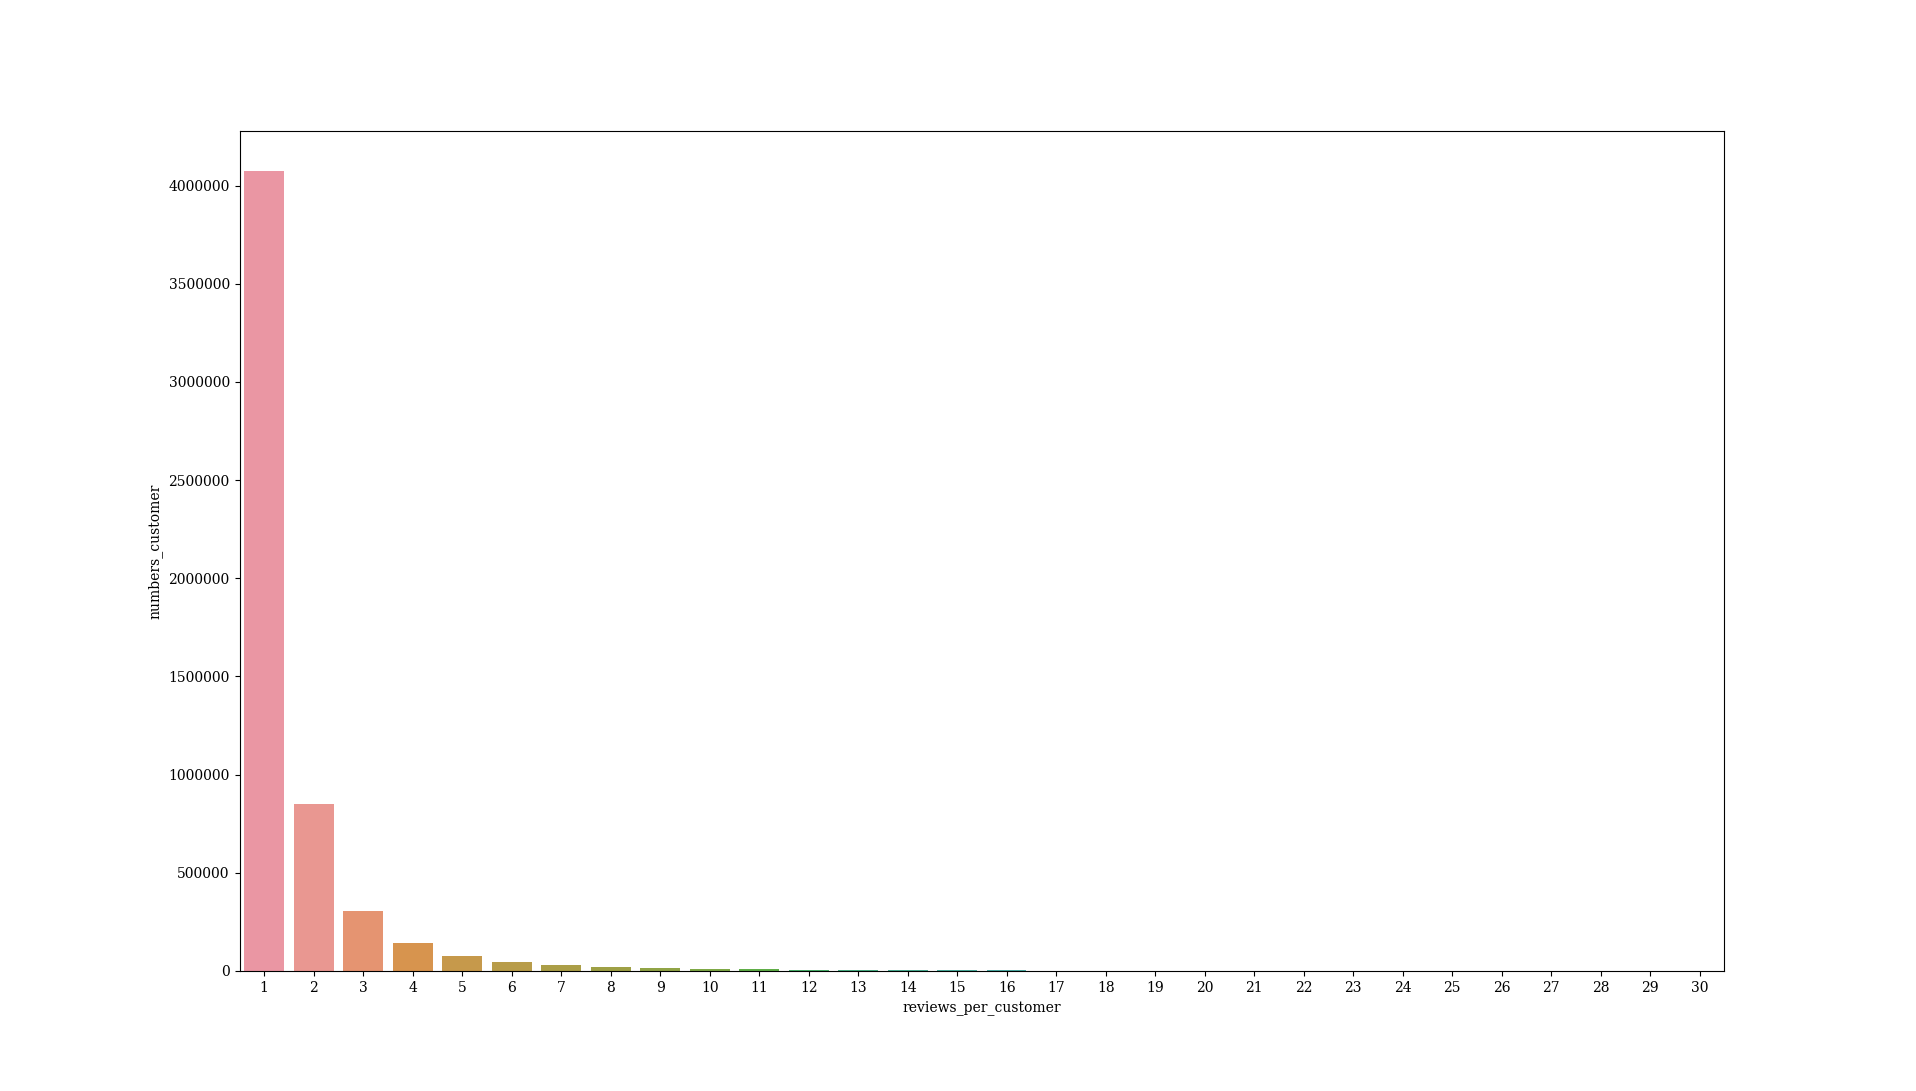
*Numbers of reviews vs Numbers of customer*

You can observe that most customers only leave 1 review, and up to about 5.
Note that this visualization only covers up to customers with 30 reviews, but the maximum number of reviews left by one customer was 3162.
This might indicates that some of the reviews / customers were fraudulent.

### Verifying Customer Reviews

This dataset comes with column `verified_purchase`, which means a customer actually purchased the product from amazon prior to leaving the review.
We will compare the numbers of reviews left by each customer, between verified reviews vs non-verified reviews.

**Verified Reviews**<br>
In the following steps and corresponding line in a cell below, we'll gain average numbers of reviews left per customer for verified purchases only.
1. make essentia data stream in bulk mode
2. filter out verified records only
3. get numbers of reviews left by each customer by counting numbers of unique review_id per customer_id

In [4]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,eok,tsv - -d %cols -filt "verified_purchase == \"Y\"" -c review_id customer_id | \
 aq_cnt -f,+1 - -d S:review_id I:customer_id -g customer_id -k num_reviews review_id'

"customer_id","row","num_reviews"
565563,1,1
52303,1,1
1162122,1,1
108745,1,1
1325068,1,1
515450,1,1
3733178,1,1
5662728,1,1
1117977,3,3
6454258,1,1
1772983,1,1
8556468,1,1
12461968,1,1
5724518,1,1
13397066,1,1
10015518,1,1
10319957,1,1
10409415,1,1
11092682,1,1
11100659,1,1
18301354,1,1
11580132,1,1
12223537,1,1
12601635,1,1
20100768,1,1
13673100,1,1
20251073,1,1
13721934,1,1
21204901,1,1
22160702,1,1
17967803,1,1
22198707,1,1
19608213,1,1
20044670,1,1
20390744,1,1
22829291,2,2
22964510,1,1
24431226,1,1
23342147,1,1
28284310,1,1
23903982,1,1
29663373,1,1
25221713,1,1
30478238,1,1
26437581,1,1
32519904,1,1
27074809,1,1
34997473,1,1
27617649,1,1
35016202,1,1
27777571,1,1
35556393,1,1
28958961,1,1
29456133,1,1
35890584,1,1
30067162,2,2
31194855,1,1
34443666,1,1
34510910,1,1
36598839,1,1
40794597,6,6
39142051,1,1
41873966,1,1
40627480,1,1
40761115,1,1
44825806,1,1
41210815,1,1
42034138,1,1
45317707,1,1
42038451,1,1
43070105,1,1
43215800,1,1
43325137,1,1
43407715,1,1
47487711,1,1
48917982,

23369383,1,1
45802658,1,1
25898652,1,1
27395140,1,1
27627839,1,1
28819601,1,1
45946560,5,5
29938093,1,1
46559443,1,1
30002174,1,1
31179062,1,1
49676890,1,1
49889289,1,1
32497162,1,1
52122559,1,1
36284997,1,1
52529402,1,1
37047630,1,1
38387482,1,1
40086373,1,1
550467,1,1
40357028,1,1
846131,1,1
41261970,1,1
1092397,1,1
1874427,1,1
3087976,1,1
42246236,1,1
3443296,1,1
42942153,1,1
4511666,1,1
43311001,1,1
4966133,1,1
5238132,1,1
5524655,1,1
6910476,1,1
8299374,1,1
9519609,1,1
10354225,1,1
11283457,1,1
44597454,8,8
11319612,1,1
44841456,1,1
12266805,1,1
45217677,1,1
13310572,1,1
45249417,1,1
13713697,1,1
13748238,1,1
13916410,1,1
45938242,1,1
15476108,1,1
16183278,1,1
47255747,1,1
16865434,1,1
47858374,1,1
47985753,1,1
20407139,1,1
49453604,1,1
20510827,1,1
49717548,1,1
50499671,1,1
21014789,4,4
51649162,1,1
22188798,1,1
132282,1,1
213002,1,1
24614010,1,1
727189,1,1
25495764,1,1
1175791,1,1
26713884,1,1
1199657,1,1
1933594,1,1
27933029,2,2
2103335,1,1
2363039,1,1
30603265,1,1
3610151,2,2


49297173,1,1
52761240,1,1
16978843,1,1
52882391,1,1
18364661,1,1
18878333,2,2
53068673,1,1
331912,1,1
20401761,1,1
1702149,1,1
23175597,1,1
1989554,4,4
2391908,1,1
3045685,1,1
23226417,4,4
4247498,1,1
23831323,1,1
5765396,1,1
24285913,1,1
6704658,1,1
24807588,1,1
25484132,1,1
10414005,1,1
25821096,1,1
28375886,1,1
11548125,1,1
28766441,1,1
29083845,1,1
13310298,1,1
29794188,1,1
14587876,1,1
30971644,1,1
15024555,1,1
31682332,1,1
31734070,1,1
19035997,1,1
32354653,2,2
19371986,1,1
32998282,1,1
19952022,1,1
33089646,1,1
22233257,1,1
34131564,1,1
22640897,1,1
38507758,1,1
23761420,1,1
41666726,1,1
42894492,1,1
24087906,2,2
43721955,1,1
44142853,1,1
25059573,1,1
25178739,1,1
44300889,1,1
25396527,1,1
27021914,1,1
45858521,1,1
27324930,2,2
47754074,1,1
27485218,1,1
48091244,1,1
28875042,1,1
48306678,1,1
29098453,1,1
48631197,1,1
32034785,1,1
52040880,1,1
727333,1,1
35099978,1,1
35754139,1,1
1136144,2,2
37965351,1,1
2439957,1,1
38740848,1,1
4192381,1,1
39811647,1,1
4682134,1,1
41803866,1,1
4

33669767,1,1
280113,1,1
885728,1,1
38798846,1,1
1339342,1,1
1452487,1,1
41115962,1,1
2659194,1,1
42935523,1,1
43123866,1,1
6894948,1,1
46412150,1,1
8452526,1,1
47102109,1,1
9993651,1,1
48336469,1,1
11548670,1,1
49224410,1,1
12033142,1,1
50212894,1,1
12035529,2,2
12485545,1,1
52759437,1,1
323959,1,1
410668,1,1
624980,2,2
1194822,1,1
2560454,1,1
13340211,1,1
4916467,1,1
14675413,2,2
9534302,1,1
10293599,1,1
14774364,1,1
12401875,1,1
19879441,1,1
13114084,1,1
23931319,1,1
13969501,1,1
25049894,1,1
28047744,1,1
14797805,1,1
16247446,1,1
28803532,1,1
31060221,1,1
31232091,1,1
16572332,1,1
16934378,1,1
32384484,1,1
17075827,1,1
33193830,1,1
18308418,1,1
19445241,1,1
34041207,1,1
20112289,1,1
35248827,1,1
23944084,1,1
37989514,1,1
24135769,1,1
38046498,1,1
24562120,1,1
38090615,1,1
26652670,1,1
28787893,1,1
41753053,1,1
28861150,1,1
41994214,1,1
32880456,1,1
42423521,1,1
33250346,1,1
34439329,1,1
44974034,1,1
35192802,1,1
35940107,1,1
37249141,1,1
48092895,1,1
39100141,1,1
48170733,1,1
482630

12325527,1,1
12654862,1,1
43160921,1,1
12994628,1,1
43727980,1,1
14309542,1,1
45033477,2,2
14358416,1,1
46161247,1,1
46368853,1,1
14501037,1,1
46586736,1,1
15423272,1,1
47153700,1,1
47192505,1,1
18737920,1,1
47269195,1,1
22203845,1,1
24054987,1,1
25845440,1,1
52432399,1,1
127462,1,1
359469,1,1
27656409,1,1
522763,1,1
28316761,1,1
1260182,1,1
32699209,1,1
4704684,1,1
6003995,1,1
6213291,1,1
36506628,1,1
7049684,1,1
7150629,1,1
9601548,1,1
11097852,1,1
11691653,1,1
11880998,1,1
11945826,1,1
36554325,8,8
13476814,1,1
37057816,2,2
38218486,1,1
38449099,1,1
15539699,1,1
41802022,1,1
42177857,1,1
44297699,2,2
16698151,1,1
44832182,1,1
17013077,1,1
45015282,1,1
18364198,1,1
45911555,2,2
19914622,1,1
22163439,1,1
23291097,1,1
47706456,1,1
48799786,1,1
26122881,1,1
49660849,1,1
26981704,1,1
50524241,1,1
131497,1,1
28031707,1,1
242124,1,1
28583953,1,1
445020,1,1
611351,1,1
1996689,1,1
2789355,1,1
36805130,2,2
6189860,1,1
36955724,1,1
7418224,1,1
8447404,1,1
40998986,1,1
43432689,1,1
44482175,1,1

16205221,1,1
16967303,1,1
13106017,8,8
19757860,1,1
14995078,1,1
15417222,1,1
21262235,1,1
23162981,1,1
23426278,1,1
20171845,1,1
24052060,1,1
20786806,1,1
25252725,1,1
21369146,2,2
21562362,1,1
22279931,1,1
27475204,2,2
22541165,1,1
29275591,1,1
29375591,1,1
23105061,1,1
24775713,1,1
32068372,1,1
32116923,1,1
34899222,1,1
34950550,1,1
28598718,1,1
37000337,1,1
30758631,1,1
31435722,1,1
42031736,1,1
31592366,1,1
42087059,1,1
31902806,1,1
43236393,1,1
33082615,1,1
44457806,1,1
34450728,1,1
45664918,2,2
35371930,1,1
45891844,1,1
46043205,1,1
37062417,1,1
46075929,1,1
37172241,1,1
37465073,1,1
41323172,1,1
48749389,1,1
42023289,1,1
1020324,1,1
1281534,1,1
45232183,1,1
2165696,1,1
2440999,1,1
2447231,1,1
4298129,1,1
47868308,1,1
5252904,1,1
49016844,1,1
6824942,1,1
52430139,1,1
7360347,1,1
52542722,1,1
212263,1,1
10146339,1,1
281926,1,1
10235419,1,1
10718486,1,1
3569200,1,1
3744946,1,1
12352094,1,1
13398163,2,2
13824873,1,1
14592071,1,1
12127584,1,1
12888789,1,1
16969541,1,1
12956202,1,1
1

21593181,7,7
46255420,1,1
46441052,1,1
22328368,1,1
49762023,1,1
50145838,1,1
27034153,1,1
27047882,1,1
52090806,1,1
29092242,1,1
29997335,1,1
30686381,1,1
52736815,1,1
31390837,1,1
32215228,1,1
32823421,1,1
106999,1,1
32981855,1,1
195302,1,1
32988952,1,1
215746,1,1
34967772,1,1
36388661,1,1
1016832,1,1
2531668,1,1
38353057,1,1
3198067,1,1
5176479,1,1
41945065,1,1
42477433,1,1
6988678,1,1
8110122,1,1
43991914,1,1
10791854,1,1
44171493,1,1
10834337,1,1
48371662,1,1
12314229,3,3
12627894,1,1
49847882,1,1
49912139,1,1
14023028,1,1
51571056,1,1
14685333,1,1
52815603,1,1
15571818,1,1
106604,2,2
16684614,1,1
112163,1,1
18557421,1,1
553900,1,1
870504,1,1
19142919,1,1
1512265,1,1
19150003,1,1
1775523,1,1
19962651,1,1
2367398,1,1
23754921,1,1
25532493,1,1
7720603,1,1
7755636,1,1
31517800,1,1
32531261,1,1
10078819,1,1
35932799,1,1
36057273,1,1
11588514,1,1
12639975,1,1
38956048,1,1
42556119,1,1
15382681,1,1
43192865,1,1
15449234,1,1
43221886,1,1
16232534,2,2
43235980,1,1
44922341,1,1
16701042,1,

37667158,1,1
29623116,1,1
39360218,1,1
30225358,1,1
42424296,1,1
30640598,2,2
43654854,1,1
30739734,1,1
49634512,1,1
50163827,1,1
50488307,1,1
33797279,1,1
50766071,1,1
43764621,1,1
51498792,1,1
52036250,1,1
52277167,1,1
50545237,1,1
53084519,1,1
52806442,1,1
106491,1,1
746461,1,1
789734,1,1
1195949,1,1
2530882,1,1
1570699,1,1
7156896,1,1
7846888,1,1
4841959,1,1
8336921,1,1
5073076,1,1
10654406,1,1
6707223,1,1
10885346,3,3
6826688,1,1
11555029,1,1
7817168,1,1
11766238,1,1
10477538,1,1
12892537,1,1
12040884,1,1
14217415,1,1
13564153,1,1
14634807,1,1
15133110,1,1
16584543,1,1
17571939,1,1
21329590,1,1
17285457,1,1
22535771,1,1
23878999,1,1
23901014,1,1
18794974,1,1
19003998,1,1
24919339,1,1
23396189,1,1
24372706,1,1
27865803,1,1
24960116,1,1
27948844,1,1
28826836,1,1
28043687,1,1
32861144,1,1
33037271,1,1
33194706,1,1
36400797,1,1
36937674,1,1
38606437,1,1
40863521,1,1
38494139,1,1
40535169,1,1
41295404,1,1
44897934,1,1
46283031,1,1
49038497,1,1
49668681,1,1
47504272,1,1
50376992,1,1
130

17460123,1,1
23701977,1,1
19650882,1,1
30528736,1,1
17825991,1,1
31657887,1,1
25350381,1,1
27324844,1,1
33546856,1,1
47326535,1,1
28795477,1,1
28473787,1,1
22033053,1,1
30949028,1,1
28582862,1,1
36033043,1,1
50827578,1,1
32915561,1,1
21324867,1,1
23177335,1,1
32930657,1,1
23487602,1,1
33129834,1,1
25867218,2,2
52989611,1,1
37533413,1,1
27721773,1,1
36906340,3,3
33231701,1,1
35750536,1,1
24852759,1,1
106495,1,1
38652717,1,1
131744,1,1
34370755,1,1
39386053,1,1
907460,1,1
39618856,1,1
40294878,1,1
1627741,1,1
35434451,1,1
39754133,1,1
1658286,1,1
41160454,1,1
2094017,1,1
36898210,1,1
44231012,1,1
42963170,1,1
42282974,1,1
38635356,1,1
44348585,1,1
43081212,1,1
33058871,1,1
42847962,1,1
44706666,1,1
43835627,1,1
34652631,1,1
3877973,1,1
44405991,1,1
45145303,1,1
44609058,1,1
38617986,1,1
45008029,1,1
39581225,4,4
46435119,1,1
38813680,1,1
7328230,1,1
40069852,1,1
46879801,2,2
46882634,2,2
43905450,1,1
11369479,1,1
47682289,1,1
44693194,1,1
12356493,1,1
47871084,2,2
46356730,1,1
49806946,1

23541229,1,1
19741623,2,2
24408192,1,1
25451459,1,1
22364156,1,1
22894409,1,1
26585482,1,1
27351892,4,4
28413020,1,1
29663837,1,1
33407547,1,1
31459340,1,1
34246911,1,1
35608040,1,1
38480426,1,1
40705599,1,1
42520098,1,1
40578447,1,1
42681931,1,1
43042802,1,1
43255987,1,1
45052361,1,1
45990233,1,1
46061315,1,1
48395257,1,1
48398592,1,1
45976835,1,1
49100288,1,1
46325215,1,1
49866966,1,1
46828702,1,1
49965870,1,1
50064229,4,4
52087884,1,1
52963292,1,1
108287,1,1
165036,1,1
128087,1,1
1166454,1,1
3745559,1,1
1230379,1,1
3940377,1,1
2086186,1,1
5230148,1,1
2878943,1,1
7850285,1,1
3299584,1,1
8162069,1,1
6844540,1,1
10610861,1,1
6913450,1,1
10754166,1,1
11976717,1,1
7658384,1,1
10528729,1,1
13770489,1,1
12542318,1,1
14125395,1,1
14337204,1,1
14579946,1,1
15501645,1,1
14581252,1,1
16186335,1,1
15957191,1,1
16196107,1,1
16197730,1,1
17894260,1,1
18186681,1,1
18375674,1,1
18950804,1,1
20013184,1,1
21006484,1,1
20671358,1,1
21561463,1,1
21618244,1,1
24238155,1,1
24332028,1,1
24364559,1,1
24538

42424643,1,1
35254861,2,2
36682132,1,1
45296718,1,1
37972942,1,1
47031224,1,1
48196810,1,1
41291540,4,4
51885717,1,1
42622331,3,3
46753048,1,1
47894551,1,1
50494644,1,1
51815600,1,1
51845018,1,1
290991,1,1
570109,1,1
818157,1,1
832591,1,1
1156784,1,1
2759061,1,1
222792,1,1
2992460,7,7
887821,1,1
3486307,1,1
1262402,1,1
4607738,1,1
1803368,1,1
5377616,1,1
6939855,1,1
7537658,1,1
2448894,1,1
4226094,1,1
9907306,1,1
12342298,1,1
9076111,2,2
9770725,1,1
14251050,1,1
10362027,1,1
14692258,1,1
13231239,1,1
13987010,1,1
14099697,1,1
17642828,1,1
15266719,1,1
20412458,1,1
15759941,1,1
16128728,1,1
16361310,1,1
24488216,1,1
18748020,1,1
22339581,1,1
23216682,1,1
23586248,1,1
28991618,1,1
23732434,1,1
26909195,1,1
33823143,1,1
31803923,1,1
33307667,1,1
33503068,1,1
40139871,1,1
38392735,1,1
43737304,1,1
44430238,1,1
45446490,1,1
46312864,1,1
39698266,1,1
42822873,1,1
43987719,1,1
167292,2,2
947067,1,1
1111598,1,1
1185617,1,1
1517697,1,1
2108500,1,1
2195756,1,1
12143624,1,1
13138512,1,1
13826744,

15316313,1,1
15338240,1,1
15600796,1,1
40361909,1,1
17391404,1,1
43891309,1,1
18973315,1,1
44880186,1,1
19405815,1,1
45293974,1,1
48391063,2,2
49101314,1,1
49535864,1,1
109218,1,1
23914809,9,9
125576,1,1
24447955,1,1
25279756,1,1
26188074,1,1
1801031,1,1
27402343,1,1
5166415,1,1
32220395,1,1
39324731,1,1
39369965,1,1
14869685,1,1
14930877,1,1
40194387,1,1
40475915,2,2
17504560,1,1
40653346,1,1
19227011,1,1
42165475,1,1
20280863,1,1
43136409,1,1
21908897,1,1
44086884,3,3
22684294,1,1
45070342,1,1
48832859,1,1
23211418,1,1
48907213,1,1
23633741,1,1
49210405,1,1
25190378,1,1
49263874,1,1
51185443,1,1
51383418,1,1
26989622,1,1
1136853,1,1
33683724,2,2
2002178,1,1
33706226,1,1
5531701,1,1
34608207,1,1
11415754,1,1
35206789,1,1
39212222,1,1
12509344,1,1
39949402,1,1
14587441,1,1
42868379,1,1
14709184,1,1
43674890,1,1
15052923,1,1
44434943,1,1
44476794,1,1
45222461,1,1
15704953,2,2
16455013,1,1
48655524,1,1
18299741,1,1
19120078,1,1
19226588,1,1
20304337,3,3
20340876,1,1
132079,1,1
20504107,1

13642755,1,1
34541679,1,1
16628133,1,1
148429,1,1
35589770,1,1
675974,1,1
6601066,2,2
14235084,1,1
1894083,1,1
6958687,1,1
14407704,1,1
2756720,1,1
7251550,1,1
14536834,1,1
3260205,1,1
8662204,1,1
40102054,1,1
20531126,1,1
3436655,1,1
9274429,1,1
15102619,1,1
41286423,1,1
21464540,1,1
15273738,1,1
22993296,1,1
4638350,1,1
10695784,1,1
25160326,1,1
11267300,1,1
44106875,1,1
27581048,1,1
10213559,1,1
12674285,1,1
44710058,1,1
22563085,22,22
13132681,1,1
35756888,1,1
15705463,5,5
46233616,1,1
23403122,1,1
38494681,1,1
13285075,1,1
25706179,1,1
14171913,1,1
15864231,1,1
15983311,2,2
47610439,1,1
26404322,1,1
39022374,1,1
14502231,1,1
16041074,1,1
17303375,1,1
39170652,1,1
14600253,1,1
16942863,1,1
18659736,1,1
48427337,1,1
29341561,1,1
39233541,1,1
50889624,1,1
29894665,1,1
39461812,1,1
17542921,1,1
22852880,1,1
51054264,1,1
23259148,1,1
52141536,1,1
18919234,1,1
24099956,1,1
135724,1,1
42096193,1,1
19848811,1,1
26476427,1,1
491329,1,1
43526921,1,1
24325797,1,1
21045960,1,1
26919011,1,1
99

11127400,1,1
35204429,1,1
12153173,1,1
36921786,1,1
38377420,1,1
39479623,1,1
39567938,1,1
13869817,2,2
14325995,1,1
42736074,1,1
43254522,1,1
44849501,1,1
18333688,1,1
47394985,1,1
20344986,1,1
25489928,1,1
26499309,1,1
52135551,1,1
32068713,1,1
258630,2,2
33783320,1,1
513438,1,1
36198907,1,1
609374,1,1
37036884,1,1
679053,1,1
2555923,1,1
38020356,1,1
3523643,1,1
38429729,1,1
4576689,1,1
40164554,2,2
41275501,1,1
6758145,1,1
8221017,1,1
43040866,2,2
9975387,1,1
10310130,1,1
43569957,2,2
10739687,1,1
43964476,1,1
44241365,1,1
11298170,1,1
44611197,1,1
11306266,1,1
12734801,1,1
13051639,1,1
45161491,1,1
13779936,1,1
48654077,1,1
49402574,1,1
51904806,1,1
15695252,1,1
51958476,1,1
52688554,1,1
20861664,1,1
52702656,1,1
21200892,1,1
132068,1,1
578672,1,1
3707782,1,1
21224187,5,5
3710338,1,1
4650700,1,1
21568001,1,1
6632758,1,1
22473355,1,1
7146485,1,1
22868198,1,1
9179907,2,2
25156986,1,1
25175685,1,1
12721650,2,2
25703671,1,1
30549616,1,1
13750108,1,1
30575806,1,1
35447561,1,1
18727524,1

45371823,1,1
45387143,1,1
45819950,1,1
45400840,1,1
46622948,1,1
46417020,1,1
46585007,1,1
47144548,1,1
1059182,1,1
1707821,1,1
5636956,1,1
5923141,1,1
7510090,1,1
9908630,1,1
11953067,1,1
12060062,1,1
13048169,1,1
13278425,1,1
49196069,1,1
14116434,1,1
15283297,1,1
15379669,1,1
15875278,1,1
17257173,1,1
17769694,1,1
18466634,1,1
18523945,1,1
49300828,10,10
19882231,1,1
20322705,1,1
22794965,1,1
50562986,1,1
23946102,1,1
306809,1,1
23969554,1,1
806254,1,1
24670349,1,1
1295172,1,1
24680353,1,1
27324505,1,1
2320603,1,1
29914114,1,1
3687123,1,1
4586338,3,3
37835743,1,1
6639948,1,1
40633481,1,1
6823838,1,1
42584946,1,1
8667945,1,1
9392684,1,1
46491355,1,1
10089261,1,1
49595373,1,1
10539027,2,2
50471492,1,1
11827390,1,1
50798141,3,3
51223488,1,1
15846647,1,1
16616467,1,1
51366104,1,1
17181818,1,1
20544258,1,1
22888839,1,1
118078,1,1
25858492,1,1
26134180,2,2
129916,2,2
26214717,1,1
143209,1,1
147923,1,1
421191,1,1
787987,1,1
27304659,1,1
958000,1,1
27555623,1,1
27843379,1,1
28800314,1,1
369

32432639,1,1
34161784,1,1
11487659,1,1
37536528,1,1
13184082,1,1
41321393,1,1
13972734,2,2
43457813,1,1
14683643,1,1
44562213,1,1
44932355,1,1
15701735,1,1
45677669,1,1
16695320,1,1
46339946,1,1
18444467,1,1
46910916,1,1
18618023,1,1
47556730,2,2
18904851,1,1
19464485,1,1
19640508,1,1
50194956,1,1
50762579,1,1
21335875,2,2
52966774,1,1
22109615,1,1
52983794,1,1
23081784,1,1
23634691,1,1
24287204,1,1
410659,1,1
24320311,1,1
880159,1,1
24522586,1,1
1390480,1,1
1921780,1,1
39759755,1,1
4764847,2,2
5897861,1,1
43515725,1,1
9908898,1,1
10916001,1,1
12850931,1,1
14191748,1,1
15327425,1,1
15853661,1,1
19193351,1,1
49967173,1,1
52182175,1,1
117515,1,1
26149268,1,1
242189,1,1
28050308,1,1
508925,1,1
28754550,1,1
980192,1,1
29609703,1,1
2159921,1,1
30044840,1,1
2725703,1,1
32536301,1,1
4694559,1,1
32564633,1,1
8476384,1,1
37090865,1,1
37508968,1,1
12235611,1,1
37761981,1,1
38705809,1,1
13142058,1,1
13275737,1,1
13410100,1,1
42200277,1,1
42206963,1,1
44809300,1,1
45921287,1,1
16205467,1,1
4802472

35837901,1,1
33059837,1,1
36126694,1,1
37954330,1,1
36903130,1,1
36250643,1,1
39733453,1,1
33530190,2,2
36602374,1,1
41721847,1,1
37373859,2,2
45837824,10,10
43179001,1,1
36697906,1,1
34281171,1,1
37988696,1,1
45891231,1,1
36910988,1,1
38692191,1,1
34476297,1,1
38830949,1,1
37474516,1,1
40327553,1,1
46837498,1,1
38313002,1,1
35975719,1,1
41309833,1,1
36166368,1,1
41292717,1,1
45335703,1,1
39660983,1,1
36752484,1,1
41646483,1,1
46195205,1,1
39757793,1,1
39712537,1,1
42414382,1,1
48221681,1,1
46338287,1,1
40073647,1,1
42308022,1,1
43094565,1,1
40213717,1,1
43084414,1,1
45755996,1,1
48500479,1,1
41331558,1,1
44559210,1,1
48284056,1,1
45995305,1,1
49082032,1,1
46410969,3,3
42818610,1,1
46579710,1,1
44872829,1,1
48297144,2,2
45257642,1,1
48054911,1,1
45400576,1,1
50713108,1,1
50305263,2,2
45718478,1,1
50428388,1,1
51028737,1,1
49791003,1,1
51039925,1,1
49228991,1,1
52046764,1,1
52702305,1,1
49382421,1,1
156081,1,1
52957517,1,1
52919669,1,1
52665773,1,1
228056,1,1
423849,1,1
242419,1,1
10677

1064412,1,1
1074681,1,1
1183899,1,1
16790733,2,2
1294646,1,1
1510087,1,1
1661290,1,1
3698231,1,1
17597988,1,1
3832905,1,1
4352499,1,1
6072125,1,1
8444615,1,1
9557591,1,1
21018905,1,1
24066326,1,1
13262130,1,1
24121328,1,1
13648391,1,1
14594290,1,1
27323976,1,1
30173524,2,2
31227730,1,1
31762813,1,1
21077393,1,1
35826504,1,1
21470576,1,1
36180796,1,1
21746899,1,1
37036032,1,1
22581694,1,1
38561148,1,1
23337966,1,1
39070587,1,1
23638129,1,1
40664718,1,1
26244547,1,1
41041991,1,1
27541622,1,1
42351334,1,1
28632143,1,1
44434869,1,1
44860364,1,1
45073066,1,1
34149516,1,1
35129819,1,1
45998844,1,1
36246547,1,1
46182527,1,1
38146347,1,1
50190827,1,1
51004007,1,1
38831190,1,1
51157507,1,1
51957135,1,1
42869105,1,1
45031199,1,1
145034,1,1
47339982,1,1
47768350,1,1
10611365,1,1
48640127,1,1
48902678,1,1
13083634,1,1
51633126,1,1
13562865,1,1
13911144,1,1
14338970,1,1
53075111,1,1
14830835,1,1
110276,1,1
16174862,1,1
594297,1,1
17624056,1,1
629707,1,1
18843925,1,1
925907,1,1
1187571,1,1
22261591,

4169969,1,1
8141303,1,1
5992124,1,1
9231657,1,1
10116739,1,1
6434744,1,1
12350301,1,1
8635152,1,1
13556287,1,1
13758529,1,1
9643223,1,1
14226210,1,1
9856580,1,1
10245465,1,1
11359457,1,1
17784594,1,1
11438060,1,1
18010653,1,1
12284856,1,1
12617276,1,1
12834768,1,1
19126031,1,1
19387186,1,1
14762384,1,1
19985315,1,1
15910290,1,1
20390538,1,1
16117355,1,1
16162427,1,1
16277682,1,1
21756591,1,1
17128830,1,1
21798880,1,1
18729331,1,1
22773579,1,1
19509317,1,1
23156045,1,1
20577542,1,1
23549419,1,1
20698904,1,1
24270588,1,1
20854934,1,1
24727014,2,2
21222817,1,1
26015140,1,1
21393695,1,1
26928760,1,1
23371097,1,1
23392189,1,1
27024294,1,1
23845609,1,1
27100624,1,1
24011321,1,1
27468563,1,1
27691262,1,1
29455360,1,1
27833103,1,1
30875491,1,1
34779926,1,1
35372599,1,1
36431874,1,1
38045302,1,1
36091984,2,2
38645342,1,1
36288889,1,1
40547715,1,1
38119459,1,1
42242994,1,1
38246335,1,1
43370719,1,1
44829490,1,1
45098531,1,1
45365437,1,1
40584990,1,1
40837915,1,1
46960592,1,1
41459796,1,1
4217829

39171123,1,1
3892491,1,1
40285688,1,1
41322018,1,1
5528771,1,1
41812211,1,1
42603879,1,1
6306884,2,2
6598098,1,1
6796646,1,1
45163747,1,1
10839914,1,1
46393207,1,1
46718016,1,1
48159761,1,1
11339267,2,2
11906622,1,1
49291651,1,1
49880111,1,1
12408571,1,1
12469496,1,1
12939409,1,1
50868315,1,1
13151063,1,1
51137797,1,1
13358682,1,1
13953507,1,1
14081047,1,1
14490800,1,1
53038420,1,1
14807677,1,1
112057,1,1
15048480,1,1
578678,1,1
15059339,1,1
15069167,1,1
1156442,3,3
1560841,1,1
1919367,1,1
15174458,1,1
2618574,1,1
2899323,1,1
15823777,1,1
16844127,1,1
17589681,1,1
8155527,1,1
17875167,1,1
17876895,1,1
17942127,1,1
17985977,1,1
12329726,1,1
18205556,1,1
18249326,1,1
12792187,1,1
19241317,1,1
19362316,1,1
20201653,1,1
13804968,1,1
20241108,1,1
15290082,1,1
15482364,1,1
21030970,1,1
18899556,1,1
19643623,1,1
24523121,1,1
20075345,1,1
25152014,1,1
25411925,1,1
23319359,1,1
25704473,1,1
23368812,1,1
27955669,1,1
24358442,1,1
29182494,1,1
24494527,1,1
24497493,1,1
32816640,1,1
33568360,1,1
2

3106766,1,1
17281564,1,1
17845890,1,1
4068128,1,1
18186050,1,1
6570781,1,1
19770668,1,1
21278711,1,1
21321286,1,1
21467741,1,1
8988045,1,1
22822542,1,1
23225164,1,1
11607627,1,1
23497749,1,1
11623356,1,1
25141359,1,1
11652283,1,1
25496277,1,1
12708453,2,2
25821618,1,1
26368463,1,1
26397427,1,1
26468463,1,1
13433385,1,1
27801774,1,1
13740419,1,1
29204148,1,1
13806261,1,1
14216796,1,1
14354680,1,1
31800507,1,1
16288648,1,1
17104242,1,1
33381299,2,2
17119628,1,1
33588864,1,1
18329423,1,1
34254537,1,1
21827757,1,1
38003089,1,1
21987356,1,1
39152163,1,1
22741037,1,1
25355396,1,1
40448202,1,1
25620970,1,1
26367590,1,1
26743674,1,1
41108669,1,1
27062360,1,1
28121709,1,1
42115787,2,2
28871428,1,1
43870827,1,1
43890641,1,1
30136809,1,1
44221487,1,1
44771078,1,1
45175344,1,1
32148972,1,1
46173430,1,1
32830723,1,1
47659694,1,1
48648687,1,1
33210383,2,2
49141840,1,1
33310136,1,1
50436842,1,1
36884786,1,1
51059052,1,1
37986611,1,1
51276647,2,2
41455401,1,1
51299218,1,1
43718568,1,1
51921599,1,1
439

10913086,1,1
33377769,1,1
38749533,1,1
33976809,1,1
38875484,1,1
12213462,1,1
34162009,1,1
12962232,1,1
34718288,1,1
13418870,1,1
41432269,1,1
13494266,1,1
40205087,1,1
13859574,1,1
42290490,1,1
42416445,1,1
13937243,1,1
42659748,1,1
43089428,1,1
43796020,1,1
14067685,1,1
43175391,1,1
43482693,1,1
43666571,1,1
45828277,1,1
15042784,1,1
16010354,1,1
44161259,1,1
45973863,2,2
45128673,1,1
44490598,1,1
47701056,1,1
44997324,1,1
48142327,1,1
17467144,1,1
46805242,1,1
18105657,1,1
45147208,1,1
18434532,1,1
47473211,1,1
45343114,1,1
48039889,1,1
49857600,1,1
50131467,1,1
51252289,1,1
19859110,1,1
52150500,1,1
47226000,1,1
20620181,1,1
52163469,1,1
47588732,1,1
51749680,2,2
120661,1,1
184846,1,1
49121733,1,1
118289,1,1
191435,1,1
21693642,1,1
416372,1,1
951497,1,1
525540,1,1
52069305,1,1
22910631,1,1
585017,1,1
52444821,1,1
23380618,1,1
52457514,1,1
1940309,1,1
23659231,1,1
1554603,1,1
1607853,1,1
4204074,1,1
24389732,1,1
1658161,1,1
4636390,1,1
25033632,1,1
590662,1,1
7064837,1,1
25475992,1,

48753287,1,1
26915457,1,1
49408328,1,1
27569777,1,1
27828507,1,1
51376296,1,1
51422383,1,1
28871184,1,1
108593,1,1
424805,1,1
701327,1,1
33080454,1,1
33247443,1,1
33354010,1,1
34449323,1,1
1508989,1,1
2544260,1,1
36165706,1,1
36569160,1,1
3112103,4,4
37414007,2,2
3131659,1,1
38131724,1,1
39908915,1,1
6135209,1,1
41292248,1,1
6717168,1,1
41358717,1,1
42008748,1,1
8688315,1,1
10343473,1,1
42375694,2,2
42506030,1,1
42826745,1,1
13861098,1,1
13910117,1,1
13934780,1,1
45625383,1,1
14016818,1,1
45902543,1,1
14221079,1,1
46519514,1,1
14786342,1,1
47073212,1,1
15046485,1,1
47941653,1,1
16055178,1,1
48458727,1,1
16777166,1,1
49419682,1,1
17237464,1,1
49568628,1,1
17290967,1,1
50217805,1,1
18035563,1,1
50531670,1,1
19474348,1,1
51589080,1,1
20134443,1,1
51903508,1,1
20226711,1,1
75353,1,1
20852555,1,1
107583,1,1
22243740,1,1
224450,1,1
338684,1,1
22920632,1,1
404977,1,1
23197594,1,1
660163,1,1
26586013,1,1
1153030,1,1
27238137,1,1
1161933,1,1
28304035,1,1
1630043,1,1
28351566,1,1
1896769,1,1
285

29212260,1,1
52306282,1,1
52797739,1,1
52810899,1,1
32881083,1,1
34123809,1,1
36076929,2,2
147710,1,1
293486,1,1
37549253,1,1
554710,1,1
37578612,1,1
641812,1,1
38842415,1,1
697595,1,1
40300000,1,1
1766321,1,1
42123303,1,1
43520161,1,1
2084868,1,1
44076466,1,1
2114211,1,1
44893761,1,1
6172860,1,1
45949254,1,1
7010749,1,1
46952352,1,1
47022865,1,1
48616235,1,1
50814082,1,1
7210906,8,8
7453412,1,1
51461247,1,1
7644289,1,1
9986506,1,1
52594976,1,1
52700147,1,1
10141434,1,1
52803845,1,1
10492860,1,1
10601457,1,1
463912,1,1
11247154,1,1
791690,1,1
1682649,1,1
12390721,1,1
2552677,1,1
13324104,1,1
5478942,1,1
7819805,1,1
14896036,1,1
9643572,2,2
15172092,1,1
10105981,1,1
15294639,1,1
10239236,1,1
15915427,1,1
15995163,1,1
16715074,1,1
10939882,3,3
16908652,1,1
11311065,1,1
20272683,1,1
12343359,1,1
13055091,1,1
21017119,1,1
13692883,1,1
22129438,1,1
14178993,1,1
24095958,1,1
14372251,1,1
14472664,1,1
25805959,1,1
27316055,1,1
28374430,1,1
17177052,1,1
29043270,1,1
19007895,1,1
21207989,1,1
3

47927398,1,1
48304879,1,1
10872358,1,1
48327591,1,1
48655989,1,1
10957208,2,2
48769049,1,1
49682488,1,1
11760418,1,1
11941895,1,1
12529945,1,1
97392,1,1
116394,1,1
118164,1,1
13080188,1,1
572657,1,1
13151091,1,1
838272,1,1
13936763,1,1
840599,1,1
1016780,1,1
1646899,1,1
15243734,1,1
2147795,1,1
15345096,1,1
2360878,1,1
15360634,1,1
2495224,1,1
3352835,1,1
17998648,1,1
18235493,1,1
18799207,1,1
21414596,1,1
6862936,1,1
7429562,1,1
21439076,1,1
21515778,1,1
10893695,1,1
21730401,1,1
21735021,1,1
22732743,1,1
25998928,1,1
26584660,1,1
13135305,1,1
26723576,1,1
27754632,1,1
15053598,1,1
28077792,1,1
15513432,1,1
28217976,1,1
16340055,1,1
16814537,1,1
30209887,1,1
30805163,1,1
19500467,1,1
19807193,1,1
33354935,1,1
21727638,1,1
34275986,1,1
34536702,1,1
23237335,1,1
34771521,1,1
25138043,1,1
36812655,1,1
25438177,1,1
25726682,1,1
26144449,1,1
37948565,1,1
27593517,1,1
29519186,1,1
39491959,1,1
29574059,1,1
39534044,1,1
30782023,1,1
40448391,1,1
30791552,1,1
40595170,1,1
31276530,1,1
4066054

29315446,1,1
35140546,1,1
12514125,1,1
13104097,1,1
43259849,1,1
15096628,1,1
46571401,1,1
17119462,1,1
48377200,1,1
18621490,1,1
25890205,1,1
51823124,1,1
200283,1,1
34157598,2,2
1389678,1,1
2713848,3,3
34811987,4,4
2847811,1,1
4250265,1,1
45483830,1,1
4661235,1,1
49406260,1,1
10768819,1,1
50883958,1,1
223554,1,1
11470432,1,1
1714938,1,1
12558490,1,1
1992645,1,1
2074625,1,1
3479361,1,1
3905777,1,1
12950052,3,3
7146254,1,1
13918983,1,1
7560374,1,1
8436295,1,1
15337089,1,1
8981160,1,1
15931044,1,1
17242578,1,1
11648510,1,1
18513774,1,1
19018101,1,1
14758449,1,1
15284566,1,1
21938157,1,1
20120796,1,1
23367397,1,1
24341411,1,1
24665486,1,1
22587588,1,1
22755663,1,1
30437890,1,1
24123115,1,1
31895083,2,2
26900987,1,1
40562891,1,1
42482774,1,1
44366087,1,1
47829881,1,1
30887432,1,1
32205219,1,1
355960,1,1
34361281,1,1
6401616,1,1
11855846,1,1
37575636,1,1
12223936,1,1
40494775,1,1
41115029,1,1
19153734,1,1
41582091,1,1
21911303,1,1
42735983,1,1
22768687,1,1
43235497,1,1
24119505,1,1
4435988

36153431,1,1
31358331,1,1
13376598,1,1
41699698,1,1
44601979,1,1
43559697,1,1
45573189,1,1
44142777,1,1
45266083,2,2
44363423,1,1
46372549,1,1
48175703,1,1
45651059,1,1
45472720,1,1
47789179,1,1
46772362,1,1
21468997,1,1
48545499,1,1
49757758,1,1
23556063,1,1
48926240,1,1
49502980,1,1
49795655,2,2
50759520,1,1
23793724,1,1
47096799,1,1
51010048,1,1
51090496,1,1
51741464,1,1
25294778,1,1
51122672,1,1
52295157,1,1
52000671,1,1
25504862,1,1
1521971,1,1
27979576,1,1
10105345,1,1
30968035,1,1
13801497,1,1
16349000,1,1
16520662,1,1
35703047,1,1
17093168,3,3
19048223,1,1
20584444,1,1
39790506,1,1
29496244,1,1
31480303,1,1
44023207,1,1
34490140,1,1
44461576,1,1
37869706,1,1
44467411,1,1
46439264,1,1
42886278,4,4
51142164,2,2
44401355,1,1
51917467,1,1
44830839,1,1
52661528,1,1
45173845,1,1
53020793,1,1
46264188,1,1
334659,1,1
52603554,1,1
882979,1,1
6515491,1,1
6202245,1,1
7674687,3,3
13579265,1,1
9283322,4,4
14861159,1,1
16383780,1,1
17117523,1,1
10426480,2,2
10613212,1,1
10623783,1,1
22665555

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47425262,1,1
24129762,1,1
48237565,1,1
48388356,1,1
25903779,1,1
29621582,1,1
22090134,3,3
22233161,1,1
51118679,1,1
269709,1,1
13251625,12,12
25908532,1,1
14295659,1,1
11182674,1,1
11418181,1,1
39256359,1,1
11751425,1,1
40310891,2,2
17714417,1,1
12136137,1,1
40781682,1,1
27131396,6,6
13042807,1,1
41095190,1,1
18770174,1,1
14692797,1,1
18975363,1,1
15236023,1,1
20207860,1,1
18975731,1,1
45318308,1,1
38600212,1,1
21226514,1,1
47989094,1,1
22275075,1,1
22445423,1,1
44118061,1,1
23640356,1,1
50526301,1,1
23588035,1,1
30671233,1,1
25060023,1,1
31498465,1,1
3487391,1,1
25505464,1,1
3595088,1,1
29846928,1,1
5075449,1,1
5780805,1,1
44791314,1,1
39296091,1,1
10648559,1,1
46163084,1,1
36864035,1,1
46805500,1,1
11846094,1,1
41028854,3,3
14614427,1,1
2004922,1,1
46820497,1,1
41394394,1,1
39814916,1,1
7140452,1,1
45622314,1,1
7334089,1,1
49291842,1,1
17025521,1,1
42435461,1,1
10759902,1,1
139452,1,1
42911472,1,1
11905672,1,1
153624,1,1
232175,1,1
47526904,2,2
44914526,1,1
47622859,1,1
14202112,1,1

12076303,1,1
15414409,2,2
18034546,1,1
18617771,1,1
19358249,1,1
19627099,1,1
33487285,8,8
20499406,1,1
34936195,2,2
21610297,1,1
37973971,1,1
42393901,1,1
42532372,1,1
44120453,1,1
24736806,1,1
46358963,1,1
31496983,1,1
47089190,1,1
32655549,1,1
33790923,1,1
49510289,1,1
35016885,1,1
150807,1,1
35599692,1,1
230965,1,1
35603701,1,1
686751,1,1
1467381,1,1
40423520,1,1
1736807,1,1
41469748,1,1
43164295,1,1
2533557,1,1
44533358,1,1
2911024,1,1
8641267,1,1
45811645,1,1
10683065,1,1
146085,1,1
11809198,1,1
258705,1,1
11987147,1,1
556489,1,1
826179,1,1
13404887,1,1
18496550,1,1
9878669,1,1
9899363,1,1
21195113,3,3
21257814,1,1
21358301,1,1
10464038,1,1
21808442,1,1
11358988,1,1
26057948,1,1
28314833,1,1
13344904,1,1
13585716,1,1
13754110,1,1
33654560,1,1
34389855,1,1
14460342,3,3
36048367,2,2
15657209,1,1
15818242,1,1
16918019,1,1
40145739,1,1
18287151,1,1
43329535,1,1
44975967,1,1
19410767,1,1
46630842,1,1
46791100,1,1
22120771,1,1
24828572,1,1
50936665,1,1
115611,1,1
41184937,1,1
854350,1,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4036028,1,1
5452865,1,1
7974570,1,1
16632529,1,1
10060695,1,1
18173981,1,1
10767671,1,1
11522212,1,1
22135441,1,1
23064830,1,1
23161212,1,1
12122854,1,1
23712156,1,1
24601592,3,3
27166242,1,1
27586821,1,1
28544986,1,1
29493552,1,1
30095747,1,1
14759768,1,1
16116725,1,1
33034178,1,1
16449008,1,1
34480787,1,1
17027437,1,1
19849362,1,1
24427197,1,1
38325300,1,1
26608631,1,1
38342766,1,1
29427385,1,1
29908310,1,1
40118296,1,1
30754240,1,1
41353454,1,1
43088651,1,1
43147551,1,1
43976564,1,1
45410159,1,1
39908038,1,1
46989167,1,1
41622128,1,1
47053606,1,1
47169179,1,1
42208550,2,2
48580309,1,1
46040371,1,1
50275251,1,1
50408519,1,1
50550467,1,1
47335601,2,2
51714601,1,1
47855986,1,1
108376,1,1
125225,1,1
49082806,1,1
154949,1,1
49473750,1,1
176359,1,1
1173470,1,1
51513645,1,1
3115217,1,1
3202058,1,1
5324057,1,1
5469274,1,1
220959,1,1
6017925,1,1
6524027,1,1
1290817,1,1
6730486,1,1
1873366,1,1
10967297,1,1
11215499,1,1
10029084,1,1
11306146,1,1
12061039,1,1
12329731,1,1
12118197,1,1
13047610,

19060700,1,1
28426557,1,1
47289033,1,1
22240798,1,1
27459714,1,1
28952618,1,1
25526808,1,1
23463571,1,1
28231202,1,1
23871014,1,1
24564992,1,1
25990083,1,1
49364969,1,1
24557305,1,1
25079296,1,1
32193018,1,1
27494072,1,1
24792808,1,1
27835116,1,1
29352023,3,3
25288268,1,1
35881653,1,1
51584574,2,2
29226316,1,1
38862980,1,1
30679775,1,1
26052386,2,2
29250200,1,1
39416911,1,1
39742550,1,1
32476577,1,1
28842176,1,1
29856514,1,1
40633816,1,1
32001249,1,1
33580901,1,1
30776504,1,1
164177,1,1
35740368,1,1
30475509,1,1
34219790,1,1
1282746,1,1
35761814,1,1
31927793,1,1
36569011,1,1
33426305,1,1
42775233,2,2
4430619,2,2
38055904,1,1
34698707,1,1
43036626,1,1
36258563,1,1
38092796,1,1
37525740,1,1
5975443,2,2
38172777,1,1
41319430,1,1
6799108,1,1
37808016,1,1
44890925,1,1
41916731,1,1
7436514,1,1
38463011,1,1
43028790,1,1
42019828,1,1
39781619,1,1
42204517,1,1
41837697,1,1
46084899,1,1
43905910,1,1
11162443,1,1
11255756,1,1
46796200,1,1
44937972,1,1
43430551,1,1
47574610,1,1
11873664,1,1
443488

10785501,1,1
11192371,1,1
13172638,1,1
13718014,1,1
42816013,1,1
13959792,1,1
43588904,1,1
14329237,1,1
44171873,1,1
15645833,1,1
15842805,1,1
45833041,1,1
15847392,1,1
46319413,1,1
17355195,1,1
18790874,1,1
46526215,5,5
47167824,1,1
22414241,1,1
48453749,1,1
22532783,1,1
48595737,1,1
49109297,1,1
25940324,1,1
49310541,3,3
28409099,1,1
49480084,1,1
51306740,2,2
30471065,1,1
52462109,1,1
35434109,1,1
52801434,1,1
36394138,1,1
52993339,1,1
37099437,1,1
179876,1,1
1440647,1,1
1553634,1,1
2133157,1,1
41301364,1,1
2361747,1,1
41329549,1,1
2665405,1,1
41618270,1,1
5142073,1,1
8515561,1,1
43148202,1,1
8602064,1,1
9874185,1,1
45151077,1,1
10027645,1,1
10131345,1,1
45713987,2,2
10225719,2,2
10840926,1,1
47670211,1,1
10926760,1,1
48622356,1,1
11282268,1,1
49175156,1,1
11586287,1,1
50885352,1,1
112295,1,1
1272771,1,1
14278049,1,1
1282215,1,1
14682431,1,1
15646493,1,1
4107266,1,1
5623814,1,1
17039652,1,1
6890923,1,1
19494194,1,1
22121977,1,1
22172669,1,1
10490556,1,1
24190154,1,1
11085924,1,1
2524

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47870637,1,1
2174261,1,1
2803990,1,1
50995994,1,1
2969848,1,1
1073140,1,1
52466586,1,1
5364425,1,1
1353166,2,2
11695338,1,1
12148908,1,1
3460267,1,1
799832,1,1
18119519,1,1
12638925,1,1
10293543,1,1
13244788,1,1
10462638,1,1
18882694,3,3
13980585,1,1
4317285,1,1
19370031,1,1
12547255,1,1
4786931,1,1
13829987,1,1
5954747,1,1
14050632,1,1
24548150,1,1
9346567,1,1
25306093,1,1
25784220,1,1
15028220,1,1
26114716,1,1
30876439,1,1
28118602,1,1
14222572,1,1
41303031,1,1
34117002,1,1
51285623,1,1
41943084,1,1
44464280,1,1
44545832,1,1
46234014,1,1
2578608,2,2
3916930,1,1
4799569,1,1
6838936,1,1
7520023,1,1
8174493,1,1
51287986,1,1
10459003,1,1
51328840,1,1
52640797,1,1
192439,1,1
12556578,1,1
13967124,1,1
844146,1,1
18244246,1,1
2959151,1,1
3605960,1,1
19652020,2,2
4384160,1,1
19656604,1,1
20404185,1,1
21548619,1,1
7850543,1,1
10850127,1,1
17492160,1,1
17873594,1,1
23781746,9,9
24308635,1,1
27789589,1,1
29725062,1,1
31597691,1,1
20263656,2,2
20528760,1,1
20893975,1,1
40418391,1,1
41445044,1,1


37355497,1,1
37147332,1,1
38046763,1,1
47273251,1,1
44706595,1,1
39633739,1,1
45574279,1,1
39752213,1,1
48435191,1,1
49035127,1,1
48144085,1,1
40415635,2,2
50192294,1,1
39827798,3,3
40493893,1,1
50800064,1,1
48494392,1,1
41595483,1,1
40508209,1,1
51233122,1,1
42417098,1,1
50972342,1,1
43254769,1,1
42754096,1,1
43584861,1,1
52499659,1,1
43530534,1,1
38576,1,1
78510,1,1
46436770,1,1
51380674,3,3
46839278,1,1
2736170,1,1
51619671,2,2
4641462,1,1
47149223,1,1
48829908,1,1
47245557,1,1
49556580,1,1
5082261,1,1
227535,1,1
5318381,1,1
47793617,1,1
8441906,1,1
49077029,1,1
9060372,1,1
1845028,1,1
49513806,1,1
2094681,1,1
49913434,1,1
50502388,1,1
10901020,1,1
2217702,1,1
50688191,1,1
11398744,1,1
50242129,1,1
11557997,1,1
3146982,1,1
51117218,1,1
3565073,1,1
51237228,2,2
3998655,1,1
52559098,1,1
14584012,1,1
4768994,1,1
160044,1,1
224069,1,1
14750027,1,1
7198327,1,1
430493,1,1
276933,1,1
14935473,1,1
1075191,1,1
279018,1,1
2261426,1,1
17162410,1,1
2341861,1,1
17764672,1,1
2407263,1,1
1866644,1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19624749,1,1
315961,1,1
407208,1,1
807305,1,1
1265751,1,1
20314662,1,1
2997047,1,1
24317453,1,1
3809162,2,2
4527285,1,1
29044759,1,1
31315267,1,1
6401012,2,2
6483295,1,1
32645118,1,1
7114669,1,1
34989215,1,1
9524880,1,1
37357350,2,2
38637384,1,1
42570524,1,1
43537859,1,1
43918489,1,1
9992786,7,7
44987828,1,1
10366254,2,2
11078213,1,1
11528364,1,1
47231193,3,3
47304025,1,1
49910645,1,1
50100549,1,1
51821140,1,1
14474061,1,1
14547309,1,1
133950,1,1
14871444,1,1
168754,1,1
15111659,1,1
16003944,1,1
663283,2,2
17697252,1,1
1178029,1,1
1267763,1,1
19386660,1,1
1664799,1,1
2075854,1,1
20327938,1,1
2499309,1,1
21685551,1,1
2910904,1,1
23549733,1,1
3747513,1,1
25460868,1,1
4403830,1,1
26188409,1,1
26420917,1,1
27039653,1,1
28634161,1,1
29174987,2,2
10603774,3,3
29644590,1,1
36241217,1,1
36682580,1,1
11676289,2,2
12903248,1,1
13609666,1,1
40237282,1,1
13889133,1,1
14358967,1,1
44472876,1,1
14561661,1,1
16461123,1,1
45888565,1,1
22549037,1,1
22783616,2,2
46865013,1,1
27342723,1,1
47174396,1,1
28

8545778,1,1
8683419,1,1
3767948,3,3
6384391,1,1
11935995,1,1
8175786,1,1
12276309,1,1
12456907,1,1
9852304,1,1
13134468,1,1
9930592,1,1
10180884,1,1
10525318,1,1
14731803,1,1
11762957,1,1
14778135,1,1
11857484,1,1
15139777,1,1
11973378,1,1
12329856,1,1
17802813,1,1
13308855,1,1
14041510,1,1
20951592,1,1
21101857,1,1
22642003,1,1
20320367,1,1
22856154,1,1
20847269,1,1
25161769,1,1
21958592,1,1
27067127,1,1
22618969,1,1
29815013,1,1
24041912,1,1
32200200,1,1
24069085,1,1
32436650,1,1
33205781,1,1
27080679,1,1
35132790,1,1
27481213,2,2
28068833,1,1
36777625,1,1
31142948,1,1
35787501,1,1
39168108,1,1
36515973,1,1
37216249,1,1
42232956,1,1
43217869,1,1
38979194,3,3
43392369,2,2
43920892,1,1
44135894,1,1
42791013,1,1
44223838,1,1
44295881,1,1
45260621,1,1
44535702,1,1
45400208,2,2
46388895,1,1
47064791,1,1
49808744,3,3
49028699,1,1
51058621,1,1
52617477,1,1
121840,1,1
184169,1,1
51745068,1,1
642003,1,1
52859577,1,1
1719190,1,1
532349,1,1
1722302,1,1
3385231,1,1
4895886,1,1
2873655,1,1
576481

11401135,1,1
11494305,1,1
45672724,1,1
11608747,1,1
11917429,1,1
12121032,1,1
47055294,1,1
13180807,1,1
47575628,1,1
13197626,1,1
13737547,1,1
48616470,1,1
13834258,1,1
14823668,1,1
16176871,1,1
20936429,1,1
50274353,1,1
23342964,1,1
50531479,2,2
24309542,1,1
50745919,1,1
25858902,1,1
52825228,1,1
52998926,1,1
29062326,1,1
53006469,1,1
115719,1,1
29630835,1,1
1267945,1,1
29723585,1,1
30076065,1,1
31131844,1,1
31150694,1,1
1889256,1,1
2631676,1,1
32741003,1,1
2654570,1,1
32986513,1,1
3720007,1,1
34412994,1,1
4423055,1,1
36411862,1,1
36698731,1,1
37492289,1,1
5729490,1,1
37703617,1,1
6176077,1,1
39248628,1,1
40703395,1,1
41897969,1,1
7807296,1,1
41999651,1,1
8045265,1,1
42013408,1,1
8270913,1,1
42499678,1,1
10584752,1,1
10922166,1,1
45097349,1,1
12999707,1,1
14285218,1,1
46885000,1,1
14676514,1,1
47684279,1,1
15047598,1,1
47831517,1,1
15136258,1,1
48408205,1,1
15328890,1,1
48878514,1,1
15741203,1,1
49050022,1,1
50032144,1,1
52771818,1,1
19201068,3,3
481803,1,1
19645578,1,1
485619,1,1
773

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2588185,1,1
10464826,1,1
10650321,1,1
4584078,1,1
6476521,1,1
12990130,1,1
13604937,1,1
9998803,1,1
10789929,1,1
13663203,2,2
13908753,1,1
13170181,1,1
13883837,1,1
14138344,1,1
17209186,3,3
19500168,1,1
20046920,1,1
21226078,1,1
14809063,1,1
21787438,1,1
15470319,1,1
22445303,1,1
15958823,1,1
23285486,1,1
23932152,1,1
17417671,1,1
18218130,1,1
19569005,2,2
26815734,1,1
20290246,1,1
29070425,1,1
23339710,1,1
23488734,1,1
30920627,1,1
24574674,1,1
25563280,1,1
26530280,1,1
26765150,1,1
29893480,1,1
30497889,1,1
33593701,1,1
31153718,1,1
32094085,1,1
35953774,1,1
36745876,1,1
34813810,1,1
41092905,3,3
42070728,1,1
42260397,1,1
37515294,1,1
43349332,1,1
42759857,1,1
43466244,1,1
45052895,1,1
46388979,1,1
47929981,1,1
48707230,1,1
48178576,1,1
51010677,1,1
50419501,1,1
52629178,1,1
52640174,1,1
642534,1,1
4380759,1,1
7081200,1,1
7478284,1,1
160542,1,1
169219,1,1
1513684,1,1
10971930,2,2
2816311,1,1
11572400,1,1
4986706,1,1
11788992,1,1
5150998,1,1
6090797,1,1
6305256,1,1
13630532,1,1
74075

47194178,1,1
12967069,1,1
13203176,1,1
14126090,1,1
49935311,1,1
14612654,1,1
52537486,1,1
15945942,1,1
17039432,1,1
172670,2,2
19037337,1,1
386843,1,1
19557242,1,1
630102,1,1
19850419,1,1
1109994,1,1
20655610,1,1
22241241,1,1
1697976,2,2
25620698,1,1
2083653,1,1
25628401,1,1
2605239,1,1
26136892,1,1
27773901,1,1
5236640,2,2
27852202,1,1
6969866,1,1
7094776,1,1
29354806,1,1
31540803,1,1
8993807,1,1
10191158,1,1
10466822,1,1
31740077,2,2
32305577,1,1
11895509,1,1
11956353,1,1
12276197,2,2
12621090,1,1
12883413,1,1
42488914,1,1
14352635,1,1
42768849,1,1
43115819,1,1
18499470,1,1
44428407,1,1
19361668,1,1
45960205,1,1
20162872,1,1
45978357,1,1
20572872,1,1
47090430,1,1
20704784,1,1
47772206,1,1
20832211,1,1
48972467,1,1
22507919,1,1
23047194,1,1
50393285,1,1
50699177,1,1
27572678,1,1
27920951,1,1
30915150,3,3
191507,1,1
296028,1,1
34270303,1,1
416259,1,1
34382746,1,1
744014,1,1
34429909,1,1
992766,1,1
34673881,1,1
1246294,1,1
35973534,1,1
37099921,1,1
1425303,2,2
1940306,1,1
2548184,2,2
4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9840295,1,1
9947181,1,1
12286040,1,1
10492795,1,1
11267576,1,1
12909039,1,1
12211357,1,1
13038015,1,1
12961256,1,1
13456361,1,1
14481293,1,1
14984372,1,1
15992546,1,1
15385487,1,1
15643067,2,2
17728764,1,1
17824440,1,1
16749306,1,1
16785832,1,1
18570744,1,1
18750806,1,1
18823833,2,2
18937186,1,1
19107429,1,1
21480526,1,1
21579635,1,1
22754027,1,1
23249178,1,1
24714132,1,1
24312116,1,1
25583519,1,1
27878076,1,1
27992385,1,1
28206524,1,1
27331990,1,1
30492175,1,1
28458770,1,1
33187329,1,1
33237470,1,1
31865714,1,1
33244558,1,1
32131719,1,1
33496786,1,1
36118926,1,1
36262702,1,1
35579196,5,5
36589653,1,1
36777360,2,2
36730883,1,1
37585058,1,1
37456572,1,1
38082437,1,1
37594364,1,1
38917784,1,1
40663015,1,1
41343718,1,1
42103229,1,1
39641749,2,2
42332811,1,1
40902055,1,1
44204858,1,1
43301268,2,2
44034160,1,1
44890459,1,1
45726099,1,1
45855910,1,1
46163974,1,1
46938799,1,1
47201331,1,1
49461164,1,1
47731640,1,1
50754905,1,1
51704362,1,1
52096136,1,1
50738104,1,1
1180393,1,1
1196776,1,1
130

39682637,1,1
40349644,1,1
30617631,1,1
42174289,3,3
33584442,1,1
43542538,1,1
43773256,1,1
35564449,5,5
37332056,1,1
37581543,2,2
37643392,1,1
46508509,1,1
38786317,1,1
40310906,1,1
40445294,1,1
40720986,1,1
42608141,1,1
50001727,2,2
44724100,1,1
51362164,1,1
45745395,1,1
52244700,1,1
46724228,1,1
202342,1,1
214631,1,1
47297779,1,1
302892,1,1
854393,1,1
1435848,1,1
47708211,1,1
1720953,1,1
2158560,1,1
48640700,1,1
3537791,1,1
4081099,1,1
49147061,1,1
6466906,1,1
7928857,2,2
9095182,1,1
50532455,1,1
9812090,1,1
10185495,1,1
10232597,1,1
52592475,1,1
10320950,1,1
642665,1,1
10527263,1,1
855351,2,2
10609635,3,3
2202537,1,1
11476071,1,1
3575741,1,1
3810591,1,1
13161951,1,1
4544901,2,2
13949776,1,1
4690708,2,2
14719121,1,1
4693104,1,1
4853640,1,1
15344770,2,2
5203088,1,1
6850356,1,1
17098106,1,1
17714821,1,1
7358005,3,3
18193234,1,1
20314085,1,1
8287375,2,2
22051945,1,1
8851400,1,1
24610361,1,1
10350993,2,2
11193934,1,1
24821923,4,4
11505638,1,1
25290906,1,1
12457602,1,1
27567392,1,1
127699

47481034,1,1
19795748,1,1
34197389,1,1
21954161,1,1
48385772,1,1
26282924,1,1
34294145,1,1
35235949,1,1
22668686,1,1
50365549,1,1
27297974,1,1
30535707,1,1
37183761,1,1
24089940,1,1
50849157,1,1
31527045,1,1
38145857,1,1
24932882,1,1
38224225,1,1
25286131,1,1
34897343,1,1
35182427,1,1
39543858,1,1
25541247,1,1
40194443,1,1
1525725,1,1
40826863,1,1
27215014,1,1
42163755,1,1
27473057,1,1
43958056,1,1
28209875,1,1
2970595,1,1
44289541,1,1
44319577,1,1
28868699,1,1
42274816,1,1
5261823,1,1
45076618,1,1
43476340,1,1
46302838,1,1
30981314,1,1
43608303,1,1
7049386,1,1
44613723,1,1
7362076,1,1
46898483,1,1
34712876,1,1
7617536,1,1
36218059,1,1
9315072,1,1
47753492,1,1
36473821,1,1
36491355,1,1
11492009,1,1
48609579,1,1
37098638,1,1
49940694,1,1
38348114,1,1
12273045,1,1
50555660,1,1
40038293,1,1
52009904,1,1
12703272,2,2
51822996,1,1
13132923,1,1
119453,1,1
52158444,1,1
42298546,1,1
13486989,1,1
215064,1,1
43701487,1,1
14627708,1,1
15139015,1,1
1166712,1,1
197332,1,1
44078720,1,1
15492709,1,1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15401983,1,1
14277009,1,1
15902509,1,1
14882017,1,1
16014324,2,2
15580557,2,2
16344018,1,1
17025738,1,1
20125055,1,1
17388782,1,1
18834408,1,1
18851444,1,1
21642451,1,1
21721486,1,1
23324511,1,1
23166739,2,2
24491466,1,1
25501403,1,1
26753477,1,1
27135344,1,1
31895735,1,1
32423070,1,1
24263390,1,1
24348827,1,1
24789680,1,1
25777318,1,1
27183620,1,1
37408354,1,1
37962922,1,1
40344505,1,1
28668318,1,1
41815588,1,1
29199901,1,1
31944733,1,1
36487906,1,1
36675214,1,1
45408480,1,1
48601587,1,1
37991084,1,1
49818494,1,1
50865327,1,1
40262121,1,1
42234542,1,1
51892489,1,1
830177,2,2
44023320,1,1
1340108,1,1
1859918,2,2
4026593,1,1
46962276,1,1
5134524,1,1
7214857,1,1
48667888,1,1
9513215,1,1
49459459,1,1
9732014,1,1
51464222,1,1
51756241,1,1
52004168,2,2
12022274,1,1
12189430,1,1
53062572,1,1
125669,1,1
15914436,1,1
182760,1,1
16432416,1,1
401326,1,1
16564917,1,1
1189385,1,1
17006152,1,1
2015103,1,1
2147195,1,1
18896243,1,1
2291315,1,1
20184134,1,1
3271275,1,1
20801067,1,1
22686264,1,1
842146

2055754,1,1
16958102,1,1
2611792,1,1
17864506,1,1
18258618,1,1
4363203,1,1
18350667,1,1
7743076,1,1
11165936,1,1
11561181,1,1
20410033,3,3
12362642,1,1
20935302,1,1
12480746,1,1


Taking the average of `num_reviews` will give us 1.60, meaning that customer whose purchases are verified, left 1.6 reviews in average.<br>
Let's take a look at un-verified purchases.

**Un-varified Reviews**<br>

In [ ]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,eok,tsv - -d %cols -filt "verified_purchase == \"N\"" -c review_id customer_id | \
 aq_cnt -f,+1 - -d S:review_id I:customer_id -g customer_id -k num_reviews review_id -o unverified_reviews.csv'

Unverified reviewers gives on average 1.7 reviews per customers. This is not much of difference. Digging deeper though, below is the boxplot of the numbers of reviews per customer id versus verification status.

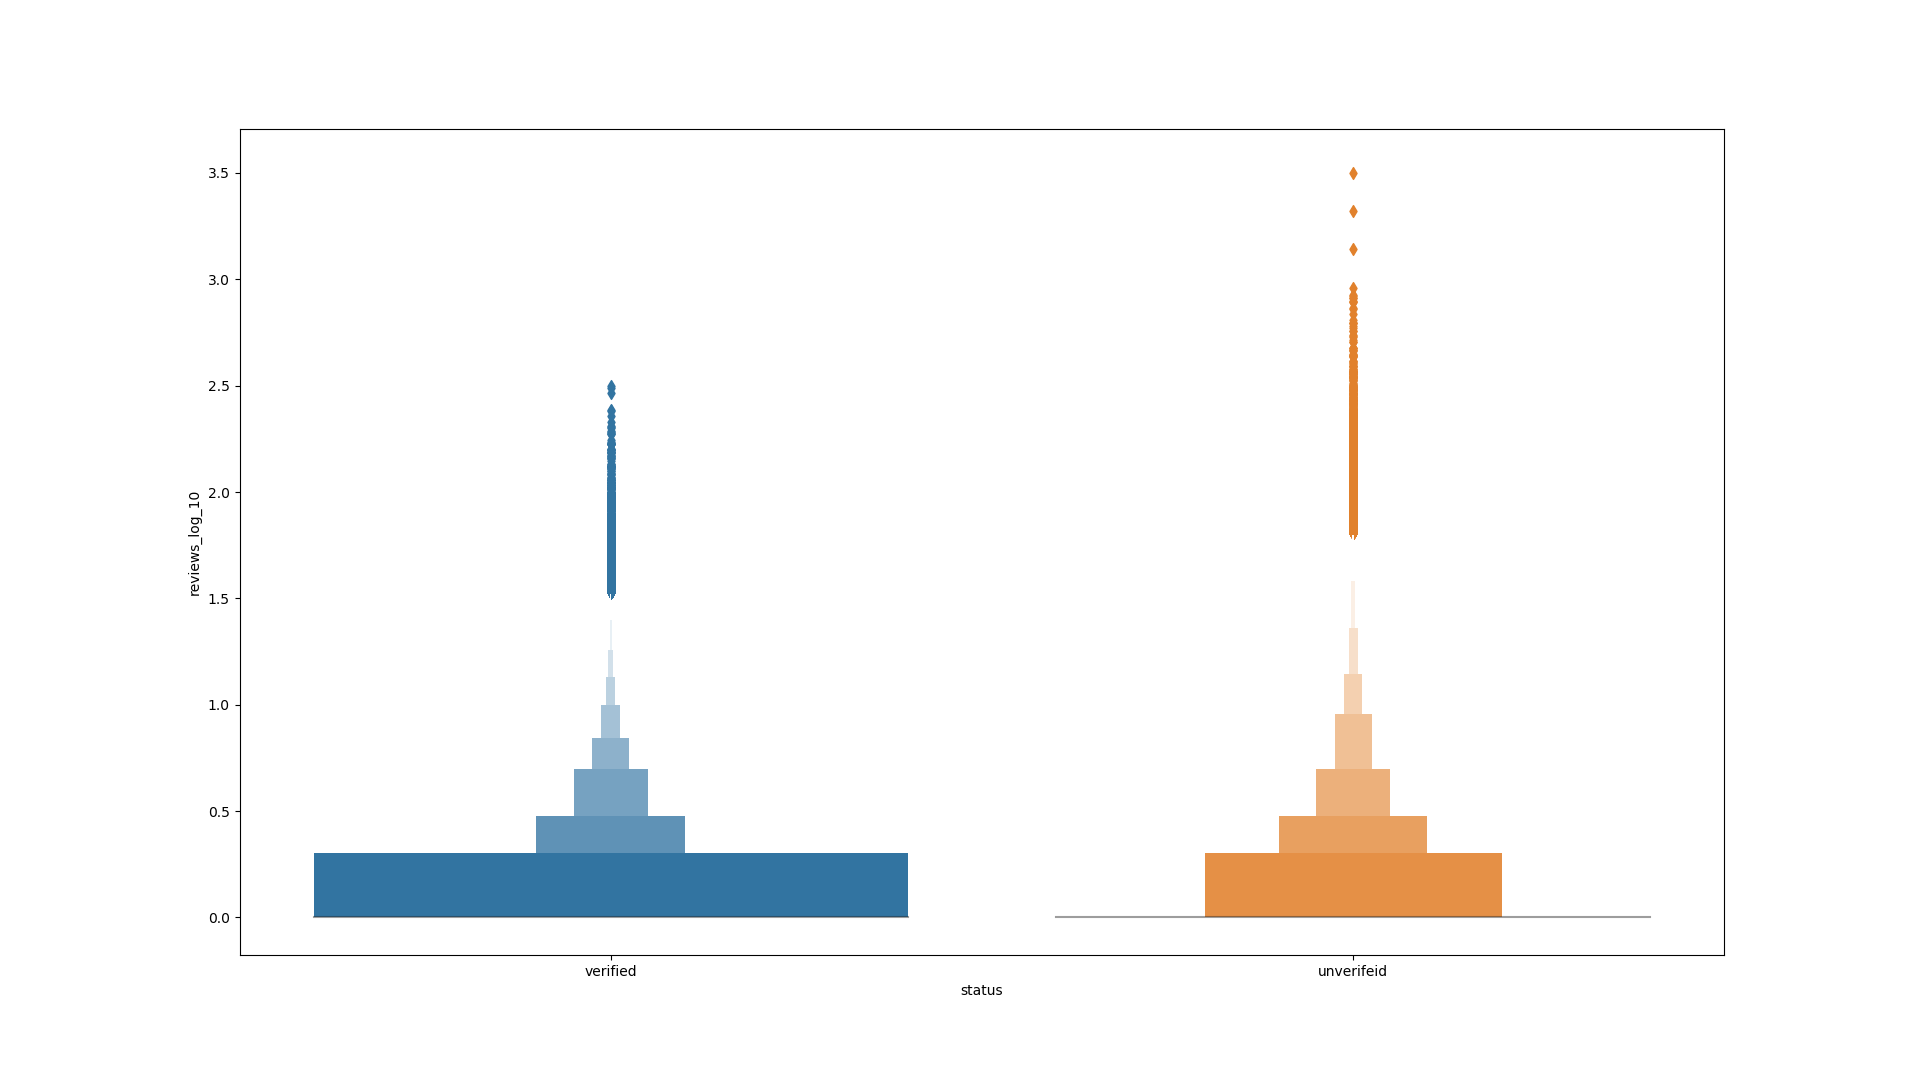

Note that y axis of this plot is rescaled with log10, but notice how skewed the unverified graph is. Maximum numbers of reviews left by one customer for un-verified purchase was 3161. You can see that small numbers of users are leaving large amount of reviews, making it seems less legitimate.


### Star Ratings by Product Categories

Finally, let's investigate numbers of each star ratings by each categories. 
We need to group the records by `product_category` first, and count occurence of each star ratings within.

In [75]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_cnt -f,+1,eok,tsv - -d %cols -g product_category -kX - keyName star_rating | \
 aq_ord -f,+1 - -d S:product_category I:star_rating I:Count -sort product_category star_rating'

"product_category","star_rating","Count"
"Apparel",1,6
"Apparel",2,7
"Apparel",3,12
"Apparel",4,17
"Apparel",5,85
"Automotive",1,157
"Automotive",2,76
"Automotive",3,137
"Automotive",4,233
"Automotive",5,931
"Baby",1,626
"Baby",2,470
"Baby",3,818
"Baby",4,1759
"Baby",5,8287
"Beauty",1,6
"Beauty",3,3
"Beauty",4,9
"Beauty",5,37
"Books",1,68170
"Books",2,53808
"Books",3,90924
"Books",4,193814
"Books",5,788100
"Camera",1,1852
"Camera",2,1447
"Camera",3,3136
"Camera",4,7462
"Camera",5,22889
"Digital_Ebook_Purchase",1,58749
"Digital_Ebook_Purchase",2,59250
"Digital_Ebook_Purchase",3,132614
"Digital_Ebook_Purchase",4,327890
"Digital_Ebook_Purchase",5,979828
"Digital_Music_Purchase",1,4400
"Digital_Music_Purchase",2,3725
"Digital_Music_Purchase",3,8102
"Digital_Music_Purchase",4,24341
"Digital_Music_Purchase",5,122728
"Digital_Video_Download",1,71347
"Digital_Video_Download",2,53363
"Digital_Video_Download",3,98355
"Digital_Video_Download",4,216916
"Digital_Video_Download",5,676594
"Electronic

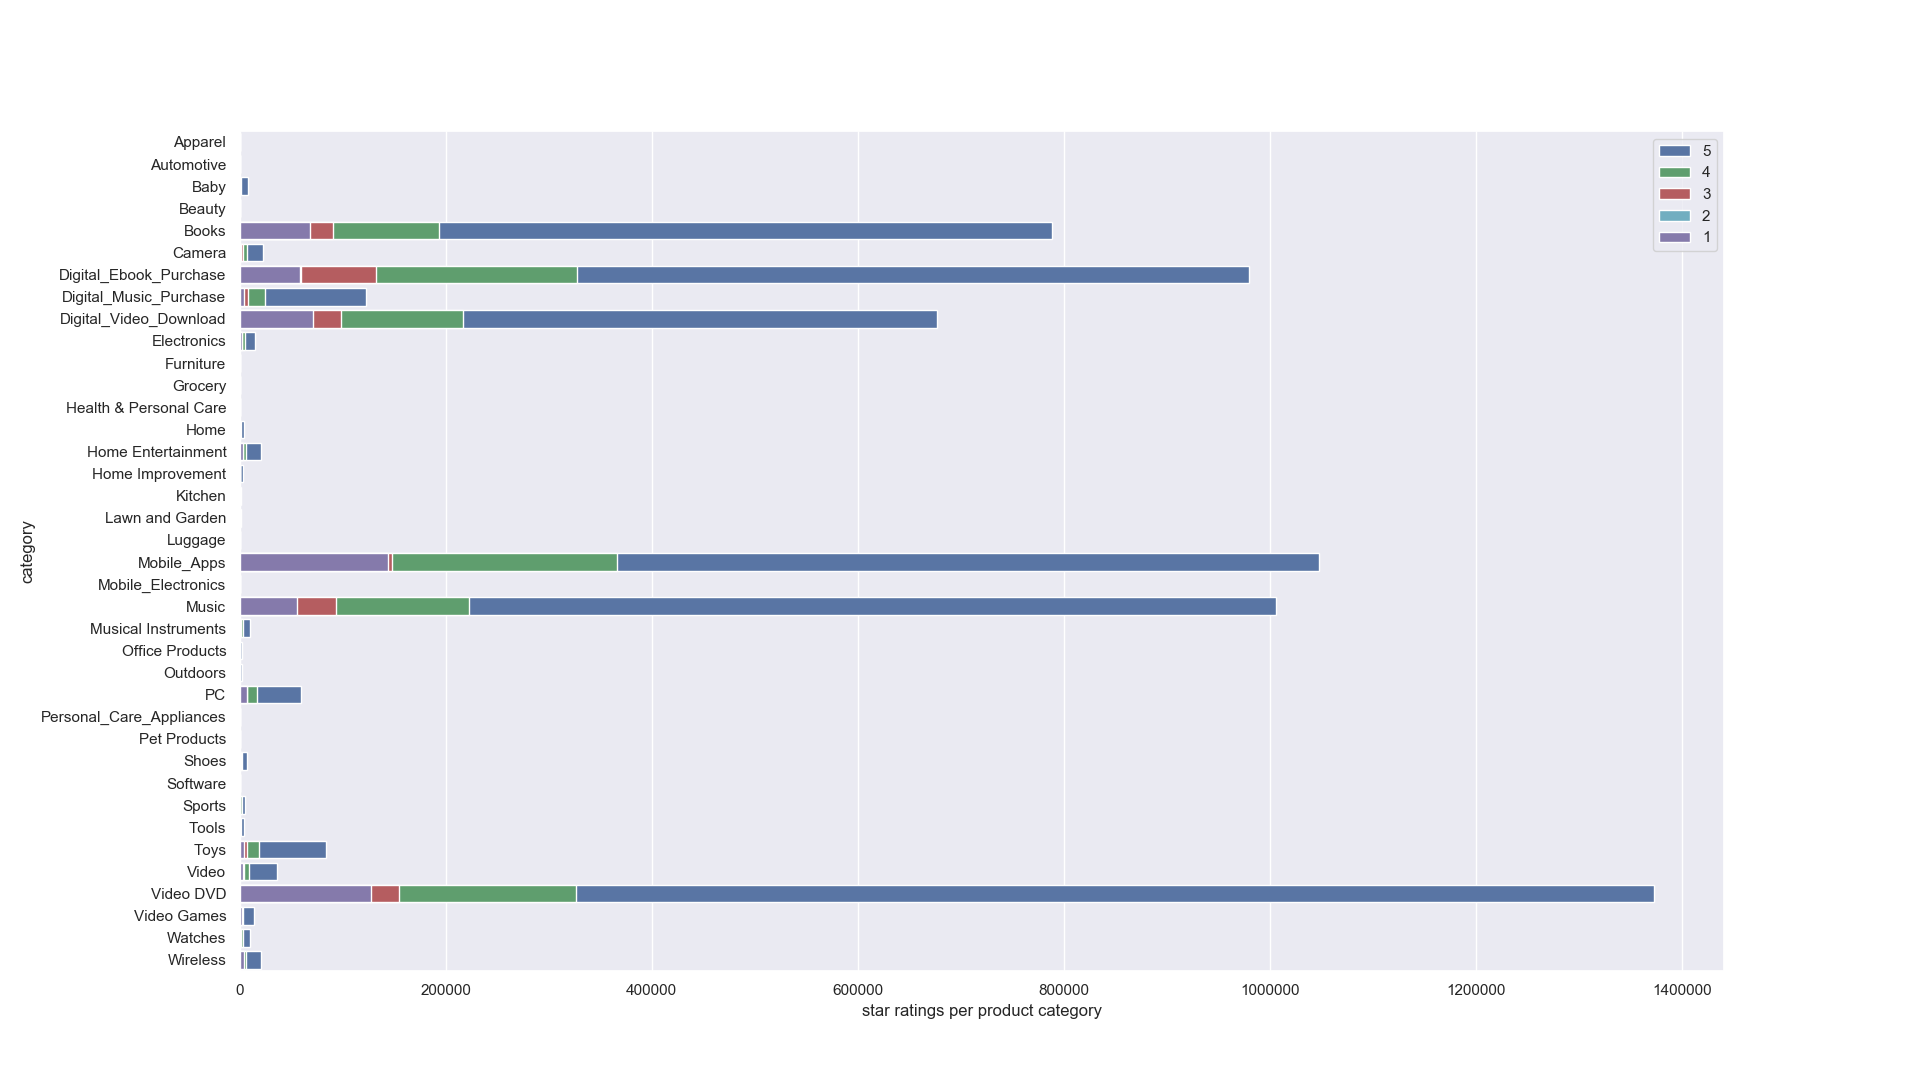
*category and numbers of star ratings*


**Visualizations for this notebook was done with python, but [PivotBillions](https://pivotbillions.com/) is a great big data EDA, ETL, visualization tool you can use!**